In [1]:
import os


os.chdir("../../")
os.getcwd()

'/Users/goldyrana/mess/deep_learning/projects/rag'

In [45]:
from server.dependencies import *
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from backend.src.queries.handler import QueryHandler
from langchain.schema.document import Document
from typing import *
from langchain.schema.messages import HumanMessage
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.schema.output_parser import StrOutputParser


embeddings = OpenAIEmbeddings()
# vb = VectorDatabase()
# vectorstore = vb.init_chromadb(embeddings)
# retriever = vb.get_retriever(vectorstore, id_key="doc_id")
# query_handler = QueryHandler(retriever)


def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    return [
        HumanMessage(
            content=[
                {"type": "text", "text": f"""Answer the question based only on the following context, which can include text, tables, and the below image:
                Question: {dict["question"]}

                Text and tables:
                {format_texts}
                            """},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{dict['context']['images'][0]}"}},
                    ]
                    )
            ]
    

class QueryService:
    def __init__(self):
        self.vb = get_vector_db()
        self.chroma = self.vb.init_chromadb(embeddings)
        self.multi_vector_retriever = self.vb.get_multivector_retriever(self.chroma, id_key="doc_id")
        self.query_handler = QueryHandler(self.multi_vector_retriever)
        self.vectorstore_as_retriever = self.query_handler.get_vectorstore_as_retreiever()
        
    def search_similar_documents(self, query: str, top_k: int = 5) -> List[Document]:
        """Performs similarity search on vectorstore docs."""
        results = self.query_handler.similarity_search(query, top_k)
        return results

    def rag_pipeline(self: object, prompt_func, model):
        chain = (
            {"context": self.vectorstore_as_retriever | RunnableLambda(QueryHandler.split_image_text_types), "question": RunnablePassthrough()}
            | RunnableLambda(prompt_func)
            | model
            | StrOutputParser()
        )
        return chain
        
    def get_stored_docs(self, retrieved_docs: List[Document])-> dict:
        """Main function to process query using RAG"""
        data = self.query_handler.split_image_text_types(retrieved_docs)
        return data

In [75]:
# from server.services.query_service import QueryService
qs = QueryService()
retreieved_docs = qs.search_similar_documents("What this report about")

2025-02-11 23:39:41,969 - chromadb.api.segment - DEBUG - Collection test5 already exists, returning existing collection.


2025-02-11 23:39:41,978 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x10871b670>, 'json_data': {'input': [[3923, 420, 1934, 922]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
2025-02-11 23:39:41,981 - openai._base_client - DEBUG - Sending HTTP Request: POST https://api.openai.com/v1/embeddings
2025-02-11 23:39:41,983 - httpcore.connection - DEBUG - close.started
2025-02-11 23:39:41,985 - httpcore.connection - DEBUG - close.complete
2025-02-11 23:39:41,986 - httpcore.connection - DEBUG - connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
2025-02-11 23:39:42,013 - httpcore.connection - DEBUG - connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x1087115e0>
2025-02-11 23:39:42,015 - httpcore.connection - DEBUG - start_tls.started ssl_context=<ssl.SSLContext object at 

2025-02-11 23:39:43,349 - urllib3.connectionpool - DEBUG - https://us.i.posthog.com:443 "POST /batch/ HTTP/1.1" 200 15


In [76]:
retreieved_docs

[Document(id='461377be-4f79-4ad1-899d-ab216fcaf38e', metadata={'doc_id': 'd4b31a12-4106-4d6b-813a-d08f6c88bf66', 'file_directory': 'backend/data/raw_pdfs', 'filename': '2023_removed.pdf', 'filetype': 'application/pdf', 'languages': 'eng', 'last_modified': '2025-02-06T12:34:29', 'orig_elements': 'eJy1WFFvHLcR/ivEvTQBTqokW4rsezKctMhDGyN2nAfDEHhc7i4rLrkhuXc6B/nv+WZI7u1JahoU7YNhLY/kzHwz880MP/260lYP2qU706xei5W8vLzV6vry7Oby9puzl83L67PbGynPtlrdvmyu2ra9vV6txWrQSTYySZz5daW8D41xMunI31Ye/JTuem26PmHl8vriAmfK8t40qcfq1c3NN1gdvXGJzn36dHN7/nItrm8vzi8+r0X5vLy8uTm/pe+rm4sX56+eW8lHsLKKh5j0QJa8Mw/avh+l0qvf8EOjk1bJeHenrIzxbgx+i20X56+ury5usaE1VqfDqPnsu3+sWGHXTbJjqz6ttOtWn3k1prvBN6Y1mjG7uri6Pru4Oru4+XB59frFy9dXr+j0iJN3bhq2OhAGpETSD4TH6udeB70WxgnpDqL1YS9Dc2a9vzeuEzEBSfLJWqReC+WHkbbphzHoGHXEIfqAOZIMEj6IrbZGt0JGkbxopzQFLbB5simuRZxU/28OmCi2MupGYHWQDhqT3L9E0XnfiFaa1IsRMJBMbNr+izDcQYXJNTqwegBzGka6N4qoE1mDQ3Lrd1p8NTkLlYXziWRge9ibqL/m21iFHdah8pbUldE7ubV0pfCteDMGY8Xl1VoA4BcZC4Scpt9SD80JDmjLNp2LDz2+jthBY2AAwQIuDNIlrfn

In [48]:
l = qs.get_stored_docs(retreieved_docs)

{'doc_id': 'd4b31a12-4106-4d6b-813a-d08f6c88bf66', 'file_directory': 'backend/data/raw_pdfs', 'filename': '2023_removed.pdf', 'filetype': 'application/pdf', 'languages': 'eng', 'last_modified': '2025-02-06T12:34:29', 'orig_elements': 'eJy1WFFvHLcR/ivEvTQBTqokW4rsezKctMhDGyN2nAfDEHhc7i4rLrkhuXc6B/nv+WZI7u1JahoU7YNhLY/kzHwz880MP/260lYP2qU706xei5W8vLzV6vry7Oby9puzl83L67PbGynPtlrdvmyu2ra9vV6txWrQSTYySZz5daW8D41xMunI31Ye/JTuem26PmHl8vriAmfK8t40qcfq1c3NN1gdvXGJzn36dHN7/nItrm8vzi8+r0X5vLy8uTm/pe+rm4sX56+eW8lHsLKKh5j0QJa8Mw/avh+l0qvf8EOjk1bJeHenrIzxbgx+i20X56+ury5usaE1VqfDqPnsu3+sWGHXTbJjqz6ttOtWn3k1prvBN6Y1mjG7uri6Pru4Oru4+XB59frFy9dXr+j0iJN3bhq2OhAGpETSD4TH6udeB70WxgnpDqL1YS9Dc2a9vzeuEzEBSfLJWqReC+WHkbbphzHoGHXEIfqAOZIMEj6IrbZGt0JGkbxopzQFLbB5simuRZxU/28OmCi2MupGYHWQDhqT3L9E0XnfiFaa1IsRMJBMbNr+izDcQYXJNTqwegBzGka6N4qoE1mDQ3Lrd1p8NTkLlYXziWRge9ibqL/m21iFHdah8pbUldE7ubV0pfCteDMGY8Xl1VoA4BcZC4Scpt9SD80JDmjLNp2LDz2+jthBY2AAwQIuDNIlrfnWAs6oAxSFyUqzMsbtvIXGSock4Zdg4n02enJlLRmdV+jiODEWpLvqESas9BFBA

In [49]:
l

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABmAMcDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iq989xHZXD2iLJcCNjEjHhmxwD+NeeaF8VIxdtp3ia1On3kbFXlAOwH0I6r+o96mU1F6nTQwlavGUqSvbfv9x6XRUNvcw3UCT28qSxONyujZBHqDUuao5mmtGLRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAB

In [5]:
for i in retreieved_docs:
    print(i.metadata["type"])
    print(i.metadata["raw_string"])

text
Where, in any forward-looking statement, the company expresses an expectation or belief as to future results, such expectation or belief is based on management's good faith plans and objectives under the assumptions set forth above (unless noted otherwise) and believed to be reasonable as of April 12, 2023, the date of this presentation. These statements are not guarantees of future performance and involve certain risks and uncertainties and are subject to change as management is continually assessing factors beyond our control that may or may not be currently known. Given the foregoing and the extended time horizon of this presentation, actual outcomes and results will likely differ from what is expressed or forecast in the forward-looking statements, and such differences may be material Factors that could cause actual results or events to differ materially from what is presented include changes in commodity prices, including a prolonged decline in these prices relative to histor

In [6]:
retreieved_docs

[Document(id='461377be-4f79-4ad1-899d-ab216fcaf38e', metadata={'doc_id': 'd4b31a12-4106-4d6b-813a-d08f6c88bf66', 'file_directory': 'backend/data/raw_pdfs', 'filename': '2023_removed.pdf', 'filetype': 'application/pdf', 'languages': 'eng', 'last_modified': '2025-02-06T12:34:29', 'orig_elements': 'eJy1WFFvHLcR/ivEvTQBTqokW4rsezKctMhDGyN2nAfDEHhc7i4rLrkhuXc6B/nv+WZI7u1JahoU7YNhLY/kzHwz880MP/260lYP2qU706xei5W8vLzV6vry7Oby9puzl83L67PbGynPtlrdvmyu2ra9vV6txWrQSTYySZz5daW8D41xMunI31Ye/JTuem26PmHl8vriAmfK8t40qcfq1c3NN1gdvXGJzn36dHN7/nItrm8vzi8+r0X5vLy8uTm/pe+rm4sX56+eW8lHsLKKh5j0QJa8Mw/avh+l0qvf8EOjk1bJeHenrIzxbgx+i20X56+ury5usaE1VqfDqPnsu3+sWGHXTbJjqz6ttOtWn3k1prvBN6Y1mjG7uri6Pru4Oru4+XB59frFy9dXr+j0iJN3bhq2OhAGpETSD4TH6udeB70WxgnpDqL1YS9Dc2a9vzeuEzEBSfLJWqReC+WHkbbphzHoGHXEIfqAOZIMEj6IrbZGt0JGkbxopzQFLbB5simuRZxU/28OmCi2MupGYHWQDhqT3L9E0XnfiFaa1IsRMJBMbNr+izDcQYXJNTqwegBzGka6N4qoE1mDQ3Lrd1p8NTkLlYXziWRge9ibqL/m21iFHdah8pbUldE7ubV0pfCteDMGY8Xl1VoA4BcZC4Scpt9SD80JDmjLNp2LDz2+jthBY2AAwQIuDNIlrfn

In [8]:
data = qs.get_stored_docs(retreieved_docs)

{'doc_id': 'd4b31a12-4106-4d6b-813a-d08f6c88bf66', 'file_directory': 'backend/data/raw_pdfs', 'filename': '2023_removed.pdf', 'filetype': 'application/pdf', 'languages': 'eng', 'last_modified': '2025-02-06T12:34:29', 'orig_elements': 'eJy1WFFvHLcR/ivEvTQBTqokW4rsezKctMhDGyN2nAfDEHhc7i4rLrkhuXc6B/nv+WZI7u1JahoU7YNhLY/kzHwz880MP/260lYP2qU706xei5W8vLzV6vry7Oby9puzl83L67PbGynPtlrdvmyu2ra9vV6txWrQSTYySZz5daW8D41xMunI31Ye/JTuem26PmHl8vriAmfK8t40qcfq1c3NN1gdvXGJzn36dHN7/nItrm8vzi8+r0X5vLy8uTm/pe+rm4sX56+eW8lHsLKKh5j0QJa8Mw/avh+l0qvf8EOjk1bJeHenrIzxbgx+i20X56+ury5usaE1VqfDqPnsu3+sWGHXTbJjqz6ttOtWn3k1prvBN6Y1mjG7uri6Pru4Oru4+XB59frFy9dXr+j0iJN3bhq2OhAGpETSD4TH6udeB70WxgnpDqL1YS9Dc2a9vzeuEzEBSfLJWqReC+WHkbbphzHoGHXEIfqAOZIMEj6IrbZGt0JGkbxopzQFLbB5simuRZxU/28OmCi2MupGYHWQDhqT3L9E0XnfiFaa1IsRMJBMbNr+izDcQYXJNTqwegBzGka6N4qoE1mDQ3Lrd1p8NTkLlYXziWRge9ibqL/m21iFHdah8pbUldE7ubV0pfCteDMGY8Xl1VoA4BcZC4Scpt9SD80JDmjLNp2LDz2+jthBY2AAwQIuDNIlrfnWAs6oAxSFyUqzMsbtvIXGSock4Zdg4n02enJlLRmdV+jiODEWpLvqESas9BFBA

In [22]:
data

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABmAMcDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iq989xHZXD2iLJcCNjEjHhmxwD+NeeaF8VIxdtp3ia1On3kbFXlAOwH0I6r+o96mU1F6nTQwlavGUqSvbfv9x6XRUNvcw3UCT28qSxONyujZBHqDUuao5mmtGLRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAB

In [66]:
data

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABmAMcDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iq989xHZXD2iLJcCNjEjHhmxwD+NeeaF8VIxdtp3ia1On3kbFXlAOwH0I6r+o96mU1F6nTQwlavGUqSvbfv9x6XRUNvcw3UCT28qSxONyujZBHqDUuao5mmtGLRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAB

In [13]:
"\n".join(data["texts"])

"Where, in any forward-looking statement, the company expresses an expectation or belief as to future results, such expectation or belief is based on management's good faith plans and objectives under the assumptions set forth above (unless noted otherwise) and believed to be reasonable as of April 12, 2023, the date of this presentation. These statements are not guarantees of future performance and involve certain risks and uncertainties and are subject to change as management is continually assessing factors beyond our control that may or may not be currently known. Given the foregoing and the extended time horizon of this presentation, actual outcomes and results will likely differ from what is expressed or forecast in the forward-looking statements, and such differences may be material Factors that could cause actual results or events to differ materially from what is presented include changes in commodity prices, including a prolonged decline in these prices relative to historical

In [39]:

def prompt_func(dict):
    format_text = "\n".join(dict["context"]["texts"])
    print(dict)
    return [
        HumanMessage(
            content=[
                {"type": "text", "text": f"""Answer the question based only on the following context, which can include text, tables, and the below image:
                Question: {dict["question"]}

                Text and tables:
                {format_text}
                            """},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{dict['context']['images'][0]}"}},
            ]
        )
    ]

In [34]:
k = qs.vectorstore_as_retriever.invoke("hello how are you")

2025-02-11 23:07:21,341 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x33e8c85e0>, 'json_data': {'input': [[15339, 1268, 527, 499]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
2025-02-11 23:07:21,345 - openai._base_client - DEBUG - Sending HTTP Request: POST https://api.openai.com/v1/embeddings
2025-02-11 23:07:21,347 - httpcore.connection - DEBUG - close.started
2025-02-11 23:07:21,362 - httpcore.connection - DEBUG - close.complete
2025-02-11 23:07:21,366 - httpcore.connection - DEBUG - connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
2025-02-11 23:07:21,445 - httpcore.connection - DEBUG - connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x33e8d4d90>
2025-02-11 23:07:21,445 - httpcore.connection - DEBUG - start_tls.started ssl_context=<ssl.SSLContext object at

In [41]:
k

[Document(id='46b10463-b023-435f-8139-7f1f94bff37c', metadata={'doc_id': '06bbaa3e-f8de-44ac-9c2b-98aebdf2eaa4', 'raw_string': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABmAMcDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iq989xHZXD2iLJcCNjEjHhmxwD+NeeaF8VIxdtp

In [44]:
x["context"]

[Document(id='46b10463-b023-435f-8139-7f1f94bff37c', metadata={'doc_id': '06bbaa3e-f8de-44ac-9c2b-98aebdf2eaa4', 'raw_string': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABmAMcDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iq989xHZXD2iLJcCNjEjHhmxwD+NeeaF8VIxdtp

In [51]:
x = {"context": l}
split_image_text(x)

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABmAMcDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iq989xHZXD2iLJcCNjEjHhmxwD+NeeaF8VIxdtp3ia1On3kbFXlAOwH0I6r+o96mU1F6nTQwlavGUqSvbfv9x6XRUNvcw3UCT28qSxONyujZBHqDUuao5mmtGLRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAB

In [53]:
l

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABmAMcDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iq989xHZXD2iLJcCNjEjHhmxwD+NeeaF8VIxdtp3ia1On3kbFXlAOwH0I6r+o96mU1F6nTQwlavGUqSvbfv9x6XRUNvcw3UCT28qSxONyujZBHqDUuao5mmtGLRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAB

In [56]:
a = qs.vectorstore_as_retriever.invoke("hello how are you? ")
a = {"context": a}

2025-02-11 23:17:59,532 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x1080e6040>, 'json_data': {'input': [[15339, 1268, 527, 499, 30, 220]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
2025-02-11 23:17:59,541 - openai._base_client - DEBUG - Sending HTTP Request: POST https://api.openai.com/v1/embeddings
2025-02-11 23:17:59,542 - httpcore.connection - DEBUG - close.started
2025-02-11 23:17:59,543 - httpcore.connection - DEBUG - close.complete
2025-02-11 23:17:59,544 - httpcore.connection - DEBUG - connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
2025-02-11 23:17:59,560 - httpcore.connection - DEBUG - connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x1080f1280>
2025-02-11 23:17:59,561 - httpcore.connection - DEBUG - start_tls.started ssl_context=<ssl.SSLContext 

In [60]:
a

{'context': [Document(id='46b10463-b023-435f-8139-7f1f94bff37c', metadata={'doc_id': '06bbaa3e-f8de-44ac-9c2b-98aebdf2eaa4', 'raw_string': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABmAMcDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iq989xHZXD2iLJcCNjEjHhmxwD+

In [ ]:
def foo(dict):
    data = dict["context"]
    return data



b = foo(a) # {"context": a}

In [62]:
c = qs.get_stored_docs(b)


{'doc_id': '06bbaa3e-f8de-44ac-9c2b-98aebdf2eaa4', 'raw_string': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABmAMcDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iq989xHZXD2iLJcCNjEjHhmxwD+NeeaF8VIxdtp3ia1On3kbFXlAOwH0I6r+o96mU1F6nTQwlavGUqSvbfv9x6XRUNvcw3UCT28qS

In [85]:
l

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABmAMcDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iq989xHZXD2iLJcCNjEjHhmxwD+NeeaF8VIxdtp3ia1On3kbFXlAOwH0I6r+o96mU1F6nTQwlavGUqSvbfv9x6XRUNvcw3UCT28qSxONyujZBHqDUuao5mmtGLRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAB

In [71]:
data.keys()

dict_keys(['images', 'images_metadata', 'texts', 'texts_metadata'])

In [96]:
model = ChatOpenAI(model="gpt-4-turbo")


def prompt_func(dict):
    format_text = "\n".join(dict["context"]["texts"])
    print(dict)
    return [
        HumanMessage(
            content=[
                {"type": "text", "text": f"""Answer the question based only on the following context, which can include text, tables, and the below image:
                Question: {dict["question"]}

                Text and tables:
                {format_text}
                            """},
                {"type": "image_url", "image_url": {"url": f"data:image/jpg;base64,{dict['context']['images'][1]}"}},
            ]
        )
    ]
    


In [108]:
def prompt_func(dict):
    print(dict.keys())
    print(dict["context"].keys())
    print(dict["context"]["images"])
    if ("texts" in dict["context"]) and len(dict["context"]["texts"]) > 0:
        print(len(dict["context"]["texts"]))
    format_texts = "\n".join(dict["context"]["texts"])

    # Base message
    message_content = [
        {"type": "text", "text": f"""Answer the question based only on the following context:
        Question: {dict["question"]}

        Text and tables:
        {format_texts}
        """}
    ]

    # ✅ Only add `image_url` if an image exists
    if ("images" in dict["context"]) and len(dict["context"]["images"]) > 0:
        print(len(dict["context"]["images"]))
        message_content.append(
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{dict['context']['images'][0]}"}}
        )

    return [HumanMessage(content=message_content)]

2025-02-12 11:02:41,122 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x109517790>, 'json_data': {'input': [[3923, 420, 1934, 922]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
2025-02-12 11:02:41,125 - openai._base_client - DEBUG - Sending HTTP Request: POST https://api.openai.com/v1/embeddings
2025-02-12 11:02:41,126 - httpcore.connection - DEBUG - close.started
2025-02-12 11:02:41,129 - httpcore.connection - DEBUG - close.complete
2025-02-12 11:02:41,130 - httpcore.connection - DEBUG - connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None


2025-02-12 11:02:41,146 - httpcore.connection - DEBUG - connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x109572400>
2025-02-12 11:02:41,148 - httpcore.connection - DEBUG - start_tls.started ssl_context=<ssl.SSLContext object at 0x105b7f940> server_hostname='api.openai.com' timeout=None
2025-02-12 11:02:41,167 - httpcore.connection - DEBUG - start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x109d9c220>
2025-02-12 11:02:41,168 - httpcore.http11 - DEBUG - send_request_headers.started request=<Request [b'POST']>
2025-02-12 11:02:41,168 - httpcore.http11 - DEBUG - send_request_headers.complete
2025-02-12 11:02:41,169 - httpcore.http11 - DEBUG - send_request_body.started request=<Request [b'POST']>
2025-02-12 11:02:41,169 - httpcore.http11 - DEBUG - send_request_body.complete
2025-02-12 11:02:41,170 - httpcore.http11 - DEBUG - receive_response_headers.started request=<Request [b'POST']>
2025-02-12 11:02:41,573 - httpcore.http11 - 
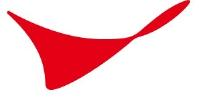

{'doc_id': 'd4b31a12-4106-4d6b-813a-d08f6c88bf66', 'file_directory': 'backend/data/raw_pdfs', 'filename': '2023_removed.pdf', 'filetype': 'application/pdf', 'languages': 'eng', 'last_modified': '2025-02-06T12:34:29', 'orig_elements': 'eJy1WFFvHLcR/ivEvTQBTqokW4rsezKctMhDGyN2nAfDEHhc7i4rLrkhuXc6B/nv+WZI7u1JahoU7YNhLY/kzHwz880MP/260lYP2qU706xei5W8vLzV6vry7Oby9puzl83L67PbGynPtlrdvmyu2ra9vV6txWrQSTYySZz5daW8D41xMunI31Ye/JTuem26PmHl8vriAmfK8t40qcfq1c3NN1gdvXGJzn36dHN7/nItrm8vzi8+r0X5vLy8uTm/pe+rm4sX56+eW8lHsLKKh5j0QJa8Mw/avh+l0qvf8EOjk1bJeHenrIzxbgx+i20X56+ury5usaE1VqfDqPnsu3+sWGHXTbJjqz6ttOtWn3k1prvBN6Y1mjG7uri6Pru4Oru4+XB59frFy9dXr+j0iJN3bhq2OhAGpETSD4TH6udeB70WxgnpDqL1YS9Dc2a9vzeuEzEBSfLJWqReC+WHkbbphzHoGHXEIfqAOZIMEj6IrbZGt0JGkbxopzQFLbB5simuRZxU/28OmCi2MupGYHWQDhqT3L9E0XnfiFaa1IsRMJBMbNr+izDcQYXJNTqwegBzGka6N4qoE1mDQ3Lrd1p8NTkLlYXziWRge9ibqL/m21iFHdah8pbUldE7ubV0pfCteDMGY8Xl1VoA4BcZC4Scpt9SD80JDmjLNp2LDz2+jthBY2AAwQIuDNIlrfnWAs6oAxSFyUqzMsbtvIXGSock4Zdg4n02enJlLRmdV+jiODEWpLvqESas9BFBA

2025-02-12 11:02:45,872 - httpcore.http11 - DEBUG - receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Wed, 12 Feb 2025 05:32:46 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'access-control-expose-headers', b'X-Request-ID'), (b'openai-organization', b'user-gccgvei9eaw4a1hksddpirf5'), (b'openai-processing-ms', b'3573'), (b'openai-version', b'2020-10-01'), (b'x-ratelimit-limit-input-images', b'500'), (b'x-ratelimit-limit-requests', b'500'), (b'x-ratelimit-limit-tokens', b'30000'), (b'x-ratelimit-remaining-input-images', b'499'), (b'x-ratelimit-remaining-requests', b'499'), (b'x-ratelimit-remaining-tokens', b'28188'), (b'x-ratelimit-reset-input-images', b'120ms'), (b'x-ratelimit-reset-requests', b'120ms'), (b'x-ratelimit-reset-tokens', b'3.624s'), (b'x-request-id', b'req_4781017ef46232039645f5718a9fd808'), (b'strict-transport-security', b'max-age=31536000; includeSubDomains; preload'

"It appears there's no question specified in the provided context that pertains directly to the included image of a simple red shape resembling a wave or a stylized checkmark. If you have a specific question about the image or how it might relate to the text, please let me know, and I will strive to provide the most appropriate response."

In [109]:
chain = (
    RunnableLambda(lambda query: qs.search_similar_documents(query))
    | RunnableLambda(qs.get_stored_docs)
    | (lambda context: {"context": context, 
                        "question": RunnablePassthrough()})
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

chain.invoke("What this report about")

In [ ]:
x = {'context': {'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABmAMcDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iq989xHZXD2iLJcCNjEjHhmxwD+NeeaF8VIxdtp3ia1On3kbFXlAOwH0I6r+o96mU1F6nTQwlavGUqSvbfv9x6XRUNvcw3UCT28qSxONyujZBHqDUuao5mmtGLRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVFPPFbwvNNIscaAszMcAAdzQNK+iJDXP8AiLxlo/hmEm9uA05XKW8fzO34dh7mvP8Axf8AFd3aSx8PHaoJVrxhyf8AcH9T+XevK5ppLiZpZpHklY5ZnOST7muWriVHSJ9PlvDlSslUxPux7df+Ad3r/wAV9a1Nni07bp9sRgbPmkI/3u34D8a1vhboWp6hq48R309wYIgyxNI5JmYggnJ6gZP4/SsfwJ8PZ/EMiahqKtFpinKjo0/0/wBn3/L1Hu1vbxWsCQQRpHEg2qiLgKPQClShOb55l5ti8LhKbwmEirvRv9L9yUcCilorrPlBMVxnjrwJb+J7Q3NuFh1OIfJJjiQf3W/oe1dpQamUVJWZth8RUw9RVKbs0fMmna5r3hDUZIYJ5baWJtsttJymfdTx+Ir03w98X7C68uDWoGtJiMGePLRk/TqP1+tanxC8DJ4jsmvrJFXU4V47eao/hPv6GvA5I3hkeORGSRCVZWGCCOoIrik50XbofbYengs6pc842mt7b/8ABR9WWWo2mo2y3FlcxXELfdeNwwP5VazXylYapf6VOJrC8mtpAc5jcjP1Hf8AGvQdE+MWo2v7vV7RLxP+ekRCOPqOh/StoYmL+LQ8nF8M4inrQfMvuZ7Xmlrk9I+IvhrVkTF+trK3WK6/dkH0z0P4GuqV0dQysGB6EGuhST2Pn62Hq0ZctSLT8x1FGaKZiFFFFABRRRQAUUUUAFFGa53xX4w07wrY+bcP5lyw/dWyH5nPr7D3pNpK7NKVKdaahTV2zQ1rXLHQNPe91CZYol4A7sewA7mvBfGHjrUPFM5iBa309T8lup+97v6n9BWR4g8Raj4k1BrzUJtxHEca8JGPQCtXw34A1vxGUljhNtZsM/aZhhSP9kdW/l71w1Ksqj5YbH2+AyvDZbD6xi5Lm/L07s5iKKSeVIokZ5HIVEUZLE9ABXrXgv4VbWi1DxCoJGGSzz0P+36/T8/Su18MeCNJ8MRBreLzbsjD3Mgyx+n90ew/WulAxWtLDqOsjzM04inWTpYb3Y9+r/yGpGsaKiKFVRgADAFPoorqPlwooooAKKKKACvIvip4MGH8RafHgj/j7jUdf9v/AB/P1r12opoknheKRQ6OCrKRkEHqKicFONmdmBxk8HWVWHz80fJlFdH428Mt4Y8Qy2qA/ZJB5luxOfkPYn1HSucry5RcXZn6lh68K9KNWGzCtDTtd1XSHV7DULi3x/CjnafqvQ/jWfRSTa2KnThUVpq6O+0/4u+IrVlF0tteRj725NjH8Rx+ldRa/GrT2A+16Vcx+vlOr/zxXjNFaxxFRdTyq2Q4GrryW9ND6Ftfij4UuVG6/aFj/DLC4x+IBH61ox+OvDEv3dbtB/vPt/nXzTRWixUuqPPnwrhn8M2vuPp4eLvDhGf7e038bpP8aP8AhLvDn/Qe0z/wLT/GvmGiq+tvsZf6p0/+fj+4+mX8a+GUHOuWJ/3Zgf5VQuviV4VtULf2mspHRYo2Yn9MV861r+H/AA3qPiXUBa2EJIBHmSsPkjHqT/TqaFiZt2SCXDWEoxc61R2Xoj0m/wDire6vMNP8L6TM9zIflklAY47kKOPxJwKo2/wr1/XLk32vaokUsp3OP9ZIPbsB+GQK9E8K+EbDwrp4htkElwwHnXDD5nP9B7V0Nbqk5a1NTxJ5pDDScMBHlX8z1b+/Y5PQ/h14e0RxLHam5nH/AC1uTvI+g6D8q6sKF6DFOorVRUdEeTWr1a0uarJt+YUUUUzIKKKKACiiigAooooAKMUUUAcZ8SfDo13wxLJFGpu7MGaI45IA+ZfxH6gV89V9bMAylSMgjBr5k8XaSuieKdQsEQrEkm6IeiNyP0OPwrixUNpH2fC2MbUsNLpqv1MSiiiuM+xCiiigAooooAKKfFFJPMkMKNJLIQqIoyWJ6ACvWfBvwqwY7/xCuTw0dmD0/wB8/wBPz9K0hTlN2RwY7MaGChzVXr0XVnKeDvAF/wCJ5UuJQ1tpoPMzDmT1Cf49PrXu+kaLY6HYJZafAsUKDsOWPqT3NXIokhjWONFRFGFVRgAVJXoU6UYLQ/PcyzWtjp+9pHogooorU8wKKKKACiiigAooooAKKKKACiiigAooooASvFfjRZiPWtOvAuPOgaMn/dbP/s1e1GvNfjPbK/huxucfPHdBc+gZWz+oFY11emz18iqezx9Pz0PEqKKK8w/TQooqzY2F3qd2trZW0lxO3SOMZP19hTSvsTKcYLmk7IrVveG/CGq+J7nZZRbIFOJLiQEInt7n2FegeFfhGqbLvxCwdsAi0jPA/wB5h1+g/OvVLe1gtIFht4Y4okGFSNQqgewFdVPDN6zPlcy4khTvTwur79Pl3Oc8KeBtL8Lwh4k8+9YYe5kUbvoo/hHsP1rqAKWiu1RUVZHxlatUrTc6ju2FFFFMyCiiigAooooAKKKKACiiigAooooAKKKKACiiigArhvizbPP4HldFLCGZJGx2GcZ/Wu5pk0Uc8LxSorxuCrKwyCD2IqZR5k0b4Wv7CtGr/K7nyVVvT9LvtVuPIsLSa4k64jXOB6n0FfQkfw78KxXZuV0eIuSThmZk/wC+Sdv6V0VtZ21nEIra3ihjH8MaBR+QrkjhH1Z9dW4rhy/uabv5nkHh74P3U5jn124EEZGTbQkF/oW6D8M/WvU9H0DTNBtRb6baRwJjkgZZv95jyfxrSx7UV0wpRhsfM4zM8TjH+9lp26ABiloorQ4AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/2Q==', '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHrA+4DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDuh8X9Ptpof7Z8PeIdGtJ3CR3l/ZbIuTxuOeP1r0NGDoHUhlYZBByCK8++Mup2kHgC70p1M1/qhS3s7WNS7yvuB4A9MZ+uB1Irs9Bs5dP8PabZTnM1vaxROc5yyqAefqKAKvivxNZeEPDtxrWoJPJbQFAyQKC53MFGASB39ema5JfjDaMwA8H+MOTjP9mDH/odRfHTzJPAMNskUsouNRhR1iQs20BmJwP92tXR/iv4V1bVIdLFxcWV5MdsUV7btDvPoCeMntzz060AdTrGrWWhaTc6nqE6w2lsheRyM4H0HJJ6Ad64X/hcmlwrFd32geIbHSZmAj1G4ssQnPQnBJwe3XNQfFxBqV34P0CYn7HqOsILlAcb0XGVPt836Cuz8WaVFq3g3VtMZBsms5EUAfdO07SB7EA/hQBo3GpWlppkmpT3McdlHF5zTlvlCYzuz6YrgD8ZtMWH7efD/iH+xt2P7T+xfucf3s5zj3/SuAvdbvtR/Z48Nad5x83UdQTTHc9fKV32j8AiD6Cve5NJsptGbSZIFaxaD7OYSOPL27dv5UATWV5BqFlBeWsqy286CSORejKRkEfhVivNfgbLIfh2LSRywsr2e3XPYBt382NelUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARzTR28Ek00iRxRqWd3OAoHJJPYVwXhf4w+HPFviKLRNNh1AXMgcq80SqmFBJ5DE9B6VzXxq8X3D/Z/AmhAzapqZVLhU6qjH5Uz0BY9fRfrXm/was30741QWUjBpLf7TExXoSqMDj8qAPq6iiigArz/wAWfGHw54O12TR9Sg1GS5RFcm3iRlwwyOS4/lXoBr5s8WWdtrX7TUWn3kKT2zTW6SROMqy+SrEGgDt/+GivB3/PprH/AIDx/wDxyvRPC/iOz8W+HrbW7BJktbguEWZQrjaxU5AJHVT3rK/4Vn4I/wChY07/AL9Cuh0vS7HRtPjsNNtY7W0izshiGFXJJOB9ST+NAHEeLPjBoHhfVn0hIbvU9TXAaCzQMEPXDHPX2ANWvBfxT0LxtdyWFqtzZ6jGhdrW6UAkDrtIJzj04PtXnvwBiiufEvi6/u8NqQkQFm+8AzyF8fUqufoKXxlFFaftK+GpLBQs0yQNcbBjJLOpJ99gH4YoA94d1jRnZgqqMkk4AFc74U8aWHjKK8n0u3uxa20xh+0TIqpMw67MMSRjB5A6j8OQ+Kmu3epXNp8PtBcf2pq/F05BxBb9ySPUA59gfUV3/h3QbLwzoNppGnxhLe2QKDjlz3Y+5OSfrQBqUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWN4r1a40PwvqGp2yxvPbxb0WQEqTnuAQa2a5j4h/8iBrX/Xuf5itaEVKrGL2bRM3aLZ5P/wALv8Tf8+Wlf9+pP/i6P+F3+Jv+fLSv+/Un/wAXXmtFfef2Tg/+faPL9vU7npX/AAu/xN/z5aV/36k/+Lo/4Xf4m/58tK/79Sf/ABdea0U/7Jwf/PtB7ep3PSv+F3+Jv+fLSv8Av1J/8XR/wu/xN/z5aV/36k/+LrzWij+ycH/z7Qe3qdz0r/hd/ib/AJ8tK/79Sf8AxdH/AAu/xN/z5aV/36k/+LrzWij+ycH/AM+0Ht6nc9K/4Xf4m/58tK/79Sf/ABdH/C7/ABN/z5aV/wB+pP8A4uvNaKP7Jwf/AD7Qe3qdz0r/AIXf4m/58tK/79Sf/F0f8Lv8Tf8APlpX/fqT/wCLrzWij+ycH/z7Qe3qdz0r/hd/ib/ny0r/AL9Sf/F0f8Lv8Tf8+Wlf9+pP/i681oo/snB/8+0Ht6nc9K/4Xf4m/wCfLSv+/Un/AMXR/wALv8Tf8+Wlf9+pP/i681oo/snB/wDPtB7ep3PSv+F3+Jv+fLSv+/Un/wAXR/wu/wATf8+Wlf8AfqT/AOLrzWij+ycH/wA+0Ht6nc9K/wCF3+Jv+fLSv+/Un/xdH/C7/E3/AD5aV/36k/8Ai681oo/snB/8+0Ht6nc9K/4Xf4m/58tK/wC/Un/xdH/C7/E3/PlpX/fqT/4uvNaKP7Jwf/PtB7ep3PSv+F3+Jv8Any0r/v1J/wDF0f8AC7/E3/PlpX/fqT/4uvNaKP7Jwf8Az7Qe3qdz0r/hd/ib/ny0r/v1J/8AF0f8Lv8AE3/PlpX/AH6k/wDi681oo/snB/8APtB7ep3PSv8Ahd/ib/ny0r/v1J/8XR/wu/xN/wA+Wlf9+pP/AIuvNaKP7Jwf/PtB7ep3PSv+F3+Jv+fLSv8Av1J/8XXp3w58V3/i7QLi/wBQit45Y7poQIFYDaEQ9yefmNfM9e+fA/8A5E29/wCwg/8A6Ljryc5wGHoYbnpws7o3w9Wcp2bPTaKQUtfJnecT4V8CCw1D/hIfEVz/AGr4klUbriRfkthj7kK/wgZIz1Ptkiutvb60062e6vbqG2t0xvlmkCIuTgZJ46nFcB/worwD/wBAuf8A8C5f/iqf4k8DK+k+F/Cmk2b/ANhQaiJrwNJuAhXc5VixyQzNQB6B58WYw0qAyfcBYfNxnj14rzf46DST8Orj7cIjfeYg0/P+s83cM7e/3d2f/wBVdd4p8H6T4wsIrTVUmxC/mQywSmN4nxjcCOM49Qax9G+FXhrR9Ti1N1vNRv4SDFcahcGZoyOhA4HHbjigDm/iO1xpml+BPEV+khTS7+3a/YKWMYZV3MfxXH1IHeu58Ya7baR4H1TVjMhRbN2hYNw7MpCAH3JFbOo6faatp89hf26XFrOuySJxkMK4iw+DfhSyvIpXS9vLaBy9vY3dyZLeFj3VO/45oA8/1nw1f6L+z94cuvLzc6XeR6pLH3CuzED6jzEz6YNe1zeINNg8Nvr73Sf2atv9p84HIKYzx6ntj14q9c2kF5aS2tzDHNbzIUkikXKupGCCO4xXBxfBfwlHeByt/JYiTzV0yS7Y2qv6hOv5k0AHwVsLi0+HcFxdRNFJf3Et4EYYO1mwp/EAEexFeh0yONYo1jRQqKAqqowAB2FPoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKjmmjt4XmlkWOKNS7uxwFA5JJ9KkrP1zSYte0O90qeWSKG8haF3iIDBWGDjII6UAeP3n7QxbULj+yPC1zfaZAcNctKUYj+8QEIUdcZP5dB3nhv4p+EvEti1xDqsNnIg/eQXzrC6e/JwR7gmtPwd4QsPBWgrpGnPNJCJWlMkxBdmbucADoAOnaub8Q/BPwb4guvtP2WfTpi26RrBxGJPqpBUfgBQAvw9+JU3jvX9atYtPji0+xP7m5VyTKCxC5BHGVGa1PiJ48s/Afh5ryTbJfTZSztz/y0f1OP4R3P4d61vDHhXSfCGkjTdHtvJg3b3JYs0jYALMT1PA9vSvJ/iv8ACzxR4y8Z/wBp6YbRrRbZIkE05UgjJOBjpk0AT/BnwTd3N1N498RhpdRvWZ7UTL8yg9ZeemeQP9npwRXE/DL/AJOFuP8Ar5vv5PW4vgP40IoVPEjKoGAF1JsAD8K8z8NaV4nvfH8mn6PfGDXhJOrXAnKEsu7ed3vg/WgD7F1XVLPRdLuNSv5vJtLdN8sm0ttX1wASfwFcX/wu34e/9DD/AOSVx/8AG6veEvDmqP4EbRfGsv8AaNzMZFuC8zSb0JyBu4PSof8AhT/gH/oXIP8Av7L/APFUAdHoHiLS/FGlrqWjXX2mzZygk8tk5HUYYA/pXivi34U+OdU+IupeJdHubW1Mkoe3l+0lJFAQKOg4OBXtuiaDpnhvThp+k2i2toGLCNWJGT1PJJq3bXtreo72tzDOqMUYxOGCsDgg46EHtQB8x6xq3xZ+G13bXWranczWzuArTTfaIZCOShJ5H6H0r33wH4vg8beFLbWIYzDISYp4uuyReoB7jkEexFcn8dtd0uy+Hl3pdxIj3160a28IILDa6sXPcABTz6nFVf2eLSaD4eXM8mQlxqEjxA9CoRFJ/NSPwoAXXfhFqMPiW58QeCvEDaLd3RJngIPlsSctyM8E87SCM9MVDbeEbT4aRah4+8V6vJretRxERvJ8oDkbQqEkkk/dz2GeK9gNeN3OPi18S/sgxJ4U8Oybpsplbu46bfccH8Af7woAq+G9VsvAmmT+O/G80x13xC26KBBvkWDgqqjPAxt6kYAUcEYrb0n48eG7/U4bK9s9Q0vz2CxTXUaiMgngsQflHv0965bxhDFqX7SmhWWpoklkkcQjjkGUOFdgMdOXroP2hbayk8AW9xPtF1DeILY9zuB3L9MDP/ARQB66CCMjpRWH4Nkml8EaDJcZ859Ot2kyedxjXOfetygAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK5j4h/8iBrX/Xuf5iunrmPiH/yIGtf9e5/mK3w38eHqvzJn8LPl2iiiv0s8UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvfPgf/wAibe/9hB//AEXHXgde+fA//kTb3/sIP/6LjrxM/wD9z+aOnC/xD0ylpKWviD0wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEPSvL/AAz8H/8AhHPiFJ4r/t37Rvlnk+zfZNmPM3cbt56bvTmvUaTIoAWikyKXrQAhrwjW/gb4iXX7/VfDnidLdryV5WV2kgZdzFtu5M5HPoK94pM0AeC6P+zvPPei68T+IDcncC8dsGJkHvI/I9On417jp+n2ml6fBY2MCQWsCBI4kGAoFWicUUAY3iqw1TVPDl3YaPeR2V5cL5YuXz+7U9SMc5xwPTOag8GeFLPwd4YtdGtPn8sFppSOZZD95j/T2AroKKAOC+IXw0t/G0lpf216+mazZf6i8jXJIByAcEHg8gg8ZNcxb/CHxDruoWkvjvxU2qWdo4aO0iDYf1DMcYzjBwM+4r2SigBscaRRrHGoVFAVVHQAdqdRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFcx8Q/8AkQNa/wCvc/zFdPXMfEP/AJEDWv8Ar3P8xW+G/jw9V+ZM/hZ8u0UUV+lnihRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV758D/wDkTb3/ALCD/wDouOvA698+B/8AyJt7/wBhB/8A0XHXiZ//ALn80dOF/iHplLSUtfEHphRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAZmrtrHlwx6RHZ73fEst2WKxLjqEXlz7bl+tYng23ubTV/E1rd6jc38kV7F++uCM/NbxsQAAAq5Y4A6D16111clpwkOseNhDnzftEezHXd9kixQBn6FpSeNbKTX9ca6khvJGNjZrcyRxwwAlUYBCMswG4sc9RjFXvCl3dWWuaz4XvLue7+weVcWtxO26RoJQcKx6kqysMnqMVf8DMh8A+HShyv9mW2P8Av0tZlpz8Y9UZOi6JbB/qZpcfpQB2dch4unudC1TS/EkUzLYQv9l1SNnOzyJCAsu3plHwcgZ2lu1Tya74kV2C+DpnUE4b+0IBkeuM1u3NnDqulS2l/bhobmExzwscjDDBUkfXtQBl+LtZm0jQWaw8t9Tu3W1sI26PO/C/gOWPspq9pFkuiaFbWk108v2eICW4nkJLtjLOxPqcn2riPA9lqmoaw/8AbflSR+GGfTbNgcmWTAzM3ofKMa/8CerfxHvtt14e0ia1uruwvrp2vLa1h8x544kLBNvdS20n2B7ZoA6Oz8XeHtQvBaWeuafPcMdqxx3CkuR128/N+Ga0ru9trC2a4vLmG3gT70kzhFH1J4FefeKNYt9c8L3OmReFPEUcyxE2TjTCv2eZR+7dSD8pBxyO1b1/e6UnhzRr7xTArXKCKaO3khMkv2nZ0SMAlnGW4AOOvGM0Aa2neJdE1a5a30/V7K6mXJ8uKdWYj1AByR7jirlzfWto+24uoYWMbSASSBSUXG5uew3Lk9siuB8R6uNXfQb9PD+r2z2mr2nlXl3CkOwSSrE6lS/mYZWIxt9M+taHinTP7W8f+FbaTDWgt72S5iIBWVFMBCnPbeEPvj0oA6rTNW0/WIHn029t7yFHKNJBIHUNgHGR7EH8RV2kAxS0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXMfEP/kQNa/69z/MV09cx8Q/+RA1r/r3P8xW+G/jw9V+ZM/hZ8u0UUV+lnihRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV758D/8AkTb3/sIP/wCi468Dr3z4H/8AIm3v/YQf/wBFx14mf/7n80dOF/iHplLSUtfEHphRSZFL1oAKKKTNAC0UZxSbhQAtFHSkzQAtFAOaKACiiigAooooAKKKKACiiigAopGYKpLEADuaRZEf7jK30OaAHUUZzRQAUUUUAFFFQT3ltbSwRT3EUUk77IUdwpkbBOFB6nAJwPSgCeiiigAooooAKKTNGRQAtFFFACHpWHo9hdWuveIbqaLZDeXUUkDbgd6rBGhOAcj5lI59K3aKAOF0WTVPBVvJok2jahqOnxSsdPurJUc+WzFhG6lgVKk4B6EAdMYrV8MaVexXep63q0CQalqciZhR94ghjGI48jgnlmJHGWPYCulpCcUALiioluoHkMaTRs4/hDgn8qloA5/wzpt3p954he6i8tbvVGuIDuB3xmKJc8HjlWGDg8VF4u0e9vRp2q6SiSarpNx9ot4ZH2LMrKUeMt/DlWOD2IFdJuG7bnnGcUtAHKnxPq91A0Vl4S1Rb4cYvGiihRvUyBjlf90Nmk8RW+owa7oeu22ntfx2KTxXFvCy+YolCfvIwxAJBTGM5wxxXVFgASTgDvUcdxDNnypUkx12sDQBw2uJrvix9Ka00q6sbCy1K0u3F0USW42TruGzJ2oq7n5OSQAB69Hd2NzL4x0m/SPNtb2V3FI+4fKzvAVGOpyEbp6fStl5EQZdgo9zihZEcZVgw9Qc0AOooooAKKKKACiiigAooooAKKKTIHU0ALRSbh6ijcPUUALRSbh6ijcPUUALRSbh6ijcPUUALRSbh6ijcPUUALRSbh6ijcPUUALRSbh6ijcPUUALRSbh6ijcPUUALRSbh6ijcPUUALRSbh6ijcPUUALRSbh6ijcPUUALRSbh6ijcPUUALRSbh6ijcPUUALRSbh6ijcPUUALRSbh6ijcPUUALRSbh60ZoAWiiigAooooAKKKKACuY+If/ACIGtf8AXuf5iunrmPiH/wAiBrX/AF7n+YrfDfx4eq/Mmfws+XaKKK/SzxQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK98+B/8AyJt7/wBhB/8A0XHXgde+fA//AJE29/7CD/8AouOvEz//AHP5o6cL/EPTKWkpa+IPTPG/F3gRvA/hm68S+HfEWtQ6jYhZZDcXXmpcjIBDqeD/AC9vT1bRb5tT0LT9QeMRtdW0cxQfwllBx+tea6jNqHxfkXTtNjmsvBiSg3V+/wAkl9tOdkSkZ25x8x/pg+qQQx29vHBEgSONQiKOgAGAKAOG+Jeu6paJovh7Rbj7LqOu3X2dbrGTBGMF3X3AI/Xvg1zPirwPc+BvD83inw5r+rHUrDbNci7uTKl4uRuDj6c/5BGn423D4zfD5pP9SftQXPTdsH/2NdR8RSi/DfxGX6f2fMPx2HH60AYXjXxveQ+AtHudCXGq+IjBBY8j920qg7ufTOPqR6Vi+IPhvdeHvDV54h0jxLrjeIbKBrmS5kui4uNo3MrIRjGM4HPbOaxzHLDofwcFwCB9qjPPuFKfoRXtGsvFHod+8/8AqltpC+em3ac/pQBwWr/EsxfBmHxZa7VvryJYYEK5AuSSrADuFKuRnrtqnN8KL86GdSj8Ta23i0Q+at012Qhlxny9vZM8f/W4rz8Dy/gf4FkuB/o3/CQhn3dNu+X/AAavpfOBQByXw18UTeLvBFjql0gW7+aG4A6F0OCfbIwcds4rrq8z+Bo/4oi8Yf6t9UuGj/3fl/8Ar16ZQAUUUUAFFFFABRRRQAUUUUAch8UUWT4b6wjAFWWMEHuPNSmv8MfCkaM2n6d/Zt1j93dWUrxSxnsQQf55HtTvijuHw31cpguFj256Z8xKYsXxA1GN7a6k0LSo5BtNxaPLPKg9VVlVQfc5+hoATwr4qx8PRrWvXAX7EZobm5EbEOIpGj8zAycnaCcdya14vFujXGuro0F0814Sy/u4JGjDBSxUyBdgYAHgnPGOtc9440i10L4N6xptkm23t7FlXPUnOSx9SSSSe5JrqLK2TRPDcUNvDu+y22Qijl2C5P1JOST3JoAp6v410PRb37Fc3Ust4AGa3tLeS4dB6sI1O38cZq7oviHTPENu0+mXazKh2yIVKPGfRkYBlP1ArJ+HmnQ2XgnTbhTvudRiW/u5zy0s0oDsxPf72B7AVW1pV034k+Grq2QJLqa3Fndlf+WqJGZEJ/3WXr6MaANnWvFOk+HzGmoXLCeXmO3hiaaVx6hEBbHvjHvXJ6t4j0vxDr/g99OuC7RasyyxSRtFJGfs8uNyMAw9iRzWp4FC6jc6/rk6K17Pqc9qHI5SGFvLRPYcFj6liareMrC2/wCE58E6iIlF0L+SAyAcshgkOCe4BHHpk+tAHXR6tZS6xNpKzZvoYVnki2HhGJCnOMHlTxnPFLf6pZ6YbUXc3l/ap1toflJ3SNnavAOOh5PFczY/8lh1f30a1x/39lp/jwjd4Y/7D1t/J6AOk1HUrLSbJ7y/uora3T70kjYHsPc+gHJrn7b4ieHbmVkE17GRG8q+bp86CRUUs23KfMcAnA5OOBVaUDVvislpdoHt9I01Lu2jPTz5XZDJjuQqYHpuPeuyAPegDgdE+JWjXmu6rbSXt46PexxWK/2dOMIYYsgny/l/eF/vY656Yro7JNEHi/VXtSx1kwQfbAS+BH83l9fl7N0/GovDx/4qLxZ/2EYv/SS3rJspmt/iV4wnRDI0em2ThB1YgTHFAGvq/jXQ9FvfsVzdSy3gAZre0t5Lh0HqwjU7fxxmrui+IdM8Q27T6ZdrMqHbIhUo8Z9GRgGU/UCsn4eadDZeCdNuFO+51GJb+7nPLSzSgOzE9/vYHsBVbWlXTfiT4aurZAkuprcWd2V/5aokZkQn/dZevoxoA19Q8X6JpbXK3d9sltpVgeJYnaQyFFcKqgZc7WB+XOM0/RPFGleIfOXT7lmmhIEsE0TxSx56Eo4DYPrjBrF8OaZCfiJ4x1NstMJ7e3jz0jX7NEzY9N3y59dgp+uH7L8SPCk0ShZLuO7tZmA5eMRiQA+uGXI+p9aAOvPSuGCTeO9cv0kupovDenTtaGGB2ja+nXiTewwfLU/KAMbjnJIruTXF/C9tvhW5gf8A4+INUvY5x3D+e55/AigC03wz8FNGFHhuxjI6PEhjce4ZSGB9811dFcx4/wBbn0LwZqFzZb21GVBb2SRqWdppDtXao5JGc4HpQBxttqE58ZW/jiMv/Z19qL6IwJ+UWw+SOT2zOrc+jgV6szrGhd2CqoySTwBXll/qmnXPw9k8Kw+HvFMaCyFvFJ/Yk/yuoG1+nXcA1dBa6rP4v+EN1c2yyDULnS54HjYbXW5CMjLjsd4P6UAQaRpX/Ce251vxAsr6VcZbT9KLlYhFn5ZZAMb2YfNg5ABHGea1U+HfhO3u4buz0W3s7mFw8c1pmFlIPqpGR7Hg1d8ITw3PgzQ5YGUxtYQbdp6fIOPw6fhWL4x1PxR4a0LUtbg1DR5oLYhktn02UMVLgAFxPgkA9dozjoKAIPiPp1pqt94Rsb+3S4tZtY2yRP0YeRKefyqv4j8B6DoHhvUtX8PW/wDYupWVtJcQ3VrIycopbDjO1lOMEEHrVr4hx3MupeEEs547e4bWPklki8xVPkS9VyM/mKztas9ZfxJp2k+LNXW68P6k3kxrZW4t1knALCKbJZtrAHG1hkjBFAHe6Neyajoen3sqBJLm2jmZR2LKCR+tXqaiLGoRQFVRgAdAKdQAUUUUAFFFFABRRRQAV86fGP8A5KBN/wBe8X8q+i6+dPjH/wAlAm/694v5V7eQJPF69n+hzYr+GcDijFFFfaezh2PNuwxRiiij2cOwXYYoxRRR7OHYLsMUYooo9nDsF2GKMUUUezh2C7DFGKKKPZw7BdhijFFFHs4dguwxRiiij2cOwXYYoxRRR7OHYLsMUYooo9nDsF2GKMUUUezh2C7DFGKKKPZw7BdhijFFFHs4dguwxRiiij2cOwXZseEv+Rz0L/sIQf8Aoxa+sBXyf4S/5HPQ/wDsIW//AKMWvrAV8jxEkq0LLp+p6GE1ixaKKK+eOsKKKKACiiigArmPiH/yIGtf9e5/mK6euY+If/Iga1/17n+YrfDfx4eq/Mmfws+XaKKK/SzxQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK98+B//Im3v/YQf/0XHXgde+fA/wD5E29/7CD/APouOvEz/wD3P5o6cL/EPTKWkpa+IPTPOIfEvxEt4I4YfhjDHFGoREXW4AFUDAAHYYqz4k8XeItM8I6VImkwWPiTVb6Oyis5ZROkTMx5ZlwCNq546bvau+rPv9E0/U76wvbu3Es9hIZbZi7ARuRgnAODx65xQBzHxB8L6nrlnpep6LLH/bmjXIubVZBhJum5Ce2QB+WO+Rz+sTeOPH+l/wDCOS+FzoFrcMqajfT3KybUDAkRKMbs469PzzXq9FAHEeOfA7674Ps9P0eX7LqGkvFPpsmcBXjGFBPpj9QK5/VNS+IPizQ5/DR8IjSp7qM295qE12rQoh4YoBy2QTwM4z3r1eigDifEPw+tdU+GP/CI2hSPyIEW1lccLKmCGOOm45yf9o1gvr3xLuNFbQV8I+Rq7ReQdVN6nkLxjzRjJ3d8ev5V6pRQBg+DvDVv4R8LWOiW7Fxbod8h/jcnLN+JJ47DAreoooAKKKKACiiigAooooAKKKKAOf8AG2k3Wu+D7/TbIKbmcIEDtgcOpPP0BrfHSlooA5/xxpN1r3gnVtKslVrq6tzHGHbaCT6ntW9GMRqD1Ap1FAHEaXbeJPCIbSrXSxrGjRsTZSR3KRzQISSImV8AhegIPQDirmlabrGpeIV17X4ILQ20bQ2FhFL5vlBsb5HfABdgAMAYA7nJrq6KAONWx1zwxrl/LpGmR6lpGozG6e3SdYpredv9YV3/ACsrEbsZBBJqnd6R4n17xR4f1m9trextdOu3b7EswkbY0TKXdhwWzgBV6AnJOeO+ooA5TW9N1Wz8UW/iTRLSK9mNr9ivLWSbyi8W7ejIxGNyktweob2rL1fTPE3ifVtEu7jT4tOstN1KK5Fu9wsksgAYF22/KMA4CgnO49MV39FAHLeIdI1OPWbTxFoEdvJqMERtri2ncot3ATuC7sHaytkqcdyD1qzYar4ivNQt47jw4LC0wTcSz3iOw+U4CKmc/NjkkcZ4zXQUUAcnFDruk+LNVlttLjvdP1OWGYSrcKhgYRrG+4HqNqAjGeePerGn6PeW3jvXNXkVPst5a2sURDZJaPzN2R2+8K6SigDiNLtvEnhENpVrpY1jRo2JspI7lI5oEJJETK+AQvQEHoBxVzStN1jUvEK69r8EFobaNobCwil83yg2N8jvgAuwAGAMAdzk11dFAGJo+m3Nnr3iG7mCiK+uopYSDklVgjQ59OUNQa1pF3e+LvDWowqht9PkuGnJbBAeIouB35NdFRQAVx+p6JrWk67c654Y+zzm8C/bdMupDHHKwAAkRwDskwADkEEDnkCuwooA5F9c8ZzRhLbwfDBMePMu9TTy19/kDMfyFWdX0W51fxfolzMoGmaWJLn7wzJcEbEG30VS7Z9SPeulooAQ9K5rw/o95oviHXlSOMaRezreW+1vmSZhiYEehYBh7k101FAHDwaRr/g65mj8O2lvqeiTytMLCWfyZLRmOW8tyCrISSdpxg96h8QW3irxlo82hyaHb6RaXW0T3VxeLM6KGDfKiDBPHdhXfUUAc34m0e81TVPDlxbKhSw1H7TOWbBCeU68epywqz4s0R/EPhq80+GXybplElrN0MUyENGwPbDAVt0UAVdNa7fTbVr+NY7wwr56KcgSYG4A9xnNWqKKACiiigAooooAKKKKACvnT4x/8lAm/wCveL+VfRdfOnxj/wCSgTf9e8X8q9zh/wD3v5P9Dmxf8M4GiiivtjzAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA2PCX/I56H/2ELf/ANGLX1gK+T/CX/I56H/2ELf/ANGLX1gK+P4k/jQ9P1PQwfwsWiiivnTsCiiigAooooAK5j4h/wDIga1/17n+Yrp65j4h/wDIga1/17n+YrfDfx4eq/Mmfws+XaKKK/SzxQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK98+B/wDyJt7/ANhB/wD0XHXgde+fA/8A5E29/wCwg/8A6LjrxM//ANz+aOnC/wAQ9MpaSlr4g9MKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoqC9vILCzkurl9kMY3O2CcD6CsH/hPPDn/AEED/wB+ZP8A4mtYUalRXhFv0RlOtTpu05JHS0Vzf/Ce+HP+ggf+/Mn/AMTR/wAJ74c/5/z/AN+ZP/iav6pX/kf3Mj63Q/nX3nSUVzf/AAnvhz/n/P8A35k/+Jo/4T3w5/z/AJ/78yf/ABNH1Sv/ACP7mH1uh/OvvOkorm/+E98Of8/5/wC/Mn/xNH/Ce+HP+f8AP/fmT/4mj6pX/kf3MPrdD+dfedJRXN/8J74c/wCf8/8AfmT/AOJo/wCE98Of8/5/78yf/E0fVK/8j+5h9bofzr7zpKK5v/hPfDn/AD/n/vzJ/wDE0f8ACe+HP+f8/wDfmT/4mj6pX/kf3MPrdD+dfedJRXN/8J74c/5/z/35k/8AiaP+E98Of8/5/wC/Mn/xNH1Sv/I/uYfW6H86+86Siub/AOE98Of8/wCf+/Mn/wATR/wnvhz/AJ/z/wB+ZP8A4mj6pX/kf3MPrdD+dfedJRXN/wDCe+HP+f8AP/fmT/4mj/hPfDn/AD/n/vzJ/wDE0fVK/wDI/uYfW6H86+86Siub/wCE98Of8/5/78yf/E0f8J74c/5/z/35k/8AiaPqlf8Akf3MPrdD+dfedJRXN/8ACe+HP+f8/wDfmT/4mj/hPfDn/P8An/vzJ/8AE0fVK/8AI/uYfW6H86+86Siub/4T3w5/z/n/AL8yf/E0f8J74c/5/wA/9+ZP/iaPqlf+R/cw+t0P51950lFc3/wnvhz/AJ/z/wB+ZP8A4mj/AIT3w5/z/n/vzJ/8TR9Ur/yP7mH1uh/OvvOkorm/+E98Of8AP+f+/Mn/AMTR/wAJ74c/5/z/AN+ZP/iaPqlf+R/cw+t0P51950lFc3/wnvhz/n/P/fmT/wCJo/4T3w5/z/n/AL8yf/E0fVK/8j+5h9bofzr7zpKKzNJ17TtbMv8AZ9x5vlY3/Iy4znHUD0NadYyjKD5ZKzNoTjNc0XdBRRRUlBRRRQAUUUUAFfOnxj/5KBN/17xfyr6Lr50+Mf8AyUCb/r3i/lXucP8A+9/J/oc2L/hnA0UUV9seYFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGx4S/5HPQ/+whb/wDoxa+sBXyf4S/5HPQ/+whb/wDoxa+sBXx/En8aHp+p6GD+Fi0UUV86dgUUUUAFFFFABXMfEP8A5EDWv+vc/wAxXT1zHxD/AORA1r/r3P8AMVvhv48PVfmTP4WfLtFFFfpZ4oUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFe+fA/wD5E29/7CD/APouOvA698+B/wDyJt7/ANhB/wD0XHXiZ/8A7n80dOF/iHplLSUtfEHphRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAYni//AJFTUf8Arl/UV4hXt/i//kVNR/65f1FeIV9RkP8ACl6/ofN51/Fj6BRRRXuHihRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB6J8LPvat/2y/9nr0avOfhZ97Vf+2X/s9ejV8Xmv8Avc/l+SPr8s/3WP8AXUKKKK887wooooAKKKKACvnT4x/8lAm/694v5V9F186fGP8A5KBN/wBe8X8q9zh//e/k/wBDmxf8M4GiiivtjzAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA2PCX/I56H/2ELf8A9GLX1gK+T/CX/I56H/2ELf8A9GLX1gK+P4k/jQ9P1PQwfwsWiiivnTsCiiigAooooAK5j4h/8iBrX/Xuf5iunrmPiH/yIGtf9e5/mK3w38eHqvzJn8LPl2iiiv0s8UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvfPgf/yJt7/2EH/9Fx14HXvnwP8A+RNvf+wg/wD6LjrxM/8A9z+aOnC/xD0ylpKWviD0worhrP4p+HtV8bWfhjSJTfy3Cuz3UJHlR7VLYz/Efl7cc9a7kdKACisPxd4mtfB/hu41q8hlmhgZFMcONzFmCjGeO+fwrl0+J98xUD4f+LQCepsuP50AeiUVR1fV7HQtJuNT1KcW9nbrukkYE4HQcDqSSAB71wf/AAt2K3it7/UvCuuWGiTsoXUZoRsVW+6zKMkKcj19s0AelUVTudUsbTSn1O4uY47GOLzmnJ+UJjOc+mK8/b4wRrZ/2r/wimunQd3/ACEvJG3ZnG/bnO33/wD1UAemUVBZXttqNlBe2kqzW08ayRSL0ZSMg/kanoAKKKKACiiigAooooAxPF//ACKmo/8AXL+orxCvb/F//Iqaj/1y/qK8Qr6jIf4UvX9D5vOv4sfQKKKK9w8UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPRPhZ97Vf8Atl/7PXo1ec/Cz72q/wDbL/2evRq+LzX/AHufy/JH1+Wf7rEKKKK887wooooAKKKKACvnT4x/8lAm/wCveL+VfRdfOnxj/wCSgTf9e8X8q9zh/wD3v5P9Dmxf8M4GiiivtjzAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA2PCX/I56H/2ELf/ANGLX1gK+T/CX/I56H/2ELf/ANGLX1gK+P4k/jQ9P1PQwfwsWiiivnTsCiiigAooooAK5j4h/wDIga1/17n+Yrp65j4h/wDIga1/17n+YrfDfx4eq/Mmfws+XaKKK/SzxQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK98+B/wDyJt7/ANhB/wD0XHXgde+fA/8A5E29/wCwg/8A6LjrxM//ANz+aOnC/wAQ9MpaSlr4g9M8dvdNsdI/aI8JWenWkNrbR6TLtihQKo4n7Dv717FXk+vH/jJTwqf+oVL/ACnr03UdUsdIspL3UbqK1tY8b5pmCquTgZJ9yKAPP/jlHPceA4LWC2uLg3Gowo8dvGXYqAzHgf7taGjfFrwxq2qx6XK17pl/IwSO31G3MTOScAA8jJPHJrtjcwBolMqBpuYwWAL8Z4HfjmvN/jo2k/8ACurgXyxm+aVBp4x+883cM7O/3c59vfFADfi5GupX3g3QZ8m0v9YT7QgOA6L1U+3zGu08VaVFq3g/VtNZRtms5EUY4U7TtP4HB/CuA+I4utL0nwN4hvY5GXSL63e/IGSisqhmP4jH1Irt/GOvWuj+BNU1fz4zGLN2gYMMSMy4QA98kigDxi71m+1H9nnwzpvnHzNR1FNNkc9fKWR9o/DYg+gr359Ls5dJbS3gVrJoPs5iI4Me3bt/KvDda8MX+i/s/eHbgR5u9Ku49UlQjkKzMcY9R5i5+hr2ibxFplv4ZbxC9yn9mrb/AGnzQcgpjIx7npj1oA4v4GyyH4eG0kYt9ivp7dc+gIb+bGvSq89+C+n3Nl8O7ee6iaKW/nlvNjDB2uflP4gA/Q16FQAUUUUAFFFFABRRRQBieL/+RU1H/rl/UV4hXt/i/wD5FTUf+uX9RXiFfUZD/Cl6/ofN51/Fj6BRRRXuHihRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB6J8LPvar/wBsv/Z69Grzn4Wfe1X/ALZf+z16NXxea/73P5fkj6/LP91iFFFFeed4UUUUAFFFFABXzp8Y/wDkoE3/AF7xfyr6Lr50+Mf/ACUCb/r3i/lXucP/AO9/J/oc2L/hnA0UUV9seYFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGx4S/5HPQ/wDsIW//AKMWvrAV8n+Ev+Rz0P8A7CFv/wCjFr6wFfH8Sfxoen6noYP4WLRRRXzp2BRRRQAUUUUAFcx8Q/8AkQNa/wCvc/zFdPXMfEP/AJEDWv8Ar3P8xW+G/jw9V+ZM/hZ8u0UUV+lnihRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV758D/wDkTb3/ALCD/wDouOvA698+B/8AyJt7/wBhB/8A0XHXiZ//ALn80dOF/iHplLSUtfEHpmNceFtJuvFNn4klgY6paQmCGXzCAEO7I29D99qxPH+g3niWbw9pkduZdN/tJLjUDkbfKjUkKw7hiQOK7SigDB8UeENI8XWcFtqsczLBJ5sLwytGyNjGQR7Vk6N8LPC+japFqa29xd3sP+qlvbhpvLPqAeAffHFdpRQBXvrC11Oxmsr2BLi1nQpJFIMqwPY1xdj8IPCNheQTi2uriO3fzIba5uXkhjbthDwfxzXeUUARTW8NxbyW88SSwyKVeN1DKwPUEHgiuEi+Dfg+G6WQWt09ssnmLZPdO0AbOfuE8jPY16BRQA1ESNFRFCqowABgAelOoooAKKKKACiiigAooooAxPF//Iqaj/1y/qK8Qr2/xf8A8ipqP/XL+orxCvqMh/hS9f0Pm86/ix9Aooor3DxQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9E+Fn3tV/7Zf+z16NXnPws+9qv/AGy/9nr0avi81/3ufy/JH1+Wf7rEKKKK887wooooAKKKKACvnT4x/wDJQJv+veL+VfRdfOnxj/5KBN/17xfyr3OH/wDe/k/0ObF/wzgaKKK+2PMCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDY8Jf8jnof8A2ELf/wBGLX1gK+T/AAl/yOeh/wDYQt//AEYtfWAr4/iT+ND0/U9DB/CxaKKK+dOwKKKKACiiigArmPiH/wAiBrX/AF7n+Yrp65j4h/8AIga1/wBe5/mK3w38eHqvzJn8LPl2iiiv0s8UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvfPgf/AMibe/8AYQf/ANFx14HXvnwP/wCRNvf+wg//AKLjrxM//wBz+aOnC/xD0ylpKWviD0wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMTxf/yKmo/9cv6ivEK9v8X/APIqaj/1y/qK8Qr6jIf4UvX9D5vOv4sfQKKKK9w8UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPRPhZ97Vf+2X/s9ejV5z8LPvar/wBsv/Z69Gr4vNf97n8vyR9fln+6xCiiivPO8KKKKACiiigAr50+Mf8AyUCb/r3i/lX0XXzp8Y/+SgTf9e8X8q9zh/8A3v5P9Dmxf8M4GiiivtjzAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA2PCX/I56H/ANhC3/8ARi19YCvk/wAJf8jnof8A2ELf/wBGLX1gK+P4k/jQ9P1PQwfwsWiiivnTsCiiigAooooAK5j4h/8AIga1/wBe5/mK6euY+If/ACIGtf8AXuf5it8N/Hh6r8yZ/Cz5dooor9LPFCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr3z4H/wDIm3v/AGEH/wDRcdeB1758D/8AkTb3/sIP/wCi468TP/8Ac/mjpwv8Q9MpaSlr4g9MKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDE8X/8ipqP/XL+orxCvb/F/wDyKmo/9cv6ivEK+oyH+FL1/Q+bzr+LH0CiiivcPFCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD0T4Wfe1X/tl/7PXo1ec/Cz72q/8AbL/2evRq+LzX/e5/L8kfX5Z/usQooorzzvCiiigAooooAK+dPjH/AMlAm/694v5V9F186fGP/koE3/XvF/Kvc4f/AN7+T/Q5sX/DOBooor7Y8wKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANjwl/yOeh/wDYQt//AEYtfWAr5P8ACX/I56H/ANhC3/8ARi19YCvj+JP40PT9T0MH8LFooor507AooooAKKKKACuY+If/ACIGtf8AXuf5iunrmPiH/wAiBrX/AF7n+YrfDfx4eq/Mmfws+XaKKK/SzxQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK98+B/8AyJt7/wBhB/8A0XHXgde+fA//AJE29/7CD/8AouOvEz//AHP5o6cL/EPTKWkpa+IPTCivDrJPFNr8ePDVv4m1hLyeWymuBDbgrBBlJV2qO5+X7xGT+Fe40AFFef8AxP1nVIY9F8OaLdfZL/Xro232oA7oYgBvZcEc/MOfr0PI53xd4DbwR4dk8T+F9X1OPUtMxPL9puWlS6TIDB1PHv6cH6gA9iorzjxp41vY/AWiz6ENuq+I2ggs2B/1RlUEt+AOPYkHtWR4g+GX/CPeFrnXNF1vWB4g0+E3X2l7pn88oNzBlPBBAPH0zmgD16ivMdW+Jbw/Be38V2m1dRvI1ggXbkfaSSrYHfBVyB3xVab4RyHw6buLXdYPioQ+aL1r1wDPjO3HZc8euKAPV6K5H4aeJ5/Fvgey1O8ULeDdDcYGMuhwT7ZGDj3rrqACiiigAooooAKKKKAMTxf/AMipqP8A1y/qK8Qr2/xf/wAipqP/AFy/qK8Qr6jIf4UvX9D5vOv4sfQKKKK9w8UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPRPhZ97Vf+2X/s9ejV5z8LPvar/2y/8AZ69Gr4vNf97n8vyR9fln+6xCiiivPO8KKKKACiiigAr50+Mf/JQJv+veL+VfRdfOnxj/AOSgTf8AXvF/Kvc4f/3v5P8AQ5sX/DOBooor7Y8wKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANjwl/yOeh/9hC3/APRi19YCvk/wl/yOeh/9hC3/APRi19YCvj+JP40PT9T0MH8LFooor507AooooAKKKKACuY+If/Iga1/17n+Yrp65j4h/8iBrX/Xuf5it8N/Hh6r8yZ/Cz5dooor9LPFCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr3z4H/8ibe/9hB//RcdeB1758D/APkTb3/sIP8A+i468TP/APc/mjpwv8Q9MpaSlr4g9M8n17/k5Xwr/wBgqX+U9esV53q/h3Vrn45eH/EENmW0q10+SGa43qArkS4GM5P3l6DvWr8QfEWo6FpVhFoqxNq2pX8Vlbecu5FLHJYj0AB/OgDnvGwZfjP8Pnk/1J+1Kuem7YP8VrqPiKyL8N/EZfp/Z0w/HYQP1qh8Q/Cup67p+m6hok8a65o9wLq18wfLKcfMh9N2B7cY75HO6vJ44+IGnL4cn8NN4es7gr/aF7NcLL8gIJWNRySSP85zQBgtHLBonwcE4IH2qM8/7QUp+hr2jWXij0LUJJ8eUttIXz/dCnP6VzXjfwP/AMJB4QtdN0qYWl9pjxTabKTgRvGMKCcdMfrg9q5rUtR+IXi7Qm8NP4TGkzXcfkX2pTXSPEqEYcoo5O7nA5xn8QAcAAYvgf4Fln4tx4hDMT0275f8Gr6XxmuN8QfD+z1T4af8IjbMkSwwIltKy/dkTBDHHqc5/wB41zo1r4l3eh/8I/8A8IoLfVHT7M2sG8XyEHQygDJzjnA7847UAWfgaP8Aih7xx/q31S4aP/d+WvTKw/CHhq28I+F7HRbY7lt0+eQ9XcnLN+JJ+gwK3KACiiigAooooAKKKKAMTxf/AMipqP8A1y/qK8Qr2/xf/wAipqP/AFy/qK8Qr6jIf4UvX9D5vOv4sfQKKKK9w8UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPRPhZ97Vf+2X/s9ejV5z8LPvar/2y/8AZ69Gr4vNf97n8vyR9fln+6xCiiivPO8KKKKACiiigAr50+Mf/JQJv+veL+VfRdfOnxj/AOSgTf8AXvF/Kvc4f/3v5P8AQ5sX/DOBooor7Y8wKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANjwl/yOeh/9hC3/APRi19YCvk/wl/yOeh/9hC3/APRi19YCvj+JP40PT9T0MH8LFooor507AooooAKKKKACuY+If/Iga1/17n+Yrp65j4h/8iBrX/Xuf5it8N/Hh6r8yZ/Cz5dooor9LPFCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr3z4H/8ibe/9hB//RcdeB1758D/APkTb3/sIP8A+i468TP/APc/mjpwv8Q9MpaSlr4g9MTFUL7RNP1K/wBPvbuAyT6fI0tsd5ARiu0nAODx61oUUAHWkwKWigApMClooAKTFLRQAUUUUAFFFFABRRRQAUUUUAYni/8A5FTUf+uX9RXiFe3+L/8AkVNR/wCuX9RXiFfUZD/Cl6/ofN51/Fj6BRRRXuHihRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB6J8LPvar/2y/8AZ69Grzn4Wfe1X/tl/wCz16NXxea/73P5fkj6/LP91iFFFFeed4UUUUAFFFFABXzp8Y/+SgTf9e8X8q+i6+dPjH/yUCb/AK94v5V7nD/+9/J/oc2L/hnA0UUV9seYFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGx4S/5HPQ/+whb/APoxa+sBXyf4S/5HPQ/+whb/APoxa+sBXx/En8aHp+p6GD+Fi0UUV86dgUUUUAFFFFABXMfEP/kQNa/69z/MV09cx8Q/+RA1r/r3P8xW+G/jw9V+ZM/hZ8u0UUV+lnihRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV758D/+RNvf+wg//ouOvA698+B//Im3v/YQf/0XHXiZ/wD7n80dOF/iHplLSUtfEHphRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAYni/8A5FTUf+uX9RXiFe3+L/8AkVNR/wCuX9RXiFfUZD/Cl6/ofN51/Fj6BRRRXuHihRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB6J8LPvar/2y/8AZ69Grzn4Wfe1X/tl/wCz16NXxea/73P5fkj6/LP91iFFFFeed4UUUUAFFFFABXzp8Y/+SgTf9e8X8q+i6+dPjH/yUCb/AK94v5V7nD/+9/J/oc2L/hnA0UUV9seYFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGx4S/5HPQ/+whb/APoxa+sBXyf4S/5HPQ/+whb/APoxa+sBXx/En8aHp+p6GD+Fi0UUV86dgUUUUAFFFFABXMfEP/kQNa/69z/MV09cx8Q/+RA1r/r3P8xW+G/jw9V+ZM/hZ8u0UUV+lnihRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV758D/+RNvf+wg//ouOvA698+B//Im3v/YQf/0XHXiZ/wD7n80dOF/iHplLSUtfEHphRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAYni/8A5FTUf+uX9RXiFe3+L/8AkVNR/wCuX9RXiFfUZD/Cl6/ofN51/Fj6BRRRXuHihRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB6J8LPvar/2y/8AZ69Grzn4Wfe1X/tl/wCz16NXxea/73P5fkj6/LP91iFFFFeed4UUUUAFFFFABXzp8Y/+SgTf9e8X8q+i6+dPjH/yUCb/AK94v5V7nD/+9/J/oc2L/hnA0UUV9seYFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGx4S/5HPQ/+whb/APoxa+sBXyf4S/5HPQ/+whb/APoxa+sBXx/En8aHp+p6GD+Fi0UUV86dgUUUUAFFFFABXMfEP/kQNa/69z/MV09cx8Q/+RA1r/r3P8xW+G/jw9V+ZM/hZ8u0UUV+lnihRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV758D/+RNvf+wg//ouOvA698+B//Im3v/YQf/0XHXiZ/wD7n80dOF/iHplLSUtfEHphRRRQBzPjjxgngvR7a/axlvXuLtLSKCJwrM7BiMZ/3aybHx34jur+2t5vh/q1vFLKqPM8yFY1JALHjoOv4VT+LlvfXFr4akstKvdSS01mG7nhs4jI2xA2fpnOOeOat6T8U9Kvdch0XVNM1bQtQuMC3j1O28sTEnACkE859cD3zQB0ninxNp3hHQZ9X1OQrBFwqLjdI56KoPUn/E9q42X4qahpf2e78Q+DNR0nSJ5FT7c8qyeVuPBdAMqP19iaZ8SAt74++HulyAPDJfy3DoeQTGFK5H4mum+Itql38N/EccigqunzSAH1RC4/VRQBq6vr1homgXGt3s4WxgiErSLzuBxgD1JJAHuRXCTfFfVLOwTWL/wLqttoTbWN55yM6ocYYx9QOR1Nchf3b+I/hr8MdMu2Zre/1KG3uQDjfHExjwfw/XmvbtW0yHVtEvdLmUeTdW7wMMcAMpH9aALFndwX9nBeW0iy288ayxOvRlYZBH1BqevOfgbdyXXwr01ZGLGGSaIEnPAckD8M4r0agAooooAKKKKACiiigDE8X/8AIqaj/wBcv6ivEK9v8X/8ipqP/XL+orxCvqMh/hS9f0Pm86/ix9Aooor3DxQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9E+Fn3tV/wC2X/s9ejV5z8LPvar/ANsv/Z69Gr4vNf8Ae5/L8kfX5Z/usQooorzzvCiiigAooooAK+dPjH/yUCb/AK94v5V9F186fGP/AJKBN/17xfyr3OH/APe/k/0ObF/wzgaKKK+2PMCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDY8Jf8jnof/YQt/8A0YtfWAr5P8Jf8jnof/YQt/8A0YtfWAr4/iT+ND0/U9DB/CxaKKK+dOwKKKKACiiigArmPiH/AMiBrX/Xuf5iunrmPiH/AMiBrX/Xuf5it8N/Hh6r8yZ/Cz5dooor9LPFCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr3z4H/APIm3v8A2EH/APRcdeB1758D/wDkTb3/ALCD/wDouOvEz/8A3P5o6cL/ABD0ylpKWviD0wooooArTXtpb3MFtNcxRz3GRDG7gNJjk7R3x7V5f8dZ7C68MWmixoLjXrq7i+wQRkGVTnBYDqARlfqR6V3niXwfofi+1ht9bshcpCxeI+YyFCeuCpBql4e+HPhXwvdG70vSY0uj/wAt5XaVx9C5O38MUAcv8TS+j6v4G8S3e77Npl8YryVVJEayhQWOO3yn8/etr4m6/Y2Hw11ST7TGx1G0a2tAjAmdpF2jZj73Bzx2rsL2yttRs5bO8t47i2lXbJFKoZWHoQa5bRvhb4P0HVE1Gw0hVuYzmJpZXlER9VDEgH360AcL4r0G68KfDTwTfrbvI3hy7t7q8jHUA8yf+PkD8a9F8R+L9N0nwNdeIoryF4DbM9q4cYmcj5FX1JP9fSuiuIIrqB4J4klikBV45FDKwPUEHqK42x+EvgrTtVXUbfRE85HLxpJK7xo3qEJK/px2oAPhNodx4f8AhvpVndLtuHRp5F/u72LAH3AIB967aiigAooooAKKKKACiiigDE8X/wDIqaj/ANcv6ivEK9v8X/8AIqaj/wBcv6ivEK+oyH+FL1/Q+bzr+LH0CiiivcPFCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD0T4Wfe1X/tl/7PXo1ec/Cz72q/9sv/AGevRq+LzX/e5/L8kfX5Z/usQooorzzvCiiigAooooAK+dPjH/yUCb/r3i/lX0XXzp8Y/wDkoE3/AF7xfyr3OH/97+T/AEObF/wzgaKKK+2PMCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDY8Jf8jnof/YQt/wD0YtfWAr5P8Jf8jnof/YQt/wD0YtfWAr4/iT+ND0/U9DB/CxaKKK+dOwKKKKACiiigArmPiH/yIGtf9e5/mK6euY+If/Iga1/17n+YrfDfx4eq/Mmfws+XaKKK/SzxQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK98+B//Im3v/YQf/0XHXgde+fA/wD5E29/7CD/APouOvEz/wD3P5o6cL/EPTKWkpa+IPTCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAxPF/8AyKmo/wDXL+orxCvb/F//ACKmo/8AXL+orxCvqMh/hS9f0Pm86/ix9Aooor3DxQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9E+Fn3tV/7Zf+z16NXnPws+9qv/bL/wBnr0avi81/3ufy/JH1+Wf7rEKKKK887wooooAKKKKACvnT4x/8lAm/694v5V9F186fGP8A5KBN/wBe8X8q9zh//e/k/wBDmxf8M4GiiivtjzAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA2PCX/I56H/2ELf8A9GLX1gK+T/CX/I56H/2ELf8A9GLX1gK+P4k/jQ9P1PQwfwsWiiivnTsCiiigAooooAK5j4h/8iBrX/Xuf5iunrmPiH/yIGtf9e5/mK3w38eHqvzJn8LPl2iiiv0s8UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvfPgf/yJt7/2EH/9Fx14HXvnwP8A+RNvf+wg/wD6LjrxM/8A9z+aOnC/xD0ylpKWviD0wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMTxf/AMipqP8A1y/qK8Qr2/xf/wAipqP/AFy/qK8Qr6jIf4UvX9D5vOv4sfQKKKK9w8UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPRPhZ97Vf+2X/s9ejV5z8LPvar/2y/8AZ69Gr4vNf97n8vyR9fln+6xCiiivPO8KKKKACiiigAr50+Mf/JQJv+veL+VfRdfOnxj/AOSgTf8AXvF/Kvc4f/3v5P8AQ5sX/DOBooor7Y8wKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANjwl/yOeh/9hC3/APRi19YCvk/wl/yOeh/9hC3/APRi19YCvj+JP40PT9T0MH8LFooor507AooooAKKKKACuY+If/Iga1/17n+Yrp65j4h/8iBrX/Xuf5it8N/Hh6r8yZ/Cz5dooor9LPFCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr3z4H/8ibe/9hB//RcdeB1758D/APkTb3/sIP8A+i468TP/APc/mjpwv8Q9MpaSlr4g9MKKKKACiiigAooooAKKDxSZFAC0UZooAKKKKACiiigAooooAxPF/wDyKmo/9cv6ivEK9v8AF/8AyKmo/wDXL+orxCvqMh/hS9f0Pm86/ix9Aooor3DxQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9E+Fn3tV/7Zf8As9ejV5z8LPvar/2y/wDZ69Gr4vNf97n8vyR9fln+6xCiiivPO8KKKKACiiigAr50+Mf/ACUCb/r3i/lX0XXzp8Y/+SgTf9e8X8q9zh//AHv5P9Dmxf8ADOBooor7Y8wKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANjwl/wAjnof/AGELf/0YtfWAr5P8Jf8AI56H/wBhC3/9GLX1gK+P4k/jQ9P1PQwfwsWiiivnTsCiiigAooooAK5j4h/8iBrX/Xuf5iunrmPiH/yIGtf9e5/mK3w38eHqvzJn8LPl2iiiv0s8UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvfPgf/wAibe/9hB//AEXHXgde+fA//kTb3/sIP/6LjrxM/wD9z+aOnC/xD0ylpKWviD0wooooAKKKKACiiigDg/ipruoad4fs9K0hzFqmuXiafbzBtpi3n5nBHI44yOmc9q53xF8IdH0fwnd6noUl9B4hsYGuEv1upPMldBuORnHOD0A61o/E/wCTxd8PZG/1Y1kKf947cf1rvdbnit9B1CefAijtpXcnptCkn9KAMzwH4hPirwTpWsMMSzw4m/66KSr/AIblOK6OvOvgdG8fwo0ouCN7zsufTzW/wr0WgAooooAKK43xZafEKfVYm8J6holvYCACRL5XLmXc2SMIeMbe/rWD/Z3xp/6DPhX/AL4k/wDjdAHqFFeX/wBnfGn/AKDPhX/viT/43R/Z3xp/6DPhX/viT/43QB2vi7/kVNR/65f1FeIV2V9oPxi1GyltLnWPCxhlXawVZQcf9+653/hVfxI/6Cnhz/vuX/43XtZZmFLDU5RnfVnj5jgKuJmpQtojPorQ/wCFV/En/oKeHP8AvuX/AON0f8Kr+JP/AEFPDn/fcv8A8br0/wC28N5/cef/AGNiO6/r5GfRWh/wqv4k/wDQU8Of99y//G6P+FV/En/oKeHP++5f/jdH9t4bz+4P7GxHdGfRWh/wqv4k/wDQU8Of99y//G6P+FV/En/oKeHP++5f/jdH9t4bz+4P7GxHdGfRWh/wqv4k/wDQU8Of99y//G6P+FV/En/oKeHP++5f/jdH9t4bz+4P7GxHdGfRWh/wqv4k/wDQU8Of99y//G6P+FV/En/oKeHP++5f/jdH9t4bz+4P7GxHdGfRWh/wqv4k/wDQU8Of99y//G6P+FV/En/oKeHP++5f/jdH9t4bz+4P7GxHdGfRWh/wqv4k/wDQU8Of99y//G6P+FV/En/oKeHP++5f/jdH9t4bz+4P7GxHdGfRWh/wqv4k/wDQU8Of99y//G6P+FV/En/oKeHP++5f/jdH9t4bz+4P7GxHdGfRWh/wqv4k/wDQU8Of99y//G6P+FV/En/oKeHP++5f/jdH9t4bz+4P7GxHdGfRWh/wqv4k/wDQU8Of99y//G6P+FV/En/oKeHP++5f/jdH9t4bz+4P7GxHdGfRWh/wqv4k/wDQU8Of99y//G6P+FV/En/oKeHP++5f/jdH9t4bz+4P7GxHdGfRWh/wqv4k/wDQU8Of99y//G6P+FV/En/oKeHP++5f/jdH9t4bz+4P7GxHdGfRWh/wqv4k/wDQU8Of99y//G6P+FV/En/oKeHP++5f/jdH9t4bz+4P7GxHdGfRWh/wqv4k/wDQU8Of99y//G6P+FV/En/oKeHP++5f/jdH9t4bz+4P7GxHdf18jtPhZ11b/tl/7PXo1eNaN4M+LGg+d9h1fwyvnbd+/wA1umcf8s/c1q/2d8af+gz4V/74k/8AjdfOY2tGtXlUjs/8j38HRlRoxpy3R6hRXl/9nfGn/oM+Ff8AviT/AON0f2d8af8AoM+Ff++JP/jdcp0nqFFeX/2d8af+gz4V/wC+JP8A43R/Z3xp/wCgz4V/74k/+N0AeoUV5f8A2d8af+gz4V/74k/+N0f2d8af+gz4V/74k/8AjdAHqFfOnxj/AOSgTf8AXvF/Ku7/ALO+NP8A0GfCv/fEn/xuuV174VfEnxJqjajqOq+HGuGQISjSqMDpx5dellWLp4Wv7SptaxjXpucbI8woru/+FGeO/wDoJeH/APv7L/8AGqP+FGeO/wDoJeH/APv7L/8AGq+k/wBYMJ5/ccf1SZwlFd3/AMKM8d/9BLw//wB/Zf8A41R/wozx3/0EvD//AH9l/wDjVH+sGE8/uD6pM4Siu7/4UZ47/wCgl4f/AO/sv/xqj/hRnjv/AKCXh/8A7+y//GqP9YMJ5/cH1SZwlFd3/wAKM8d/9BLw/wD9/Zf/AI1R/wAKM8d/9BLw/wD9/Zf/AI1R/rBhPP7g+qTOEoru/wDhRnjv/oJeH/8Av7L/APGqP+FGeO/+gl4f/wC/sv8A8ao/1gwnn9wfVJnCUV3f/CjPHf8A0EvD/wD39l/+NUf8KM8d/wDQS8P/APf2X/41R/rBhPP7g+qTOEoru/8AhRnjv/oJeH/+/sv/AMao/wCFGeO/+gl4f/7+y/8Axqj/AFgwnn9wfVJnCUV3f/CjPHf/AEEvD/8A39l/+NUf8KM8d/8AQS8P/wDf2X/41R/rBhPP7g+qTOEoru/+FGeO/wDoJeH/APv7L/8AGqP+FGeO/wDoJeH/APv7L/8AGqP9YMJ5/cH1SZwlFd3/AMKM8d/9BLw//wB/Zf8A41R/wozx3/0EvD//AH9l/wDjVH+sGE8/uD6pM4Siu7/4UZ47/wCgl4f/AO/sv/xqj/hRnjv/AKCXh/8A7+y//GqP9YMJ5/cH1SZwlFd3/wAKM8d/9BLw/wD9/Zf/AI1R/wAKM8d/9BLw/wD9/Zf/AI1R/rBhPP7g+qTOEoru/wDhRnjv/oJeH/8Av7L/APGqP+FGeO/+gl4f/wC/sv8A8ao/1gwnn9wfVJnCUV3f/CjPHf8A0EvD/wD39l/+NUf8KM8d/wDQS8P/APf2X/41R/rBhPP7g+qTOc8Jf8jnoX/YQt//AEYtfWAr56sfgx8QNP1C2vYNT8PCa3lWaMmSUjcpBGR5fqK7b+zvjR/0GfCv/fEn/wAbrwM3xtPF1Iyp9F1OrD0nTTTPUKK8v/s740/9Bnwr/wB8Sf8Axuj+zvjT/wBBnwr/AN8Sf/G68g6D1CivL/7O+NP/AEGfCv8A3xJ/8bo/s740/wDQZ8K/98Sf/G6APUKK8v8A7O+NP/QZ8K/98Sf/ABuj+zvjT/0GfCv/AHxJ/wDG6APUK5j4h/8AIgaz/wBe5/mK5b+zvjT/ANBnwr/3xJ/8bqnqvhv4v6xplxp93rHhc2867HCiUHH18utKMlCpGT6NCkrpo8Soru/+FGeO/wDoJeH/APv7L/8AGqP+FGeO/wDoJeH/APv7L/8AGq+y/wBYMJ5/ced9UmcJRXd/8KM8d/8AQS8P/wDf2X/41R/wozx3/wBBLw//AN/Zf/jVH+sGE8/uD6pM4Siu7/4UZ47/AOgl4f8A+/sv/wAao/4UZ47/AOgl4f8A+/sv/wAao/1gwnn9wfVJnCUV3f8Awozx3/0EvD//AH9l/wDjVH/CjPHf/QS8P/8Af2X/AONUf6wYTz+4PqkzhKK7v/hRnjv/AKCXh/8A7+y//GqP+FGeO/8AoJeH/wDv7L/8ao/1gwnn9wfVJnCUV3f/AAozx3/0EvD/AP39l/8AjVH/AAozx3/0EvD/AP39l/8AjVH+sGE8/uD6pM4Siu7/AOFGeO/+gl4f/wC/sv8A8ao/4UZ47/6CXh//AL+y/wDxqj/WDCef3B9UmcJRXd/8KM8d/wDQS8P/APf2X/41R/wozx3/ANBLw/8A9/Zf/jVH+sGE8/uD6pM4Siu7/wCFGeO/+gl4f/7+y/8Axqj/AIUZ47/6CXh//v7L/wDGqP8AWDCef3B9UmcJRXd/8KM8d/8AQS8P/wDf2X/41R/wozx3/wBBLw//AN/Zf/jVH+sGE8/uD6pM4Siu7/4UZ47/AOgl4f8A+/sv/wAao/4UZ47/AOgl4f8A+/sv/wAao/1gwnn9wfVJnCUV3f8Awozx3/0EvD//AH9l/wDjVH/CjPHf/QS8P/8Af2X/AONUf6wYTz+4PqkzhKK7v/hRnjv/AKCXh/8A7+y//GqP+FGeO/8AoJeH/wDv7L/8ao/1gwnn9wfVJnCUV3f/AAozx3/0EvD/AP39l/8AjVH/AAozx3/0EvD/AP39l/8AjVH+sGE8/uD6pM4SvfPgf/yJt7/2EH/9Fx159/wozx3/ANBLw/8A9/Zf/jVdP4c8EfFfwtp8llpmreGVhklMrCTzWO4gDr5foorzc0zahisP7One90bUKEoTuz2eivL/AOzvjT/0GfCv/fEn/wAbo/s740/9Bnwr/wB8Sf8AxuvmzsPUKKKKACiiigAooooA5Xx/4PXxn4bNjHOba+glW4s7gEjypVzgnHOMEj8c9q5G+h+JvirRX8M6ho+n6VFMphvdXF0sqyx9D5cSnILD146/dr1iigClpOm2+j6TZ6baLtt7SFYYx3woA59+Ku0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUhGRXnd/8ADnWtdvry81fxvrELNI32ODTJPIigTJ27h/GcYyeD70Aei0V5p8K/E+pXmma/p3iC8+1TaBdvbtfMMeZGuRk+pGwnPUgjPNY3hfSNW+KdjceJ9V8Savp1rNM8en2emz+QsSKxG5uu5s/y69gAeyUV5p8ONd12a58ReEdZuvtGq6LJtgvZRzNGwOwsOpxgHOckMO4yauofDPxC+l3OozeP9bbXlVpUeKbyrVWHO3yx0XjHB/DtQB6rRXFfDbxJqPi34eWmp3ZjGouJImk2YVmViA2B+Gce+MVzWvfD/VrPwzqOt3Pj3XW1q2gkuvNjufKtgVBbaIx0XAxwffHagD1qivPPC3inVNd+DEmv3bhNRWxuT5qLjc0e8BwOmflB9M5rlvh34Jm8XeB9P1zUPGXi6K6uTLvSDVCEG2RlGAVJ6KO9AHtlFZug6SND0iDThfX18It3+kX0vmzNlifmbAzjOB7AVpUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFebXvw213WZLq81Tx3rMV67MbZNPfyYIBztGwfexxk5Un170nw38YX1x4D1i88RXBuJNDuJ4JbkLzKkSBs+5xn68UAelUV454X8Paz8StDbxRrPifWdPe8d/sNrp1x5MUCKxUErj5jkdeCR39NX4d+I9e1jSPEfh29vEfxDokr2sd5KnyvkMsbsB1+ZDn1GM5OaAPTqK8i1/wCHuvaZ4cvtf/4T7XZNbtIXuywn2WzbAWKCMdBxjrj27V2vw68RXPivwFpWs3iKtzOjLLtGAzI7IWA7Z25x70AdRRXifxZ8R6tqkuqab4e1GeytvD1uLrUbm2mZGeRyFjhBUjsSTnjj1Feq+FZpbjwhos80jySyWEDu7nLMxjUkknqSaANeikYEqQCAfevL7r4X+INQtJry98f60NcYFo3tpTDaxnsPLXnHbII9cUAeo0V5l4P+IF5cfB+48Uawqz3dgsyuVAUTlPu9OATkAms7RfA/iHxf4Zi8Q6t4w1qz1m/j+0WyWdwY7e3VhmMeWOvGCcEdfXkgHr1FeceA9f8AEHi34fX8RvYbfxDZTyWLXTRBlDrghyvQnB+mRWD4q8E674U8N3Hiax8d67Nq1iv2iUXM26CYDqoj6AegO4cYx3AB7LRXF6h4rvYPhEfFMMK/bm0tLpUK5VXZAc47gE5+griv+Eau7n4ct4ybx5rjaobE3/nJebbZXxu8vywMBQRtx69u1AHtNFcx8PNbv/EXgPSdV1SLy724iJkwu3dhiofHbcAG9OeOK6egAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK5vxboWs6/b21npmvS6PbFybuS3T986cYVG/g5zyP/rV5/eWGs/DXxt4bSz8S6nqek6zdrZz2upS+cykkDcrcY654A6c5zwAeyUV5n471rVtT8aaR4D0S+m0972Jrm/vYR88cAzwh/hJ2nn3X3rF8QQah8JdX0bVrfxHqt/od7dLaX9tqU/nbM5O9TgYOATwB06kHFAHs1Fcb4o8Jaz4m1aNf+EnvNL0VIhut9OPlzSyZOSZOy4xxg965Tw7c6x4N+LUfgq41m81fSr+zN3bvevvlgI3cFu4/dkY4HIOBzkA9dory7X7nV/F/xMl8G2mrXGlaVYWi3V5JZtsnmZsYUP8AwjDL+R68YrW51f4dfEXRtGbV77VPD+ubo4xqE3my28yjs2OhJXjpye4zQB61RRXLeLfDeseJJ7O3tPEdzpGmIGN0tkNs8x4wBJ/COv8A9fsAdTRXj1vFrXw8+JmhaNHr19q2ia4JE8nUZfNlhZFzkN25YdAMjORwDWl4nvtY8VfEaPwTpmpT6Xp9rai81K6tn2TOCRiNG/h6r+Z9MEA9PoryGSDVvhp480C1i12/1PQdcn+yPDqMpleGXgKVbtksOnoc54x1fiDwZqXiXWnlu/FOp2OkogENnpj+Q27HzM74O72GOKAOzoryz4fXesaT8Q/EHgy81i41axsYEuLee6O6WPdtOxm6nh//AB3jGcVveIvBWr+J9bd7jxXqOn6OiAQ2emN5LlsfMzvg5Gegwfw7gHa0V5b4Cudb0P4iax4K1HWJ9Xsre0F5a3Fyd0qAso2MxyT9717cAZxXqVABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFcb488af8ACN20Wm6XF9t8R6h+7sLJME7jn94wzwgwfrj6kdiRkV5JbfDfxvp/ivUvEFn4m01729c/vbm1Mjxx5OEXP3RjAwPQUAbWleDZvC3wq1jTPPM+qXdpcz3U4/jneM9PpwPfGe9J8D3R/hJo6qRuRp1b2PnOf5EVueGdO8X2lxcN4k1mxv4WQCJLe28sq2eST3GO1ctafD7xb4Wub2Dwd4ks7bSbmUzJa3ttvNux67SO3H6DrySAJ4TdLj46+OriFg0aQWsTEdNwRQR+BUj8KtfEDxBd6tO3gPw2PN1i+j23kwzssbc43M5HQkHAHXn3GdXwv4Hl8K+GtSt7TUfN13UPMmn1OWMEtOwO1tvPyqTnH19a5Lw78OPHfhaK5XTPEukCS6lMs88tkZJZWP8Aec8n6e59TQB6T4c0K08M+HrLR7FcQWse0HuzdWY+5JJ/GuE8YfDHXvEa3PleNL1oJZWkGn3KkW7AnIjJQg7R0zzXV6bpHiOXw1f6fr2uRyX1wHSK8sIvKaFWUAEf7QOTmudPhv4ofZ2sx4000xFdn2o2GJgPXA4zQBF4Z8Q/8JF8G9XJsIbGWwtLmxlggH7sMkX8I7DBHH865v4W+Cb3WPh3pl9D4x1/TkkMuLa0nCxpiVxwCO+M/U16No3ga00HwLc+GbK4kYXEMqy3MoyzySKQzkf09APrXJ+H/AvxE8MaJBpGl+KtJjs4N3lq9kWI3MWPJ9yaAPULKBrWzgt2mknaKNUMshy0hAA3N7nqanrM0C31e20iGLXLyC81AFvMmgj8tW+Y4wvsMCtOgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDh/HvjOXR1h0DQlF14o1IbLS3QgmIEH96+eAowTz6egNZ9z4SXwj8Edb0iKUzXH9nXE1zN/z1lKEufpxgewFZGmfDbx1o2ualrFn4o0x76/bMtxc2rSvtzkKCfuj2HoPQV3HhzTPFMIvI/FOq2GpwyqFjjgtfLA67t3qDkcUAUfhPcRXHwt0B4SCq2+w4/vKxU/qDXN/DXFx8U/iJdRHdELuKLcBwWBcEfgQam0/wCH3jPwrHc6b4U8UWcGjyytJDFeW3mSW+7qFPOfx49uTXQ6F4Hl8MeCL3SNJ1Jhqt0JJZNRlTJa4cffx6DsOfxoAxPHut3Xim9k+H/hp1e7uFxql3jclnAeoP8AtHpj3x343PEd/B8OPhlcT6dCuzTLVIbdGHBYkIpb1+Ygn15rk/Dnw68e+FLOW20rxNpCCaQyzSyWReSVj3Zjya9E8PWet2+lGLxFf21/eGQnzIIfLXZxgY9evNAHhdx4u8F2Xwc1TQrXXftmuaihnuWNrMpmuHZWb5igGB0GT2969I8LeNUvvh3ZN4Usjr1/p1vbW1xaCQ221tgB+eRcHGD0zXS+MfDf/CS+EtR0a3aG3luo9iysmQpyD2+lX9D006RoOn6czIz2ttHCzqMBiqhc/pQBkeGde8S6tdTx654SbRIUQMkpv0uPMbP3cKBjjnNYvj/xNdXEv/CF+G/33iDUU2SOpIWxhON0rkDjg8d+c+gPe3STSWkyW8ixzsjCN2XcFbHBI7815L4f+G/jzw1JeTWHifSTc3knmXFxNZmSWQ+7HnHt05oA0fGHhq38L/AfUtEsM7La0G5z1dt6s7H6nJ9q7PwdLHP4J0KSIgo2nwEY/wCua1T0nQ9autD1DTfGF/aaol2Gj/0eExARsuCD7+9chY/D/wAeaDpcmhaJ4vtI9Hy4gea2JnhRieFPqM9c/TFADvgvESPF96pzFPrkwT3xzn/x4U3xdqU3xF1w+BtBlJ0+GRW1y/jI2xoG4hU92JX8x6Bq6OHwK+jfDifwv4e1BrS5kjI+3PncXYgu/HIJGQMdOPSuZ8PeAfH/AIW0pNN0nxLo0NurFzmxLM7E5LMx5J/+sKAO18UarpngzwNdXdzaibT7O3WFbbgiQHCKnPY5A+lePp8I/E0nh1tTtLy2SOZxer4Z3Sm1I+8Iyd4y3QdhnvivWLvwpe+I/Adx4f8AFGoRXN1cKQ91bRbACH3IQvthfrg+tYMXhf4mQ6aulJ4v0sWyR+St19iPnhAMA9cbsd+vv3oA6TwF4otvF/hK01S2tfsg5he3HSJk4Kj26Y9jXTVh+EfC9n4O8OW2jWLvJHFlnkk+9I5OWY+nPatygAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAgvby206ymvLyeOC2hUvJLI2FVR1JNeZ6BDdfEfxrB4wu4pYPD2l7k0eF+DPJnDTEenHHuB6HOv8S/BGreN7Kws7DVYrO2hlaS4hlVis542g47DDce/tVSLw/8T4Ikhh8VaJHFGoVETTsBQOgA7CgCiZY7f9pVVnYBrjQ9sAPc7skD8Faov2ggJfAVlaqN88+pxJEoHJbY/wD+r8a6Txr4Fn8R3ml6zpWoJpuv6Y2YLoxbldT1Rx6dfXqwxzVCz8B+IdW8Radq3jPXba+j0x/NtLOzg8uPzePncnk4x0+nuCAdb4g8Qad4U0GXVNVuBHbwL7bpGxwqjuxxwP6VyHgDRdT1HXr/AMeeIIfs97qMYhsrMrzbWwORn/abAP5/3sCPxx8PvEPibxdY6xZa1ZxW1ioNvaXcBkjWTnLlehPTr6CtPStI+IkOq20mp+JdLuLFXBmiistrOvcA9qAK3iPwTrjeMh4s8KatbWeoSW/2a5gvIy8UyjGDxyDwPyHvnj/EFp4pf4meBYPEOrafdXBvHmjtbCAosSKFLMS3zHIBHPHymvRPEOm+N5tVE/h7XNOt7MxgG2vLUvtbnLBhyc8ce1V/C3gW403XrjxL4g1T+1tfnj8lZRGEigi/uxr29z7n1JIBFqfivxvaandW9l8PHvbWOQrFcjV4oxKueG2lcjPoa6m+1i20jRH1XVnSyghiEk5dtwjPHGR1OTjjrWjXnfxF8B654y1TTJrLV7SCxscSfY7qAyI8ufvMOjDGBg8dfU0AVPB2mXnjDxg3xC1i0e1t1i8jRbSXO9IiDmVh0y25sf73sCU0EhP2hPFaOfmk023dB/sgRg/ritKw0X4kw3tsbrxPpEloki+bFHYbSyAjKg9uMin+LvAV7qniKy8T+HdUXS9dtkMLPIheKePn5WH4+/b0BABk/FtfO1vwHbKcSPrsTLjqACMn8Mius8WeHNS8QRQLp3iW+0UxBwxtVB8zOMZ6HjB6HvWHo/gPWbnxXbeJPGGsw6jdWSFbG2tojHDCT1fB6t+Hp6DFvWtB8cjXLq98P+KLWOyuCrfYr623rCQoU7GHODjOOmSaAOR8BCfwB8RJfBOpLb3lxqkJvYdVRGE05G4kSlmP9x8c8Ed91ejeLPFmneD9FfUdQfJ+7BAn355OyKPX+VYnhjwJe2Pia48UeJNWXVNbkh+zxNHCI4oI/RR6+/ufUmsnxP8AD3xNq/j9PE2n65YxrbIq2UF3AZVtztAYhemScnPuPQUAaXw68Nalaz6j4q8RAjXtZYM8WeLaEY2R/UDGfoB1Bz3tcXomleP7fWIJda8R6Zd6eu7zYIbPY7fKcYbtzg/hXZjpQAtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFZmt+IdJ8N2K3usX0VnbM4jV5M8sQSAMdTgE/hV61uYb20huraRZYJkWSORejKRkEfUGgCWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACignFY+m+K9C1jVbvS9P1KG4vbMkTwoTlMHafyPHFAGxRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRUc88VtBJPPIscUSl3djgKoGST7YoA8t8a2Mfjz4m6Z4RmQtpmm2sl9fkHBJcbEUe4yD9GPpVv4ManKfDF54cvJi1/oN5JaSK3UJuOw/ThgP8AdrlvAlj411661nxrouo6XbrrN0wUX0Lu3lRsVULjoB0/4CKsaUmveC/jTby+IZLKdfE8BhaazQxx+amNvB/i4Ue+/NAHeeFfGVzrXijxF4f1KxSzvdKmHl7GJE0LZ2vz7YP/AAIUsfjKWf4jah4cSCBbHTbFbm7u3cgo7YIX0A2kHn0Nct40mTwV8VtC8XPMIdO1KJtO1EkcDA3Ix/8AHfwT3qr4M0a81f4Y+LdcWFzq/idbuSPcfmKFWWNB6DJbH1HtQBsWfjnxd4ntptV8K+HLKXR4nZYnvrkxy3m04PlgDC8g8scVr6b4+j1f4ean4mtrNop9PguDNZzNyk0SlihI+g59DXC/C3w1b+IfA1nJbeMvElpPBuiuLK0vkRbdgx4C7CQCOfxrpH8OaP4a+FnjO20fU59QWa2vZriaedJWExhIYEqAAeBkYzzQBB4Z+IfirxhJpl3pPhiL+x2eOO/u5ZwpDHHmeUCQSF55wc4xW5q+s+OpdXubTw/4csVtbcgfbdSuSqznAPyInIxnqfSm/CVQPhZoGBjNuTwMfxtXPaVrGuePPF/iSxTxBLoem6NcG2FtaJGZ5MFlMjO6naMqeg7+2SAdP4F8bSeK01OzvtPOn6vpUwgvLbfvUE5wyn0JVvy6nrWBD488Y+IrK81fwp4dsZtJtpHjjN3cMJrvacExqvA+hNY/wklgHjfx9La38+qQrJAUuXYO8+PM5yAATxjgVy/gnxBqVp4TNjpvjLw1o1tcSzN9m1AsLmyy54UnAPGCCfWgD1XwT45u9d8H3HibXILGw09FMiSQTM/yLnfuBGQQR2zn+edbeNvHGsaX/b+jeErVtIILw29zdFbu5j7MgA2jPYHOe2aZqnhu20r4C3+j6DcC/iSxd1niIcTndvdhjI5+bAGfSqfgfwvaeIPBumX1h478UrGLdEkhgv0CwOFAaPHl8AHgD0xQB6B4V8S2fi3w7a6zYhlinB3Rv96NwcMp+hBrarmvA2g6P4d8Oix0O/kv7LzpH895klJcnDDcoA4IIxXS0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAYvi3XU8NeE9T1llDG0gZ0VujP0UfixA/GvEtN0aX4c3vgbxbdXBRtUZoNXdjhf3xLqW+gPP/XOut+MT3PiHUfD3gTTZ0W61Kc3E6tnaIkBI3452khj/wAAqDxn4Q+ImveEL2wvtQ0G6gSPzUgt7V1kLJ8wCE8AnGPxx3oA7L4g+L7vwTpFpq0eni7s/tSRXhyQ0UbfxD8cDnuRV3xh4pi8L+Db3xAqpOIYlaFS2BIzEBRn0yR+Fc5oM8fxN+C4t5GCXF1Zm0lZ+ds6cBj/AMCVW+hrzvSNYl8fW/gfwZdo0k2nXDyatHjgR2/yoG+o4PufegD07VvHt7p1roFhb6St54m1iBZVsEl2rD8oLM7HkKOfrtPpUNn418Q6T4n0/RPGGj2luNTcx2d9p8xeEvjOxg3zA9Bn1I46kcr43sVHxz0iTUdU1DSLK+037NbX1lMsJEisxKFmBGDkcerrXTz/AA70qHWNHu9W8X69dTWt4k1lDf38ZV5VOQANgJ6dAc4oATxX8Sbzw942Xw1aaOdQurmwWazSNsNLO0hXaT0VQqsxPtWnb6/4xt/Cb3mo+Fkm1v7R5UdjaXKhGU4w5ckhR1B+lYF0ob9pOzJAONAJGR0/ePWv8UPFt/4T0CzfTjBFc395HaLdXH+rtw2SXYd8Af17YIBmXnjzxb4VvdPl8X6JpsWlX1wtt9psbhmNu7dN4I54B6eh+h6Dxj4wuPD1zpWl6bpwv9X1aVo7WFpPLRQoBZ2ODwAR+teW/GHS59K8K6eup+ML7VNQnvI2W1l8pInAB3OsarkYJHOe+K6D4sXxtfHPg+SG9ttKuoBcTR6jeqTByoHltj1788Z96ALh8ceOrHxpp/hnU9D0UT3oMkU0VzII5UXlwpIJ3AZOCO30z0PiXxpeWOv23hvw/pi6prc8RndXk8uK1izjfI2D1PGB/UA834Utl8S+OLbxDrPi3QtVv9Pt3SzsdJk+WINwzkE7jwcdPT0rK1bT4rj4+X9pfa9qeim/0+I2UtlOITMRtBjyVIPIY49RQB1+jeNdZt/FcHhnxdpdtZXt2jSWV3ZyM9vc7RlkG4ZDAc8/pkZ7wV59H4A0iz8U6Ne6j4s1u91G2kd7G31C+jbedvzbV2AngZOPSvQB0oAWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACquo6da6tptzp97GZbW5jaKZAxXcpGCMggjj0NWqKAKelaVZaJplvpunW629nbpsiiUkhR9Tyfqearax4b0nX5rGXU7Tz5LCcXFswkZDHIOh+UjPQcHjitWigDJ8QeGtH8Vab/Z2tWS3drvEgQuykMOhBUgjqeh71fs7O3sLKCztYhFbwRrFFGOiqowB+QqeigDjtY+FngzXdSfUL3Rk+1Sf6x4JpId/1CMAT79a2rXwvolj4em0G10+KDTJo3ikt48qHVhhskHJJHfOfeteigClpOk2Oh6Xb6Zp0HkWduu2KPcW2jOepJJ69zWFrfw38JeItV/tPU9HSa7ICvIsrx+YB03BWAb8a6qigDm5fCtnpNlrVx4ZtYNP1a/tREsqkhA6RlYvl+6oXjoPrmvM/Cr2GgeGotM134Za1e6qhY3E39lLdC4ckkt5p/r+te4UUAee/CXw7qOhaLqj31o+nxX1/Jc2unMwb7LEei+x9vYVc1H4SeB9U1CS+uNDRZpTmQQzSRKx91RgP05rtqKAKmm6XY6PYRWOm2sVraxDCRRLtUc5P685q3RRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBljw5pI8SN4h+yA6qYPs32guxxHnOAudo+oGa1MUUUAZWh+HNJ8NWs9tpFp9mhnna4kQSMwMjYBI3E46DgcVX0rwb4f0TW77WdO05LfUL4k3Eyux35bceCcDJ54ArdooAzdb8P6T4k097DWLGK7tm/hkHKn1Vhyp9wQaw9D+GPg/w7qCX+naOq3cf+rllmeUp/u72IH1FddRQBlt4e0pvEa+IGtc6otv9lE+9uI8527c7ep64z71Nq2j6drumzadqlpHdWkww8cg4PuD1B9xyKvUUAcbbfCrwTa2E9nHocZinKGQvNIznaQVActuAyBwCAcc1znjyw1CP4iaTrF/oF5r/hy3tWVbS0j84w3BJzI0X8fy4/yOfVaKAPFb3TV8U+LfDsvhzwRf6CLC+S4utRubFbPMS8lAOrZ6f/WJr1HxB4W0TxVYfY9b0+K7iBypbIZD6qwwV/A81s0UAct4f+HPhTwxe/bdK0lI7sAhZ5JHldQRg7S5O3jjjFdTRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/2Q==', '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAGMA9YDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACijI9aMj1oC4UUZHrRketAXCijI9aMj1oC4UUZHrRketAXCijI9aMj1oC4UUZHrRketAXCijI9aMj1oC4UUZHrRketAXCijI9aMj1oC4UUZHrRketAXCijI9aMj1oC4UUZHrRketAXCijI9aMj1oC4UUZHrRketAXCijI9aMj1oC4UUUUAFFFFABRRRQAUUUUAFQyzrE20+mamrA1q68i9Vc9Ywf1NaUoc8uUzqz5I3Nb7WlH2tK5f8AtD/ao/tD/arq+qM5vrR1H2tKPtaVy/8AaH+1R/aH+1R9UYfWjqPtaUfa0rl/7Q/2qP7Q/wBqj6ow+tHUfa0o+1pXL/2h/tUf2h/tUfVGH1o6j7WlH2tK5f8AtD/ao/tD/ao+qMPrR1H2tKPtaVy/9of7VH9of7VH1Rh9aOo+1pR9rSuX/tD/AGqP7Q/2qPqjD60dR9rSj7Wlcv8A2h/tUf2h/tUfVGH1o6j7WlH2tK5f+0P9qj+0P9qj6ow+tHUfa0o+1pXL/wBof7VH9of7VH1Rh9aOo+1pR9rSuX/tD/ao/tD/AGqPqjD60dR9rSj7Wlcv/aH+1R/aH+1R9UYfWjqPtaUfa0rl/wC0P9qj+0P9qj6ow+tHUfa0o+1pXL/2h/tUf2h/tUfVGH1o6j7WlOjuFkcKOprlf7Q/2quaXeebqUKZ65/kaU8K4xbKjibtI6WiiiuI6wooooAKKKKACiiigBCcAmq/2talmO2Fz6Ka5X+0P9qt6NL2lzGrV5LHS/a1o+1rXNf2h/tUf2h/tVv9UZj9aR0v2taPta1zX9of7VH9of7VH1Rh9aR0v2taPta1zX9of7VH9of7VH1Rh9aR0v2taPta1zX9of7VH9of7VH1Rh9aR0v2taPta1zX9of7VH9of7VH1Rh9aR0v2taPta1zX9of7VH9of7VH1Rh9aR0v2taPta1zX9of7VH9of7VH1Rh9aR0v2taPta1zX9of7VH9of7VH1Rh9aR0v2taPta1zX9of7VH9of7VH1Rh9aR0v2taPta1zX9of7VH9of7VH1Rh9aR0v2taPta1zX9of7VH9of7VH1Rh9aR0v2taPta1zX9of7VH9of7VH1Rh9aR0v2taPta1zX9of7VH9of7VH1Rh9aR0v2taPta1zX9of7VH9of7VH1Rh9aR0v2tKlikEqkj1xXK/2h/tVuaLN59o7Z6SEfoKyq0OSNzSlW55WNKiiiuY6AooooAKKKKACiiigAooooAKKKKACub8ef8AIm3/AP2z/wDRi10lc348/wCRNv8A/tn/AOjFrfC/x4eq/MwxP8GfozxmiiivvbI+JuwooopWQXYUUUUWQXYUUUUWQXYUUUUWQXYUUUUWQXYUUUUWQXYUUUUWQXYUUUUWQXYUUUUWQXYUUUUWQXYUUUUWQXYUUUUWQXYUUUUWQXYUUUUWQXZ7d4Q/5FPTv+uX9TW5WH4Q/wCRT07/AK5f1NblfA1/4svVn3FD+FH0QUUUVkahRRRQAUUUUAFcP4wufJ1iNc/8sQf/AB5q7ivMPiHcGLxDCo/59lP/AI81ehlkOfEJepwZlPkoXK3273o+3e9c39tPqaPtp9TX0v1U+e+snSfbvej7d71zf20+po+2n1NH1UPrJ0n273o+3e9c39tPqaPtp9TR9VD6ydJ9u96Pt3vXN/bT6mj7afU0fVQ+snSfbvej7d71zf20+po+2n1NH1UPrJ0n273o+3e9c39tPqaPtp9TR9VD6ydJ9u96Pt3vXN/bT6mj7afU0fVQ+snSfbvej7d71zf20+po+2n1NH1UPrJ0n273o+3e9c39tPqaPtp9TR9VD6ydJ9u96Pt3vXN/bT6mj7afU0fVQ+snSfbvej7d71zf20+po+2n1NH1UPrJ0n273o+3e9c39tPqaPtp9TR9VD6ydJ9u96Pt3vXN/bT6mj7afU0fVQ+snSfbvej7d71zf20+po+2n1NH1UPrJ0n273rV8NXXmeILVM9d3/oJrhvtp9TW94LujJ4tsUz1L/8AoDVhicNahN+T/I2w+IvWivNHr1FFFfIn1QUUUUAFFFFABRRRQBDdnFnOfSNv5V5h9u969MvzjTrk+kTfyNeIfbfevbyil7RT+R42aVeRx+Z0f273o+3e9c59u96Pt3vXsfVTyfrJ0f273o+3e9c59u96Pt3vR9VD6ydH9u96Pt3vXOfbvej7d70fVQ+snR/bvej7d71zn273o+3e9H1UPrJ0f273o+3e9c59u96Pt3vR9VD6ydH9u96Pt3vXOfbvej7d70fVQ+snR/bvej7d71zn273o+3e9H1UPrJ0f273o+3e9c59u96Pt3vR9VD6ydH9u96Pt3vXOfbvej7d70fVQ+snR/bvej7d71zn273o+3e9H1UPrJ0f273o+3e9c59u96Pt3vR9VD6ydH9u96Pt3vXOfbvej7d70fVQ+snR/bvej7d71zn273o+3e9H1UPrJ0f273o+3e9c59u96Pt3vR9VD6ydH9u967TwfL52lTN6Tkf8Ajq15R9u969K+HkvnaFcN6XLD/wAdWvOzShyUL+Z6GW1uetbyOuooor5098KKKKACiiigAooooAKKKKACiiigArm/Hn/Im3//AGz/APRi10lc348/5E2//wC2f/oxa3wv8eHqvzMMT/Bn6M8Zooor74+ICiiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAe3eEP+RT07/rl/U1uVh+EP+RT07/rl/U1uV8BX/iy9Wfc0P4UfRBRRRWRqFFFFABRRRQAV4P8aL25tfGVqkMzIpsEOB6+ZJ/hXvFeAfG//kdbT/sHp/6Mkr2Mj/3xejObFxUqdmcD/a1//wA/Un50f2tf/wDP1J+dU6K+55V2PJ9nDsXP7Wv/APn6k/Oj+1r/AP5+pPzqnRS5V2D2cOyLn9rX/wDz9SfnR/a1/wD8/Un51Too5V2D2cOyLn9rX/8Az9SfnR/a1/8A8/Un51Too5V2D2cOyLn9rX//AD9SfnR/a1//AM/Un51Too5V2D2cOyLn9rX/APz9SfnR/a1//wA/Un51Too5V2D2cOyLn9rX/wDz9SfnR/a1/wD8/Un51Too5V2D2cOyLn9rX/8Az9SfnR/a1/8A8/Un51Too5V2D2cOyLn9rX//AD9SfnR/a1//AM/Un51Too5V2D2cOyLn9rX/APz9SfnR/a1//wA/Un51Too5V2D2cOyLn9rX/wDz9SfnR/a1/wD8/Un51Too5V2D2cOyLn9rX/8Az9SfnR/a1/8A8/Un51Too5V2D2cOyLn9rX//AD9SfnR/a1//AM/Un51Too5V2D2cOyLn9rX/APz9SfnR/a1//wA/Un51Too5V2D2cOyLn9rX/wDz9SfnXX/C/ULuf4i6VHLO7IfNyD3/AHT1wldl8Kv+SlaR/wBtv/RL1y46K+q1NPsv8jSlTiqkdOp9L0UUV+cnthRRRQAUUUUAFFFFAFLVmKaPeuOqwSEf98mvlv8A4SS8/wCecH/fJ/xr6j1j/kCX/wD17yf+gmvkSvqeHIpxqX8v1PNx9OE3HmVzY/4SS8/55wf98n/Gj/hJLz/nnB/3yf8AGseivpuSPY8/6vS/lNj/AISS8/55wf8AfJ/xo/4SS8/55wf98n/Gseijkj2D6vS/lNj/AISS8/55wf8AfJ/xo/4SS8/55wf98n/Gseijkj2D6vS/lNj/AISS8/55wf8AfJ/xo/4SS8/55wf98n/Gseijkj2D6vS/lNj/AISS8/55wf8AfJ/xo/4SS8/55wf98n/Gseijkj2D6vS/lNj/AISS8/55wf8AfJ/xo/4SS8/55wf98n/Gseijkj2D6vS/lNj/AISS8/55wf8AfJ/xo/4SS8/55wf98n/Gseijkj2D6vS/lNj/AISS8/55wf8AfJ/xo/4SS8/55wf98n/Gseijkj2D6vS/lNj/AISS8/55wf8AfJ/xo/4SS8/55wf98n/Gseijkj2D6vS/lNj/AISS8/55wf8AfJ/xo/4SS8/55wf98n/Gseijkj2D6vS/lNj/AISS8/55wf8AfJ/xo/4SS8/55wf98n/Gseijkj2D6vS/lNj/AISS8/55wf8AfJ/xo/4SS8/55wf98n/Gseijkj2D6vS/lNj/AISS8/55wf8AfJ/xo/4SS8/55wf98n/Gseijkj2D6vS/lNj/AISS8/55wf8AfJ/xo/4SS8/55wf98n/Gseijkj2D6vS/lNj/AISS8/55wf8AfJ/xr234OXst/wCE7uWUIGF864UYGPLj/wAa+eq99+B//Im3n/YQf/0XHXiZ/FLC6d0dmCpQjUvFHplFFFfFnrBRRXIeN/Gknhr+z9P02y/tDXNTl8qztMkDj7zuR0UZGfx7AkAHX0V5bf8Ai/x54MaDUfFun6JcaJLOsc82mNIHttxwCQ/Uf5zXqKsGUMpBBGQQeDQAtFFFABRRRQAUUUUAFc348/5E2/8A+2f/AKMWukrm/Hn/ACJt/wD9s/8A0Ytb4X+PD1X5mGJ/gz9GeM0UUV98fEBRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPbvCH/Ip6d/1y/qa3Kw/CH/ACKenf8AXL+prcr4Cv8AxZerPuaH8KPogooorI1CiiigAooooAK8A+N//I62n/YPT/0ZJXv9eAfG/wD5HW0/7B6f+jJK9jIv98XoznxX8M81ooor7o8sKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuy+FX/ACUrSP8Att/6JeuNrsvhV/yUrSP+23/ol65Mf/utT/C/yNKXxr1Ppeiiivzg9gKKKKACiiigAooooAo6x/yBL/8A695P/QTXyJX13rH/ACBL/wD695P/AEE18iV9Vw18NT5fqcOM3QUUUV9QcIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFe+/A/wD5E28/7CD/APouOvAq99+B/wDyJt5/2EH/APRcdeHxB/unzR1YX+IemUUUV8SekFeW/Ek3Xh7xr4Z8bizkutN0/wA22vREMtEkgI349ACfyA4zXqVY2ueJ9G8NNbHWb+OyW6cpE8oIUsBnBPQceuKAPKviZ8SfDvinwBqWlaBNJqM80aSSkQOiW6K6sWYsBg5UAD1Ir07wI8knw/8ADjykl20y3JJ6n92tef8AjTWtK8bQDwP4PMN3Nf3Eb39zaIPJgiVgzMXHBPyjpnPTrivW7a3itLWK3gQJDEgjRR0VQMAflQBLRRRQAUUUUAFFFFABXN+PP+RNv/8Atn/6MWukrm/Hn/Im3/8A2z/9GLW+F/jw9V+Zhif4M/RnjNFFFffHxAUUUUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD27wh/yKenf9cv6mtysPwh/yKenf9cv6mtyvgK/8WXqz7mh/Cj6IKKKKyNQooooAKKKKACvAPjf/AMjraf8AYPT/ANGSV7/XgHxv/wCR1tP+wen/AKMkr2Mi/wB8XoznxX8M81ooor7o8sKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuy+FX/JStI/7bf8Aol642uy+FX/JStI/7bf+iXrkx/8AutT/AAv8jSl8a9T6Xooor84PYCiiigAooooAKKKKAKOsf8gS/wD+veT/ANBNfIlfXesf8gS//wCveT/0E18iV9Vw18NT5fqcOM3QUUUV9QcIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFe+/A//AJE28/7CD/8AouOvAq99+B//ACJt5/2EH/8ARcdeHxB/unzR1YX+IemUUUV8SekFVb7TrLU7Zra/s7e7t2OTFcRCRT+BBFWqKAKmn6XYaTb/AGfTrG2s4c58u3iWNc+uFAFW6KKACiiigAooooAKKKKACub8ef8AIm3/AP2z/wDRi10lc348/wCRNv8A/tn/AOjFrfC/x4eq/MwxP8Gfozxmiiivvj4gKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB7d4Q/5FPTv+uX9TW5WH4Q/wCRT07/AK5f1NblfAV/4svVn3ND+FH0QUUUVkahRRRQAUUUUAFeAfG//kdbT/sHp/6Mkr3+vAPjf/yOtp/2D0/9GSV7GRf74vRnPiv4Z5rRRRX3R5YUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdl8Kv8AkpWkf9tv/RL1xtdl8Kv+SlaR/wBtv/RL1yY//dan+F/kaUvjXqfS9FFFfnB7AUUUUAFFFFABRRRQBR1j/kCX/wD17yf+gmvkSvrvWP8AkCX/AP17yf8AoJr5Er6rhr4any/U4cZugooor6g4QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK99+B//Im3n/YQf/0XHXgVe+/A/wD5E28/7CD/APouOvD4g/3T5o6sL/EPTKKKK+JPSCiiigAooooAKKKKACiiigAooooAK5vx5/yJt/8A9s//AEYtdJXN+PP+RNv/APtn/wCjFrfC/wAeHqvzMMT/AAZ+jPGaKKK++PiAooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHt3hD/AJFPTv8Arl/U1uVh+EP+RT07/rl/U1uV8BX/AIsvVn3ND+FH0QUUUVkahRRRQAUUUUAFeAfG/wD5HW0/7B6f+jJK9/rwD43/API62n/YPT/0ZJXsZF/vi9Gc+K/hnmtFFFfdHlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV2Xwq/5KVpH/AG2/9EvXG12Xwq/5KVpH/bb/ANEvXJj/APdan+F/kaUvjXqfS9FFFfnB7AUUUUAFFFFABRRRQBR1j/kCX/8A17yf+gmvkSvrvWP+QJf/APXvJ/6Ca+RK+q4a+Gp8v1OHGboKKKK+oOEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvffgf8A8ibef9hB/wD0XHXgVe+/A/8A5E28/wCwg/8A6Ljrw+IP90+aOrC/xD0yiiiviT0gooooAKKKKACiiigAooooAKKKKACub8ef8ibf/wDbP/0YtdJXN+PP+RNv/wDtn/6MWt8L/Hh6r8zDE/wZ+jPGaKKK++PiAooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHt3hD/kU9O/65f1NblYfhD/kU9O/65f1NblfAV/4svVn3ND+FH0QUUUVkahRRRQAUUUUAFeAfG/8A5HW0/wCwen/oySvf68A+N/8AyOtp/wBg9P8A0ZJXsZF/vi9Gc+K/hnmtFFFfdHlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV2Xwq/5KVpH/bb/ANEvXG12Xwq/5KVpH/bb/wBEvXJj/wDdan+F/kaUvjXqfS9FFFfnB7AUUUUAFFFFABRRRQBR1j/kCX//AF7yf+gmvkSvrvWP+QJf/wDXvJ/6Ca+RK+q4a+Gp8v1OHGboKKKK+oOEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvffgf/AMibef8AYQf/ANFx14FXvvwP/wCRNvP+wg//AKLjrw+IP90+aOrC/wAQ9Mooor4k9IKKKzdd13T/AA3o9xqupziG1gXLN3J7ADuSeAKANKivObbx3401COO+sfh1O2myYZWn1GOOZkP8XlkZH05zXo1ABRRRQAUUUUAFFFFABXN+PP8AkTb/AP7Z/wDoxa6Sub8ef8ibf/8AbP8A9GLW+F/jw9V+Zhif4M/RnjNFFFffHxAUUUUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD27wh/yKenf9cv6mtysPwh/yKenf9cv6mtyvgK/8WXqz7mh/Cj6IKKKKyNQooooAKKKKACvAPjf/wAjraf9g9P/AEZJXv8AXgHxv/5HW0/7B6f+jJK9jIv98XoznxX8M81ooor7o8sKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuy+FX/JStI/7bf+iXrja7L4Vf8AJStI/wC23/ol65Mf/utT/C/yNKXxr1Ppeiiivzg9gKKKKACiiigAooooAo6x/wAgS/8A+veT/wBBNfIlfXesf8gS/wD+veT/ANBNfIlfVcNfDU+X6nDjN0FFFFfUHCFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXvvwP/5E28/7CD/+i468Cr334H/8ibef9hB//RcdeHxB/unzR1YX+IemUUUV8SekFeP/ABk1eCLxJ4Q0q/LnS2uXvbqJF3NMY8bEA7kksuO5YV7BXlPxZt007xN4O8V3UIk07Tr0xXZxnyw5Xa+PQEE/XHrQBbufinfaR5Nz4g8F6rpelyyKhvGkSTy8nALoOV/n9a9IiljnhSWJ1kjdQyupyGB5BB9K87+KPiXQm+G1/Et3bXsmpQiKyihlVzK7EBWUDrg/N+FdV4M0+60rwVomn3qlbm2soo5VJztYIAV49On4UAbtFFFABRRRQAUUUUAFc348/wCRNv8A/tn/AOjFrpK5vx5/yJt//wBs/wD0Ytb4X+PD1X5mGJ/gz9GeM0UUV98fEBRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPbvCH/Ip6d/1y/qa3Kw/CH/Ip6d/1y/qa3K+Ar/xZerPuaH8KPogooorI1CiiigAooooAK8A+N//ACOtp/2D0/8ARkle/wBeAfG//kdbT/sHp/6Mkr2Mi/3xejOfFfwzzWiiivujywooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK7L4Vf8lK0j/tt/6JeuNrsvhV/wAlK0j/ALbf+iXrkx/+61P8L/I0pfGvU+l6KKK/OD2AooooAKKKKACiiigCjrH/ACBL/wD695P/AEE18iV9d6x/yBL/AP695P8A0E18iV9Vw18NT5fqcOM3QUUUV9QcIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFe+/A//kTbz/sIP/6LjrwKvffgf/yJt5/2EH/9Fx14fEH+6fNHVhf4h6ZRRRXxJ6QVDdWsF7bSW11BHPBIu145FDKw9CD1qaigDltI+HXhLQr83+m6Faw3RbcJDlyh/wBncTt/DFdTRRQAUUUUAFFFFABRRRQAVzfjz/kTb/8A7Z/+jFrpK5vx5/yJt/8A9s//AEYtb4X+PD1X5mGJ/gz9GeM0UUV98fEBRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPbvCH/ACKenf8AXL+prcrD8If8inp3/XL+prcr4Cv/ABZerPuaH8KPogooorI1CiiigAooooAK8A+N/wDyOtp/2D0/9GSV7/XgHxv/AOR1tP8AsHp/6Mkr2Mi/3xejOfFfwzzWiiivujywooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK7L4Vf8lK0j/tt/6JeuNrsvhV/yUrSP+23/AKJeuTH/AO61P8L/ACNKXxr1Ppeiiivzg9gKKKKACiiigAooooAo6x/yBL//AK95P/QTXyJX13rH/IEv/wDr3k/9BNfIlfVcNfDU+X6nDjN0FFFFfUHCFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXvvwP/AORNvP8AsIP/AOi468Cr334H/wDIm3n/AGEH/wDRcdeHxB/unzR1YX+IemUUUV8SekFFFFABRRRQAUUUUAFFFFABRRRQAVzfjz/kTb//ALZ/+jFrpK5vx5/yJt//ANs//Ri1vhf48PVfmYYn+DP0Z4zRRRX3x8QFFFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9u8If8inp3/XL+prcrD8If8inp3/XL+prcr4Cv/Fl6s+5ofwo+iCiiisjUKKKKACiiigArwD43/wDI62n/AGD0/wDRkle/14B8b/8AkdbT/sHp/wCjJK9jIv8AfF6M58V/DPNaKKK+6PLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArsvhV/yUrSP+23/AKJeuNrsvhV/yUrSP+23/ol65Mf/ALrU/wAL/I0pfGvU+l6KKK/OD2AooooAKKKKACiiigCjrH/IEv8A/r3k/wDQTXyJX13rH/IEv/8Ar3k/9BNfIlfVcNfDU+X6nDjN0FFFFfUHCFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXvvwP/wCRNvP+wg//AKLjrwKvffgf/wAibef9hB//AEXHXh8Qf7p80dWF/iHplFFFfEnpBRRRQAUUUUAFFFFABRRRQAUUUUAFc348/wCRNv8A/tn/AOjFrpK5vx5/yJt//wBs/wD0Ytb4X+PD1X5mGJ/gz9GeM0UUV98fEBRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPbvCH/Ip6d/1y/qa3Kw/CH/Ip6d/1y/qa3K+Ar/xZerPuaH8KPogooorI1CiiigAooooAK8A+N//ACOtp/2D0/8ARkle/wBeAfG//kdbT/sHp/6Mkr2Mi/3xejOfFfwzzWiiivujywooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK7L4Vf8lK0j/tt/6JeuNrsvhV/wAlK0j/ALbf+iXrkx/+61P8L/I0pfGvU+l6KKK/OD2AooooAKKKKACiiigCjrH/ACBL/wD695P/AEE18iV9d6x/yBL/AP695P8A0E18iV9Vw18NT5fqcOM3QUUUV9QcIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFe+/A//kTbz/sIP/6LjrwKvffgf/yJt5/2EH/9Fx14fEH+6fNHVhf4h6ZRRRXxJ6QUUVheJ/Ej+HbWB4dJvtUuLiXyorezQMxOCSTnooA6/SgDdorgLD4noNds9I8Q6BqGgz3xK2kl3tMcrZA27h0PI/Meorv6ACiiigAooooAKKKKACub8ef8ibf/APbP/wBGLXSVzfjz/kTb/wD7Z/8Aoxa3wv8AHh6r8zDE/wAGfozxmiiivvj4gKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB7d4Q/wCRT07/AK5f1NblYfhD/kU9O/65f1NblfAV/wCLL1Z9zQ/hR9EFFFFZGoUUUUAFFFFABXgHxv8A+R1tP+wen/oySvf68A+N/wDyOtp/2D0/9GSV7GRf74vRnPiv4Z5rRRRX3R5YUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdl8Kv+SlaR/wBtv/RL1xtdl8Kv+SlaR/22/wDRL1yY/wD3Wp/hf5GlL416n0vRRRX5wewFFFFABRRRQAUUUUAUdY/5Al//ANe8n/oJr5Er671j/kCX/wD17yf+gmvkSvquGvhqfL9Thxm6CiiivqDhCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr334H/APIm3n/YQf8A9Fx14FXvvwP/AORNvP8AsIP/AOi468PiD/dPmjqwv8Q9Mooor4k9IKztc1zTfDulS6nq1yLaziKh5SjNgkgDhQT1IrRqrLd2YvI7GWeEXMqM6Quw3Oq4yQO4GR+dAHkuteIdO+LPiDRdE8NyrJbadfR6hdX0v7shUB+WNGw5Jz1wACBXsg6V5H8abXTbLR9MudPigg8S/bov7PMACzOc4IGOSvI9s49a9cHSgAooooAKKKKACiiigArm/Hn/ACJt/wD9s/8A0YtdJXN+PP8AkTb/AP7Z/wDoxa3wv8eHqvzMMT/Bn6M8Zooor74+ICiiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAe3eEP+RT07/rl/U1uVh+EP8AkU9O/wCuX9TW5XwFf+LL1Z9zQ/hR9EFFFFZGoUUUUAFFFFABXgHxv/5HW0/7B6f+jJK9/rwD43/8jraf9g9P/RklexkX++L0Zz4r+Gea0UUV90eWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXZfCr/AJKVpH/bb/0S9cbXZfCr/kpWkf8Abb/0S9cmP/3Wp/hf5GlL416n0vRRRX5wewFFFFABRRRQAUUUUAUdY/5Al/8A9e8n/oJr5Er671j/AJAl/wD9e8n/AKCa+RK+q4a+Gp8v1OHGboKKKK+oOEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvffgf/yJt5/2EH/9Fx14FXvvwP8A+RNvP+wg/wD6Ljrw+IP90+aOrC/xD0yiiiviT0grnPFHgfQvGAtzrFq8klsSYZY5WjdM4zgg+w610dFAHI6B8NfDHhzUBqFnZPNfAYW4u5mmdP8Ad3HAPuOa66iigAooooAKKKKACiiigArm/Hn/ACJt/wD9s/8A0YtdJXN+PP8AkTb/AP7Z/wDoxa3wv8eHqvzMMT/Bn6M8Zooor74+ICiiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAe3eEP+RT07/rl/U1uVh+EP8AkU9O/wCuX9TW5XwFf+LL1Z9zQ/hR9EFFFFZGoUUUUAFFFFABXgHxv/5HW0/7B6f+jJK9/rwD43/8jraf9g9P/RklexkX++L0Zz4r+Gea0UUV90eWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXZfCr/AJKVpH/bb/0S9cbXZfCr/kpWkf8Abb/0S9cmP/3Wp/hf5GlL416n0vRRRX5wewFFFFABRRRQAUUUUAUdY/5Al/8A9e8n/oJr5Er671j/AJAl/wD9e8n/AKCa+RK+q4a+Gp8v1OHGboKKKK+oOEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvffgf/yJt5/2EH/9Fx14FXvvwP8A+RNvP+wg/wD6Ljrw+IP90+aOrC/xD0yiiiviT0gooooAKKKKACiiigAooooAKKKKACub8ef8ibf/APbP/wBGLXSVzfjz/kTb/wD7Z/8Aoxa3wv8AHh6r8zDE/wAGfozxmiiivvj4gKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB7d4Q/wCRT07/AK5f1NblYfhD/kU9O/65f1NblfAV/wCLL1Z9zQ/hR9EFFFFZGoUUUUAFFFFABXgHxv8A+R1tP+wen/oySvf68A+N/wDyOtp/2D0/9GSV7GRf74vRnPiv4Z5rRRRX3R5YUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdl8Kv+SlaR/wBtv/RL1xtdl8Kv+SlaR/22/wDRL1yY/wD3Wp/hf5GlL416n0vRRRX5wewFFFFABRRRQAUUUUAUdY/5Al//ANe8n/oJr5Er671j/kCX/wD17yf+gmvkSvquGvhqfL9Thxm6CiiivqDhCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr334H/APIm3n/YQf8A9Fx14FXvvwP/AORNvP8AsIP/AOi468PiD/dPmjqwv8Q9Mooor4k9IKKKKACiiigAooooAKKKKACiiigArm/Hn/Im3/8A2z/9GLXSVzfjz/kTb/8A7Z/+jFrfC/x4eq/MwxP8Gfozxmiiivvj4gKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB7d4Q/5FPTv+uX9TW5WH4Q/5FPTv+uX9TW5XwFf+LL1Z9zQ/hR9EFFFFZGoUUUUAFFFFABXgHxv/AOR1tP8AsHp/6Mkr3+vAPjf/AMjraf8AYPT/ANGSV7GRf74vRnPiv4Z5rRRRX3R5YUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdl8Kv+SlaR/22/wDRL1xtdl8Kv+SlaR/22/8ARL1yY/8A3Wp/hf5GlL416n0vRRRX5wewFFFFABRRRQAUUUUAUdY/5Al//wBe8n/oJr5Er671j/kCX/8A17yf+gmvkSvquGvhqfL9Thxm6CiiivqDhCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr334H/wDIm3n/AGEH/wDRcdeBV778D/8AkTbz/sIP/wCi468PiD/dPmjqwv8AEPTKKKK+JPSCiiszXtf03w1pU2p6rdLb2kXBYgkknoABySfSgDTorgLD4t6Pc6laWeoaXrOjC94tJ9StPKinORgBsn1Htz1rv6ACiiigAooooAKKKKACub8ef8ibf/8AbP8A9GLXSVzfjz/kTb//ALZ/+jFrfC/x4eq/MwxP8Gfozxmiiivvj4gKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB7d4Q/5FPTv+uX9TW5WH4Q/5FPTv+uX9TW5XwFf+LL1Z9zQ/hR9EFFFFZGoUUUUAFFFFABXgHxv/wCR1tP+wen/AKMkr3+vAPjf/wAjraf9g9P/AEZJXsZF/vi9Gc+K/hnmtFFFfdHlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV2Xwq/5KVpH/bb/wBEvXG12Xwq/wCSlaR/22/9EvXJj/8Adan+F/kaUvjXqfS9FFFfnB7AUUUUAFFFFABRRRQBR1j/AJAl/wD9e8n/AKCa+RK+u9Y/5Al//wBe8n/oJr5Er6rhr4any/U4cZugooor6g4QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK99+B//ACJt5/2EH/8ARcdeBV778D/+RNvP+wg//ouOvD4g/wB0+aOrC/xD0yiiiviT0gry7xzCNc+LXgvQLklrGPztQkh/hd0BKZHfBX8mPrXqNeXeNJl0b4x+C9augUspo5rFpiPlR2B2gntkuPyPpQBsfFzSk1X4ZawGH7y1iF3E/dWjO4kfgGH41ueDNSm1fwVomoXDb57iyieVv7zlRuP55rF+LOqLpvw01jvLdxC0hQdXaQ7cD8CT+FbvhHS5dE8H6Npk+PPtbOKKXByN4Ubv1zQBtUUUUAFYt34w8MWF1Ja3niPSLe4jO2SKa9jR0PoQWyK2q4vVfhP4J1vVLjUtR0Xzru4ffLJ9qmXcfXCuAPwoA1P+E78H/wDQ16H/AODGH/4qj/hO/B//AENeh/8Agxh/+Krn/wDhSXw8/wChe/8AJ24/+OUf8KS+Hn/Qvf8Ak7cf/HKAOg/4Tvwf/wBDXof/AIMYf/iqwPGnjLwvd+FL2G28S6PNK3l7Y476JmOHU8ANSf8ACkvh5/0L3/k7cf8Axyj/AIUl8PP+he/8nbj/AOOVdOfs5qfZ3IqQU4OD6nk/9s6X/wBBKz/7/r/jR/bOl/8AQSs/+/6/416x/wAKT+Hn/Qv/APk7cf8Axyl/4Un8PP8AoX//ACduP/jle3/b1T+RHj/2JT/mZ5N/bOl/9BKz/wC/6/40f2zpf/QSs/8Av+v+Nes/8KT+Hn/Qv/8Ak7cf/HKP+FJ/Dz/oX/8AyduP/jlH9vVP5EP+xaf8zPJv7Z0v/oJWf/f9f8aP7Z0v/oJWf/f9f8a9Z/4Un8PP+hf/APJ24/8AjlH/AApP4ef9C/8A+Ttx/wDHKP7eqfyIP7Fp/wAzPJv7Z0v/AKCVn/3/AF/xo/tnS/8AoJWf/f8AX/GvWf8AhSfw8/6F/wD8nbj/AOOUf8KT+Hn/AEL/AP5O3H/xyj+3qn8iD+xaf8zPJv7Z0v8A6CVn/wB/1/xo/tnS/wDoJWf/AH/X/GvWf+FJ/Dz/AKF//wAnbj/45R/wpP4ef9C//wCTtx/8co/t6p/Ig/sWn/Mzyb+2dL/6CVn/AN/1/wAaP7Z0v/oJWf8A3/X/ABr1n/hSfw8/6F//AMnbj/45R/wpP4ef9C//AOTtx/8AHKP7eqfyIP7Fp/zM8m/tnS/+glZ/9/1/xo/tnS/+glZ/9/1/xr1n/hSfw8/6F/8A8nbj/wCOUf8ACk/h5/0L/wD5O3H/AMco/t6p/Ig/sWn/ADM8m/tnS/8AoJWf/f8AX/Gj+2dL/wCglZ/9/wBf8a9Z/wCFJ/Dz/oX/APyduP8A45R/wpP4ef8AQv8A/k7cf/HKP7eqfyIP7Fp/zM8m/tnS/wDoJWf/AH/X/Gj+2dL/AOglZ/8Af9f8a9Z/4Un8PP8AoX//ACduP/jlH/Ck/h5/0L//AJO3H/xyj+3qn8iD+xaf8zPJv7Z0v/oJWf8A3/X/ABo/tnS/+glZ/wDf9f8AGvWf+FJ/Dz/oX/8AyduP/jlH/Ck/h5/0L/8A5O3H/wAco/t6p/Ig/sWn/Mzyb+2dL/6CVn/3/X/Gj+2dL/6CVn/3/X/GvWf+FJ/Dz/oX/wDyduP/AI5R/wAKT+Hn/Qv/APk7cf8Axyj+3qn8iD+xaf8AMzyb+2dL/wCglZ/9/wBf8aP7Z0v/AKCVn/3/AF/xr1n/AIUn8PP+hf8A/J24/wDjlH/Ck/h5/wBC/wD+Ttx/8co/t6p/Ig/sWn/Mzyb+2dL/AOglZ/8Af9f8aP7Z0v8A6CVn/wB/1/xr1n/hSfw8/wChf/8AJ24/+OUf8KT+Hn/Qv/8Ak7cf/HKP7eqfyIP7Fp/zM8m/tnS/+glZ/wDf9f8AGj+2dL/6CVn/AN/1/wAa9Z/4Un8PP+hf/wDJ24/+OUf8KT+Hn/Qv/wDk7cf/AByj+3qn8iD+xaf8zPJv7Z0v/oJWf/f9f8aP7Z0v/oJWf/f9f8a9Z/4Un8PP+hf/APJ24/8AjlH/AApP4ef9C/8A+Ttx/wDHKP7eqfyIP7Fp/wAzJ/C3jTwrbeGbCGfxNo0Uqx4ZHv4lI57gtWx/wnfg/wD6GvQ//BjD/wDFVz//AApL4ef9C/8A+Ttx/wDHKP8AhSXw8/6F7/yduP8A45Xhzlzycu57EI8kVHsdB/wnfg//AKGvQ/8AwYw//FUf8J34P/6GvQ//AAYw/wDxVc//AMKS+Hn/AEL3/k7cf/HKP+FJfDz/AKF7/wAnbj/45UlHQf8ACd+D/wDoa9D/APBjD/8AFUf8J34P/wChr0P/AMGMP/xVc/8A8KS+Hn/Qvf8Ak7cf/HKP+FJfDz/oXv8AyduP/jlAHQf8J34P/wChr0P/AMGMP/xVH/Cd+D/+hr0P/wAGMP8A8VXP/wDCkvh5/wBC9/5O3H/xyj/hSXw8/wChe/8AJ24/+OUAdB/wnfg//oa9D/8ABjD/APFV4j8Ydd0jVPF1rPp+qWV3CLFFMlvcJIoPmScZBxnkfnXp3/Ckvh5/0L3/AJO3H/xyl/4Un8Pf+hf/APJ24/8AjldeCxbwtVVUrmdSnzx5WfN/2u2/5+Iv++xR9rtv+fiL/vsV9H/8KT+Hn/Qv/wDk7cf/AByj/hSXw8/6F/8A8nbj/wCOV7P+slX+Rfec/wBTj3PnD7Xbf8/EX/fYo+123/PxF/32K+j/APhSXw8/6F//AMnbj/45R/wpL4ef9C//AOTtx/8AHKP9ZKv8i+8Pqce584fa7b/n4i/77FH2u2/5+Iv++xX0f/wpL4ef9C//AOTtx/8AHKP+FJfDz/oX/wDyduP/AI5R/rJV/kX3h9Tj3PnD7Xbf8/EX/fYo+123/PxF/wB9ivo//hSXw8/6F/8A8nbj/wCOUf8ACkvh5/0L/wD5O3H/AMco/wBZKv8AIvvD6nHufOH2u2/5+Iv++xR9rtv+fiL/AL7FfR//AApL4ef9C/8A+Ttx/wDHKP8AhSXw8/6F/wD8nbj/AOOUf6yVf5F94fU49z5w+123/PxF/wB9ij7Xbf8APxF/32K+j/8AhSXw8/6F/wD8nbj/AOOUf8KS+Hn/AEL/AP5O3H/xyj/WSr/IvvD6nHufOH2u2/5+Iv8AvsUfa7b/AJ+Iv++xX0f/AMKS+Hn/AEL/AP5O3H/xyj/hSXw8/wChf/8AJ24/+OUf6yVf5F94fU49z5w+123/AD8Rf99ij7Xbf8/EX/fYr6P/AOFJfDz/AKF//wAnbj/45R/wpL4ef9C//wCTtx/8co/1kq/yL7w+px7nzh9rtv8An4i/77FH2u2/5+Iv++xX0f8A8KS+Hn/Qv/8Ak7cf/HKP+FJfDz/oX/8AyduP/jlH+slX+RfeH1OPc+cPtdt/z8Rf99ij7Xbf8/EX/fYr6P8A+FJfDz/oX/8AyduP/jlH/Ckvh5/0L/8A5O3H/wAco/1kq/yL7w+px7nzh9rtv+fiL/vsUfa7b/n4i/77FfR//Ckvh5/0L/8A5O3H/wAco/4Ul8PP+hf/APJ24/8AjlH+slX+RfeH1OPc+cPtdt/z8Rf99ij7Xbf8/EX/AH2K+j/+FJfDz/oX/wDyduP/AI5R/wAKS+Hn/Qv/APk7cf8Axyj/AFkq/wAi+8Pqce584fa7b/n4i/77FH2u2/5+Iv8AvsV9H/8ACkvh5/0L/wD5O3H/AMco/wCFJfDz/oX/APyduP8A45R/rJV/kX3h9Tj3PnD7Xbf8/EX/AH2KPtdt/wA/EX/fYr6P/wCFJfDz/oX/APyduP8A45R/wpL4ef8AQv8A/k7cf/HKP9ZKv8i+8Pqce584fa7b/n4i/wC+xXV/DXV9MsPiBpdzeajaW1unm75ZplRFzE4GSTgckCvZP+FJfDz/AKF//wAnbj/45R/wpL4ef9C9/wCTtx/8crOvn9SrTlTcFqmvvKjhVFp3Og/4Tvwf/wBDXof/AIMYf/iqP+E78H/9DXof/gxh/wDiq5//AIUl8PP+he/8nbj/AOOUf8KS+Hn/AEL3/k7cf/HK+fOo6D/hO/B//Q16H/4MYf8A4qj/AITvwf8A9DXof/gxh/8Aiq5//hSXw8/6F7/yduP/AI5R/wAKS+Hn/Qvf+Ttx/wDHKAOg/wCE78H/APQ16H/4MYf/AIqj/hO/B/8A0Neh/wDgxh/+Krn/APhSXw8/6F7/AMnbj/45R/wpL4ef9C9/5O3H/wAcoA6D/hO/B/8A0Neh/wDgxh/+Ko/4Tvwf/wBDXof/AIMYf/iq5/8A4Ul8PP8AoXv/ACduP/jlH/Ckvh5/0L3/AJO3H/xygDU1Xxv4Sl0i9jj8UaK7tA4VV1CIknaeB81fLn2u2/5+Iv8AvsV9H/8ACkvh5/0L/wD5O3H/AMco/wCFJfDz/oX/APyduP8A45Xp5fmcsEpKMb3MatFVLXZ84fa7b/n4i/77FH2u2/5+Iv8AvsV9H/8ACkvh5/0L/wD5O3H/AMco/wCFJfDz/oX/APyduP8A45Xo/wCslX+RfeY/U49z5w+123/PxF/32KPtdt/z8Rf99ivo/wD4Ul8PP+hf/wDJ24/+OUf8KS+Hn/Qv/wDk7cf/AByj/WSr/IvvD6nHufOH2u2/5+Iv++xR9rtv+fiL/vsV9H/8KS+Hn/Qv/wDk7cf/AByj/hSXw8/6F/8A8nbj/wCOUf6yVf5F94fU49z5w+123/PxF/32KPtdt/z8Rf8AfYr6P/4Ul8PP+hf/APJ24/8AjlH/AApL4ef9C/8A+Ttx/wDHKP8AWSr/ACL7w+px7nzh9rtv+fiL/vsUfa7b/n4i/wC+xX0f/wAKS+Hn/Qv/APk7cf8Axyj/AIUl8PP+hf8A/J24/wDjlH+slX+RfeH1OPc+cPtdt/z8Rf8AfYo+123/AD8Rf99ivo//AIUl8PP+hf8A/J24/wDjlH/Ckvh5/wBC/wD+Ttx/8co/1kq/yL7w+px7nzh9rtv+fiL/AL7FH2u2/wCfiL/vsV9H/wDCkvh5/wBC/wD+Ttx/8co/4Ul8PP8AoX//ACduP/jlH+slX+RfeH1OPc+cPtdt/wA/EX/fYo+123/PxF/32K+j/wDhSXw8/wChf/8AJ24/+OUf8KS+Hn/Qv/8Ak7cf/HKP9ZKv8i+8Pqce584fa7b/AJ+Iv++xR9rtv+fiL/vsV9H/APCkvh5/0L//AJO3H/xyj/hSXw8/6F//AMnbj/45R/rJV/kX3h9Tj3PnD7Xbf8/EX/fYo+123/PxF/32K+j/APhSXw8/6F//AMnbj/45R/wpL4ef9C//AOTtx/8AHKP9ZKv8i+8Pqce584fa7b/n4i/77FH2u2/5+Iv++xX0f/wpL4ef9C//AOTtx/8AHKP+FJfDz/oX/wDyduP/AI5R/rJV/kX3h9Tj3PnD7Xbf8/EX/fYo+123/PxF/wB9ivo//hSXw8/6F/8A8nbj/wCOUf8ACkvh5/0L/wD5O3H/AMco/wBZKv8AIvvD6nHufOH2u2/5+Iv++xR9rtv+fiL/AL7FfR//AApL4ef9C/8A+Ttx/wDHKP8AhSXw8/6F/wD8nbj/AOOUf6yVf5F94fU49z5w+123/PxF/wB9ij7Xbf8APxF/32K+j/8AhSXw8/6F/wD8nbj/AOOUf8KS+Hn/AEL/AP5O3H/xyj/WSr/IvvD6nHufOH2u2/5+Iv8AvsV7b8HfFPh7S/Cd3DqGu6ZaStfO4S4u442K+XGM4JHGQfyrov8AhSXw8/6F/wD8nbj/AOOUf8KT+Hn/AEL/AP5O3H/xyuPHZvPF0vZyjY0pYdU5XTOg/wCE78H/APQ16H/4MYf/AIqiuf8A+FJfDz/oXv8AyduP/jlFeOdB6BWT4j8OaZ4q0eTS9WtzNbOQw2sVZGHRlI5BFa1FAHC6X8KtE0/Ura+ur7V9WktG3W0ep3hmjhbsVXAGR2zXdUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBk674n0TwzAk2tanb2SSZCCVvmfHXao5PboO9VfD/AI58M+KZnh0XWLe6mRdzRDKPt9drAEj396u33h7SNT1K31C+063ubq3Ro4XmTfsBIJwDxngc4zXm2uWFonx88LR6LDBBdRW00t/5KBf3W0hd4Hc8jn1HtQB6RrniPR/DVmt3rOoQ2cDNtVpDyx9AByfwql4f8c+GfFMzw6LrEF1Mi7miAZH2+u1gDjkc+9cGEj8UftE3drfxRz2mgacDBE67l8xwh3YPGf3h/wC+R6UvxPsk0Dxh4M8TaakdtP8A2itlcGNAPNjfHB9eN4/H2oA7zX/G/hrwvKsWtaxb2kzruWI5ZyPXaoJx+FWtC8T6J4ntpLjRdRhvI4ztfyycoe2QeR+NB8NaK+q3GqSaXayX9wFEk8kYdiFGAATnAwO1eb+EbKFfj74ol0WHydLgs1iuhFxEbg7DgAcZ4b8Q3rQB32v+OPDPheVIdZ1i3tZnXeIjln2+u1QTirWg+J9E8T2z3Gi6jDeRxna/lk5U9sg8isvW7vwX4b1ZtQ1l9NtNQvVz51wAZJFQAcZycAY4FcV8ObB9Q+KXiTxVpNs9t4Zu4RDbExmNLl/kzIikDjKPz/tfWgDudW+IfhLQtSl07U9ctra8iAMkTBiVyARnA9CD+NT6F438N+JruS00bVoLyeOPzGRAwIXIGeQO5FeWRazoOi/tBeLpvEFzawW72kKRtcrkFvLhOBx1xmvVPDmseG9bWafw/PZziIhJXtkAxnkA8D0oA3qKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMzW/EWj+G7QXWs6hBZQsdqtK2Cx9AOpP0rP0Hx54X8T3TWuj6zb3NwFLeVhkcgdSFYAn8K0NR8PaRq9/aX2o6fBdXForrA0y7gm/buwp4z8o5xkduprzHxzpsA+MfgWHQoIrfUVkee8MChM24Zc7sdiolHPrigD1DWte0rw7YG+1e+hs7bcFDynq3oB1J4PA9KzdA8e+FvE9y1to2swXVwFLeVhkcgdSAwBP4VxWsRQeJf2gNP0u9jWez0jSzdLBIMr5pb7xH0ZPypvxe0630e48MeKbBFtr+01WKBpIht3xPkkNjr93H0Y+tAHe6/wCMvDvhcxrrWrW9o8i7kjbLOw9QoBOPfFSeH/FeheKYZZdE1OG8WIgSBMhkz0ypAIzz+VTTeHtHudVbVLjTbaa+MaxefLGHYICSAM9OWPTr+ArzbSrOyX9om9bQbcQ21tpe3UvJXbH5xPA44zjZ+Kt3zQB64SB1rD0Pxj4e8S3dza6NqsF5NbDMqxZ4GcZyRgj3GawPiPrV79mtPCuiPjWtcYwqwGfIt/8AlrKfTAyB39ORXK/DPR7Tw/8AF/xdpNgpW1tbS2jjDHJPyJyT6k5J9zQB7LWPr3ivQfC8Ucmt6pb2Qkz5ayN8z464UZJxkdB3rYrMvPD2kX+px6neadb3F5FGYo5Jk37FJzgA8Dnv1oAqeH/GvhvxS8iaLq9vdyRruaNcq4X12sAce+Kn17xRonhi2S41rUoLKOQkJ5hO5yOuFGSccdB3rzu9tLBf2iNETRoYIpYNPmfUhbqFG0qwTeB3yydecFfal023Hij4/a3NqKRz2ug2ccNpE65CO4BLY6ZyX/T0oA7zw/418N+KnkTRdXgu5IxueNcq4HrtYA498VHr3jvwx4YnFvrGs29rOQG8o5dwD0JVQSBXB/EK3i8N/E/wNrmnQxwSXd2bG6KKAJEYqvIHU4dvyHpXo6+F9DTU7vUzpdq99dlWnnkjDs2FCjk5wMAcDAoAfofiTRvEtm11o2owXkKttYxnlT6EHkfjVfxB4y8O+FvLGt6rBZtIMoj5Z2HqFAJx74rz3wHZqnxs8azaQixaJFGkEscfCfafkzgDjIKy/TPvUOqSx+DPjNe+IvE1q0mjanbpDaaiYzJHaOABsbg7c7T09c/3sAHpWgeLdA8UxyvomqQXgix5gTIZM9MqQCOh7dq2q8o8K28fiT4q3PjHRLL7JoEdibQXPl+WL+TccuowMqMYyf7o/D1ftQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHKar8S/Bui6hJYX+v2sV1GxSSNQzlGHUNtBwfrXQ6dqVlq9hDf6fcx3NrMMxyxNlW7fzBFZqeGPDmnWtzjSNPjhkLzXDSQqd+SWYsSMnr36fhXmvwrmbSfAHjDV7BJYtKW6u7jTBLn/AFaISCM9RwB9VNAHeax8SfB+g6g9hqWu28N0hw8QVnKH0baDj8a37DVLHVNOj1Gxu4rizkUsk0bZUgcHn2IOfTFcD8IPDunp8OrO+uLaO5vNU33F3NOu9pSWIGSe2APxye9Z/wAM7C2tPEnxA8KBMaZDdoYrfccKkquGUe2AooA6d/iv4Eju/sx8S2ZkzjK7mT/vsDb+tddDPFcwxzQSpLFIoZHRtysp5BBHUVx/i3Q/Cuj/AA/1VLjS9Pt7CGzcKPJUYbaQuDjO7cRg9ckd65vQ/wC1LD9m3dH5n20aVM6HncEYsVI+iEEfhQB1N38UfBNjfPZXHiK1WdH2MFDMFbuCwBA/Ouqt7mC7tori2mSaCVQ8ckbBldSMggjgivPvh5pPhu8+Eenxm3sntJbL/TXKr9/H7wuT0IOeT0wKpfAa/luPBN3p8lwLiLTdQlt7eQdDHgMPqMsx+hFAHqecVx958U/A9hetZ3HiO0EyttYIGdQfQsoI/WuudFdSrDIIwRXN3Hhfwnonhe6gbSLGHTILd2lBiB+QKckscknHcnNAG/aXttf2kV3Zzxz28qh45YmDKwPcEda5nUPif4L0rUZNPvPEFtHcxsUdAruFYdQSoIB/GvPfBF7qPhv9nLUdSnkZXKTvZEnmNXwi4/4GWI+tdl8N/C2kQ/DLSYJNPt5ft1os9yXjBMrSDcdxPXg4+goA7OLU7GfTBqUV5A9iY/NFwHHl7MZ3bumMd65eP4r+BZLwWq+JLTzSdoJDhM/75G39a5f4T2EJ0nxd4Rvc3enafqs1skcxz+6ORj6HaT+Jqn8QNd8F654Lm8PeG4rLUtUuiiWVpp0ILIwYHcNowoAB/wD1UAexTTxW8Ek08iRxRqXd3OAqgZJJPQVyKfFfwLJeC1XxJaeaTtBIYJn/AHyNv61f0Lw+f+EB0/QNdQXBFjHb3SFiQ2FAIyOvpmuc+KOk+GNM+GOrfaNMs4I0h2WohhVCsx4j24H97Gcdge1AHo2c0VzvgO2vLPwFoVvfh1uo7KNZFcEMp29DnuBgV0VABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHHePvHdv4QsYoYEW61q9OyytN2NzHjex7KD1/wD1kUfAekaboX2nUdT1uwv/ABLqjh725WdDz2jjHZRwMd8D0AG/4g8D+G/FNxDca3pcd5LCmyN2dlKrnOPlI71mW/wm8DWlzFcQeH4UlicOjebIcMDkHlvWgDkopovC37Reoz6lPFb2mu6cv2aWVgql18tduTxnMbce4qb4l3ieIfG3hDwrpskdzcxait7eKjg+QkePveh2ljg88D1Feh6/4X0TxRZCz1rT4ryFTld+QyH/AGWGCPwNV/Dfgnw54SR10TS4rVpPvyZLu3sWYk49s4oA5jx747ls9Qi8J+HZoP7fugPMnldVjsYzjLuSfvYOQPx7gHZ8D6PoPhfSI9J03Ure7upCZbmfzlaS4lI+ZyMk/h2H50/V/ht4Q13VJtS1PRIbi8mx5kpd1LYAA4BA6AUuj/DjwjoGpxalpeixW15EGCSrI5K5BB6sR0JFAFq4u/C2uapPpd0+l3t/afLJbTqjyR5AP3W5x05HFed6HFpmm/Hk2XhKVF06WweTVLa1fMEcoJxgD5VOdnTpkjuRXeeIPh34T8U3IudY0aGe47zIzRO3+8yEFvxzWjoPhjRfDFobXRdOgs4mOW8sfM5/2mPLfiTQB5dpX9mf8ND+MP7U+yeT9jh2/atu3OyHpu79a9W02XRtzxaU9hkjc6WpTn3IWsjWfhz4S8QalJqOqaJBcXkgAeUs6lsDAztI7AD8Kl0DwH4Y8L30l7oukxWlzJGYmkV2YlCQSOSe4H5UAdHRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQByfjvxxZ+C9MjdlFxqV03l2VmGw0rnjJ9FBIyaxvAelWWlT3Ou67rWn3nifVMG4kWdCIR2hj56DjOOuB6Cun8Q+C/D3iqSCTW9MjvHgBWMszKVB6/dI9KyIvhH4EhmSWPw7ArowZT5snBHI/ioA5nVLi28M/tC2uo388dvaavpRgWaVtqCQMPlyen3V/76FSfFm+h1y/8M+EdOdbnUbnU4rmWONg3lQoDlm9OGz9FNeh654c0jxLp5sdZsIry3JyFkHKn1Vhyp9wRVHw34E8M+EmkfRNKitpZOGlLNI5HpuckgewOKAMHx/48k0a4g8O6EYZfEN8PkMrAR2id5JCT6ZIHtn0BveBNG0Xwxpn2G21a3v8AU7tzNeXPnh5LmUjlupOOuB+PUmretfDvwn4i1J9Q1bRobm7dQrSl3UkDgZwRUWlfDTwdompwajp2hwwXcBJjlDuSpII6FiOhNAHMXXhL4gW/j7VfEml3HhyY3KiC2OoNOXghH8ChVwuSMnrz+Nct4QXxv/wubxHh9B+3j7P/AGn/AK3yjHhf9T33bf73Ga98xWZa+H9KsdbvdZtrNY9QvQq3E4JzIFAA4zgdB0oA5jUfhnHqOqXN8fF3i23M8rSeTb6lsjjyc7VXbwB2FSePfHMfhO2g0+yRbvXr75LO2ZsAdf3jk8BR74z9MkdtXO6/4F8NeKLyO71rSo7ueOPy0dnZSFyTjgjuT+dAGN4F0fS/DkU813rlnqPiDU5RJfXQnUmRyeFQdlGcAY/oBz2k3sfhj4/eIbbUpEtrfW7aKe0llYKsjKANoJ753jHt7iuqs/hT4IsLyC8ttAgjuIJFljfzJDtZTkHBbHUVs+IfCeheKrRbbW9Niu41OULZV0/3WUhh+B5oA888fTReJ/in4L0DTZ4p5dOumvr4IwbyVQowDY6EhSMf7Q9a0vHXjiY6qvg7w3dQR6xcL/pV5LIFjsIjjLEk/fweB15HfFdb4c8G+H/CcLxaHpkVp5h+dwS7t9WYliPbOKoap8M/B2tanPqOo6HDPdzkNJIZHG44xnAYDoKAJPBWleH/AAzosOjaRe21w4zJLIsqtJO5+87YP/6hgVxGlCw8X/F3xDa+KJo530mRY9L0ucjyimCWk2H77dDk5xu+mO40X4d+E/DupJqOk6NFa3aKVWVXckAjB6kipfEXgTwx4rdZNa0iG5lUYEoLRvj03KQSPYmgDgNNtbHwv8crTR/C9xssL61lk1PT4pN0Vu4BKnb/AAHIUY7A+hr2GsPw/wCD/D/hWJo9E0uC03/edcs7D0LsSxHHTNblABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUh6UtFAHkHiXxN/wn+uTeEtI1OGx0KBgNV1MyqvnYI/cxHPOeQT0/D73cTadpc/gXUPD+gvbvAunyWsUUEofbujZVBOTyfU9eaoP8IvAckjO3h2DcxJOJJAMn23Vs+HvBnh7wq1w2iaZHZtcBRKVZm3bc4+8T6mgDkvg/4l0uX4bWdrNewwXOmI8V3FM4RotrEgkHoMY5+voaqfDO8t7zXvHni0Oq6XdXiiG5cFVaOFW3Pz2wQa6fWfhf4M1/U21HUdDhku2OXkSR4959WCMAT7nmuhGj6cukNpKWcMentE0Bto1CpsYEFcDoCCaAPKW1O2+KuuK97ew2fgzT5sxwzTBH1KVScOQcERj0P8/u+rre6dLp8syXNq9nGhEjiRTGqgZOT0AA6+1cn/wp7wD/ANC5B/3+k/8Aiq3tI8JaFoWk3GlabpsUFjcFjNBkssm5QpzuJzkACgDhvEPgj4X6HZz+I9RsrdLZz5yxJdOsUz9QEjVtpz6AY9sVB8NvBE1z8LTDd3l/pUur3TagW06TyJIlOAqg4OAQoOMdGrp9O+FHgfSr8Xtr4ft/PB3L5zvKqn2VyQPy4rsgMUAcp4d8FxeFbya9/wCEk8QagrRFGj1O+82NBkHcBtGDx19Ca4fVNdg+KetyaPDqUNl4PspR9suGmVHv3ByETJyE9/8A61ewyxJPE8Uqho3UqynuD1FcV/wp/wAA/wDQuw/9/pP/AIqgB/jXTrPXPhhrWl6O9tIkdmfJitipVfLw6oAvA+6AKq/DnxZo0nwu0u5l1K2jTT7JIbrfIAYSi7fmHbOMj1zXTeH/AApofhaGaHRNPSzjnYNIEZjuI4HUmsa++FPgjUtVOpXWgQNclt7bHdEY9clFYKfxHPegDl/hfqVtZaH4m8Y6sw0/TtW1eSeGSfgeWzbVJ9tzFfwNanjXSfAFz4JvL65i0eOEwM9td23lq5kC5Ty3XljnHAJzXdy6Vp8+mnTpbK3exKbPszRKY9vYbcYx7Vytr8I/AlnqAvofD0HnBtwEkkjoD/uMxX9KAIvh9rEtn8I9J1bxFdmLyrVpJZ5yc+WGbYSTycpt9zmuV0y7h+JniCDxBr13b2Xhywk3aZpk06q9w4x++lG71BwPw6ZLerano+n6xpU2l6hapPZTKFeFuFIBBHTpggflXK/8Kf8AAOc/8I5B/wB/ZP8A4qgDs7eeG5hE0EqSxN9142DA/QipaoaNouneH9Mi03SrVbaziJKRKSQMkk8nnqav0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRTJJFijaR2CooLMx6ADvXm/gb4qyeLfFMul3GlfY7a4he502csc3ESSFDkevB6f3T7UAel0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFcZ8R/HEngnSLSSztEvdRvJxDb2pJBYAZZuOcDj/AL6FbHhHxCnirwrp2txxiP7VFueMNnY4JDLn2IIoA26KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDhvi1rVxpHgK6isv+P7UnXT7cd90mQce+0Nj3xXIeN9B/wCEB0nwX4g0+U7vD0kdpclV/wBbC/DsfTJ3D/tpV34gaba+KPi74S8O6sjTaWba4meBXZNzbSeSpB/gHT39aseI/g54EsvC+rXVrohiuIbOWWKQXcxKsqEg4LkHkdxQBb+LpvIvCFn4j0i5nEmlXUV3+4lIWWIkAggHDD7p57A0z4m+J2n+HunjQrt0uvEM0FvZujbX2yYYkY5HGAfTdVr4d/8AE7+CenQ337xJrCW2ceqAvGB/3yBXl3wsvJdc8UeCrW/2yxaXY3clspHRt7AE/QAY+goA6zxjrNvp/iXQ/A174luNL0W109Zr68WYrPOwyqIZOSCdu4+uazrDxJo3hbx9oFv4U8S3Gq6Vqs32S9s5rhpvKckKkilhkctz9K6HWYYV/aI0MNBFIt5o8iSrIgYHaZGB57/KPwr0pNNsYpFkjsrdHHIZYlBH0OKAPKvFtprGu/GqHQbHWbrT7K50VWuzDIQ3lCZi2zsGOFXd6E9eldbL4Lh07we2jQeJdVsbJZvPnvHuR5wj6sgkONi+/wBfWsaT/k46H/sXT/6ONQ/GgmdPCemyEtZ3mtQpcRdpFz0PtyePp6CgDktYvvD/AIT1TRdQ8G+Mri9uzfxwXVm9/wDaUmhf7xIPHYDPvkYIrtPiBdXGo+OfDPhSXU7jTdK1ASyzyW8nlPO6j5Yw/bJxx3z64ql8YNM07TvD2gfYtPtLcnWrZcwwqhAw5xwOnApPGmmWXiP4z+HdD1aD7Tp76XPJ5Rdl2vljuBUgg/IvPtQBlf8ACJ2mm/GfS9DtNZ1iWzazN5Jbm/cmB0bK5/2TgcH1+lWfGHiux1X4kXPhrWfEMuiaDpsCvN5Mxie7nYAgbwMhQG5HqPpj0Xw34L8P+FBK2j6esEs+PNmd2kkf2LMSccdOlcDYQQxftIazbNDFLDe6Yk0iyoGwyhACPTp+poAqeE9f03Sfidp+heGvEk+r6HqkEjSQzzGY20yKzAqxGQCB0/8ArY9qqrFYWVvKJIbO3jccBkiAP5gVaHSgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoNFR3DmK2lkXBKqSM0AeaQE+K/jlcTeWG0/wzZmAM3Ia4lHOB/u5H1X3qD4XtH4Z8XeKvAzF0jtrn7bYRuSf3DgZAPtlPxJ965/4W+AfDfjrwtceIfEtg9/qd3fTNLM1xJH3HQIwHUk/jU9/wCG9I8AfGLwcnhuz+yR34mhuEMryBx0/iYkHn9BQB0Phy+vdC+MfiHw7fTTSWuqRjUtPaSQsF/vqoPQZLcf7HvUNnrF3qXxP8U669xKNG8M2ZtVgSQhZZQCzkjoSMOP++aq/GG4k0XxF4M8QWLbL+K8a33dQ0bgZUjv1P5mrfwv0+CX4LzXUhd7jVku57yRjlpHJdCfyUUAchoureGvFGnNrPjHx3d22r3Ts62tpePAlmvRVVRkZwM59+cnJPU+BvFF/rPw38TwXWo/bp9IFzaw6ihINxGsZKSZ659+vTPNWvgnFbal8MNPe6srV3ikliDmIElQxxknvzXZ+IreC28I60kEMcSmxnJEahRnyz6UAeafDfwfqPifw5o3iLXvEOps8W02MFrcFFSNH/5aZB3liDn2wM+m94v0Hw8dYmvfFnjS8tUnObSyF+LaOJAADtUcsc5O73xWn8Iv+SU6B/1wb/0Nq5/wFp1lrHj7x5e6laQXlzDqQgikuIw5jjG4BVz0HA6elAD/AIR6u8954p0eDVptW0zTLmM2FxLJ5jmNwx27u+Nv8+lYHhbSE+IPhjVvE/iDxDqUOoCaYGK3u2ij08IOF2dsDnn19cmtrwJttfHPxO+zxpCIZoNixqAFwkuMCsr4YeAvDXi7wJY6xrWnNc38ksvny/aJVM5EjHMgDYY89TQBe+HeoHw98GLvxZdTXk9y8EsrC5uGkVmjZ1TaD90E4zXOaXeeFdb0JNU8Q/ES+i8R3UZlZor14ktXPRVRRgAcZH1r1vxjptmPhxrlhHbxxWqabMEiiUKqbUJXAHAwQKyfhba2d/8ADLQJ7iytXkNtsLGFckKxUZ98AUAS/CXxTeeLfAdve6g/mXsEr200uAPMK4Ibjjow/HNdxUcEEVvGI4YkjQdFRQB+lSUAFFFFABRRRQAUUUUAFFFFABRRRQB//9k=', '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAMBCTUDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwCl/wAKk1//AJ+9N/7+P/8AEUf8Kk1//n703/v4/wD8RXs1Fe1/b2M7r7jm+q0zxn/hUmv/APP3pv8A38f/AOIo/wCFS6//AM/em/8Af1//AIivZqKP7exndfcH1WmeNf8ACpdf/wCfvTf+/r//ABFJ/wAKl1//AJ+9N/7+v/8AEV7NRR/b2M7r7g+q0zxr/hUuvf8AP3pv/fx//iKP+FS69/z96b/38f8A+Ir2Wij+3sZ3X3B9VpnjX/Cpde/5+9N/7+P/APEUf8Kl17/n703/AL+P/wDEV7LRS/t7F919wfVKZ41/wqXXv+fvTf8Av4//AMRS/wDCpte/5+9O/wC/j/8AxFeyUUf29i+6+4PqlM8b/wCFTa9/z96d/wB/H/8AiKP+FTa9/wA/enf9/H/+Ir2Sij+3sX3X3B9Upnjf/Cpte/5+9O/7+P8A/EUf8Km17/n707/v4/8A8RXslFH9vYvuvuD6pTPG/wDhU2vf8/enf9/H/wDiKP8AhU+vf8/Wnf8Afx//AIivZKKP7exfdfcH1SmeN/8ACp9e/wCfrTv+/j//ABFH/Cp9e/5+tO/7+P8A/EV7JRR/buL7r7g+qUzxv/hU+vf8/enf9/H/APiKX/hU+vf8/enf9/H/APiK9joo/t3F919wfVKZ45/wqfXv+frTv+/j/wDxFH/Cp9e/5+tO/wC/j/8AxFex0Uf27i+6+4X1SmeOf8Kn17/n607/AL+P/wDEUf8ACp9e/wCfrTv+/j//ABFex0Uf27i+6+4PqlM8c/4VRr3/AD96d/38f/4ij/hVGvf8/enf9/H/APiK9joo/t3F919wfVKZ47/wqjXf+fvTv+/j/wDxFH/CqNd/5+tO/wC/j/8AxFexUUf27i+6+4PqlM8ij+EHiCRdy3mmY95ZP/iKf/wp3xD/AM/mmf8Af2T/AOIr2m1/1A+pqal/bmL7r7g+p0jxD/hTviH/AJ+9M/7+yf8AxFH/AAp3xD/z96Z/39k/+Ir2+ij+3MX3X3B9TpHiH/CnfEP/AD96Z/39k/8AiKP+FO+If+fvTP8Av7J/8RXt9FH9uYvuvuD6nSPEf+FPeIf+fvTP+/sn/wARS/8ACnvEP/P5pn/f2T/4ivbaKP7cxfdfcH1OmeJf8Kf8Q/8AP3pn/f2T/wCIo/4U/wCIf+fzTP8Av7J/8RXttFL+3MX3X3B9UpniX/Cn/EH/AD96Z/39k/8AiKP+FP8AiD/n70z/AL+yf/EV7bRR/beL7r7g+p0jxL/hT/iD/n70z/v7J/8AEUv/AAp/xD/z96Z/39k/+Ir2yij+28X3X3B9TpHif/CoPEH/AD96Z/39k/8AiKP+FQeIP+fvTP8Av7J/8RXtlFH9t4vuvuD6nSPE/wDhUHiD/n70z/v6/wD8RR/wqDxB/wA/emf9/ZP/AIivbKKP7bxfdfcH1OkeJ/8ACoPEP/P3pn/f2T/4ilHwg8Qf8/emf9/ZP/iK9roo/tvF919wfU6R4p/wqHxB/wA/emf9/X/+Io/4VD4g/wCfvTP+/sn/AMRXtdFH9t4vuvuD6nSPFf8AhUPiD/n80z/v7J/8RR/wqHxB/wA/mmf9/ZP/AIivaqKX9tYruvuF9TpHiv8AwqHxB/z+aZ/39k/+Io/4VD4g/wCfzTP+/sn/AMRXtVFH9tYruvuD6lSPFf8AhUPiD/n80z/v7J/8RS/8Kh1//n70z/v7J/8AEV7TRR/bWK7r7g+pUjxb/hUOv/8AP3pn/f2T/wCIo/4VDr//AD96Z/39k/8AiK9poo/trFd19wfUqR4t/wAKi8Qf8/mmf9/ZP/iKP+FRa/8A8/emf9/ZP/iK9poo/trFd19wfUqR4t/wqLX/APn70z/v7J/8RR/wqLX/APn70z/v7J/8RXtNFH9tYruvuD6lSPF/+FR6/wD8/em/9/ZP/iKP+FR6/wD8/em/9/JP/iK9ooo/tnFd19wvqVI8X/4VHr//AD96b/38k/8AiKP+FR6//wA/em/9/JP/AIivaKKX9s4ruvuD6lSPGP8AhUev/wDP3pv/AH8k/wDiKP8AhUmv/wDP3pv/AH9f/wCIr2eij+2cV3X3B9RpHjH/AAqTX/8An603/v6//wARR/wqTX/+frTf+/r/APxFez0Uf2ziu6+4PqNI8Z/4VLr/APz96b/39f8A+Io/4VLr/wDz96b/AN/X/wDiK9moo/tnFd19wfUaR4z/AMKl1/8A5+9N/wC/r/8AxFOj+EPiByQLvTePWWT/AOIr2Sp7X77fSj+2cV3X3B9RpHjH/CnPEX/P5pn/AH9k/wDiKX/hTviL/n80z/v7J/8AEV7hRS/tjFd19wfUaR4f/wAKd8Rf8/mmf9/ZP/iKX/hTviH/AJ+9M/7+yf8AxFe30Uf2xiu6+4PqNI8Q/wCFO+If+fvTP+/sn/xFH/CnfEP/AD96Z/39k/8AiK9voo/tfFd19wfUaR4h/wAKe8Q/8/emf9/ZP/iKP+FPeIf+fvTP+/sn/wARXt9FH9r4ruvuD6jSPEP+FPeIf+fvTP8Av7J/8RR/wp7xD/z96Z/39k/+Ir2+il/a+K7r7g+o0TxH/hT/AIh/5+9M/wC/sn/xFH/Cn/EP/P3pn/f2T/4ivbqKP7XxPdfcH1CieI/8Kf8AEP8Az96Z/wB/ZP8A4il/4U/4h/5+9M/7+yf/ABFe20Uf2tie6+4PqFE8S/4U/wCIf+fvTP8Av7J/8RR/wp/xD/z96Z/39k/+Ir22ij+1sT3X3C+oUTxL/hUHiH/n703/AL+v/wDEUf8ACoPEP/P3pv8A39f/AOIr22ij+1sT3X3B9QoniX/CoPEP/P3pv/f1/wD4ij/hUHiD/n70z/v6/wD8RXttFL+1sT3X3B9Qonif/CofEH/P3pv/AH9f/wCIo/4VD4g/5+9N/wC/r/8AxFe2UUf2tie6+4PqFE8T/wCFQ+IP+fvTf+/r/wDxFL/wqLxB/wA/em/9/X/+Ir2uij+1sT3X3B/Z9E8U/wCFReIP+fvTf+/r/wDxFH/CovEH/P3pv/f1/wD4iva6KP7VxPdfcH9n0TxQfCLxB/z9ab/39f8A+Ipf+FReIP8An603/v4//wARXtVFL+1cT3X3B9Qoniv/AAqPxB/z9ab/AN/X/wDiKP8AhUev/wDP3pv/AH9f/wCIr2qij+1cT3X3B9Qoniv/AAqPX/8An703/v4//wARR/wqPX/+fvTf+/j/APxFe1UUf2piO6+4P7Poniv/AAqPX/8An703/v4//wARS/8ACpNf/wCfrTf+/j//ABFe00Uf2piO6+4P7Poni/8AwqTX/wDn603/AL+P/wDEUf8ACpNf/wCfrTf+/j//ABFe0UUf2piO6+4X9n0Txf8A4VJr/wDz9ad/38f/AOIo/wCFS6//AM/Wnf8Afx//AIivaKKP7UxHdfcH9n0Txf8A4VLr/wDz9ad/39f/AOIo/wCFS6//AM/Wnf8Af1//AIivaKKP7UxHdfcH9n0Txj/hU2v/APP1p3/f1/8A4ij/AIVLr/8Az9ad/wB/X/8AiK9nopf2niO6+4P7PonjH/Cpdf8A+frTv+/j/wDxFH/Cpde/5+tO/wC/r/8AxFez0Uf2niO6+4P7OonjP/Cptf8A+frTv+/r/wDxFJ/wqbX/APn607/v4/8A8RXs9FH9p4juvuD+zqJ4z/wqbXv+frTv+/j/APxFL/wqbXv+frTv+/j/APxFey0Uf2niO6+4P7Oo+Z41/wAKn17/AJ+tO/7+P/8AEUf8Kn17/n607/v4/wD8RXstFL+0q/dfcH9nUTxr/hU+vf8AP1p3/fx//iKP+FUa9/z9ad/38f8A+Ir2Wij+0q/dfcL+zqB41/wqjXv+frTv+/j/APxFL/wqjXv+frTv+/j/APxFeyUUf2lX7r7g/s6ieN/8Ko17/n607/v4/wD8RR/wqjXv+frTv+/j/wDxFeyUUf2lX7/gH9nUDxz/AIVRr3/P1p3/AH8f/wCIo/4VTr3/AD9ad/38f/4ivY6KP7Rr9/wD+zqHmeOf8Kp13/n60/8A7+P/APEUf8Kp13/n50//AL+P/wDEV7HRS/tGv3/AP7NoHjn/AAqnXf8An50//v4//wARS/8ACqdd/wCfnT/+/j//ABFexUUf2jX7h/ZtA8d/4VTrv/Pzp/8A38f/AOIo/wCFVa7/AM/On/8Afx//AIivYqKP7Rr9w/s2h5njv/Cqtd/5+dP/AO/j/wDxFH/Cqtd/5+dP/wC/j/8AxFexUUf2hX7h/ZtDzPHv+FVa7/z86f8A9/H/APiKP+FV67/z86f/AN/H/wDiK9hopf2hX7h/ZtA8e/4VXrv/AD86f/38f/4ij/hVeu/8/On/APfx/wD4ivYaKP7Qrdw/s2h5/eePf8Kr13/n50//AL+P/wDEUv8AwqvXf+fnT/8Av4//AMRXsFFH1+t3D+zaHn954/8A8Ks13/n50/8A7+P/APEUf8Kr13/n50//AL+P/wDEV7BRR9frdxf2bQ8/vPIP+FWa7/z86f8A9/H/APiKT/hVmu/8/On/APfx/wD4ivYKKX1+t3D+zaHn954//wAKs13/AJ+dP/7+P/8AEUv/AAq3Xf8An50//v4//wARXr9FH1+t3D+zaHn955B/wq3XP+fnT/8Av4//AMRR/wAKt1z/AJ+dP/7+P/8AEV6/RR9frdw/s2h5/eeQf8Kt1z/n50//AL+P/wDEUv8Awq3XP+fnT/8Av4//AMRXr1FH16t3D+zKHn955D/wq3XP+fnT/wDv4/8A8RR/wq3XP+fnT/8Av4//AMRXr1FH16t3D+zKHn955D/wq7XP+fnT/wDv4/8A8RR/wq7XP+fnT/8Av4//AMRXr1FH16sH9mUPP7zyL/hV+uf8/Nh/38f/AOJo/wCFX65/z82H/fx//ia9doo+vVg/syh5/eeRf8Ku1z/n50//AL+P/wDEUf8ACr9c/wCfmw/7+P8A/E167RS+u1Q/szD+f3nkX/Cr9c/5+bD/AL+P/wDE0f8ACr9c/wCfmw/7+P8A/E167RR9dqi/syh5/eeRf8Kv1z/n5sP+/j//ABNH/Cr9c/5+bD/v4/8A8TXrtFH12qH9mUPP7zyMfC/XP+fmw/7+P/8AEUf8Kv1v/n4sP+/j/wDxFeuUUfXaof2ZQ8/vPI/+FX63/wA/Fh/38f8A+Io/4Vfrf/PxYf8Afx//AIivXKKX1yqH9l0PP7zyT/hWGt/8/Fh/38f/AOIo/wCFYa3/AM/Fh/38f/4mvW6KPrlUP7Lw/n955J/wrDW/+fiw/wC/j/8AxNH/AArDW/8An4sP+/j/APxNet0UfXKof2Xh/P7zyT/hWGt/8/Fh/wB/H/8AiaX/AIVjrf8Az8WH/fx//ia9aoo+uVQ/svD9n955L/wrHW/+fiw/7+P/APEUf8Kx1v8A5+LD/v4//wATXrVFH1uqH9l4fz+88l/4Vjrf/PxY/wDfx/8A4mj/AIVjrf8Az8WP/fx//ia9aopfW6of2Xh/P7zyb/hWOt/8/Fh/38f/AOJo/wCFY63/AM/Fh/38f/4mvWaKPrdUP7Lw/n955N/wrHW/+fiw/wC/j/8AxNH/AArLW/8An4sP+/j/APxNes0UfW6gf2Xh/P7zyb/hWWt/8/Fj/wB/H/8AiaP+FZa3/wA/Fj/38f8A+Jr1mij63UD+y8P5/eeTf8Ky1v8A5+LH/v4//wATR/wrLW/+fix/7+P/APE16zRR9aqB/ZeH8/vPJv8AhWWt/wDPxY/9/H/+Jpf+FZ61/wA/Fj/38f8A+Jr1iij61UF/ZWH8/vPJ/wDhWetf8/Fj/wB/H/8AiaP+FZ61/wA/Fj/38f8A+Jr1iil9aqB/ZWH8/vPJ/wDhWetf8/Fj/wB/H/8AiaP+FZ61/wA/Fj/38f8A+Jr1iij61UD+y8P5/eeT/wDCtNa/5+LH/v4//wATR/wrTWv+fix/7+P/APE16xRR9aqD/svD+f3nlH/CtNa/5+LH/v4//wATR/wrTWv+fix/7+P/APE16vRR9ZqB/ZeH8/vPKP8AhWmtf8/Fj/38f/4mj/hWmtf8/Fj/AN/H/wDia9Xoo+szF/ZWH8/vPKP+Faa1/wA/Fj/38f8A+Jpf+Fa61/z8WP8A38f/AOJr1aij6zMP7Kw/n955T/wrXWv+fix/7+P/APE0f8K11r/n4sf+/j//ABNerUUvrMw/srD+f3nlP/CtNa/5+LH/AL7f/wCJo/4VprX/AD8WP/fx/wD4mvVqKPrMw/srD+f3nlP/AArXWv8An4sf+/j/APxNH/Ctda/5+LH/AL+P/wDE16tRR9YmH9lYfz+88p/4VrrX/PxY/wDfx/8A4mj/AIVrrX/PxY/9/H/+Jr1aij6xMP7Kw/n955T/AMK11r/n4sf+/j//ABNH/Ctda/5+LH/v4/8A8TXq1FH1iYf2Vh/P7zyr/hWus/8APxY/9/G/+Jo/4VtrP/PxY/8Afxv/AImvVaKPrEw/srD+f3nlX/CttZ/572P/AH8b/wCJo/4VtrP/AD3sf+/jf/E16rRR9YmH9lYfz+88q/4VtrP/AD3sf+/jf/E0f8K21n/nvY/9/G/+Jr1Wil7eYf2Vh/P7zyr/AIVtrP8Az3sf+/j/APxNH/CttZ/5+LH/AL+P/wDE16rRR7eYf2Vh/P7zyr/hW2s/8/Fj/wB/H/8AiaP+Fbaz/wA/Fj/38f8A+Jr1Wij28w/srD+f3nlX/CttZ/5+LH/v4/8A8TR/wrbWf+fix/7+P/8AE16rRR7eYf2Vh/P7zyr/AIVtrP8Az8WP/fxv/iaP+Fb6z/z8WP8A38b/AOJr1Wij28w/srD+f3nlf/Ct9Z/572P/AH8b/wCJo/4VvrP/AD3sf+/jf/E16pRR7eQf2Th/P7zyv/hW+s/897H/AL+N/wDE0f8ACt9Z/wCe9j/38b/4mvVKKXtpC/snD+f3nlf/AArfWf8AnvY/9/G/+Jo/4VvrP/Pex/7+N/8AE16pRR7aQf2Th/P7zyv/AIVvrP8Az8WP/fbf/E0f8K31n/n4sf8Avtv/AImvVKKPbSH/AGTh/P7zyv8A4VvrP/PxY/8Afbf/ABNH/Ct9Z/5+LH/vtv8A4mvVKKPbSD+ycP5/eeV/8K41n/n4sf8Avt//AImj/hW+s/8APxY/99v/APE16pRR7aQf2Th/P7zyv/hW+s/8/Fj/AN9v/wDE0f8ACt9Z/wCfix/77f8A+Jr1Sij20hf2Th/P7zyv/hW+s/8APxY/99v/APE0v/Ct9Z/5+LH/AL7f/wCJr1Oij20g/snD+f3nln/CuNZ/5+LL/vtv/iaP+Fcaz/z8WX/fbf8AxNep0Ue2kH9k4fz+88s/4VxrP/PxZf8Afbf/ABNH/CuNZ/5+LL/vtv8A4mvU6KPbSD+ycP5/eeWf8K41n/n4sv8Avtv/AImj/hXGs/8APxZf99t/8TXqdFHtpB/ZOH8/vPLP+Fcaz/z3sv8Avt//AImj/hXGs/8APey/77f/AOJr1Oij2sh/2Th/P7zy3/hXGs/897L/AL+P/wDE0f8ACuNZ/wCe9l/38b/4mvUqKPayF/ZOH8/vPLf+Fcaz/wA97L/v43/xNH/CuNZ/572X/fxv/ia9Sope1kH9k4fz+88t/wCFcaz/AM97L/v43/xNH/CuNZ/572X/AH8b/wCJr1Kij2sg/snD+f3nlv8AwrjWf+e9l/38b/4ml/4VzrH/AD3sv+/jf/E16jRR7WQf2Th/P7zy3/hXGs/897L/AL+N/wDE0f8ACuNZ/wCe9l/38b/4mvUqKPayD+ycP5/eeW/8K41n/nvZf9/G/wDiaP8AhXGs/wDPey/7+N/8TXqVFHtZB/ZOH8/vPLf+Fc6x/wA97L/v43/xNR/8IDqoOPtFn/323/xNerVnt94/Wj2kg/snDef3nnP/AAgOq/8APxZ/99t/8TR/wgOq/wDPxZ/99t/8TXotFHtGH9kYbz+886/4QHVf+fiz/wC+2/8AiaP+EB1X/n4s/wDvtv8A4mvRaKPaMP7Iw3n9551/wgOq/wDPxZ/99t/8TR/wgOq/8/Fn/wB9t/8AE16LRR7Rh/ZGG8/vPOv+EB1X/n4s/wDvtv8A4mj/AIQHVf8An4s/++2/+Jr0Wij2jD+yMN5/eedf8IDqv/PxZ/8Afbf/ABNH/CA6r/z8Wf8A323/AMTXotFHtGH9kYbz+886/wCEB1X/AJ+LP/vtv/iaP+EB1X/n4s/++2/+Jr0Wil7Rh/ZOG8/vPOv+EB1X/n4s/wDvtv8A4mj/AIQHVf8An4s/++2/+Jr0Wij2jD+ycN5/eedf8IDqv/PxZ/8Afbf/ABNL/wAIDqv/AD8Wf/fbf/E16JRR7Rh/ZOG8/vPO/wDhAdV/5+LP/vtv/iaP+EB1X/n4s/8Avtv/AImvRKKPaMP7Jw3n9551/wAIDqv/AD8Wf/fbf/E0f8IDqn/PxZ/99t/8TXotFHtGH9k4bz+886/4QHVP+fiz/wC+2/8AiaP+EB1T/n4s/wDvtv8A4mvRaKPaMP7Jw3n9551/wgOqf8/Fn/323/xNH/CA6p/z8Wf/AH23/wATXotFHtGH9k4bz+886/4QHVf+fiz/AO+2/wDiaP8AhAdV/wCfiz/77b/4mvRaKPaMX9kYbz+886/4QHVf+fiz/wC+2/8AiaK9Foo9ow/sjDef3mVRRRUHqBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAX7X/AFA+pqaobX/UD6mpqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACp7X77fSoKntfvt9KALVFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVnt94/WtCs9vvH60AJRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAZVFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAX7X/UD6mpqhtf8AUD6mpqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACp7X77fSoKntfvt9KALVFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRQaKACikozQAtFFJmgBaKKQ0ALRSUtABRRRQAUUUUAFFFFABRRSZAoAWiiigAooNJQAtFJSigAoopKAFopM0tABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFZ7feP1rQrPb7x+tACUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGVRRRQAUUUUAFFFFABRRRQAUUUUAFFFUptY0y31CPT59RtIr2TGy2edVkbPTCk5PQ0AXaKKKACiiigAooooAKKYZY1lWJpFEjglVJ5IHXAp9ABRRRQAUUUUAFFFFABRRRQAUUUUAX7X/UD6mpqhtf8AUD6mpqACiiigAooooAKKKzta17SvDtkLzV76GzgLbVaQ/ePoAOSfpQBo0UyGaO4gjmibdHIodW9QRkGn0AFFQ3V3bWNrJdXdxFb28QzJLK4VVHqSeBXOJ8SPBjzeUPEmnhs4y0oA/M8UAdTRRRQAUVg3vjXwxp15JZ3uvafBcxHbJFJOoZT7it1WDKGUggjII70ALRRWFbeM/DN5fpY22u2Et27+WsKTqWZvQD1oA3aKqalqljo9m15qN3Da2ykAyzOFUEnA5NV9J8R6NrzSrpOp2t6YQDIIJQ+3PTOPoaANOiis7Vte0nQo45NV1G2sklJEZnkCbiOuM0AaNFU9M1XT9ZtPtem3kN3b7iolhcMuR1GRWbe+NfDGnXktpe67YW9zEcSRSTqGU+4oA3qKxtP8XeHNVuVtrDXdOuLh/uxR3KF2+i5ya2aACiori5gtLeS4uZo4YYxueSRgqqPUk8AVzbfEnwYsvlnxJp+c4yJcj8+lAHU0VBZ3trqFql1ZXMVzbyDKSwuHVvoRxSX19a6bZy3l7cR29tEMvLI21VHTk0AWKK5r/hYfg7/oZdM/8CV/xq/pXifQtdneDStWtLyVF3skEoYhc4ycfWgDWorF1Hxf4c0i8az1HWrG1uVALRTTBWAPI4NRW/jjwpdSLHB4j0p5GOFX7WgJPsCaAN+ikDBgCpBBGQR3paACiiigAooooAKKKKACiiigAqe1++30qCp7X77fSgC1RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADWGVIBrI8NX9xfabILtw9zBO8MrAAZKn0HsRWxXPWY+w+Mr6DpHeQLOo7bl+Vvx700Y1G4zi+mxp6zfHTdHursY3RRkrnpu7frio9A1BtT0W3uZP9aV2yDGPmHB/UVU13N3f6Xpq8rLP50o7FE559s7aZoY+xaxqumfwiQXMf0fqPwI/WnbQzc5e28tvnuWfEF9cWttbw2b7Lq6nSGNsA7cnJbB9gareJdTvdMGnmyXzGkm2vHjJkUDJA9Dx2pZwL/wAYW0J/1dhAZj7u/wAoH5AmjxD/AMhLQ/8Ar7/9lNCJqOUozadtUkaun38OpWcV1bsGjkGR7HuD7ik1SV7fSbyeI4kjgd1PoQpIrFmH/CN6q10vGlXbfvl7QSH+P2B71rayQdAvyDkG2k5H+6aVjRTbg090GmXbS6FaXlw43NbpJI2MclQSay7JtV16D7b9tawtJM+TFFGpcr2ZmYHr7Vf0aJZ/C9jE4yj2kakexQVlaZqZ0BE0rWB5SR/Lb3R/1ci9gT2IHr6UzOUrqPO/dt+Js6dZ31rLILnUWu4iBsDxKrKfqOtaNNVgwBByD0Ip1SdUIqKshKM1Fc+ebWUW2zz9p8vzM7d3bOO1ZI0a/lQPca3d/aOxhCog/wCA4OfxNMmcpLZXNvNGaydCvbm5iuLe9Km7tZTE7KMBxgFWx2yDWfFeajfa7qOmwXBiSCVWaYoCUQquFX3J3HJzRYh11ZO2501Fc1qMF9oMH9ow6hc3UMbAzwXBDblyM7TgYPP0rW1HU49P0tr0qZBgbEHVyeAB9SaLDVVa8ytYv1iam7r4n0RAxCt5+4A8H5O9Ni0nUbuFZr/VbmKZuRHakIkft0Jb8azSb6LxdpNrfOJvLEzRXAULvUp0IHcY/UU0jKrVbSurXa/M7CmswUEkgADJNOrD8VyONEa2jbbJdyJbqfTc2D+malHRUnyQciFL7U9ddn02RLOwViq3Lx72lwcEqvQD3NSvpGqqN1vr0/mdSJYUZT+AAxWxBClvBHDGAqIoVQOwFK00SnDSKD6E07mXsk1eb19SKzF0tpGt40bXAHztGMKfpVDw7fXF9YzyXD73W5kjBwB8oOB0rVDqy5VgR6g1wul39xNDPo2nNsupbmZ5Zj/yxj3dfcntTSJq1PZyj8/mb9xqVzqGq/2fpcgWOBgbu5wGC/7C5yN38q3F6c9aq6fp8GmWaW1smEXqTyWPck9zVvpSZtTjJK8nqzm/E2r3ljJDFpxUyRo1zcKRn90vb8T/ACroLaZLi2injOUkUOp9iM1haIq6nd6lqrqGSd/s8QPI8tOP1Oad4WdreC60mViZbGYoATk+WeUP5fypswpTlz8zektvl/mdBRRRUnWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFRzSpBE8sjBI0UszN0AHUmpKztf8A+Re1L/r1l/8AQTQTN2i2XYZUniSWJw8bjcrKcgg9DUlcp4NuGt7f+y5SSViS5hJ7xuM4/BsiurzTasRRqe0gpEU88VtC808ixxoMszHAAp6MHQMpBUjII71yPja5kntm06BjhImuLjHZR90H6t/KunsT/oFv/wBcl/kKLaEwrc1SUF0LNFZl14h0mznME97GJV6ouWI+uOlT2OqWWpRl7O5jmVeu09PqKVjRVIN8qepcoqGa7gt2iWWQI0rbEB/ib0FZ8/ibRreZopL+IOp2tjJwfQkUBKpCPxM1qKrte2wszdmZPs4Tf5gOV2+tc1aeJ9PGv6i8upL9lKRCEFjtzg7sD8qdiZ1oQtd7nW0VWOoWojt3MyhbkgQn++SMjH4VSn8TaNbzNFJfxB1O1sZIB9CRSsU6kI7s1qKjinjniWWJ1eNxlWU5BFV77VbLTI1kvbhIVb7u48n6DvQNySV29C5RWfYa5pupyNHZ3SSyKMlBkED6GrK3kD3UlssgM8YDOncA9DQCnFq6ZPRSZqK2u4LtGe3kWRVcoxXsw6igd1sTUUUUDCiiigAooooAKKKKACkpazta1H+zNOedE8yYkJFH3dycAUEykormZPeajZ6fGJLu5igU9N7AZ+nrVKPxRosrhF1KDJPG5tv86Zpmgxw/6Vf4utQk5klkGQvso7Ae1aMthazrsmtoZF9GQEU9DJOrLVWRZHIzRSZAHsKyJfFOixSMjX8ZZfvbQWA/ECkaynGPxOxsUVBa3ttfQCa1mSaI9GQ5FK93BHcCB5FWUoZNp/ug4J/UUBzK17k1FY48U6IZRH/aMWScBudv59K1wwIyDkGgIzjL4XcWiqN9rGn6aVF3dJEzfdUnLH8BzSWGt6dqbulndJK6DLKMggfQ0WF7SF+W+pJaX8d7LdRxq4NvL5T7gOTgHj25FW657S7y3sX1qe6mSKJb45ZzgfcSr1n4g0q/nEFteRvKeicgn6Z602jOnWTS5nqadFJmsq48S6PbTNFJfR70+8Fy2364pGspxj8Tsa1FVrLULTUYfOs50mjzjKHOD6VZoGmmroKKOlZVz4k0i0maGa+iEi5DKuWIx1zjpQKU4x+J2NWiq9pe219AJ7WZJYj0ZDkUkmoWsUskUk6I8UfmuGONq+pPpQHMrXuWaKyIvE+jTTrCl/GXc4XOQCfY9K1twosEZxl8LuLVO/1CLTzb+arnz5lgXaBwzdCfbiob3X9L0+bybq8jSXGSnJI+oHSsrWNSs9Sh0mWzuEmQalECVPQ89aaRlUrRSfK9TphS0gpaRuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFZ7feP1rQrPb7x+tACUUUUAFFFFABRRRQAUU1nRCoZlUscAE4yadQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFGaACiiigAooyKKAMqiiigArx347XV1bf8I8ttczQeY04YxuVz/q8Zwee9exV4v8AH5tp8ONjOGuD/wCiqAGat8NfE/hnSrnV9M8Z3k8lmhnMWHj3BRk/xsDwOhHNdn8N/GcnibwhJf6rLClzaStFcSnCKQACHPYcH9DXJa38RPEPinR7rSNE8IajHJdIYZJpFZgiMMHooAJB6k8Vo2nhObwh8FdbtLsob24t5Z5wpyFJUALnvgD880Aehy6/o0FiL6XVrFLQtsE7XCBC3oGzjPtV7zo/J87zFEW3dv3fLt65z6e9eE/DLwBaeLvDpvNbnnks4ZWhtbaJyoU8FnPqSSB/wH6Y0PiLNd63430XwHa3L2+n7IxKVPLk55PrhRwPUmgD1C38W+HLu7W0ttd02W4Y7VjS6Qlj6AZ5P0rZry7X/g34aTw3dHTLeeG/hhZ4pTOzb2UZwwPHPsBVTwF42vF+EurXk8hnvNIV1iaX5twKgx59cEkfQCgD0nUfEWi6ROsGo6tZWkzDIjnnVGx64J6V5T4pkSX4++HJI3V0aOBlZTkEEvjFRfDfwBpni/SZ/EXiQz3091O6qpmZRx1YkEEnOe+OKzbjw7D4X+N+hadaSzPab4pIFlfcY1JbK59NwYj60Ae7TalY293HaT3ttFcy48uF5VV2ycDAJyeRUtxcQ2kDz3E0cMKDLSSMFVR7k9K8d8f/APJdfCf+5bf+j5K7n4n/APJN9a/65L/6GtAHU211b3kCz2s8U8LfdkicMp9cEVS1LxDo2jyLFqWq2VpIwyqTzqjEeuCc4rzfwvrk3hz9n4apbkC4hWUREjIDNOVBx3wWz+FUfh78NtL8S6AviHxIbi+ur53ZVeZlAUMVySMEkkE9cYxQB6wNd0hrFL4arY/ZJG2pP9oXYx9A2cZ9q4X4cfEaTxLFqEmu3enWkiSosEQcR5BBzjcSTzitz/hWvho6AuiPbTPYJcm6SMzsCrldvUc4x6+teW/B7wdonia2v7vVLZ5ZbSePyisrJjgnoDzyKAPR9a8JaPf/ABG0zXLjXBBfW4QrYmRQZduSu0ZyB6jBz+ddu7rGjO7BEUZLMcACvGPFf/Jweg/7sP8AN6k+Jl5e+I/H+k+Coblreyl2NMUJ+Ytkkn1AUcD1NAHplv4t8OXd2tpba7pstwx2rGl0hLH0AzyfpWu7rGjPIwVFGWZjgADqa8w1/wCDfhpPDd0dMt54b+GFnilM7NvZRnDA8c+wFRfDnxBc618K9XgvJXmmsYpoQ7nJKGPK5PtyPoBQB6P/AG3pP2GS+/tOyNnEcSTidSiHjgtnA6in6dqunavCZtOvre7iU7WeCQOAfQ4714f8JvBlp4q0W7k1lpZtOt7kiG1WRkUylV3O23BPGwDn1qxpVgngf46Q6RpUki6feIFaJ23fKyE4J74YZB6449cgHulFFFABRRRQAUUUUAX7X/UD6mpqhtf9QPqamoAKKK8b8c+LtZ8NfECc6fdkRGGPdBJ80bcenY+4wa68HhJ4qbpwetjOpUVNXZ7JRXnvhz4s6Rqm2DVB/ZtxgfO5zEx9m/h/H869AjkSWNZI3V0YAqynII9jWdfC1aEuWpGxUJxn8LMvxMdXHhu+OggHVfL/ANGztxuyP73HTPWvmr4leEvEOgxadqXiXWf7Qv79pAUDs4iC7TgMcf3ugAAxxmvquvDv2jf+PTw7/wBdLj+UdYFHsWif8gDTv+vWL/0EVfqhof8AyANN/wCvWL/0EVPfztbadczoMtFE7ge4GaAPB9Tlv/jH8S5tFiupbfw9pjNv2Ecqp2lxxyzHpnoPxz3MnwP8EPa+UtndRvjHnLdNu+uDlf0rxn4YxeKtTvtS0zwzdR2cl3GrXd85w0SAngHqCS3bnjtya6HxAnxA+E97aanJ4hfU7S4YoRNK8kZYc7WVjxkdCDng0AfRlFZ+h6tDruhWOq2/Ed3AsoXOduRkr9Qcj8K0KAPk74iafJqHxQ8TJECXi3z4Hokas3/joJ/CvevhN4kbxJ4AspZmBubT/RJiO5QDaT7lSp+ua850qNJv2m9QilRXjczKysMggwcgj0p/w3d/Afxb1fwldllt70lbc5yCRl4z+KEj64FAHpnxL8Sf8Iv4F1C9jm8q7lX7PakdfMfjI9wMt/wGvnfwNp1xpnxO8MR3KlZZpIp9p6hXBZfzUg/jXo3xOlfxp8UND8EREi2gcSXTIecsNzflGOPdjWZrsSQftK6ZFEoWNJbZVUdABEABQB3nxx/5Jjd/9d4f/Qq8j+FmqTeEvHmkiVgLPW7dYzu/2mKqfwkTH0zXrnxx/wCSY3f/AF3h/wDQq828QeHXvvgR4Y122QefpocSuvDeU0jDOfZtv0yaAPpCvmj4u6nP4s8a6hbWkhk0/QLY+YV+6r5Ac/Xeyp/wGvXbTx/C/wAJP+EtOGmhtMOjcZuB8mD7F8fgRXlmh6E0PwN8U+JLrc15qpGGb/nmsq8/ixbP0FAHoPwI5+G0f/X3L/SvNNS0Sy8R/tE3ek6grta3FywkCNtPEO4YP1Ar0v4Ef8k2j/6+5f6V5Z4gbXF+PWoN4bQPq4uW+zhtmM+Vz9/5fu7utAHRfEz4TaH4Y8Jy67o09zBNayJujlk3iQMwXjjIIJB+gNehfB/VtQ1n4d2U+oyvNNG7wrK5yzopwMnvjpn2ryHxhbfEWeO3vfHen3lzo1s+6SG1mhjUdskxhgDz1IPXHGa9Y0TxHpWr/CLULnw1bmzjs7CeJbbgNDIsZIBx1J4O7vnPXNAHl2r3+s/Gb4gNo9hctb6LbMxU9USNTgysONzMcYHbIHqa9Dj+A3g5bQROdQaXGDN54DZ9cYx+lcl+zkkf2zxC5x5gjgC+uCXz/IV75QB81M2sfBDx5FF9olutFusMV28TRZ546CRfb27GvYPijKk/wp1maJg0clujqw7gupBrh/2jFQ6VoLHHmCeUL9Nq5/kK6DxMXP7PCmT7/wDZFru+uI80AcV8Lvhd4c8XeDxqepi7+0faHj/dTbRgYxxj3r1Twl8N9B8F3897pP2rzpovKbzpdw25B9PUCvEvAOofEy28NCPwpZLNpnnOdxSI/Pxn7xz6V7B8Orzx3dSaj/wmdosCqI/suEjGT8277pP+zQB5b4/0q31z9oCDS7vf9numt45Nhw2Cg6Gu4uvgD4SmgZbe41K3lwdriZWAPbIK8j8q5TxN/wAnMab/ANdrX/0AV9AUAfNdtqXiH4K+NYtNvruS80abazKoJSSLONyA/dcc8A9sdMGvpKORJokkjYMjgMpHcHoa8P8A2jRH9l8PE483fPj124TP9K9c8L7x4R0XzP8AWfYYN318tc0Aa1FFFABRRRQAUUUUAFFFFABU9r99vpUFT2v32+lAFqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuf8Rr9mutL1TottcbZG/uo/wApP8q6CqWr2I1LSrqzyAZYyqk9Aex/OmjKtFyg0tzO00fbfEmo3+QY4VW0jPuPmf8AUgfhRqeLLxLpl6BhbgNaSn1z8yfqD+dW9C01tK0qK2lcSTZLyuP4mJyTS63p8mpaY8MDqlwrLJC7fwspBBp31MeSXsr297f5/wBaFTw7/pL6hqbD5rq4ZUP/AEzT5V/kfzpniH/kJ6H/ANff/sprV06zFhptvarj91GFJHc45P51W1TTpb2806aNkC20/mOG6kYxxS6lOm1RUeun5l25toru2kgmQPFIpVlPcVy7XEum6fqGh3rlyLaVrSZv+WqbT8v+8tddWZrujprOntDu8uZfmil7o3+HrQmOvTbXNDf+tB2gf8i7pv8A17R/+girs9vDcwtFPEksbDBVxkGqlpZ3FroUNmkqJcx2wiEgGVDhcZweozVKOTxJEvlyWunzt2lWZkH1K7T+lA1LlgoyTehX0yNtG8RNpMcjtYywGaFGbJiIOCB3xXS1j6ZpdzHfy6lqM0ct5InlgRAhI0znAzyee9bFDHQi4xd9NdPQz9X1H+zbLzVj82Z3WKKPON7scAZqomm6tcKTeau0e7/lnaRKgH/AmBP8qtaxpx1Ox8pJPKmR1lhkxnY6nIOKqh/EEkXkmCyhkxhrgSM4+oTA/U0Iipdz969ulit4ciWDVtaiSaSYJLGPMlbcxOwZyfrVrR0X+1tafHzG5UE+3lr/AIml0bRjpN1fMHVo52Rl5+YkLhi3uTk/jVmwspLW71CV2UrcTCRAOw2qOfypsilTklG62b/Uh8TDPhrUM/8APBv5Vm6uSNP8PM3+rF3AW/75OM/jW1q9m+oaRdWkTKryxlFLdAT60y50qO+0Uadcn5TEqEr2IxyPxFJF1acpOVu36mhWBqjL/wAJboa5+bE5/DYKfA3iC1jFu9vaXZAws/nGPj/aXaefpUUOg3Z12z1a5niknTeJQuQApXCqg9BknJ9aaFUlKaSUeqOirD8WRO2htcRruktJEuFH+6cn9M1uU1gGBBGQeoNSjepDni49yO2uI7q1iniYNHIoZT7GqtzoumXc7T3FjBLK2Mu6Ak1mrpGpaTK39jzwNaMd32W4zhCeu1hyPpUry+I7gFI7WytPWR5Wk/IAD9aZjz3XLUjr6XGeD1CaFtUAATygAdvnNZWmaS1/pctzayCHULe8maCXt977reqmuk0bTDpWnLbGYytuZ2fGMljk4FM0PTpdMtJoZmRmed5AUzjDHIp3M1RbUIyWy/yE0bVxqUTxyoYLyA7Z4G6qfX6Hsab4kvXstGl8k/6TPiGADqXbgY9+p/Cmaro8s93FqOnSJBfxcEvnZKndWx/On3emz32q6fcStGtvagyFASS0hGB26CloW/acjg9+5QsdP8RWFlDawTaYI4lCrmJ8/Xr1qso1LS/FFreag9syXw+zMYFZQGHKk579q6+s3XdNbVdKkto2VJsh4nP8Dg5B9qExTw9o+63dbGjS1HCJBDGJdvmbRv29M45xUlI6kFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACs7Xv8AkXtS/wCvWX/0E1o1na//AMi/qX/XrL/6CaERU+B+hgyo1poOi6zEDusoY/NA6vEygMPfHB/Cuoa4iS0NyZFEITzC/bbjOapaNGk3hqxjdQyNaoGBGQRtFc2v2h418KOWZhPtdx1+zfeBz+S1W5yKXskmuq/Elkhkm8Lavq1whWa+QsoP8MQ4Qflz+NamrXk1n4VRrY7biSOOKI+jNgf1qbxIqx+Fr5FACrAQAOwqDWLWW58LRG3UtPCsU0ajqSuD/LNAOLgpJb2/zNLTNMt9Ms44IEAwPnfHzOe5J7msvX4EsJ7TWYAI3imVJyox5kbEKQfXBIIrYsL631Czjubdw0bjt2PcH3rJ8Qyi9e10eH55Z5UeUL1SJWBLH06AUI0qqHsvd+RD4tha5bSYUkaMyXYUupwQCpzj3xW9BaW9vai3iiRYgMbQOKyfEH/H7og/6fR/6C1bvUUiqcV7STfl+RgaBEtreatpijMEE4ZFPRVdQ2PpnNN0+CI+LNYUxqVEcGBjpw1S6V/yMuu/70P/AKLptgwTxhq6seWhgYD1ADCmZJK0L93+pB4st2nOkW8cjRb7sJuTgqCpzj04regtLe3tRbxQosQGNoHFZPiA/wCnaJ/1+j/0Fq3eopdDWEV7ST9PyMDw+gs73VdOj/1NvOHjH90OobA9gc1maPq+kyXV1qWo3kC3kkrLGsjcxxg4UAdvX3rV0v8A5GXXfdof/RdVfDUVtAl1pdzFH9qtpnO11BLRk5Vh6jmqOdKV4pba7/gVfEOsaPJapfWd5bvf2rrJFtblueVPsRmtDUj9i1zTdUjGEn/0Wc/7Lcof++u/vWtLHYQBTLHbpuYKuVAyScAVHq9gNS0i5swQpkTCnsG6g/nilc0dKXvSur6bd0N1q+bT9InnjGZsbYlxnLk4UY78mn6RYLpulQWo+8i5c5+8x5J/PNYNjef8JFfaZGcgWSefcg/89RlAPwIY/lXWUnoaUpKpJ1Ftsv1FooopHQFFFFABRRRQAUUUUAFc/wCIznUdDQ/cN4CfqAcV0FZHiKwmvtPDWuPtdtIs8Ge7r2/EZFNbmNdN03Y1qWszSdZttVgyjBJ04mgbh427gj696vySxxRtJI6oijJZjgAUi4zjJXTMTxJJJM1hpaOUW+m2SsvB2KMsB9a2Le1gtYFhgiSONRgKowKxvEYaCfTdUwTFZzkzEDO1GGC34VuRSxzRLLGwdGAZWU5BFPoZQt7WV9/0MCeJdI8UWctuAkN/uimjAwNwGVb69qi1azN/4vsYGP7k2ztMvZ1DA4+mdtTXbrqfimyt4PmXT901wwPAJGFX69/pU8vHjO3/AOvGT/0NaZhJJprpzI057O3uLRraWFGhZdpQjjFYeiag1r4TlnnJk+xeanPVghOB+QAroz0rltHtTf8AhfUrRWCtLNcIrHoCScUkbVFaacd7Mv8Ah+wEdml9cASX10PNllYcjPIUegA4xWv5cYkMgRd5GN2OcVleG79LzSYoz8lxbqIZoifmRl45+uK1967tuRuIzjvQy6PLyKxy+jWC3PiDVrmcCSOG5IiRhkK5VdzfXGP1q74qgQ6FPcqoE9sBLDIByjA5yKdoJzd6z/1/N/6AlSeKP+Ra1D/riafUwjCPsJfMra/eTNpFpBA5jm1CSOESDqgYZJ/L+da1lY29hbJb28SoigDAHX3PqaxNZhcaHp19Gpf7C8Vwyr1ZAMNj8Dn8K3rW6hu7dLiCRZInGVZTkGkaU7Oo3LeysYeqRJpeuadf2wEZuZhazqo4kDAlSR6gjrXRCue1hxqGtaZp8B3vBOLqfHSNVBxn6k10IoZVK3NK2wHpWQ15omhL5DTWtsepTI3H3I6/jU+vTz2uhXs9sSJkiZlIHI9/wqHRrCwh063lgijYvGHMpALOSMkk0IJybnyxtfzMzRby0n8V3o098201ukpAUqu8EgkAjuMc0lxYLfeO3ExJhjtEdo+zkMcA+o749hTrC8jvfHN08J3RpZhFYdGw/JH45H4VbgP/ABW13/15R/8AoRpnLFKUUnr7xo6jp9vqGnS2kyKY3QqOPu+hH0rGt9Yli8CLqLHM6QEAnuwO3P5iukf7h+lchZWcl98ODbwqWkaOQqo7kOTj9KEbVrqTcd7M3dF0yGwsI8LunkG+aVuWdjyST9ayvEmnwx6jpF7EgSRr6JJNvG8ZJBPrjH61s6RfxajpcFxEwOVAcd1bHIPvmsfxNextqWj2aHdIL2KR8fwjJAz9c/pQtyaqp+w08jpxS0gpak7QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArPb7x+taFZ7feP1oASiiigAorh7PxxJBdSwahD5iByokjGGAz3HQ/pXXWOo2moxeZaTpKo64PI+o6im4tHNRxdKtpF6lquO+IOv+JNEsLSPwvpB1C+upGQnymkESgD5iB9epOK7GikdJ8zabL4lPxv0WHxVdNNqKTxs0e8FYgybgoA+UcEZx39a+ma+f9e/5Ods/+u1v/wCiRX0BQByXj/wbc+NNJtrK21Z9MaGfzTIqFtw2kY4Yeua89/4ULq3/AEO83/gO/wD8cr2+vP8A4xeKP+Ec8DTwwuy3mok2sJU4Kgj52/75yOO7CgDyP4aaLf6t8TlitdWuLrTtKnM8lwzMFlVGwuFyfvHHGema+nK88+Dfhb/hHfA8NxPEqXuo4uZTj5ghH7tSf93nHqxr0OgDnfHrvH8P/EDoxV1sJiGU4IOw180+BvEuo+G/FGj6ze3VwdMlnaCVncspXAD5HfaHVvyr6V+IH/JPPEP/AGD5v/QDXg2k+GxrnwCv7yMf6Rpepy3K4HVPLjDj24+b/gNAH02CCoIOQRkEV4/8cNeuGOkeFdMuWS8vZhLMEYghM7UyR2LZP/AK6v4VeJD4j+H9jcTMv2i0BtZznugGCfqpUn3zXmnhwN49+IXijxZOCbTTrWVbTHTO1kj/APHQzfUg0AXv2d7u5upPEX2i4ll2i2273LY/1vrWN8bW1Gb4mWdjYTXAkmsoljiicjc5dwAAO54Faf7OH+s8SfS2/wDatHxC/wCThPC/1s//AEc1AHV/A/xMdb8GNp9zO0l7pshjbecsY2yUOf8Avof8Br0e9vLfTrG4vbuQRW9vG0srnoqqMk/lXhWkZ+HPx6l00EDTdXO1MjGFkOUx9HG36Zrqfjp4ifTPCEWj23Nzq0vlkDr5a4LY+p2j6E0AeD6/rmsarez67LeXKR391L5aCUjaF2nAAPQBgPwr6o8cyPH8PNedGKuunykMDgg7DXz78U/DyeFtN8KaSoIkisXeYnvKzZf9TgewFfQHjz/knGv/APYOm/8AQDQB4R8Pfh9qXjzR7rUF8T3VibefyRH5bSbvlDZzvGOvpUt3q3ir4O+M4LK41eXUrGREmeJmLJLEWIIAbOxvlPI9uoqL4Z+M/EPhnw/fQaP4VutWhkuDI9xGkjLGdoGDtU9hnr3o0jXLDxd8TIdT8f3i2ElsyLHatblIvlJKoxJO0ZJJ3DnPUUAfQ/iLX7Xw14dvNZuwxhto9+0cFiSAqj3JIH414Jptj42+M+oXF5NqTWGkRtsGCwhU9dioPvtgjJP59BXX/tDXMieE9Lt1YiOW93OB32ocfzrtPhjp8OnfDfQo4QMS2yzufVpPnP8APH4UAeaP+zzfxY+y+KlIPLbrUpz+DnNFe8UUAZVFFFABXjHx8/1nhr/fn/8AaVez01kV8blVseozQA6ub8f/APJP9d/685P5V0lIQCMEAg+tAHnXwT/5J4n/AF9S/wBKxvibouqaP4v07xzpls13FahftMSgkrszycfwlTjPbHvXryqFGFAA9AMUtAHjur/Gmx1bRJtP0bTNRbVbyMwxqUUhWYYyNpJY88DFavg74f3dn8LtR0a92wX+qq7sG58olQEDfTGT9TXpCWsEUhkjgiV26sqAE/jUtAHg3gf4hx/D+wuPDfiLTL1JbeZmQxICwzg4KsRxnkEHnP41Xn1W91v426DqN3YS2KTGI28E33xF82C3oSdxx6Edete+vbwyyLJJDG7r91mQEj6GnbFLbiqlh3xzQB5B8X7G90vxJoXjG1t2nisSizYBwmyTeu49gdxGf8aqeL/iXF4w8F6hY6Hpd6FEavezzqqpAm4cAhjkkgAe2fw9rIDAgjIPUGmJBFHGY44kRDztVQBQB5Z4T0KTxL8Al0mFlWacSmMucDes5Zcn6qBWJ4O+JK+BdJHhrxLpV/FPZs2wogLbWJbBDEdycEEggivcVUKMAAD0AqOW3gnKmWGOQr03qDj86AMjwp4li8WaMdUgs57aBpWSMTAbnUY+bjjHPv0rxf4b+LYPAF9quja1ZXYuJp0VBGgyrjK4YEjjkHIzX0GAAAAAAOgpjW8LSiVoo2kXo5UEj8aAPGvFf/Jweg/7sP8AN6tfE3RdU0fxfp3jnTLZruK1C/aYlBJXZnk4/hKnGe2PevXSilgxUbh3xzTqAPHdX+NNjq2iTafo2mai2q3kZhjUopCswxkbSSx54GK2fBXhS58LfC/VI79Al7dwzTyJnlB5eFU++Bn8a9ES1gikMkcESu3VlQAn8alPIxQB5X8Bf+RO1D/sIN/6LjrK17/k4vSf92P/ANAavZ1RUGFUAewxQUUuGKruHfHNADqKKKACiiigAooooAv2v+oH1NTVDa/6gfU1NQAV8/8AxY58eTjH/LGP+VfQFZ39haYdXk1VrOJ751VTM43EAdNufu/hXoZdjFhKrqNX0Mq1P2kbHh/h34X67reJbpf7OtTg751O9h7J1/PFezeGvC9j4XsjbWUlzIGxvaaUtk+y9F/AVt0U8bmdfF6Tdl2CnRjT2CvDv2jf+PTw7/10uP5R17jWD4m8G6F4vS2TW7NrlbYsYgJXTaWxn7pGegrzjUfDqtnongu21LUJfKtbeyjeR8E4G0dhyai8LeLtG8baXLd6XI7xoxiljlTa6H3HoRWjeaNYX+iSaPdW4ksJIRC0RY8oBgDPXsOetVPDXhTSPCOnvZaPbeTFI5kcsxZmbpyT9KAPDfh9qlv8L/iLq+i+IN1rBOPKW4YfKoUkox/2WU9e2R740fjT400bxLpOm6Fod0uoXLXazN9nBYDCsqqD3JL9B6e9eueJfBegeLYkXWdPSd4/uSqSki+wYc49ulUfDvw08KeGL37bp2mA3Y+5NO5lZP8Ad3cA+45oAv8AgrRpPD/gzSdLm/10FuolGejn5mH4EkVvUUUAeCaL/wAnP3v+9L/6IrQ+OWlTaVqGi+NNNBS7tZlikcDIyp3xkj67gfXIFelQeCdAt/FT+JorJl1ZyxafznwcrtPy529PatPWNHsNf0qfTNTg8+znAEke4rnBBHI5HIFAHk3wQ0241XU9d8bXwBlvZmhhJ5IywZyPb7oH0IrG8Rf8nN2H/Xa2/wDRYr3DRdE0/wAPaTDpel24gtIc7E3FsZJJySSTyT1rNufA3h+78Ux+JZrJm1aNlZZvOcAFRgfKDjp7UAc18cf+SY3f/XeH/wBCqx8OdNt9Y+DGm6bdqWt7q1likA64Z3HHvXWa9oGm+JtLfTdVgM9o7KzIHZOQcjlSDUuj6RZaDpVvpmnRGK0twVjQsWwCSTyeTyTQB8oJDrrTt8N1bAbVhhTkYkGUJP8As4w34Zr3/wCI9hDpXwZ1LT7dQsNtawwoMdldBXQN4M0FvFY8TmxB1cDAn3tj7u3O3O3O3jOK0NY0iy17Sp9M1GIzWk4AkQMVyAQeoIPUCgDgfgR/yTaP/r7l/pXnVxqdlo/7SFzqGoXC29pDcuZJWzhcwEDp7kD8a990Dw7pnhjTBp2k25gtQ5cIZGfk9eWJNYOrfCvwfrmq3Gp6hpjy3dw26Rxcyrk4x0DYHSgDmfiB8VfCc3g3UtP0+/XULu9ge3SOJGwu4Y3EkAAD8T0+tV/gFoF3Z+GNT1C8RhbalIiwxOPvKgYFvo27H/Aa63TfhR4J0u5W4t9CheVTkG4keYD/AIC7EfpXZKqooVQFUDAAGABQB80Wk2o/BP4jzC5tpJ9JuQyBlH+uhzlSpOBvU4yPqOhBr2Jfi34Ga0FwdeiUFc7DE+8e23bnNdRqujabrlk1nqllDd27fwSpux7g9QfcVxf/AApLwL5u/wDsybbn7n2qTb/PP60AeW6zqF98a/iBZ2Wnwzw6Ra/LvYf6qMn55G7AnAAHsPevXfifBHa/CbWLeJdscVsiIPQB1Arp9I0PS9AsxaaVYwWkA/hiXGfcnqT7mn6vpNlrulXGmajEZbS4ULIgYrkZB6g56gUAeOfCHx54Y8O+BxY6tq0drc/apH8tkcnBxg8A+lem6J488MeI9Q+waTq0dzc7C/lqjg7R1PIHrWH/AMKV8B/9Ad//AALm/wDiq1fD/wAOPC3hfU/7R0jT2guthj3meR/lPXhmI7UAeQeNr+10v9oi0v72YQ20D2zySEEhVCDnivS9Q+M3geytXlj1VruQD5YbeByzfQkAD8SK0dd+GnhTxLqsmp6rpzT3ciqrOLiRMgDA4DAdKgsPhN4H06dZotAhkdennyPKv/fLsV/SgDya3s9W+NvjyPU7i0ltPD1qRGSWO1YwclA2MGRs846Aj0GfouNFijWNFCooCqB2ApsFvDawLDbwxwxIMKkahVA9gOlSUAFFFFABRRRQAUUUUAFFFFABU9r99vpUFT2v32+lAFqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKTOaAFoozSZoAWjFJmgHNAC0UUUAFFFMkljhjaSV1RFGWZjgAepNAD8UYpqOsiqyEMrDIIOQRSk4oAWikzS0AGKTFLRQAYooooAKKKQnFAC4oxRmigAooooAMUYoooAKMUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFRXFvHdW8kEy7opUKOucZBGCKlooB6kUFvHbW8cES7Y41CIM5wBwKaLSAXhuxGPPKeWX77c5xU9FArLYhurWG8tZLadN8Ug2suSMj8KekaxxrGgwqjAHtT6KAsr3Mi58NaZcTtP5ckMj/eMErR7vqAcVasNJstNVhaw7SxyzsSzN9WPJq7RTuSqUE7pale4sre6kgeZNzQP5kZyRtbGM+/WrGKKKRVkV4rK3hup7mNMSz7fMbJ+bAwP0qvqGiWOpSJLcRt5qjaJI3KNj0yO1aFFAnCLVmio2mWjpaq0ZItSGhyx+UgYH149at4oooGklsV4rK3huZ7iNNstxt8xsn5sDA+nFV9Q0Ww1Nla5hJkT7siMUcfiOa0KKBOEWrNGVaeHtOs5xOsTSzL92SeQyFfpk8fhV+4njtbeSeVwkUalmY9gKlrLvdAt9QvBPczXLx8E2/mnyjj1XvTIceSNqaK3ha0MVhLeyRCOa+la4YY5Ck/KPy5/Gt7FIBtAAGAKWhlU4KEVFBRRRSLCiiigAooooAKKKKACkxS0UAZt/oGm6lIJbi3/ejpJGxRvzHWq8XhTSUkV3hknK9BPKzj8icGtrNGad2ZujTbu0NKKylWAKkYIPesd/Culs7MiTQqxyUhndF/IHA/CtqilccqcZfEivZ2Ftp8AhtYVijHOF7n1J7mlazga9W8Kfv1Qxhsn7pIJGOnUCp6KB8sbWsGKr2llb2MTRW8exGcuRknknJ61YzRQOyvczL7QNP1Cbz5YmSfGPNicoxHuR1/Gn2GjWWms720beY4w0juXYj0ya0KM07k+zgnzW1ILezgtXmeFNrTSeZJyTlsAZ/IClurWG9tpLe4TfFIu1lyRkfhU1FIrlVrDEjWOJY1GEUBQPasmbwvpcszSrHLCWOWEErIpP0BxWzRRcmVOMviRUsdMs9NiMdpCIwTljnLMfUk8mrdFFBSSirIQgMCCMg9RWMfCuk+aWWGRFZtxiSZlQn/dBx+FbVFBMoRl8SuVYtNtIbsXMUISURCEFSQAgOQMdOtOWyt1vnvQn+kOgjL5PKg5Ax0qxRQNRiugEZGKr2dlb2FqltbJshTO1ck4yc9/c1YooHZXuZNz4b026uGnMckUr/fMErR7vqAealj0LTY4oo1tgBFKJlO45LjoxOcn8a0aKdyPZQTvYKKKKRoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRmkzQAtFFFABRRRQAUUUUAFFFGaACiiigAooooAKKKKACs9vvH61oVnt94/WgBKPWiigDxi7/4/J/8Aro3862tD8O6vdSpcQF7NOomYlSfoO/8AKu1sPDOnWE7XHledOxJ3y84yc8DoP51sVo5nh0MptLnqv7iK3jkit0SWYzSKPmkKgbj9BUtFFZntpWVj5/17/k52z/67W/8A6JFe5aprOmaJbLc6pf29nCzBA88gQE+gz1NczefDfTbz4gReMHvLtbyNkYQjb5ZKqFHbPb1qXx/4BtvHunWttNey2cltIXjkRA45GCCuRnp68UDOsiljnhSaGRZIpFDI6HIYHkEHuK8A+KDP4v8AjHpPhYyMLWAxQuF7F8O7D32bfyr3LQ9Ig0DRLLSrVpGgtIhGrSHLHHc1y1j8L9Ms/Hsni57+8nvWmkmEchXy1LgjHAzgA4HPYUAdvHGkMSRRqFRFCqo6ADpTqKKAOc+IH/JPPEP/AGD5v/QDXFfAOOOb4c3kUqK8b38qurDIYGOPIIr0nWtLi1vQ77S5neOK7geFnTGVDDGRmsvwX4Os/BGiyaXY3E88TztOXnxuyQoxwBx8ooA+ebjUb34a3vjPwsfMC3sXlW7KeACw2t+MTN074r2XwL4bPhr4RPBKALm6tZbubA6F0yAfcLtH1Bq94q+F+h+LvENprN+9wssCqkkcZASZVbIDcZ7kcHp9K6+6tlurKa1Y7UljaM7R0BGOKAPDf2cP9Z4k+lt/7Vo+IX/Jwvhb62f/AKOavSPAvw607wE1+bC8urj7YIw/n7fl2bsYwB/eP5Ua38OtO1zxrp/iie7uo7qx8rZFGV2NscsM5GepoA5T49eHXvfDlpr9qmLjTJMSuvDeUxAzn2YD6ZJ9a5fwrdz/ABR+LOn6tOrC00izhkkV+8igcDtzKxP0WveNV0221nSbvTbtS1vdRNFIB1wwxx7+lYHgfwDpfgS1uorCSaeS6cNJNPjcQBgLwBwMk/jQB5J+0V/yH9F/69X/APQ69h8ef8k41/8A7B03/oBrO8cfDPTfHV5aXN9e3du9tGY1EG3BBOecg10+s6VFrWhXukzSOkV3A0DumNwDDGR2zQB5b+zwceENVJIGL7r/ANs1rnfj9quhX13pdvYz20+pQF/tDwkMUQhdqsw984Hbn156P/hnjw9n/kL6p+cf/wATW94b+DXhXw5fRXwS4v7qI7o2u3BVW9QoAH55oAyvH/ha/wBf+DWlApI2p6bbQXDxhSWciILIv15J/wCA1U+C3j/TZvDtv4b1G7W3v7UlLfzmCiZCSQFJ7jpj0xjPOPYq828U/BTw34iupr22abTLuU7mNuAYye5KH+hFAHfXuq6dpzIt9f2tqzjKieZULfTNFeOwfs52SqftHiO4kOeDHahMfmxooA9YooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC/a/6gfU1NUNr/qB9TU1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU9r99vpUFT2v32+lAFqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAD0rntJkktvEeq6c8jNGxW5h3HJAbhh9M10Nc9rI+xeIdI1BeBI5tJT6huVH5imjCtpafZm5cTx21tLPK22ONC7H0AGTXPeD7+e5trqG6LfaFkE2Cc4SQbl/rVnxM/mWEWnoSHvplgyP4V6sfyB/OonjXTPFtq6/LFe25gwOgdOR+mR+FNbGdSbVVNbLf5lzxJdtZ+H7ySMkSlNiY67mO0Y9+auafA1rp9vAzFmjjVWYnJJA5NZWsqbzW9IsV5Cym6lHoEHGfxNO1i5uLjULXR7OVonmUyXEqfejiHHHoSeAaLFOdpyl2svmbmR60tYf/CJ6R5eDBIz/wDPUzPvz65zTNImuLTVLnRrmZphEgmglc/MYycYb1we9KxaqSTSmrXN+szxBj/hHdS/69pP/QTWK8E1/wCLtQsTNJHatFE8uxiCQAflB7ZJ5I9Kv6jplrpnhnVEtIyivbyMQXLc7T6mnYzdVzhKy0VzT0z/AJBdn/1xT/0EVZbnisA6lJHYWVhYKJL+WBCAfuxLgfO3t/OtLTdPXTrQp5jyyud8srnJdj1P/wBalY0hO9kuw7TLE6daC3NxNcYYt5kzZbk9Ku5rD8Ksz6AjMxY+bLyTk/6xqyfD2nPq+nlr+WR7WKaRY4VcqGO4ksxHXrgDpx70WIjVsoxit0dlkHvRXLXNhH4e1KwudPLxwXFwLeeHeWU7s4Iz0Oava7eXCPaadZv5dzeuUEnXy0AyzD3xRYr21k+Zao2sj1FLWEPCeleXh45nl7zNO+8n1zmqWiR3Vv4pv7a5uGnEdugjdupXJxn37Z74osHtZqSUo7+Z1VYfjCR4vC948bsjgLhlOCPmFblYHjT/AJFO9+i/+hihblV/4cvQ3VPyj6U7I9axPFLMnha+ZWKsIxgg4xyKhttAi1C2S61bdcXEq7ivmMEjB6KoB7Dv1PWixLqy5uSKvpc6Gs26v5YtbsrNQvlzxyO5I5BXbj+dZ2lRtpXiCfSUkke0eAXEIkYsU+baygnnHSqV74e04eJLCEJLsmjmZ/375yNvQ546mmkZ1Ks3FOK1vZnX0uR61h3zR+HtFMdghM0sgjgR3LZkY4HJ/P8ACo4vCthJHvvjLd3LDMkskzZz7YPA9MUrGjqSvypa+p0FGa5/R3ksNXutGeV5YkjWeB5G3MEJIKk98EcVTgt31TX9WsZnmFpFMsjhHK7yUUBeOccEke4osL2+istW7HWUmR61gaht0OwhstLQRz3c3lxFiWCE9W5zwAOlKnhPTDH+/E0855ad5m3k+vB4osN1ZX5Uteupv0ZHrWDoc80Fze6TPK8zWhVo5XOS0bfdB9SMEZqjo+nWuvWsl/qW+4uHldChkYCIAkBQAeOMe/NFhKveyitX+h1ZPFZujajLqCXjSqgMN3JCu3uqnA/GhdDs101rA+c1uW3YMzZHOcBs5xXPaB4d067jvzKkp8u9ljXE7j5QeOh/WgU51FOKS/E7SigDAxRSOkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKoXmrWljeWtrNIVlumKxjGcn3/ADq8elcbc2cmunWb+HJeLEFpjqGjO4kfVuKaRhXqSgvd3OzoqjpV8mpaXbXaEHzUBOOx6Efgcipry8t7C2e4upVjiTqxpGqmnHm6FiisI+IZfvromptD/fEYyR67c5rQuNSitre3mkSTbPIkagDkFyAMg9OvNOxKqwd9S7RWTFriXN2sVvZ3U0JbZ9pVB5ee/U5I98U6/wBagspxbpFNc3RG4QQLuYD1PYD60WD2sLXualFY9pr8U94lpc2tzZTyf6tZ1AEnqAQSCfar17f2+nW/n3LlI8hehJJPQADqaLDVSLXMnoWqKwW8SeUPNuNJ1CC2H3pnjGFHqQDkCtqKVJokkjYMjqGVh3BosEakZ6JklFY91r8MVy1ta21xfTxnEi26giP6k4Gfaoj4ntYoZDc211bzx7SbeRAHKswUMOcEZPrRZkuvTW7N2iopp4reF5pnWOJBuZmOABWKfEpZfMg0nUZrfqJUiGGHqATkilYcqsIbs36Kq2N9b6japc2sgkjbofT1B9DVqgtNNXQUUUUDCiiigAooooAKKKKAK93eW9hbvcXUqxRJ1ZqyT4mQfMNK1RoT0lFvxj1xnOPwqHxEyJrWhNcEC0E77t3Tft+TP410S4xTOfmnObjF2sQtdL9hN0gLL5fmKDxkYz+FN067+36bbXezZ50aybM5xkZxmlv/APkHXP8A1yb+VYWma1FbaLp9tDbz3dytrEWigXJQFRgsSQBRbQcqnJUSk9LHTUVl6drUN9cPbNDNbXSLuME64bb/AHhjIIq1fX9tp1s1xdyiONeMnufQDuaVjRVIuPMnoWqhuJfIt5ZcZ2KWx64FYzeJfKXzbjSdQgtu8zxjCj1IByB+FadzKk2lTSxMGjeEsrDoQRwadifaxknysZbagbjRo9Q8rbvgE3l7s4yM4zUunXf2/Tba72bPOjWTbnOMjOM1nad/yJlv/wBeK/8AoFWfD3/Iuad/17R/+gihkU5ycop9jSrLv9ct7C8W0aK5lmaPzNsMJf5c4zx71qVgH/kfV/7Bv/tShF1pSSXL1ZKPFGmrIqXDTWjMcL9pgaMH8SMVsqwZQQQQehHeoLu1hvLWSCeNXjdSGU1j+Ergjw1G00uUiZ1EjH+BWOOfb+lFiYznGfJN3udBRWD/AMJIspL2em3t3AP+W0SAK30yQTWlp+pW2p2vn2zEqCVZWGGRh1BHY0WLjVhJ2TLlFZMmv2qCZVjneaOYwLCi5aRgAx2jPTBHJxSya0lvo8uo3NpcwpF96JlG/qBxzjv60WD2sO5q0VizeIF8xhaWF5eIhIaSBBtBHUAkjJHtUg8Q2DWCXaM772KLEqHzC46rt9aLMXt6fc1qq6jfwaZZSXdyxWGPG4gE4ycdB9az4PECNcxQXdld2RmO2Jp0G12/u5BOD9au6pfQ6bps15cIzxRAFlUAk8470WD2kZRbiy2jB0V15VhkU6opp4re2eeZwkSLuZj2FY58RlgZINI1GaDqJViADD1AJBI/Ciw5VIx+Jm7RVWxvrfUbVLm2ffG3fGMHuCOxqlJ4gs0MybJmmjmMKxKmXkYAE7QD0wepxRYbqQSu2a9FYkPiFPtcVveWN3ZGY7YmmUbWb0yCcGtoGlYIVIz2FooooLCiiigAooooAKKKKACiiigArL07XLXUr68tIN3mWrbWLDhuSMj8RUms3/8AZuj3N2Bl0T5B6seB+pFc+tl/wj1xotyMjzB9lu2Pcv8AMCf+BZ/PFNI5qtWUZpLZbnX1iXHiNYtRubKLTr25e32+Y0KKQNwyOprbrA0j/kavEH+9B/6BQi6rleKi7Xf6EsHiW1e4SC5gubGWQ4QXUe0OfQHkVp3d0lnZT3UgYpDG0jBepAGTis7xRDFN4cvhKoO2IspI6MOR+tMumd/BE7Sf6w6exbPr5dBHPOLlFu+lzVs7lbyzguUBCTIrgHqARmpqz9C/5AGnf9e0f/oIrQpM2g24psztO1u11O6u7aEss1rI0ciN14OMj2yK0q4SzsJ2Op6pYD/TbTU58J/z2TjKH+Y966/TtQh1KxjuoGyjjkHqp7g+4ptGNCs56T3/AEEn1GODUrSyZWMlyHKEdBtAJz+dXCcc1hal/wAjdon+5cf+grSa+8l3d2WjROUF2Wadl6iJeo9snAzRYftWlJvo7L8B8niOJ5Gj0+0ub8qcM8C/Ip9Nx4z9KaviNo3UX2lX1ohIHmsgZAfcrnFbFvbxWsKQwoscaDCqowAKmo0GoVHq5fgA6UUUUjcKKKKACiiigArPb7x+taFZ7feP1oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAyqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAv2v8AqB9TU1Q2v+oH1NTUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFT2v32+lQVPa/fb6UAWqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArI8SWrXmg3aRg+aieZHjruU5GPfitekIyKETOPPFx7nNafcrrWvW1xgGK0s1kHtJIP/iR+tWvFEezTEvkGZLGVbhQO4B+YfkTVjRdFi0W3liicuJJTJkjBA7D8AKv3FulzbyQSjdHIhRh6g8GnfU54UpOk1LdmJpJW/1/UdSRg0SqltER7Dc36t+lJKwtvG8UkpAS6s/KjJ7urZI/I5rQ0XSU0bTUs43MgUsxcjBYk5p+paXBqluIpt6lW3xyRttdG9QfWi+oKlL2a/m3LnasGNhP46lZMFbexEch9GZ9wH5CnjTdeGI/7biMf982o34/PGfwrQ07TIdNgZIizO7b5JHOWdvUmjYp81Rq6slqZ2ngf8JfrB7iKD+TVb8Qf8i7qX/XtJ/6Calt9OEGq3d95hJuFRSmPu7c9/xqW/tPt2n3FoX2CaNoywGcZGM0dRqD9nKPe5zGnFvDgiuJh5lhdojNcEZeFto4Y/3PT0rrQwZMqQQRkEd6ijtIxYpaSBZY1jEZDDhgBjkVV0zS20uN4EuXkts5ijkGTGPTd3HpRe4qcJU/dW35FTwn/wAi9H/11l/9GNR4S/5AEf8A11l/9GNV/StOGl2C2qyeYAztuIx95if60aVpw0uwW1EhkCu7biMfeYt/WgKdOS5b9F/kUfEn+p07/sIQf+hVHqbiDxVo0j/ckWWIE/wsQCPzxitLUdOGoJbqZCnkzpOMDOSpzil1HTbfU7U29wGAyGV0OGRh0KnsaLinSlJtry/AuHpXPWMqS+NtSCkHZbRq2OxyT/WpV0zW8CJ9bUw9Cy2wEhH1zjPviquiWUNp4n1GO3B8uGCJGZjksxJYknuT1pkznKUoaW1/Q6esDxp/yKd99E/9DFb9UNZ0wavpc1i0hjEoA3AZxgg/0pI3qxcoNIpeK/8AkVL7/rmP5itmL/VJ9BVXVNPGp6XPYmQxiVdu4DOOatqu1QPQYoFGL53LyRiv/wAjtD/2D3/9GLRfHHizSf8ArjPj/wAdq8dOB1lNR8w5WAw7MerA5z+FRappT30lvcQXBt7q2YmKTbuHIwQR3BFO5lKnKzsutzO8YwJLY2Uk2RbRXkbTsCRtQ5UnI5HUVMPCmlkAg3WD6XL/AONX47CWbTpLXU5Uu/MBDkR7AQe2M/rms9NH1ezUQ2WrgWy8ItxCJGQem7Iz+NApU/f53G9y3p+gWGm3TXNusvmsmwtJKz8Zzjk1Do6j+1dabHJuVGf+2a1bsNPktGklmu5bmeUDe74AGOm1RwByafaWAtLi8mD7jcyiQjH3flC4/SlctU9YtK1jE8V28Ut3o5uSwt/tJRyGK4LLxyOnIqyPCemf9PX/AIEv/jWrfWMGo2clrcpvikGCM1lLpWtwDyYNaQwDhTLbBnUfXIz9cU7kSpJTcnG9y5p2h2WlyyS2qyB5QAzPIzkgdOpqve6Ckly17YTyWV6eS8fKOf8AbToavWNi1nC6vczXEjtveSU8k4A4A4A46VnLpWtwjyodbBhHCtLbh5APrkZPuaRUoLlS5Pu6FjQ9Rn1C0l+0oq3FvM0Emz7pZe4/Oqvhf/V6oP8AqIz/AM60tO06LTbXyIizZYu7ucs7HqTVGTRb2K9nm03UVtYrht8kTQh/mxgsOeM4FAcs0ot6tG3RQOlFI6QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikoAzdf1E6Xol1dKRvRMJn+8eB+prI0bXtB03SLa1/tGLciZc88seWPT1zVjUx/afiWw04cxWoN3PnoT0QfnzW59mh/54x/8AfIqtLHJac6jlF6LQ5rwpf2xvtR061mWWBZPPgdem1uo/A/zq3cAX/i+G3l5hs7fz1XsZGOAT9AP1qPXUXTNR07V41CRxyeRcEDA8t+59gcfnS6qX0vXINZCFrVovs90QM+Wuch/pnrQZ6xhyS6NfcdFisDxdC0+lwQxuUd7uJVcdVJYDNXjr+kLD5x1K12YyD5o5/CquvSLNZ6dIhyjXtuwPqC4pLc3rOMqbSZrxRJBbpFGu1EUKoHYAVyGgawscNzdS6fqE89zO7tLFAWBAJAUH0AHTtXZnkVzGj3kOhTz6TfusIErSW0r8JIjHOAT3BOCKaJrJqcXey1INd1NtQ04pbaVqa3cbrJA7WxG1gev5Z/Oujuru1tLRbm9dIo1wcydj7e9Qtrumi4it0u45ZpWCrHEd5578dB3rO1+SO21jR7q64s43kDs33Ucr8pP60Et8ic732JpdeEysltpN/dIwxv8AJ2Iw/wCBEfyqjot7JZ+A3uQPnt0m2BucYZsA/TpWpda9ZJDstLiG6upBiGGJwxc/h0HqazfDtmb3wU9nK3MvnRsw9SzDNBLbdSyd3Z/oavh+zSz0W2VQS7oJJGPVnYZJP41R8Y2kU2jrOy/PBPGyH6uFP86NE1m3hs47DUZo7W9tlEbxyttyBwGGeoI5ql4m1eK/0/ydPkWeJJY2uJUOVUb1wAehJJH5GhXuE50/q9vIseKbjbNpVq8Us0Ms5eSKJdxkCDOMdxn+VWh4iQDA0nVR/wBup/xpPEVvMq2WpW8Zlexl8xo1+8yEYYD3xVqHX9Jmt/OXULYJjndIFI+oPSgauqkrytt+RQ8PPI2raoyWlzbWkrJLGs0ez5yCHx9cA10dVLDULbUommtWLxBiofBAbHceo7Zq3SZ0UYqMLJ3CiiikahRRRQAUUUUAFFFFAFe8sre/tnt7mISROMFT/nrXPSR6n4ZQyQu9/pactE5zLEvqD3A9K2r3WLDTpoory5SBpQSpfgHHXnoOtVb3xJpUFuxS8huJCMJDC4dnJ6AAetNHNV9m7u9mi1Lcx3miyXELbopYCyt6giqXhOzS18N2eOWlQSs3rkcfkMD8KZpNjNpvg8W0/EqwSMw/u7stj8M4q54f/wCRd07/AK9o/wD0EU+goXlUjKS1sUtbAj1zQ5lGH894yR3BU5FU9WvQvi63Sa1uLiG1t/NSOCPeRIxxuI9gOPeruv8A/IU0P/r7P/oJqPVi2l69baxtLWzRfZ7kgZ8sZyrce/WhGdVP3rd0TN4hRlKnSdVIPGPspqvoaTR+GryKSCaFEeYRJKpUhOo4/GtNte0hYfNOo2uz1EoP6U57uO90Wa4jWRUeJ9u9dpIGeceh6j2NBbV3fmvoypp3/ImW/wD14r/6BVnw9/yLmnf9e0f/AKCKrad/yJlv/wBeK/8AoFWfD3/Iu6d/17R/+gikx0vij/hNKuW1Ce6g8bI1paC5kOn4KGQJgeZ1ya6msBv+R8U/9Q3/ANqUIvEK6SXdCTjX9UiMBig02J/lkcSmSTH+zgAA/jVTxGkenaJYaZDFJ9mlnSF0iGXZByQMdzj9TXVVj+JLOe4sI57VN9zaTLcRp/fK9R+IJppkVaVoSad2RJ4gijQImkaoFUYAFqcAVX0iWSbxNe3CWV3b208CFvPiKAyA4/ka0LXxDpNzbiUX0EZA+dJHCsh9CD0qxY6pa6i8otGMsceAZQvyEnPAPfGOfqKBRSk4vnuZOg2udc1q6Zi2LkxoD/D8qlj+Py/lU/jAf8Utfem1f/QhT9B/4+dY/wCv5v8A0BKZ4wH/ABSt9/uj/wBCFHUSilh5fM1bO2jtbKGCMALGgUAfSsDT7OIeNtUk2j5I0ZV7KzD5iB6naOa6VPuD6Vhaef8AisNX/wCuMH8moRc4r3NOv6Enixf+KZvGHDIoZWHUEEEEVF4rbf4Pu2/vRqf1FTeLP+RXv/8Arn/UVB4o/wCRMuf+uSfzFCJq7z9P8zbleFLVnnKLCFy5f7oHvWSfEVu4BsrO9vV7PDCdn/fTYH5VH4oVv7IgkKl7aKeOS5QDO6IHnj8vyq2de0hLdZFvrdlPCrG4ZifQKOc+1BUpvm5b2sij4YkY3GrIbdrcfafM8pyMqWUE9OPf8aTQLNP7b1q8PL/afKX/AGRtBP55H5Unhn7Q1/rD3K7ZXnVyn90FAQD7gED8KtaD/wAfWs/9fzf+gJQzGkrqF+7/AFF8VxK/hm9P8SJvU9wQQQRWpauZbSGQ9WQE/lWd4n/5FnUP+uJq/Yf8g+3/AOuS/wAqXQ6V/GfoixRRRSNgooooAKKKKACiiigApKWmsQOtAHK+JNTtU1vTbS4kZYYn+0zYRm6Z2DAB70mta/o2p6Rc2YuXDSJ8hNvJgN1B+764q54aH26W+1lxzdTFIvaNPlX8+a6DHsKq9jijTnUUpX0l5dDN0DURqui211n5ym2QHsw4P6isW3bUl8Va5/Z8dq/zQ7/Pdlx+74xgGrWlf8S3xNqGmdIZwLuEe54cfn2p+kf8jVr/APvQf+i6A1moJvVO34MY+larqrrHq9xbLZhtzW9qGxJjoGY84+laOuADw7qQHAFrJ/6Ca0az9e/5F7Uv+vWX/wBBNK5tKmowk+oaF/yANO/69o//AEEVoVzGkeJ9Gt9HsoZb+NZI4EVlIPBCjI6VtWGr2GqeZ9iuFm8vG/bnjOcfyNDCjVg4pJ6mX4WHy6z/ANhOb+lMugfDuqm/jH/EsumAuUA4hftJ9D0NSeFemsf9hOb+lbk8EdzA8MqB45FKsp6EGm3qZwp81JW3Ri6gwbxZobAggxzkEf7q02bMfjy3Z+ElsGSP3YPkj8sVl2ltd6f4r0zT590kEAmNvMe6FR8p91x+ord17TpryKC5s2Vb20fzIS3RvVT7EUGceacZStqne3pY1+1cvqk/iPS9NmvXvrORYhkqLcgnnHrVu28U6eR5d+5sLpfvw3A2kfQ9CKpa/rNlquk3GnadKby6lUBUgUt3HJPQChGlarCULxlr6nUxsWiRj1KgmnUyIFYUBGCFANPqTqWwUUUUDCiiigArPb7x+taFZ7feP1oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAyqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAv2v+oH1NTVDa/wCoH1NTUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFT2v32+lQVPa/fb6UAWqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKQmgBaKqtqNkr7Gu4A3oZBmrCurqGRgynoQc0CUk9mOooooGFFFFABRRRQAUUUUAFU9RgvJ4V+xXYt5VbOWjDqw9CP8KuUhoFJXVmYRh8TSgo15psSnjzEhcsPwJxV/StMi0u1MUbvI7sXklc/M7HqTU9pewX1uJ7d98ZJUHBHIOD19xUysrjKkEeopmcKcU+a9x1FFV728gsLV7m5fZCmNzYJxk4HT3NI0bSV2WKKSloGFFJRmgBaKaXUEAkAnoM9aXrQAtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSGlooAYIo1lMgRQ5GC2OTT6KKAGSRpKhSRFdT1VhkGl2jGMcelOooFYprpdgsnmLZW4fruES5/PFWWjRwA6hgCCMjoRT6KBKKWyEqKa2guU2Twxyr6OoI/WpqKBtJ7le3srW1z9ntoos9fLQL/KpXjSRCkihlPBVhkGn0UAopKxWgsbS1JNvbQxE9TGgXP5VKkaRJtjVUXrgDAqSkIzQCilsU2i0/UkEjR210vQMQHFY2ryW89xZaJZJGd8yyTpEOI40IY5x0yQKvS+GNGllaRrCNXbqUJXP5EVcsdMstNRks7aOEN97aOT9TTuc8qc56NJeZbxxVRtL095PMayt2k67jEpP54q5RSN3FPdDVVVACgADgAU6iigoKKKKACiiigAooooAKKKKAIpYIp12yxpIvo4yKih06yt33wWkEbeqRgGrVFBLim72GlQQQRkHgg0IqxoEVQqgYAAwBTqKCrDGiRypZFYqcqSOlKVBUggEHqDTqKBWKaaXp6SeYtjbK/XcIlB/PFWioIIIBB6inUUCUUtkMEaLHsCgIBjaBxilRFjQIihVAwABwKdRQOwUzy0MvmbF3427sc49KfRQMKQilooAqS6bYzyeZLZ27v8A3njBP54qwkaRoERQqjoAMAU+iglRS1SGLGiElVCljk4HU+tEkaSoUkUMp6gjINPooHYSmiJA7OEUM3VgOTT6KAsMdEkQo6hlPUEZBoeJJIyjoGQ9VIyKfRQFhCBjHaq0enWUMvmxWkCSf31jAP51aooBxT3GLGiMzKoBY5YgdaEjRCxVQpY5OB1NPooCyGuiyIUdQynggjINKAFAAAAHQUtFAwooooAKKKKACiiigAooooAKQilooAQADoMCloooAbtGc9/WgKMk4GT1p1FABSEA9aWigBnlJ/cX8qUKq9FA+gp1FArIaFAPAxTqKKBjdoznHNKRmlooAikgimAEsSOB2ZQaWOGKFdscaoPRRipKKBcq3CiiigYUUUUAFFFFABWe33j9a0Kz2+8frQAlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBT/ALPuv+eX/jw/xo/s+6/55f8Ajw/xqP7VP/z2k/76NH2qf/ntJ/30aAJP7Puv+eX/AI8P8aP7Puv+eX/jw/xqP7VP/wA9pP8Avo0fap/+e0n/AH0aAJP7Puv+eX/jw/xo/s+6/wCeX/jw/wAaj+1T/wDPaT/vo0fap/8AntJ/30aAJP7Puv8Anl/48P8AGj+z7r/nl/48P8aj+1T/APPaT/vo0fap/wDntJ/30aAJP7Puv+eX/jw/xo/s+6/55f8Ajw/xqP7VP/z2k/76NH2qf/ntJ/30aAJP7Puv+eX/AI8P8aP7Puv+eX/jw/xqP7VP/wA9pP8Avo0fap/+e0n/AH0aAJP7Puv+eX/jw/xo/s+6/wCeX/jw/wAaj+1T/wDPaT/vo0fap/8AntJ/30aAJP7Puv8Anl/48P8AGj+z7r/nl/48P8aj+1T/APPaT/vo0fap/wDntJ/30aAJP7Puv+eX/jw/xo/s+6/55f8Ajw/xqP7VP/z2k/76NH2qf/ntJ/30aAJP7Puv+eX/AI8P8aP7Puv+eX/jw/xqP7VP/wA9pP8Avo0fap/+e0n/AH0aAJP7Puv+eX/jw/xo/s+6/wCeX/jw/wAaj+1T/wDPaT/vo0fap/8AntJ/30aAJP7Puv8Anl/48P8AGj+z7r/nl/48P8aj+1T/APPaT/vo0fap/wDntJ/30aAJP7Puv+eX/jw/xo/s+6/55f8Ajw/xqP7VP/z2k/76NH2qf/ntJ/30aAJP7Puv+eX/AI8P8aP7Puv+eX/jw/xqP7VP/wA9pP8Avo0fap/+e0n/AH0aAJP7Puv+eX/jw/xo/s+6/wCeX/jw/wAaj+1T/wDPaT/vo0fap/8AntJ/30aAJTcRWIENy2yTrjBPH4Un9qWf/Pb/AMdb/CnxxR3CB50WR+m5xk4p32O2/wCfeP8A75FAEX9qWf8Az2/8db/Cj+1LP/nt/wCOt/hUv2O2/wCfeP8A75FH2O2/594/++RQBF/aln/z2/8AHW/wo/tSz/57f+Ot/hUv2O2/594/++RR9jtv+feP/vkUARf2pZ/89v8Ax1v8KP7Us/8Ant/463+FS/Y7b/n3j/75FH2O2/594/8AvkUARf2pZ/8APb/x1v8ACj+1LP8A57f+Ot/hUv2O2/594/8AvkUfY7b/AJ94/wDvkUARf2pZ/wDPb/x1v8KP7Us/+e3/AI63+FS/Y7b/AJ94/wDvkUfY7b/n3j/75FAEX9qWf/Pb/wAdb/Cj+1LP/nt/463+FS/Y7b/n3j/75FH2O2/594/++RQBF/aln/z2/wDHW/wo/tSz/wCe3/jrf4VL9jtv+feP/vkUfY7b/n3j/wC+RQBF/aln/wA9v/HW/wAKP7Us/wDnt/463+FS/Y7b/n3j/wC+RR9jtv8An3j/AO+RQBF/aln/AM9v/HW/wo/tSz/57f8Ajrf4VL9jtv8An3j/AO+RR9jtv+feP/vkUARf2pZ/89v/AB1v8KP7Us/+e3/jrf4VL9jtv+feP/vkUfY7b/n3j/75FAEX9qWf/Pb/AMdb/Cj+1LP/AJ7f+Ot/hUv2O2/594/++RR9jtv+feP/AL5FAEX9qWf/AD2/8db/AAo/tSz/AOe3/jrf4VL9jtv+feP/AL5FH2O2/wCfeP8A75FAEX9qWf8Az2/8db/Cj+1LP/nt/wCOt/hUv2O2/wCfeP8A75FH2O2/594/++RQBF/aln/z2/8AHW/wo/tSz/57f+Ot/hUv2O2/594/++RR9jtv+feP/vkUARf2pZ/89v8Ax1v8KP7Us/8Ant/463+FS/Y7b/n3j/75FH2O2/594/8AvkUARf2pZ/8APb/x1v8ACj+1LP8A57f+Ot/hUv2O2/594/8AvkUfY7b/AJ94/wDvkUARf2pZ/wDPb/x1v8KP7Us/+e3/AI63+FS/Y7b/AJ94/wDvkUfY7b/n3j/75FAEX9qWf/Pb/wAdb/Cj+1LP/nt/463+FS/Y7b/n3j/75FH2O2/594/++RQBF/aln/z2/wDHW/wo/tSz/wCe3/jrf4VL9jtv+feP/vkUfY7b/n3j/wC+RQBF/aln/wA9v/HW/wAKP7Us/wDnt/463+FS/Y7b/n3j/wC+RR9jtv8An3j/AO+RQBF/aln/AM9v/HW/wo/tSz/57f8Ajrf4VL9jtv8An3j/AO+RR9jtv+feP/vkUARf2pZ/89v/AB1v8KuafeW9xKyxSbmAzjaRUH2O2/594/8AvkVasreGKRjHEikjGQAKAL1FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAJmub/e+JruYGR49Igcx7Y2Km5Yfeyf7v061uX8rQafczJ95ImYfUDNUfC8SQ+GrAJ/FEHP1bk/qTTRhU9+ag9txw8N6KsewaZbY94wT+Zq3Y6fa6bAYbSIRRli20E4yfrVmoby4S0s5rmT7kSM7fQDNBahCHvJWCe7t7Vd1xPFEvrIwX+dJb3ttdAm3uIpgOvluGx+VYmi6RHeW6apqkUdxeXI8wGQbhGh5VVB4GBS65pMFpZyapp0SW17aqZQ8a7Q4HJVgOoIosjP2lTl57afib8kqRIXkdUQdWY4AqGe/tLXH2i6ghz08yQLn86xvEFwLvwTcXAGBLAr/ng1Y07RLX7Kk15DHc3cq5lllQMST2GegHQD2osN1ZOfLBdLmtFNHOgkikSRD0ZTkGknuYbZN88scS/3nYAfrWDp9uuleKrixtl2WlxbC4EQ+6rhtpwO2ciopI7a48YXEWpqjhYUNmk3Kn+8QDxnOKLE+2fLtrex0FveW90Cbe4imA6+W4b+VSySpEheR1RR1LHAFVrfTbK0nea2tYoZHGGMahdw684rFhtk8Q6xeTXYEljZyeRDC33TIPvMR39BQXKcopK2rNuHU7G4k8uG8t5H/upKCasnpmsy78P6ZdweW1nDGQMJJGgVkPYqR0qPw5eT3WmSx3T77i1me3kf+8VPX8sUApyUuWfUj8JjPh6PP/PWX/0Y1X9LsrOwsRDYkeRuYgh93OeeaoeE/wDkXk/66y/+jGqHw7Olr4Va4kJ2RNO7Y9A7E0GdKSUYX7f5G5PeW1oAbieKEHoZHC/zrD8U3UF14VvHgmjlX5PmRgw++vpRoulR3tumq6nDHcXlyPMBcbhGh5VVB6YH9ao+LdFt7XSJryxRLY5RZkjXCyqWHUdMg4OfrTSVyas6kqTlbS3zOvH3RVU6pYLL5TXtsH/umUZ/LNPurWO9s3t5SwjkADbWwSPTPv0rNm03w9bW5t57ewijxyHCg/XJ5/GkbSlJLS3zNiSVI4zI7qqDqxOAKxLDWYpNT1KOa9h8qORBDl1AwUBOD35NReGTHfaLPaTMt1bw3EkCF8OHQH5fqMYqHS9F0yTWNXjk0+1ZIpYwimIEKDGDx6U7GLqTm4Sh1Nq5s7K6vbK5mIM0JZoPnxkkc8d+Ku5wKw9URU1/QEUBVWSUADoB5ZpusF9T1i20VHZIDGZ7vBwWjzgLn3PX2pWNPaKPNpre35GmdW08P5ZvrUP02mVc/wA6uBgwBBBBrPGhaUsHkDT7Xy/7vlCs7SQ2ma7c6MHZrbyRc26sclATgrn0z0o9B884tKfU3TPGGdfMTKDLDd90e/pUMWp2U8vlQ3lvJJ/dSQE/lmud+wDUfGeoxTMTaiKJpY+0hwdoPtyTj2FXdc0OyOkTy21rFBcW8ZkhkhQKysoyMEfSiyJ9rUacktF+hv5qq2qWKS+U97brJ02GUZ/LNZeoXd1P4La7tSwuJLVZMp1GQCcfhmn2GlaFdaXELe0tJoGUfNsBJOO565osU6rcuWPa+ptg55B4paZGixRrGgwqgAD0FPpG6CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAM/V9Vi0iwa6kRnO4Ksa9XJ7D/ParVpcpeWkNzGcpKgdfoRmsW6xqfiq3tesNhH58noXbhR+AyaTw0xtDe6PJ960mJjHrE3K/wBRTtoc0asnVt9nb5o6Gio5po4IXlldUjQZZmOABWKur6neqJdO0oNbEZWS4m8sv7hcE4+tFjaVSMXZ7m7RVSwuLme2L3lr9llDEFPMDj6gjtWaNavL5mOkaetxAjFTPLL5asR128Eke9FhOrFJPubuaM1zzeJJre5tbS809obuadYtvmZXac/OrY5xgZHHWtK+1H7HfWNt5W/7W7Ju3Y2YXOenNFhKtBq9y/mjNFUbG/8AtlxexeVs+zTeVndnd8oOfbrSLckmk+o6y1A3s11H9lnh8iTy90qYD+6+o/8ArVdqjYX322S8Xy9n2acw53Z3YUHPt1qi+sXl1cTR6TYLcpC5jeWSXy13jqBwScetOxn7RKKbdzbzVPTr86hDJIbaaDZI0e2VcE47j2o0+4uriBjeWhtpVYrs3hwR6gjtVW11We9065uLazDzRTPEsRlA37TjOccetFh860dzSjnjlZ1SRGaM7XCnJU4zg+lV7m/NtfWtsLaaT7RuHmIuVTA/iPaua0q+1hLzUzFoySM9zmRTdqNjbF4zjn610E+pNb6hp1o0HzXm8E7/APVlV3enPp2osZwrqcb7a9vM0s0lUtT1S30uBZJg7u7bI4o13PI3oBWf/aGv48waLDs/ufahvx+WM/jRY0lVjF2N6kzVHTdTg1O3aSIOjoxSSNxhkYdiKozeIRFqlzp62ry3EewRKjcyFgSc/wB0DHJosN1YKKlfRm5mlrnptb1LTys2p6YkVmSA8sU28x57kYHFb6kMoYEEHkEUWHCpGeiHUUUUiwooooAKKKKACiiigBCcDNZWja9b619oEKshhfbhv4lPRh7HB/KmeJbt4NHeGA4ubphbwgf3m4/QZP4VQe3TQdd0t4uILiIWUn1UZQ/U8imloc1SrKNRJbLf5nUUUmcCsi71mT7XJZ6baG7uIwPMJcJHH7FvX2FKxtKairs16M1l2N3qr3XlX2nJDGQSJY5w4z6EYBov9ZFvdLZWlu93esu4RKdoUerN/CKdhe1jy8zNTNFYX9sahZsrappqw27EDz4Zt4Qn+8MDA96mt9a8/wANNrHkYCwvL5W/P3c8Zx7elFiVWg3bqa9Gags5/tVlBcbdvmxq+M5xkZxVe81H7JqVhaeVv+1s67t2Nu1c9Mc0jRzSVx9zqBtr21tvs00guCw8xFyqYH8R7VcBqhd6j9l1Sws/K3fa2cb92Nm1d3THNN1LVDZSw20Fu1zeT58uJTgYHUsewp2I9oo3bZo1SfUSmrRWH2Wc74y/nhf3a+xPr/iKr2d7qzXaRXumJFG+f3sU4cKcZ5GAfxqd7/brUen+X9+Bpt+7pggYx+NFgdRNJrTUtPcRRSRxySIryHCKTgsevHrUd9dmzspbgQyTeWu7y4xlm+lctrF7qn9vaWf7KUGOaTyR9pH735T7fLxzW42p3lvo11fXuniCSAMwhEwfcAM53Acd+3aixnGupOS2t5eRo28xnt4ptjJvUNtcYK5HQ+9SZqCK5V7JLmQiNGjEjZPCjGetZEetahfjzdL0wSW38M08vl7/APdGCce9FjR1IxSvq2b2aWsez1p2vFsdQtTZ3TgmMbt6SAf3W9fapdX1ePSTaNKoMc0vls7NtCDBOffpRYftYcvNfQ0s0VhNqmsTJ51no6tARlfOnCOw/wB3Bx+JrQ0rUotUsvPjV0IYo8bj5kYcEGiwo1YydkXaWsOTWLy5uJotJsVuUhYxyTSS7F3DqBwScVoadcXVxbs15afZZVbbsEgcEYHII7UWHGrGTsi5RRRSNAooooAKKKKACiiigAPSsS68RR23iC20sxFhKAHlzwjHO0Y98GtmR1jjZ3YKqjJJ6AVxyWE2qeHL7UgpF7cSm6t2x8yhD+7A/Acf71NI5685Rsob7/JHZ0VT0y+TUNNt7tCCJUDHHY9x+B4qLU9USw8qNYmnuZzthhTq5+p4AHc0rGvtIqPN0NCjNYRuPEqr5hsdPYdfKWdt354xV/UNSi02zE86sWYhUiTlnY9FA7mnYSqqzb09S9mlrAFz4kZfOGn2ITr5Jnbf9M4xmpNI13+1dRubYQGLyEUsG+8GJIKn6YosSq0W0npc2qM1Qsr9rrUL+2MYUWrqoYH72VDf1qTU7trDTLm7VQ5hiZwpPXAzSL548vN0H39zLaWM08Nu1xIikrEvVj6VJbyvNbRSvGYndQxRuqkjoapXOotb+H31IRgssHnbM8ZxnGadPqcVpo39ozjagiEjBeeo6D8TTJ50ne/Qv5qpqd3NZWElxb2r3Uq4xChwWyQP/r1mC78RugnTTrIRtyIWnYSY9zjGauavqUmmaJLf+SDJGoJjLdyQMZ/GiwnVTi3qvkXpLhIbZp5j5aIm9y38Ixk06KVZolkQ5RwGU+oNYXiiTUBo10LaCF7drZ/NdpMMox2GOeKXRZtYaKzS4s7ZLTyh+8WYlsbeOMfSi2gvbfvOS34GjY3txdT3Uc1lJbrDLsR3PEo/vCrtUNOvmvZr5GjCi2uDCMHO4BQc/rVW71i4e+ew0q2S5uIwDK8j7Y4s9ATySfYUWGqkYxu3c2c0ZrAl1PWdNQ3Go2Vs9qvMj2shLRj1wQMj6VrvcobBrqEh08vzEI6MMZFFio1Yu/kWM0ZrnbXW9Q1W3ifTLSFiY1aWSaQhFYgHaMAkkZ59KsWOq3f9o/2dqlvHBO6b4XifckoHUDPOR6UWIVeDtbZm3RRRSNwrPb7x+taFYMtjM0rsL2VQWJwO360AXaKof2fP/wA/83+fxo/s+f8A5/5v8/jQBfoqh/Z8/wDz/wA3+fxo/s+f/n/m/wA/jQBfoqh/Z8//AD/zf5/Gj+z5/wDn/m/z+NAF+iqH9nz/APP/ADf5/Gj+z5/+f+b/AD+NAF+iqH9nz/8AP/N/n8aP7Pn/AOf+b/P40AX6Kof2fP8A8/8AN/n8aP7Pn/5/5v8AP40AX6Kof2fP/wA/83+fxo/s+f8A5/5v8/jQBfoqh/Z8/wDz/wA3+fxo/s+f/n/m/wA/jQBfoqh/Z8//AD/zf5/Gj+z5/wDn/m/z+NAF+iqH9nz/APP/ADf5/Gj+z5/+f+b/AD+NAF+iqH9nz/8AP/N/n8aP7Pn/AOf+b/P40AX6Kof2fP8A8/8AN/n8aP7Pn/5/5v8AP40AX6Kof2fP/wA/83+fxo/s+f8A5/5v8/jQBfoqh/Z8/wDz/wA3+fxooAhooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC/a/6gfU1NUNr/AKgfU1NQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVPa/fb6VBU9r99vpQBaooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBkiq8bIwyrDBFc94cufsG/Qbo7bm2Y+VuP+sjJypB7+ldJVHUdJs9URVuotzIco6kqyH1BHTtTRjUhJtTjui7VTVbZr3Sru1QgNNCyKT6kYrNHhyYDb/buqbOw81c/ntrUsbGHT7fyod5BO5mdyzMT1JJoBOU7qUbIp+Hb1LzRLYrkPEgikU8FXUYI/SjxHdLa6DeEn55IjHGo5LMwwAB35NNutAgmumurae4srh/9Y9u2N/+8CCD/OltdBiiuEubm5uL2eM5ja4fIT6AAAfWjTci1Xk5LfMoazbta+AZLduGitUQ/UYFdHF/qk+gqDULGLUrCWznLCOUYbacHFWFXaoA6ChmkKfLK/SyRiyf8jtD/wBg9/8A0YtaF/ptlqkHk3kCTIDxnqD7HqKcbGI6mt/lvOWIwjnjaSD+eRVG70Lz7x7qDULy0kkx5ghkG1iBjOCDzgDpRcjkaT0vdlbTGuNP16bSGuZLm3FuJ4mlOXj+bbtJ70aA4tNR1TTZDiYXDXCejRvyCPocg1o6fpUOntJIryTTyf6yeZtztjoPp7CjUdItdSZJJN8dxH/q54W2un0P9DTuSqc0k1uunl2LsjrHGzuwVVGSScACsPwtuksLy8IIS7u5Jo8jHynAH8qePDgl+W91K+u4e8MsgCN9cAZrZSNY0CKoCgYAHQCkWoynJSkrWMXwn/yLyf8AXWX/ANGNVPSLZ7zwRcW0eN8ouEXPqXYCt6wsItOtBbQFigZmG45PJJP6mjT7CHTbQW0JYoGZhuOTkkk/qaLkxou0U+it+RU8O3iXmhWjpkFIxG4IwVZRgj8xVDxvdxwaA8BOZJ2VUA9mBJ+nH6irlx4fie6e5s7q5sZZDmT7OwCufUggjPvTW8NWktrLFcTXE8kqhWnlfL4BBwOMAZHYU9L3JlGq6fs7fMb4guZkWwtIpWhF3cLE8qHDKuM4B7E4xmpo9B0azUy/YbYbfmaSRQx+pJq5fafb6jam3uU3IcEYOCpHQg9jWfH4dUkLd6he3kI/5YzSDafrgDP40FOEudu1/wBCt4PlSayv5UGEe+lZRjHBxirGkkf2/ri5582I/h5Y/wAK0LHTodOWdYN2JpmmbJ6M3XHtVW80KO5vGu4bq5tJ3ULI1u4G8DpkEHpRcUac4Qh1aINX/wCRh0L/AK6y/wDos1HduLDxjbXMpxDeW/2dT6SBtwB+oNakunRTXFnPI0hktCTGd3XK4OfXipL2xt9Rtmt7qJZIm6qf5j0pXG6Undre919xY7Vz9s/2zxpczx8xWtoLdmHTeW3EZ9hipP8AhHZQNg1rUhCP4PNGcem7Ga1LGxt9Pthb20YjjBzgdz6k9zRsU1Oo1dWSMvT/APkbtY/65QfyatLUv+QXd/8AXF/5GiGwih1C4vVLebcKqvk8YXOMfnU08KzwSQvnbIpU49CMUDjBqDXe5R0HH/CO6bn/AJ9Y/wD0EVnavo8Vhb3OqaZIbK6iRpW8s4SXAJwy9PXn3rVbSoH0lNNJkEKIqKyvhhtxg5HfgGqK+G1kwl3qV/dQDrDLINrezYAJouZzhJxUeX59jUsLg3dhb3DLtaWNXK+mQDVmmqoRQqgAAYAHanUjpjdLUKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVHLKkETyyMFRFLMT0AFSVheKDLNYRadAG330ohLgZ2L1Y/kP1poipJxi2jG0LXY4Furu4sr557uYyl0t2YbOiAHuAP5059Zh/wCEqsryG3u4UuF+yzmeEoDk5Qg+uf0rsIYUhhSJAAiKFUewGKoa/p51LRrm2QfvCm6M/wC2OR+op3VzkdCpGmvevbXYp+Jj5i6bZsf3NzeIko/vKMnH4kCt1VCjAGAO1c7NFNr3hm0uYcx30RWaPeMYlXggg9utSxeKrBIwt951pcrw8MkLZB9sA5FBpGpFTcpdbWJvFUzweGb90JDeXtyPQkD+taNlClvYwQxgBEjVRj0AqhN5PiPQ7mFBLHHMrIrSRlT7Ng9s1SsfEUNnbJaauslrdxDY2Y2Kvj+JSBg5pdB88VU5ns0P8TIpn0WTHzDUIwD7EHP8hT9b/wCQ5oX/AF3f/wBANZer6g+pX2jywROtil9GBJIpUyOc9AecADqeufatbxFBOUs763iaV7KYStEgyzpjDAe/NMxbUudryNusXQ/+QhrX/X5/7ItNHivTZECwefLOeBAkDb8+nIwPxOKi8LQ3EL6p9qXEr3ZduOMlVOB6gdPwotoaupGdSPLr/wAMWND/AOPjWP8Ar/b/ANASqUL3PhqS4SS1kuNOklaVZoRueMsckMvUj3FXtEVkn1YspG6+YjIxkbEpg8VaYjPHcGeCVSQY5IHz+GAc0EpRUE27PU07S7t763Se2lWSJhkMp/zisrwt/wAeN3/1+zf+hUvh2Fv9PuhA9vBdTmSKFhtIGAC2O24gml8MI6WN0HUqTeTEZGON1BUZOUoyfmLon/IQ1n/r7/8AZFpmq/8AIz6D/vT/APos1Xj1GDRNa1OO982OO4kWaFxGzB8qARwDyCKsajmXxDoMqKxTMxJweMx8Z9KCE/3fL1T/AFGMBdeOQsvzLa2e+JT2ZmwWH4DFb9YmrW89pqUGs2kLTGNDFcRIMs8ec5UdyD+dA8V6Tsz50vmf88vIffn0xikaQnGm5KbtqMhAh8dXKJwJ7JJHx3YMVH6U3ToUbxlrMxHzpFCoPoCDn+QqbSLaefUbnWLuNoXnURwwt1SMc8+5POO1Gmq6+KtacqwVkg2kjg/K3SmRGN+VtdW/zLWuxq+gagrDI+zyH/x01JorF9EsWPU26E/98ijWQW0O/VQSTbyAAd/lNGiqV0OxVgQRboCD2+UUuhtb99fyL1FFFI2CiiigAooooAKQ0tRXEywQSSvnailjgZOAKBN21OV1bVI/+Est0lguJYbCMuRBGX/eMOM46YHNM17WYdT0mWCGx1FZxh4XNsw2uDkHPb/69avhe2lTTnu7lStxeytO4PUA/dH5YrcIz2qrnHGlOcG725vIzrHU1vdCjv05zDvIHZgOR+YIqv4VhVPD1tJndJODNI395mOT/h+FQaHE9jqOp6UyEwB/tELEcbX6r+Bqtp95/wAIyjaZqCyrbI7G3uVQshQknBwOCKAjNpxlPs18zqMYFYPhr/SH1S8kwZpL10Ldwq8KPwq5Za5Z6jdeTaGWTCljJ5TBB7ZI61mJKfDeqXfnxyHTbuTzkkRC3lyH7wbHIB6ikjSc4uUZ9EdDcwRz20kUqho3UqynuDXMaeMfDSUD/nzm/wDZqu3GuxajC9rpBkluJBt80RsEiB6sScdPSm+G7ZbrwXb2z/dkieM49CWFPoRKSqVLR10ZqaP/AMgax/64J/6CKz9Y/wCRj0H/AK6S/wDos1V0zXoNLsY9P1bzLa5tl8vJiYrIBwCpAOcjFQy3FxqXifR7tIJEslaRYy6FWY7DliOw6AZ96LailUi6cYrfT8zQ1b/kZ9B/35v/AEXT9WtL2LUrfVdPiWeWOMxSwM+3ehOflPY5FN1RGbxLoTBSVV5txA4H7vvVnUNctdMu1hu0nRGQMJhEWTOSMZHfj9aRTUfe5nbVfkhdN1q11KR4kEkVxGMvBMpV1/A9R7iq8v8AyOdv/wBeMn/oa1T8+LW/EGnXFgjtHaF2luDGVBBGAoJHPNXZUb/hMLd9p2iykGccZ3rT2FzOcV1s1qRaz/yMGhf9dpP/AEA1a8Sf8i3qH/XBv5VU8Qlre80rUCjtDbTsZSiliqspGcDmnanfQar4X1GSzLyKInT7jDJxngEc9aBydvaR6/8AAK2uMx8H28AbaLgQws3oGIzXRxRpFCkcahUUAKB2ArKutOOpeF1st3lu8CbWI+6wAI/UCoLfxLBbxiHVkks7tBhw0bFWPqrAYINA4tQneXVIXxWoi0qO9AzNazxSRn33gEfiCaj8TQpcT6NFKoZGvVyp5B4Jps87eJLu1itY5Bp8EommmkQqJSOVVQeSM8mrGvI7XujFVJC3gJwOg2mgidpqUls7G30rD0jEfiLXYVACB4pMD1ZOT+lbtYmmKy+JtbcqwVvI2nHB+Q9KSN6i96Pr+jKsLXXhqW4SS2kuNOklaVZoRl4yxyQy+nuK3rO8t762W4tpVkibkMp/zg1lHxVpiO8dwZ7eVSQY5IHyfpgHNHh2F8394IXt4LqfzIoWXaQMAFsdtxGaGZ05KMlGDuvyN2ikpaR1BRRRQAUUUUAFIaWk70Ac/wCL7x4dH+yQo7z3jeSqxjLY6tgd+M/nTYNeMFvHCmg6sEjUKo8hegGP71SrBLe+L3mlicW9jCFhLKQGkf7zA9+OK3qq5yxhOc3NO3T7jlfCd1sub/TWt5oAkhnhSZdrBGPTHsf51aswJvGepu/LQW8UcfspyT+uKXWIJbfWtM1O3idiHNvcbFyTG3Qn2B5pNRt7rT9YXWLSFriNo/KuoU5YqOQyjuR6UGaUoJRevK/wN+sHUFE/i3S4ZPuRRSzKD/E3AH5ZJp3/AAlFpINsFrfTTHpEtswOfckACl1y0unlstSso/MuLNifKzgyIwwyg+tJGtWSnH3dbNG1isKxVV8ZaqVH3reEn68ilHii0cBVtb9pzx5Itm3Z9PT9aqaELr/hKdTkvQqzSQxOUU5CDJwue/AGffNNCnUjKUFHXUvaT/yHtcHfzo//AEWtT+Iv+Rc1H/r3f+VZ1zLLoev3N89vNNZXiJvaFS5jdRjkDsR3qDWtSl1rR7q20y1uGQxkvLJEVGAM7VB5YnpR1Ic1GnKD31Luo/8AIjTf9eP/ALJU82nrqvhlLJ3KCWBBuAzggAg/mKj1CGV/BssKxuZTZ7QgBznb0x61a+0PYaHDL9nmlaOJN0UYy/YHA9Ryce1Bdk3723KUYdbuNPaO31u28gkhVuozuibtkn+H8ad4vIPhO+IOcoP/AEIVW1HWodW0y4sLK0upbi4jMaq8DKqkjqxPAx1qXXbOZfBctnGrzTJCiYQEliMf4UEOTcJRTurF7Xv+RZ1D/r1f/wBBNWdM/wCQVaf9cU/9BFN1O2e80a6tUwHmgZFz0BIwKztG1hZIrTT5LW7jukQJIHhIVCq8kt0wccUjW6jVV+qH6F/x86z/ANfzf+gJUXhBVOitP/y0muJZJD3LbyP6CrGiRSRXOrF42UPeFlLDG4bF5HtxVGJp/DV1cI8E0+mzSGVJIU3tCzclSBzj0NMyj7vLJ7K50boroysAVIwQe4rm/DxP/CITR5JWMzIn+6CcVPPr7X0LW+kW9xJcuMLJJCyRxn1YtjpVy305dO8Pmyiy5SFgSOrMQST+JJpFyanO8dkmR+GIEg8NaeqDAMKufqwyf1NQa4MaxoTj7wuWGfYoavaCjxaDp8ciMjrboGVhgg7RxVXW4pJNS0ZkjZlS5LOVGQo2nk+lHUHH9wl6fobdFFFI6grPb7x+taFZ7feP1oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAyqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAv2v8AqB9TU1Q2v+oH1NTUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFT2v32+lQVPa/fb6UAWqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKADFFFFABRRRQAUUUUAFGKKKACiiigAxRRRQAUYoooAKMUUUAFGKKKADFGKKKACiiigAxRRRQAYooooAMUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFIRmlooAKQjNLRQAm0CjaPSlooCwmKQqKdRQBgeJvvaN/2Eov5NW9SFQ2MgHHIzS0yIwtJvuG0ZoxS0Ui7CbRmjaKWigLCbRRjFLRQAm0UbRS0UAJijaPSlooCwmBRtFLRQAmKUDFFFABRRRQAUUUUAFFFFABSEZpaKAECgdKWiigBMUYFLRQAgUCjApaKAsMZRtOPSsfwiP+KXsv8Adb/0I1tEZoVQowAAPQU7mfJ76kG0UbRS0UjSwmKMA0tFACBQKCM0tFACYo2jFLRQFhMcUbQaWigLCbcUYzS0UAGKTFLRQAm0GgDFLRQAUUUUAFFFFABRRRQAUUUUAGKKKKAExRtFLRQAm0UbaWigBMVh2Yx4x1I44+zRfzat2kxzTuRKHNbyDAJoxS0UixMUYpaKAEwKMUtFACYo2ilooATFGBS0UAJtFGKWigBMUYpaKACiiigArPb7x+taFZ7feP1oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAyqKKKACiiigAoorzLxP8VrzQfF914fs/Dr6hLCEKtHOQz5QOflCHpn9KAPTaK8s0/wCNNul8lr4h0G80jzOkjEuBz1IKqQPpmvUUdZY1kRgyMMqynII7EUAOooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAL9r/qB9TU1Q2v+oH1NTUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFT2v32+lQVPa/fb6UAWqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACsp/ENkvipPDn7z7e9mb0fL8nlh9nX1z2rVrz+b/k4C2/7Fpv/SigD0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDKg8Q2Vx4mutATzPtttbpcSZX5djHAwfWtWvP9L/5Lpr3/YHt/wD0M16BQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWTrviKz8Pf2b9sEp/tG+isIfLUHEsmdueRgcHmtavP/AIp/8yV/2NVj/wCz0AegUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAGsrw34gsvFOhW+sad5n2WcuE8xdrfKxU5H1U1q15/wDBT/kk+kf79x/6PkoA9AooooAKKKKACiiigAooooAKKKKACiiigArPb7x+taFZ7feP1oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAyqKKKACiiigArxC6vbTT/2kZbq9uobaBEG6WeQIq5tQBkngcnFe314Xqek2Ot/tFT6fqVuLi1lQb4yxGcWoI5BB6gUAT/F7xDpPieDTdF0KVNT1EXO/NqPMwCpG0EcHJIPGelelG/i8F+ArafVGJGnWUUcgQgl3ChcD1JNeY+INLm+EPiq117RA76JeN5VxbMckdym4+3KnrkHPHXf+MM/9s/DK01HTX82zN1FO7p/zzKsAT/wJlH1oArWXiD4n+JrFdb0iz021sGyYbaX70yg+rfzytdN4O+INv4h8K3+qXsQtrnTVdr2CPJ2qoLbgDzyAePUEVzHhXwpreseF9OvNO+IV9FbNAiiGODIhIGDH9/+HGPwrofBvw/g8JtrMl1q41GK+UJcrLCEAxuJ3fMc5Dn060Ac5pniv4h+N4ptQ8OQaZY6fFMY1875mcjBwc57Ec4ArvrHWL/TPB7ap4sjhtbq2R2uRb/MuAxCleTkkY4z1PavOdY8A694Dtr3WvB+vyR2cStPPaTY+4ozxnKvx6gHHc1c1bxLdeNvgXquoNAsV0jKkyxg7TskRmIzzjbz+dAENl4w+InjZJrvwzYWdjp0blUlmwWc+mW4J+gx71q+EPiLqk/ih/Cviuxjs9UHEUkQIWRgM4IyRyOQRwfxrQ+EF3az/DnT4oGUSQGRJkByVbzGbn6gg1xviR01H9oPRo7JhI9v5ImKHOCu52z9FxQB1OpeNtVtfi7Y+F41t/7PnVS5ZCX5Vj1z7elbXxD8RXvhbwhPqmniI3CSIoEqllwWweARXAeI3W2/aH0iWZgiMkYBY46qyj9a6H423kEHgE27uBLc3Maxr3OPmJ+mB+ooA0b/AMV6jbfCRPE8awfb2tIpsFD5e5mUHjOccnvXJ6P478f+K9Mgk0LSbV2gz9suGUKjNuOETcwH3dpOCeT24rQ1j/k3WP8A7B1v/wChJWz8H41T4Z6YyjBd5mb3PmsP5AUAQ+PfiLL4a1C20XR7Fb/WrgAiJgSqA8LwOST6ZFQaLP8AFKLV7STWLfT5dPllVZ40274UJ5IwR0+prmb+eHTv2kI7jUSqQOEETucKMwbVP/fWR9a9rZ1QAswAJABJ6k9KAOE8a+PLzSNas/Dnh+zjvdcusHbKfkjB6Z5GTwT1AAGawbnxj448EXdnN4vhsbrS7qURtLbD5ou5xjHOMnBHODzXPeJbO4n+PksA1aTSZLgRiC8RclcwAYHI6kFeveup1j4V6tq1kIdX8d3VxbI4k2z242qwBGeX9yPxoA9QikSaJJY2DI6hlYdCD0NPqrp1odP0u0sjKZTbwpEZCMb9qgZx74q1QAUUUUAFFFFABRRRQBftf9QPqamqG1/1A+pqagAooooAKKKKACiiigAooooAKKhuru2sbZ7m7uIreBBl5JXCKo9yeKzfDnifSvFdjPe6RO09vDO1uzlCuWABOM9RhhzQBsUVnazr2leHrFr3Vr6G0gH8Uh5Y+ijqx9gCawdG+KHg7Xr9bGx1mP7S5wiTRvFvPoCwAJ9utAHX0UUUAFFYeveMfD/hiWGLWtSS0eZS0YZGO4Dr0B9azIPil4IuZBGniK0BP/PQMg/NgBQB19FRW9zBdwJPbTRzQuMrJG4ZWHsRWFrfjrwz4bvxY6vqsdrcmMSCNkcnaSQDwCOxoA6KiuStPid4KvZhFD4iswxOB5paMfmwArqo5Y5ollidZI2GVZDkEexoAfRTJporeF5p5UiiQZZ3YKqj1JPSuKvPi/4GsrloH1xZHU4JhhkkX8GVSD+BNAHcUVk6H4n0TxLb+do+pW92oGWVGw6/VThh+IrTlkSGJ5ZG2oilmPoBzQA+iuL/AOFteBf+hhh/79Sf/E1b0z4jeEtZ1KHT9P1qKe7mJEcaxuCxAJ6lcdAaAOpooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACp7X77fSoKntfvt9KALVFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXn83/JwFt/2LTf+lFegV5/dfL8fLEjq/h2RT9BPmgD0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDz/S/+S6a9/wBge3/9DNegV5/pvHx21seuiwE/99mvQKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8/wDin/zJX/Y1WP8A7PXoFef/ABT/AOZK/wCxqsf/AGegD0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvP/gp/wAkn0j/AH7j/wBHyV6BXn/wV4+Felr2WW4A/wC/70AegUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVnt94/WtCs9vvH60AJRRRQAUUUUAFFFFABRRRQAUUV45qPxe8R6hqtza+EfCU17BbyGNp5InkyRweE4Xnpk/wCFAHsdFeO+GvjTdy+JItD8V6L/AGZPM6xLIAyeW5PG9X5APrn/ABHq+p6laaPplzqN9KIrW2QySORnCj27n2oAt0V4kPjD4u1ya6n8L+EPtWnQMcySJJIxH/ASADjnAyR7113w5+J1v448+yubT7FqtsN7wg5V0zglc85BPIPqOfQA7+iisvxJqr6H4a1PVY4lleztnnVGJAYqCcHH0oA1KK8Jsfjd4s1OFprDwd9riQ7We3WWQKeuCQODW14Y+OEF/rSaR4i0mTSbiRxGkm4lVYno4YAr9efw60AeuUVh+Mddk8M+EtQ1mGFJpLWMMsbkgNlgOcfWvJ7P41+LtQtvtNl4LNzb5K+ZAkrpkdRkAigD3SivLfBnxntPEOspourabJpeoSv5cXzbkZv7pyAVOenWvTbi5gs7aS5uZUhgiUu8jsAqqOpJPQUAS0V4rq/x2uLnVWsfCWgyaiF6Syq5MnuI15x05J/AVTT44eJ9JuIv+Ek8J/Z7Z2AJEcsDY77d+QTjtx9aAPdqKyfDniPTfFWjxappU5lt3JUhhtZGHVWHYj/644rgPiH8VdR8G+KodGstJgvPNt0lUszBizMw2gDr0H50Aeq0V4f/AMLh8b/9CHN/35m/+JooA9booooAKKKKACuTHgOzHxBPjD7ZP9qIx5GF2f6vy/r05+tdZRQBm+INEtPEeh3WlXoPk3CY3KMlD1DDPcHBrJ8O+CLPQvDVx4fmuZdQ06Yk+VcKBtDdQCMcZ59jk11FFAHmEPwbSwnmOkeKtX0+3l+9FC+Mj0JBGfxFdRpXgjT9J8I3vh2O5upYb1ZfPnkYGQtIu1iDjHT2P4109FAHmJ+EEklp9gl8Y60+m8D7Jv8AlwO2M4/Su60jw7pei6Gmj2dqosgpV0f5vMyMMWz1J71qUUAeZXHwZsY9QmudF1zUdJSb70ULZAH90HIOPYk10Pg74f6R4N82a1MtzfSjEl1OfmxwcADgDIz6+/SusooA5Dxr8PdL8arBJcSyW13ACqXESgkr/dYdxnkf/XrDPwb0+4sJ4tR1rUL66kVES5mYMYUU52oDnGe/6V6XRQBzl14PtrrwIvhRrmUWywJB5wA34Ugg+n8NW/C/h+Dwt4ettHt5pJorfeQ8gAY7mLdv96tiigDl/GHgLSPGcEf20PDdRDEd1DgOB/dOeCvsfwxWFovwpj0zVbC9uvEep3qWEglt4JDhFYdOCTx9MV6LRQByfjP4faR40jie7MlveQjalzCBu2/3WB6jnP8Ak5w7b4Sgy2w1TxTrGoW1u4dLaSUhAQcjgk47dMV6RRQAUUUUAFFFFABRRRQAUUUUAX7X/UD6mpqhtf8AUD6mpqACiivEviB4h1XQPiFcS6ZeyQExRFlByrcd1PBrswWDli6jpwdna5nUqKmrs9torzHw78YbK72wa5B9jl4AniBaM/UdV/WvSLa6t7yBZ7WeOaJvuvGwZT+IqMRg62HlarGw4VIz+Fk1FFeV618Ttcn8WX2heDtATVjYZFzK5IG4HDAcgDB45PJBxXMWeqUV5fpPxt0TypIPE1rdaJqUWRJBJC8gY+2FyPoQPqa2Pht4v1bxrY6jqV7Z29vYrceVZmNWDOBncWyTnqvTvmgDgfHXgDxNqVv4h17xBrzNYWRnuNPs0cvhQTsyOFX5cdMmt39nv/kQb7/sKSf+ioq7L4jf8k58Qf8AXjJ/KuN/Z6/5EG+/7Ckn/oqKgDkrpH+KXxxk066Mj6NprSK0W8geXGcNj03vgEjnBHoK2fi/8NtE0/wg2taHYRWU1i6+csWQJI2IXp6glTn0zWZ8FOfij4kL/f8AJm/9HLmvUPipt/4Vjr27p5A/PcuKAG/C3xDceJfAGn3l42+6jDW8zk8uUOAx9yME+5NdlXl3wDDD4dSZ6G/lx/3yleo0AfPv7RfGsaF/1wl/9CFd3qvwf8EXOiSlbBdPlEJYXaTP+6wM7iC20j1yK4T9or/kMaF/1wl/9CWnaz4I+Luo6Q8F1q6Xts6fNbxXYTePQ5Cg/QmgCb9ne8vnuNZsjI7aeiJIEJO1ZCSMj0yAc/QVR+L9vFd/GfRLWdN8M0VrHIhP3lMzAj8q6r4LeLNImhn8MQ6QmlX8GZWQOW88jAYktzvHcenTAGK5D40Jcy/FzSo7KQR3b29usDk8K5lbafwOKAO38c/CjwdbeDtVv7Kw+wXVpbSTxyxzOQSqkhSGJBBxjpnms79nm81GbRNXtpy7adBMn2Yt0V2DFwD+CnHv71geJfBPxYvNLlGqaidUs0G+W1t7rmQDnG3A3dOBzz05ruPg54u0fWNGk0Wx0pNLubL53gRiyyKTjeCeSc8HPtz6AHD/ABJ13U/HvxCh8E6RPts4Z/JYchXlAy7PjqEwR+BPevQ9J+CvgzT9PS3u7BtQnx89xPK6sx9gpAA/X3NebfCkxf8AC7tV+1Eeeftfl7uvmeZz/wCO7q+jKAPm/wCIXgqb4X6tY+JfDF5PFbPMUVXO4wvjO3P8SkAjB9Oc17ZpWvw+KPAKazCABc2bl1H8LgEOv4MCK5743+T/AMKwvvN27/Oh8rP97eOn/Ad1UvhGHHwaYtnB+0lfpk/1zQB518FfB2g+LptaXXLD7WLZYTF++ePbu35+4wz0HWvadI+GHg7QtUg1LTdH8i8gJMcn2mZtpII6M5B4J7V8+/DSy8bXsmpDwbeJbMoj+1b2Qbgd237wP+1Xs/gTTfiTaeIGk8WajHcad5DAIroT5mRg/KoPTNAHpNFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVPa/fb6VBU9r99vpQBaooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8/vP+S96d/2L8v/AKOr0CvP7z/kvem/9i/L/wCjqAPQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPP9O/5LvrX/AGBIP/Rhr0CvP9O/5LvrX/YEg/8ARhr0CgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvP/in/AMyV/wBjVY/+z16BXn/xT/5kr/sarH/2egD0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvP/AIK/8kt03/rrcf8Ao969Arz/AOCv/JLdN/663H/o96APQKKKKACiiigAooooAKKKKACiiigAooooAKz2+8frWhWe33j9aAEooo9aAZn2GtWGou0cE481GKmNuG/LvWhXjNyxW+mZSQRKxBHUc10GkeMdQtmWG4U3iE4AP3x9D3/GrcOx41DNouXJVVvM9GoqK2m+0W6TeVJFvGdki4YfUVX1i5u7PRb25sLb7TeRQO8EH/PRwPlX8TioPYTurou0V4honww8U63p58Qap4m1TTfEMjOURifkAJCg4bgHGcDgAjinatF8Xb/QpvCt5pVndLcL5T6mkqgtHnnJ3ADjjlQcds80DPbagtLO2sbZbe0gjghUkiONQoBJyTgdyST9azPCOgJ4Y8KadoyMGNtEA7DozklmI9txNec/EL4nXz6sfCHgxGuNVlbypbmLkxt3VD0yOcseF578gA5P4xiHxL8UNM0fSAkt8I0tpXQj/WM5IBx/dByT2z7V2Xx+1Gaz8E2VjFIQt5dgS/7aopbB/wCBbT+FaPw2+FsPhL/ib6q63euygkv95YM5yFJ5LHPLfgO+cL9omFm8N6PNj5Eu2Qn3KEj/ANBNAHe/DjSYdG+HuiW0I/1lqk8h7l5Bvb9Tj6CvIr23j8O/tLW/2NRFFc3UbFV6fvkw/wCbMT+Ne1eDLiO78D6DNGwZWsIOR6hACPwOR+FeNeJB9v8A2mNPiiO4wz2+7HONqBz+lAH0DXOfED/knniH/sHzf+gGujrnPiB/yTzxD/2D5v8A0A0AeV/A7xRoWg+F9Rh1bVrSzle83qk8oUsuxRkD8DWN4wgi+LHxQtY/DUcktkkMdvcXwiIRQGYs5zjoCAM4zjHpVj4P/D/w74v8O393rFpJNNDdeUjJMyYXYp6A46k1F4/8Mz/CXUtP1bwrq95BFduytE7g4K4OD2ZeehHGKAPWvisMfC7XAO0C/wDoa1xXwc8X+HdC8AG31TWLO1nF1I5ilkAfbxzjqeldP471E6t8ELzUioQ3enwTlR23lGx+tcL8K/hr4Z8WeCf7R1W0lkujcSR+Yk7LgDGOAcd6AKYgPxH+NtvrOg28x0q1mglmu2QorCIgk89zgADrjnAxx1P7QGt3Fh4XsNLgkKLqEzGUj+JIwDt+mWU/hXFeLtOv/gz4r0+48O6ncNYXQMv2aaTIbaRuRwMAggjBxnr3Ga3/ANoBHv8AQfDOqIhEJaQH2MiowH/jhoA7z4WeErTwx4NspFjQ317ElxczbfmJYbgmfRQcfme9dVrGkWWvaTcaXqMAmtbhNjqf0I9CDyDWb4H1a31rwTo97bOGU2qI4B+66gKyn6EGt6SRIo2kkYIigszMcAAdSfSgD55+C99J4f8AiVqvhqWRmjm82HHYywscH/vkPTvi1LHB8bNCmmkWOKNLRndzhVAmYkk9hioPhXb/ANv/ABr1LW4f+PeGS6uw2OvmMyqPycn8DTvjJaRah8YdHsp9wiuILaJ9pwdrSsDj86APbf8AhOPCf/Q0aL/4MIv/AIqiuL/4UF4O/wCemqf+BC//ABNFAHe0VDc3dvZW73F1cRQQp96SVwij6k8V59efEy51e8/s7wPpMuq3GSr3cqFLeP3zxn8SO2M5oA9H7V5n8RfiRb6XBqGhaUlzPqghIkmt22i14+8WHOR7dPWu28NQava+H7WLXrmO51MbjPJH90kuSAOB0BA6dq8L1mS48E674ysdVs5WTW4Zfst0q5B3MWHPpzg+hAoA9F8B/EG91u7tNG1PQryzmNqGjupWLCfaoyTuUdevBP8AWvRaxPCV/Z3/AIV0x7S5huFjtYkcxOG2sEAIOOh9qTxb4ns/CWgT6ndEMyjbBDuwZZD0UfzJ7DmgDmvHvxRt/BmpW+nw2Ivrl08yVfN8sRg/d5wck88fT1rvPtCLafaJWWOMJvdmOAoxkkn0FfNHjTQr6Dw5ZeJdaZzq2sXLSsrH/VxbRsXHbg9OwAHGK9l+Jd41l8LNRdDh5IY4R9GZVP6E0AYF18Xr68vLkeGfC13qllbf6y5G7B/BVOPbJzjsK6/wV43sPGumvPbI0F1AQtxbOctGT0IPcHBwfboKo/CiwSx+HGmbQN84eZyP4izHH6BR+FcZ4NQaH8d9f0yIYguEkYJ2GSso/IEj8aAPaK47wn45bxZ4g1eyt9P8ux09ti3fm5807iB8uOMgE9T2qT4keI/+Ea8FXtzHMY7ucfZ7Yjg727j6DJ/Co/hj4dPhzwRZwzAC5uf9Jmx2LAYH4LtH1zQBxlr8btUvvMNl4OmuRGfnMM7Pt+uI+OhrqPCXxT0zxNqI0q4tJ9N1RshYJTuViBkgNgc4zwQOleafCbxnovhFdZGsXEkRuWiMQSJn3bd+enTqOtbegRHx98Xf+EosEW30yzK8ysoklKrtHyA55JHPTA9eKAO2+IXj9/Aw04ppovTeGQYM3l7du3/ZOc7v0rml+NF3ZyodZ8H31lbMQDLvOR9AyKD+Yql8fSFbw2x6B7gn/wAhVZ8b/E7w9r/hi60TSPNu7u+2xIHj8tF+YHJLY6Y/OgD1DRdZsfEGkwanp03m2swJUkYIIOCCOxBrmfh94+bxwuol9OWz+xtGBibzN+7d/sjGNv61a+HPh+fw14Ls7C6kR7hi0z+W25QWOQAe/GOfXNcF8AP9X4i/34P/AGpQB7RWX4k1aXQvDt9qkNsLl7WIy+UX27gOvODjjJ6VqVHcQRXVtLbzoHilQo6HoykYI/KgDnfAvi5fGnh86mLUWzrM0LxCTftIAPXA7EdqyfiD8SY/A91ZWqWC3s9wjSOhm8vy1BwD905yd35VyfwWkl0nxP4k8OyucwtuCnsY3KMfxyv5CsrxNY/8Jx458XTwhpI9H09khAGcyJjI/PzMUAe6afeJqGm2t7H9y5iSVeezAEfzrz1Pipc3Wp+ILWw0A3Mekq5DrOd0xWQIAFCHGck9+BTvhx4lEPwga/nbzDpUcyMCeoQblX8io/KqPwM0sroupa5MSZ7642A/7Kc5/FmP5CgCjdfG7VLKMSXXg2aBCcBpZ2QE+nMdW7H4v61eXNsg8FXSxTOo80SOQFJ+9/q+nOak+Pf/ACKOnf8AX+P/AEW9eheGf+RU0f8A68Yf/QBQBzfiT4gt4f8AHWkeGxpqzrqHk5nM23Z5kpT7u05xjPWu4rxL4j/8lx8Jf9uf/pS9e20AFFFFAF+1/wBQPqamqG1/1A+pqagArwH4qRST/ECWKKNpJGhjCogyScdhXv1VU02yTUJNQW1iF3IoRptvzFR0GfT2rvy/GfVKrqWvoZVqftI2PFfDnwl1XU9k+rP/AGfbEZ2YBlb8Oi/jz7V67oHhnTPDVmbfTYCm7HmOzFmcjuT/AIcVr0UYvMa+K0m9O3QKdGENgrM0zw9pOjXV5dadYRW8942+4dBzI2Scn8WP51p0VwGpl6t4b0TXWjbVdKtLxo+EaeIMVHoCe1X7a1t7K1jtbWGOG3iXbHFGoVVHoAOlS0UAcx8Rf+Sc+IP+vGT+Vcb+z1/yIN9/2FJP/RUVepXlnb6hZzWl3Ck1vMpSSNxkMp6g1X0jRNM0G0e10qyhs4HcyNHCuAWIAJ+uAPyoA8EuZZPhT8bZ9Qull/sjUGdjIqE5ikO4gepVwOPQD1rY+KfxO0fxB4ZHh/w1O9/cX8iCUpC42qCGCjIBLEgDA7Zr2LV9D0vX7MWmrWEF5AG3KsyZ2npkeh68is7R/AvhfQLwXemaJawXK52y4LMufQsTjv0oAr/Dvw2/hTwRp+mTnNyFMs/tI53EfhnH4V1NFFAHz7+0X/yGNC/64S/+hLXby/HHwXa2YaK6u7iRU4jjtmBJx0y2B+tdrrHhfQ/EEkUmr6XbXjxAqhmTdtB64rOT4c+DUcMPDWm5HrACPyNAHj3we0jUPEHxIvPF7wPb2SSTzbsHa8ku4bAe+AxJ9MD1pvxhuobH4yaNeXDFYYIbWWQgZwqysTx9BX0PDDFbwpDDGkcSDaiIoVVHoAOlZGreEPD2u3gu9V0e0u7gIEEkybjtGSB+poA4vUfjt4QtrKWSylub24CkxwiBkDN2BZsYHvzXK/AXRNRfW9V8TXEDQ2c8LQxkjAkZnVztHcDbjPv7GvUovh34OhkWRPDem7lORmAMPyPFdKqqiKqqFVRgKBgAegoA+eviR4f1PwJ8QYvG2jW+6zknE7YBKpKfvq/or5Jz/tEcYruNP+Ovg+5sY5byW6s7gr88LQM+D3wVyCPy/CvTJI0ljaORFeNwVZWGQR6EVyc/wv8ABNxKZX8OWYYnOEDIPyUgUAeO+NvFl/8AF7XLHw94asZvsUUm8NKMFmxje+MhVUE4+v4V7jY6Jb+HPA40e1A8q1smTdj7zbSWb6liT+NX9I0LStBtjb6Vp9vZxMcsIYwu4+pPc/Wr0iLLG0bqGRgVYHuD2oA+Y/g9440XwVLrDaxJMoulhEflRl/u785/76FewaT8YvCWtata6bZzXZuLmQRRhoCBuPTJrV/4Vv4M/wChb07/AL9VPZ+AvCmn3kN5aaDZQXELB45EiAKsOhFAHRUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU9r99vpUFT2v32+lAFqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArz/AFH/AJLtov8A2BJ//Rgr0CvP9R/5Ltov/YEn/wDRgoA9AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA8/sf8AkvOrf9gKH/0aa9Arz+x/5Lzq3/YCh/8ARtegUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV5/8U/+ZK/7Gqx/9nr0CvP/AIp/8yV/2NVj/wCz0AegUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV5/8F/8AkmVl/wBfFz/6OevQK8/+C/8AyTKy/wCvi5/9HPQB6BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWe33j9a0Kz2+8frQAlFFFAHn1p4Mvb67kmu2FtAzsR3cjPp2/Guw0zQ7DSVH2aEeZjBlblj+P+FaNFNybOShgqNF3S17hRRRSOsKKKKAK9/JPFp11JbJ5lwkLtEn95gDgfnXzV4V0j4leENSutQ0/wxJLdXKbHkuYd5xnJx8w6nGfoK+naKAPEP+Ev+M3/AEK8P/gKf/i69K8T+Gl8Z+CpNKvtsNzNEjq5XPkzAZzj65H0JrpaKAPn7QdW+Jfw6sW8Op4Vk1GFHLW8iQSTIu454ZOCM5ODgjJrqvhh8PdV03WrvxZ4p2/2vdFjHESGMe7lnJHAJBIwOgz9B6vRQAVheNLO41DwTrdnaRNLcT2Uscca9WYqQAK3aKAPnPwYfih4G064sdM8JLLFPL5zG5hZmBwBxtcccVeuPAnxC+JGtW114tMenafGfljVl/dr3CRgk5OByx/kBXv1FAHIeO9Emn+GOoaLpNs8sgto4YIU5JCsuAPwFeU+Erv4p+DdE/snTvCMUsHmtLuuYWZsnGeRIBjj0r6FooA8Etvhr418eeJodW8cOtraJjMQdd2wHOxFUnaOepOfqa9j8ReG7DxJ4cuNEvI9ttKgVSo5iI+6y+4rYooA+ebTQfib8LbqYaLbnVdLeQny4kMyP6MYwd6tjGSPzNS6je/Fn4h27aYdGbSrFxtmBha2Vwf7xkJYj2X8jX0DRQByHw98B2ngXRDbo6z31wQ91chcbiBwo/2Rk4+pPevOfiz4Y8T3/wAR7HWdD0ie8S1t4WV1XK70dmwefpXutFAHh/8Awl/xm/6FeH/wFP8A8XRXuFFAHmHxD+H0vjSOCWDVJLee2UiKCT5oGbOckdj2zzwOlY2n+NNR8DRRaV4p8MrY2Ua4jvNMjzAT6lRwCep5zntzXqdMlijnieKWNZI3G1kcZDD0I70AVtL1Sy1rTINR0+dZ7ScExyKCM4ODweeoI/Cua8dz6bq3w/13ypLa6+zwSHAKv5ci5H/AWBz710+n6dZ6VYpZWFvHb20ZYpFGMKu4ljgduSTXmXjb4S6ZLbatreltqC3zo832WE+Yssh5IAxu5PbNAHNaTaL4O+InhiPQ7xzHq1vA15a7923cOc+3Vhnkc9q2/HPh3xpq3xAj1G20aPVNIsSptIJ7iNYmOwFiVLg/fz167R1FdP4D+HWjeGra11MW80mqSQq7SXP3oWZfmVVwNvUj1ruqAPnb4p6j4wvtP09fE2iWunRLKxhaGZXLtjkHDt2rs/En/CT618JtbHiDSoLGaBYpYFgkD70VlZicM2OAa63xr4ItPG1rawXd3PbrbOXUxAHJIx3rpRCht/IdQ8ezYQwBBGMEEUAcZ8JtSiv/AIc6aqsu+2DwSKD90hjjP/ASD+Ncj4FZfEHxr8Ra3ES1tbo6I45BOVjX81VjWtdfBexF5dPpWuahptrdcS2sJyrL/dzkZX2Oa6rS9D0z4f8Aha5XTLWaYQxtNJtG6a4cDjoOp6ADgUAcR4tDeNvizpfhkIJdO0sC4vADwTgEhvbGxf8AgRr1wAAYHSvNfhHoN3Baan4i1WGWLUdUuGJSVCpVQxJ4PPLE/gBXpVAHhPwS0XStYj17+09Ns7zy3h2G4hV9ufMzgkcZwPyqt41tbDw18VNGPhNEiuyY/Ntrc/KHL424HTcOCPT6106/AnS03BNc1FQ3UDaM/pXR+Ffhd4e8K3QvIUlu71TlJ7kgmPjHygAAfXr70AcZ8fRl/DQPILz9f+2Vdf4x8IeDofC2o3Fzpen2Pl27sk8EKxsrAHbjGMnOOO9XPG/gKz8cCxF3eT232MyFfJAO7dtznP8AuiuYj+BeiGdJLvVtSuFUj5SyjI9M46fSgA+BN3fT+Fr2C43NaQXO23Zj0yMso9hwf+BGsv4Af6vxF/vwf+1K9b0vSbHRNOjsNNtktraPO2NP5nPJPua8xb4B6MzE/wBsX/P+yn+FAHrdFcT4L+Gth4K1K4vbS+ubh5ofJKyhQANwOePpXbUAeH+LbweCPjXFrhQra3VqZZFXgSfIylfruVT9SK6H4Kad/wAU1f61OM3Op3TFmPdV4/8AQmeuj8beA7HxvFZreXM1u1qXKPEASQ2Mjn/dFbeg6NbeHtCs9JtM+TbR7AW6sepY+5JJ/GgD50udSl8I6f4z8KuGX7RcokCnsockt+Kbf0r33wTo66F4M0qwUEMluryZ/vt8zfqTWF4i+Fek+JfFH9uXdzcK7eX5kChdsmzA54zyABXeDgYoA8p+Pf8AyKOnf9f4/wDRb16F4Z/5FTR/+vGH/wBAFZ/jTwba+NdMgsbu5mt0hm84NEBknaRjn61t6fZrp+m2tkjFkt4UiVm6kKoGT+VAHjfxH/5Lj4S/7c//AEpevba5LXvANlr3jDTPEc15PFcaf5WyJANreXIXGc88k4rraACiiigC/a/6gfU1NUNr/qB9TU1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU9r99vpUFT2v32+lAFqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArz/AFP5fjpoRP8AHo1wo+ocGvQK8/1f/kuXhz/sFXP8xQB6BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB5/Y8fHnVAe+gxEf9/a9Arz+z/5L3qP/Yvxf+jq9AoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArz/4p/wDMlf8AY1WP/s9egV5/8U/+ZK/7Gqx/9noA9AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArz/wCC/Hw0s17rc3IP/f569Arz/wCDP/JObf8A6+7n/wBHNQB6BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWe33j9a0Kz2+8frQAlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBlUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBftf9QPqamqG1/1A+pqagAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqe1++30qCp7X77fSgC1RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV5/q//JcvDn/YKuf5ivQK5PUvD99c/EzRNehWM2VrZTwTkt8wLYK4HegDrKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPP7P8A5L3qP/Yvxf8Ao6vQK5ODQL6P4q3XiErH/Z8ukJaBt3zeYJd3T0x3rrKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8/8Ain/zJX/Y1WP/ALPXoFef/FP/AJkr/sarH/2egD0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvP8A4M/8k5t/+vu5/wDRzV6BXJ/DnQL7wz4Rj0zUVRZ0uJ5MI24bWkLDn6GgDrKKKKACiiigAooooAKKKKACiiigAooooAKz2+8frWhWe33j9aAEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAL9r/qB9TU1Q2v+oH1NTUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFT2v32+lQVPa/fb6UAWqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8/8Ain/zJX/Y1WP/ALPXoFef/FP/AJkr/sarH/2egD0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArPb7x+taFZ7feP1oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAyqKu/YF/wCfmH86PsC/8/MP50AUqKu/YF/5+Yfzo+wL/wA/MP50AUqKu/YF/wCfmH86PsC/8/MP50AUqKu/YF/5+Yfzo+wL/wA/MP50AUqKu/YF/wCfmH86PsC/8/MP50AUqKu/YF/5+Yfzo+wL/wA/MP50AUqKu/YF/wCfmH86PsC/8/MP50AUqKu/YF/5+Yfzo+wL/wA/MP50AUqKu/YF/wCfmH86PsC/8/MP50AUqKu/YF/5+Yfzo+wL/wA/MP50AUqKu/YF/wCfmH86PsC/8/MP50AUqKu/YF/5+Yfzo+wL/wA/MP50AUqKu/YF/wCfmH86PsC/8/MP50AUqKu/YF/5+Yfzo+wL/wA/MP50AUqKu/YF/wCfmH86PsC/8/MP50AOtf8AUD6mpqpSzmyYRCJ5uM7oxkUz+02/585/yoA0KKz/AO02/wCfOf8AKj+02/585/yoA0KKz/7Tb/nzn/Kj+02/585/yoA0KKz/AO02/wCfOf8AKj+02/585/yoA0KKz/7Tb/nzn/Kj+02/585/yoA0KKz/AO02/wCfOf8AKj+02/585/yoA0KKz/7Tb/nzn/Kj+02/585/yoA0KKz/AO02/wCfOf8AKj+02/585/yoA0KKz/7Tb/nzn/Kj+02/585/yoA0KKz/AO02/wCfOf8AKj+02/585/yoA0KKz/7Tb/nzn/Kj+02/585/yoA0KKz/AO02/wCfOf8AKj+02/585/yoA0KKz/7Tb/nzn/Kj+02/585/yoA0KKz/AO02/wCfOf8AKj+02/585/yoA0KKz/7Tb/nzn/Kj+02/585/yoA0KKz/AO02/wCfOf8AKj+02/585/yoA0KKz/7Tb/nzn/Kj+02/585/yoA0KKz/AO02/wCfOf8AKj+02/585/yoA0KKz/7Tb/nzn/Kj+02/585/yoA0KKz/AO02/wCfOf8AKj+02/585/yoA0KKz/7Tb/nzn/Kj+02/585/yoA0KKz/AO02/wCfOf8AKj+02/585/yoA0Kntfvt9KyP7Tb/AJ85/wAqu6beG4mdTBJHhc5Ye9AGpRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAGsDXPGvhvw2CNX1q0tnH/LIvuk/wC+Fy36U/xnLeweCtal05plvUspTAYQS4facbcc5zXiHhr9nzUdVgN/4o1R7SaZt5giAkkOeSXcnAbPbn60Aer6d8WvAuq3QtrXxFbCVugnSSAH8ZFA/WuyR1kRXRgysMgg5BFfM/xB+Bp8LeH5da0jUZbyC2+a4hnUB1TpuBHBx3GK3f2d/Fd7dSX3hm6mMtvbwfabUNyYxuCsoPplgcdufWgD309Kxdc8W6D4ajD6zqtrZ55CSP8AO30QfMfwFUvH/iyPwZ4OvNXIRrhQI7aN+jyt90cdupPsDXzf4F8F6p8WfEt/fapqUwhjw93duN7sx+6i547fQADjpQB9E6P8UPBeu3QtrDxBatMeFSYNCWPoPMC5P0rrQcivmL4k/BQeEdCOtaPez3ltCQLmOcLvRScBgRjIyQCMcZz613PwF8cXWu6XdaBqUrzXOnorwSu2WaEnG0/7pxz6EelAHstc/wCJ/G2geD7eOXWtQjtzIcRxgF3b3CqCce/SvLfiv8UPE2i+J5PC/h+CNJGiRhPHEZJiWGcKOR+h/CvDfFdlr9lrbf8ACSm4OpzxrM/2iTfJtYfLu5OOO3bpxQB9u2d3FfWUF3A26GeNZYyRjKsMjj6GnzTR28TSzSJHGgyzuwAUepJ6VmeF/wDkUdG/68YP/Ra14D8fvGV/ceJD4WhmaLT7WNHnRCR50jAMN3qACMD1yfTAB69e/F7wHYXbWs3iK3aVeCYYpJV/76RSv610ukeINJ1+2+0aTqNrex4BJhkDFfqOoPsa8T8Nfs82V74ftrvWtUu4r6eMSGK2C7Ys8gHIJJx16V5vqtrrXwf+Ihjs73dNb7ZI5FyFuITztdc9DjBHqOD0NAH2NRVLSb9NV0ey1GNdqXVvHOo9Ayhh/OrtABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFVr7ULPTLc3F/dwWsC9ZJ5Aij8ScVYPSvCvHnw98TfEH4m3MQuZLbQrRYlWeckxoWQF/LT+Js9enbJoA7ub4yeALe4MD+Ioi4OCY7eZ1/wC+lQg/nXVaTr2la9bfaNJ1G1vYu7QSBtv1A5B9jXj0v7NmmG0YReILsXOOHeFSmf8Ad6/rXkVhf658K/HzqSyXVjNsuIVfCTx8HB/2WGCPqD1oA+z6hubmCzgee5mjhhQZeSVgqqPcngU6GZLi2jnjOUkUOv0IyK+WPin4w1Lx544/4R3SnkksILkW1tbrgCabO0ufXkkDPAHpk0Ae5z/GHwFb3Rtn8RwGQHGY4ZXT/vtVK/rXW6fqdjq1ot3p15Bd27dJYJA6/mK8Ti/Ztsv7IHna7cDUjHkssa+Sr46Y6kZ75rzfwX4k1P4X/EB7S9d4rZLj7NqUGMqyg43Ad8feBHUexoA+v6xdb8W6B4cQtq+r2locZ8uSQbz9EHzH8BVzVJnTRL2a3Y+Ytu7RsnJztJBFfPnhr4D634kVtX8VanJZPc/vfLI824cnklyThT045PrigD1qx+L/AID1C6W3g8RQK7dDPFJCv/fTqAPzrtIZo7iFZoZEkjcZV0YEMPUEV85eOPgIugeHLrV9G1Sa5+xoZpoLhQCYwMkqR3AycEdO/qn7Pfi26g16Xwvczs9ncRNLaxtyI5V5YD0BXcT7r7mgD6RrK1vxLovhy38/WNTtrNMZAlkAZv8AdXq34A1D4t8QxeFfCmo61KgkFpDuWMnG9ycKue2WIFfL3hbw9rXxh8bXU+oagwVR5t1csN3loThURf0A6AA/iAfROm/FfwPq12LW08Q23mngCZHhBPsXUA/nXZKwZQwIIPIIr5t8f/AqPw34an1nRdQnuhajfcQ3AGdndlIHb0PbPPGDufs/+N7q+Fz4V1Ccyi3i8+zdzlggIDR89QMggdue2MAHu9FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV5/8U/8AmSv+xqsf/Z69Arz/AOKf/Mlf9jVY/wDs9AHoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVHMSInI6hSRQBl614r0Hw7GX1fVrSzOMhJZRvP0XqfwFc/ZfF/wHf3K28PiOBXbgGaKSFf++nUAfnXkfhn4G694q3az4r1OWya5xLsYebcSZ5y+The3ByfUDFWPGXwAXRvD9zqeianPdSWsZlkt50GXQDLbSvcDPGOaAPoeC4iuYUmgljlicZV42DKw9QR1qWvmj9n/AMYXVn4m/wCEZnmd7K9R3gjJyI5VG449AVDZ9wK+gPE+uweGvDWoa1cqXjtIS+wHBc9FX8SQPxoAfrPiPR/D1t9o1fUrayjwSPOcAt/ur1Y+wrn9O+LHgbVbwWtr4ithKeB5yPCpPszqB+tfO3hzRNc+MnjqeW+vWUY825uG5EMeflRF/HAH1Ndb47+A8Xh7wzcaxo2pT3LWimSeG4UZMY+8VKgcjrg9s8+oB9HKwdQykFSMgg9aVjtBJ4A714H+z945uLiabwnqE+9EjMtiXJJUD70YJ7Y+YDthvw7f4zWGvav4VsdJ8Pidri+v1gmWJtoaIxyFg57JkDOeKANnV/id4M0Kbyb/AMQWgkBwUh3TMp9xGGx+NTaH8Q/CfiSUQ6VrlrNMTgQvmJ2PsrgE/gK8r0j9m2A2SNrOuyi6ZctHaRjYh9Nzct9cCvPviZ8MLr4e3FrcQ3hu9OuTtimK7XRxztYfTkEe/TFAH15Uc00dvE0s0iRxqMs7sAAPcmuB+DXim88VeA4p9Ql868tJmtZJT96TAUqT74YDPfFY/wAZvDHiTxjfaDouiFvszCaW6LyFIVwUCl/XqcDBPXigDpdQ+LfgTS7gwXPiO2aQdfs6STr/AN9Rqw/WtnQvGPh7xMm7RtXtbtsZMavtkA9Shww/EV5Rbfs16YtqBd+ILt58ctFCqqD9Dk/rXkvi/wAL6t8MPGEUMV43mJi4s72IbCwyRnHYgggjn8jQB9m0Vz3gfxD/AMJV4M0vWiMSXEP70DoJFJV8e25TiuhoAKKKKACiiigArn5b27WZ1WyZgGIByef0roKz2+8frQBmfb7z/nwb8z/hR9vvP+fBvzP+FaVFAGb9vvP+fBvzP+FH2+8/58G/M/4VpUUAZv2+8/58G/M/4Ufb7z/nwb8z/hWlRQBm/b7z/nwb8z/hR9vvP+fBvzP+FaVFAGb9vvP+fBvzP+FH2+8/58G/M/4VpUUAZv2+8/58G/M/4Ufb7z/nwb8z/hWlRQBm/b7z/nwb8z/hR9vvP+fBvzP+FaVFAGb9vvP+fBvzP+FH2+8/58G/M/4VpUUAZv2+8/58G/M/4Ufb7z/nwb8z/hWlRQBm/b7z/nwb8z/hR9vvP+fBvzP+FaVFAGb9vvP+fBvzP+FH2+8/58G/M/4VpUUAZv2+8/58G/M/4Ufb7z/nwb8z/hWlRQBm/b7z/nwb8z/hR9vvP+fBvzP+FaVFAGb9vvP+fBvzP+FFaVFAGVRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAF+1/wBQPqamqG1/1A+pqagAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqe2+830qCp7X77fSgC1RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUAYorjfH3xF0nwJp3mXLCfUJFJt7NGwzn1b+6vv+WaAKHxk8QWei/DnUYLiQfaNQjNrbx93Y9T9AMnP09RXl37N+lTSeJdW1Yo32eG0+z7yOC7urYB9cJ+o9a5a0svFvxq8YtNK5Man95KwxBZxZ+6o7nngdT1Pc19QeFPC+n+D/AA/b6RpqERR/M7t96VyBudvc4/DgdqAPJP2lb0ppnh+xBO2WeaYj3RVA/wDQzXSfACzS3+GMcwGGubuWRj64wn/stcb+0ujfavDb/wABS4A+oMef5iu9+BbBvhRpoH8Ms4P/AH9Y/wBaAOu8V6cNV8IazYHk3FlLGvsShwfzxXzB8Db+Sy+KmnxIcJdxTQSD1GwuP/HkWvq/UJVg026mfGyOJ2bPTABNfIvwbRpPizoQGeHlY49BE5oA+uk0+zjvpb5LWFbuVQkk6xgO6joC3UgelfLHx9/5KhP/ANekP8jX1hXyh8fv+Soz/wDXpD/I0AfTHhf/AJFHRv8Arxg/9FrXgvx+8F38XiD/AISu2ieaxuY0juCikmF1GAW9FKgc+ox6V714X/5FHRv+vGD/ANFrXgvxe+JGq6t4jn8IeH5ZUtY3NrOLfO+6lb5Wj9cA5XA6nOc8UAdv4Y+OfhKbw7a/2xeSWN/FEqTRNA7hmAAypUEEHrg4P868i8S3N78Y/id/xI7OURMqQRNIOI4lzmSQj7oySfxA5NehaN+zjp7aVE+taveC/ZMulrsEcZ9PmUlsevFcLrNj4l+B3jGNtOv2lsrnEiMVxHdIp5SRfUZxxz82RjNAH1JplhHpelWenxEmO1gSFCepCqFH8qt1j+F9ftvFHhuw1m0/1V1GGK5+4w4ZfwII/CtigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACk2ilqve31rptlNeXs8dvbQqXklkbaqj1JoAmkdIomkkdURBuZmOAAO5NfHPjjUD4++Kl5Jo8XmfbLmO2tRn/WbQsYbPodufYGuo+JPxcvfGc7aB4bjuE0yRvLJVD5137YHIXPQdT39B3/wi+Eh8MBNe12NG1d1/cwcEWoPfP98jj26d6APR9Vuv+Eb8FXl0vzHTtPd19zHGSP5V8v8AwUsTqfxW06SX5xAstw+e5CED/wAeYGvpb4gqW+HPiQL1/s2c/wDjhr55/Z9kVPiWVY8yWMqr9cqf5A0AfVXavlD4+2q23xPllUYNxaQyt7kAp/7IK+r+1fLP7Q7hviRABjK6dED/AN9yH+tAH0T4MujfeB9BumOWl0+BmPuY1z+tbuMVzHw7iMHw48OI2c/2dC3PXlAf60njbx1o/gfSvtmpSFppMi3tY/vzN/QerHgfUgUAQfEzxBaeH/AGrz3MiLJPbvbQIx5kkdSoAHfGcn2Brwb9n/RZb/4hHUgCIdNt3dm7bnBRR+RY/hWXd3fi741eLVjjjyqfciBYW9mh6knnrjk9SeB2A+lvBHgrT/A/h+PTLEmSQnfcXDKA0z+p9AOgHYevJIB59+0dfSQeDtMskchbm93OAfvBEPB/Fgfwp/7OemxQeCdQ1AL+/ub4ozeqIq7R+bN+dZ/7Sqt/Y+gN/CLiUH67Vrf/AGfXB+GZAP3b6UH8lNAHp17aQ39jcWdygeCeNopFP8SsMEfka+QfhZK+m/FzRVBwwumgbB67lZD/ADr7FPSvjfwEPP8AjDpJTodT3DHpuJoA+yKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArz/AOKf/Mlf9jVY/wDs9egV5/8AFP8A5kr/ALGqx/8AZ6APQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApCAetLRQAmOa5rx/4itvDHgvU7+4lRZPIaO3RiMySsCFUDvzyfYE07xl420jwRpBvtUlJd8rBbx8yTN6AenqTwPyr5n1HUvFvxp8WxwQQ5Rf9VApbyLRO7MffHJ6k8AdBQBe+A2iT6l8SINQQYg02KSaVvdlKKPr8xP/AAE16b+0VqMtr4FsrKNiq3d6okx/EiqzYP8AwLafwruPAfgfT/Amgrp9piW4k+e5uioDTP8A/EjOAO31JNec/tKKT4e0Nuwu3B/74/8ArUAS/s36ZHF4V1XVMfvri8EBP+zGgI/WRvyr2aeGO4heGZA8cilHVhwwPUGvKf2d2DfDicDGV1GUH/viM/1r1k0AfHHw5ZtJ+L+jxAnMd+bcn2OUP86+x8A18b+Eh5/xo00pyDrIYY9BJmvsjOKAFPArwT9o7xBZyWml+H45Q94k32qZB/yzXaVXPudx49vcV0XxO+Mdr4UEukaKY7rWsbXbrHa5HU/3m/2e3f0Pl3w++Gur/EXWW17XpJxpjS75riUnzLtu6r7di3QdBz0APVP2ftKm0/4dvdTIVN/ePNHnugCoD+atXqpGetRWtrDZWsNrbRrFbwoI441GAqgYAHsABUpYDqcUAKelfLfx/wDEVrrHjS30+0lSVNNgMcjocjzWOWXI9AFH1yO1dT8T/jeIfP0PwlNuk5jn1FSfkOeRF6nr83T09azfhL8H7jUrqHxJ4ntylmD5lvZzL805/vSAj7vQgfxfTqAeu/C7RZ/D/wAONGsLoYnETSuv90yMXx9QGA/CuwoooAKKKKACiiigArPb7x+taFZ7feP1oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAyqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAv2v+oH1NTVDa/6gfU1NQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVPa/fb6VBU9r99vpQBaooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAx/FWvw+F/C2o61Mm9bSEuEzjex4Vc9ssQPxr5a8K6FqXxc8eXE+q37LH/AK+8nLcomcBIwcj0AHQAe3P0P8VfDWqeLPA82k6SIzcyTRviR9oKqcnn8q8G/wCFA+Of+fex/wDAof4UAfTWi6VpHh3S4dN0qKC2tYh8qIRye5J7k+prRE0bHCyISewbNfKn/CgfHP8Az72P/gUP8K6v4afCHxX4X+IOl6zqUNotnb+b5hjnDN80TqMD6sKAOh/aI0Se/wDB9jqkEZcadcHzcfwo4A3f99BR+NVf2d/EttP4evPDsjhbu2mNxGpP342Azj6MDn/eFey39ja6nYT2N7Cs9rcIY5Y26Mp6ivnLXvgV4p0PXBe+EboXEKNvgcXAgnhPpkkDj1B/AUAevfFjxHb+Hvh5qrSzKlxeQNa26Z+ZmcYOPoCT+FeQ/s6aC9z4m1DXJIm8izg8mJyOPMcjOD6hQf8AvoetRQ/Bz4ieKdUhfxPfNFGuFae7u/tDoncKoY8+2QPevoHwt4Z0/wAI6Bb6RpsZWGIZZ2OWkc9Xb3P/ANYcUAbNfKHx+/5KjP8A9ekP8jX1fXg3xW+FPijxd43l1XSorVrVoI4wZJwpyo54oA9i8L/8ijo3/XjB/wCi1r5Qupz4W+NMt3qkbhLTWjPLlckx+bu3Ad8qcj8K+ttEtJbDw/p1nOAJoLWKJwDkblUA/wAq4P4mfCO08ckajZTpZ6yibfMcExzgdA+OmP7wB+h4wAejW9zDeW0dxbypLDKoZHQ5DA9CDXz5+0drljdXmj6NBIsl3a+ZNPj/AJZhtoUZ9TtJx9PWsq0+G/xf0KBrHSrm6itMnC2mqhEyepALDB/CtTwn+z9qt1qYvfF11GluH8x7eGUySznOSGbooPcgk9enWgD0T4HWtxa/CzTvtCsvmySyxqwwdhc4P0OMj2NejVFb28VpbxW8EaxwxIERFGAqgYAH4VLQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAAelfMPx08dXGt+JG8M2MudPsH2yiMn99P3B9dp4A9c+1fT1fMGu/A3xrqPiHUr2GGyMVxdSyoWuQCQzkjP50Aep/DD4Z6V4LsYr68MFxrsiZkmYgiDI5RPT0LdT9OK9H8+Ef8tY/++hXyr/woHxz/AM+9j/4FD/Cj/hQPjn/n3sf/AAKH+FAH1Ne20Oo6dc2kw3Q3ETRPjurDB/Q18f8Agy9/4QL4rWj6kxhSyu3trksCNqkFCSPQZz+FfWnhqwn0vwpo+nXIUXFrYwQShTkBlQKcHvyK87+KfwfXxlcHWdImjt9Y2hZEl4juAOBk/wALAcZ74A460AeqiaNoRMsiGIruDg/Lj1z6V8h/EHUG+IHxYnj0dfOE00dla88Ptwu7P90nJz6Vup8Mvi2unnRVe6XTCNpg/tNfJKntt39PbFemfC/4PReDZhq+ryw3esbSI1jGY7cHIO0kAliOM4GMkD1IB39zc2fhHwi09wzfY9LsxuwOWVFwAB6nGB9a+V9MtdX+MXxGdr25EYkzLNISNttAp4VR7bgAO5OT3NfTPxD0S+8R+AtV0jTQhu7lEWMO20HDqTk/QGvnf/hQXjn/AJ97H/wKH+FAH0n4c0DRPCukR6ZpEcUEC8sdwLSNjBZj3JxWws0RO1ZEJPYMK+VP+FA+Of8An3sf/Aof4V0XgP4NeLvD/jjSdWv4bRbW1m3yFLgMcYI4H40Ad38etBl1j4eNdw8vps63LLjkpgq35bgfoprkf2c/E0Uaan4anlRHaQXdsGOC5ICuB6kBUOPr6V75cQRXVtLbzxpLDKhSSNxlWUjBBHcEV86+KvgNruna0b/wfOstvv8AMijM3lTQNnICscAgdjkH+dAHtfjjxND4U8H6jqkkqJNHEy26scF5SMIAO/PPHYGvnr4BeH31X4gf2o+7yNLiaUnHDSOCiqfwLH/gNXG+EnxO8VXluviK8dYozgS3t8J/LHGSqqzc4+me5r3nwX4N07wRoEelafuf5jJNO4G6Vz1Y4/AAdgPxoA6OiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8/wDin/zJX/Y1WP8A7PXoFef/ABT/AOZK/wCxqsf/AGegD0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKp6rqdto2lXepXjlLa1iaaVgMnaoycDuauVzfj7Rr3xB4G1bStOCG7uogkYdto+8Ccn6ZoA+Y7ddY+MfxJ/0q4EQlJZmPK2tup6KPbOB6k89Sa+ofDHh3Q/CWjx6bpMcUMS4LuWBeVsYLMe5P8A+rAr5v8A+FA+Of8An3sf/Aof4Uf8KB8c/wDPvY/+BQ/woA+qxPEThZEJ7ANXnHxz0Fta+G9xPFnztNlW7AAzuUZVh9ArFv8AgNedeCPgx4v0HxtpGq30NmLW1uBJIUuAxwPQV9GyxJNE8UiK8bqVZWGQQeoIoA+e/wBnPxLDbXGp+HbiZEM5W5tlY43OBtcD1OApx7GvafGHiSDwp4Vv9YnZN0ETGGN2x5kmPlX8Tj8MmvEvF/wF1iy1htQ8HTJJAX8xIGm8qWBs5AVjwQOxyD9etZknwn+KPii5gj8QXb+VGcLJfagJhGO5CqW5/nQBn/ArQZdb+I0epOSYdNRriRsfedgVUfXJJ/4Ca9o+Mfjefwb4TVbBiupag5hgkBwYlAyzj3GQB7sD2roPA/gjTfAuhjTrDMsjnfcXLqA8zepx0A6AdvxJrh/jP8PvEXji90h9GSB4bSOUOJZQmGYr0/BaAPP/AIP/AA2tvFkz+IfEEok0+KYiOBn5uJByxfvtGR9T7Dn6Wia1giSKJoo40UKiKQAoAwAB6V8sf8KB8c/8+9j/AOBQ/wAKP+FA+Of+fex/8Ch/hQB9WLIj52MrY9DmvE/j747n0y0h8LabMY5ryMyXrL1EJ4CZ/wBrBz7Aeta3wW+H+u+B31s61HAgvBB5XlSh87PMzn0+8K5z4p/CfxV4t8dXOraZFataPFGiGScKflXB4+uaAH/Br4X6clha+KdfWKa4mAlsraQgrEvVZCO7HqB2GD16e6CeEf8ALWP/AL6FfKv/AAoHxz/z72P/AIFD/Cj/AIUD45/597H/AMCh/hQB9Wq6uMqwYeoOadXD/CfwvqXhDwSmlassS3QuJJCI33DBxjn8K7igAooooAKKKKACs9vvH61oVnt94/WgBKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDKooooAKKKKACiiigAorG8V66vhrwxf6sVRnt4sxo54ZycKD+JFch8OviPe+LdWu9O1Szt7SeOBZ4RHuBdT1zuJ7MpHsc0AekUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAF+1/1A+pqaobX/AFA+pqagAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqe1++30qCp7X77fSgC1RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRiiigAxRRRQAUUUUAFFFFABR0oooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooATFLRRQAUUUUAFFFFABRRRQAYooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArz/AOKf/Mlf9jVY/wDs9egV5/8AFP8A5kr/ALGqx/8AZ6APQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAxSYpaKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArPb7x+taFZ7feP1oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAyqKKKACiiigAoopCQASSABySaAPI/jBdya1rGg+DbKQie6nWWX0XJ2oT9PnJ+grP8c2qeA/iN4d8RwKVsDGlvKEHIEahG4/65kY+lYum2Os/Ej4h6xrWlaitg1o48mfB+VOUQDHcqCfzrT8ZfD3xgfDlze6r4mGpw2KG4EDBieByRnpgZoA9O8dTakngm/vtEvXgureMXEckYDblHLDkHjbk/gKrfDTxHceJ/BVteXkvm3kbtDO+ANzKeDx3Klag+FuuHxD4BtPPKvNa5tJR1yFA25/4CV/WvMbTUrj4ey+OtAMpiJh32Xzf3mCqy++yRT/AMA9qAOy8D+KdX8UeNtevp9QZPD9hu8qIKoTqQpJxn7qljz1PpVHTtZ8Y/ErVL2fRNTGiaHav5aSLGGaRuoz3JxgkZAGR1rb8IeEp7H4P3OmKqi+1OzmkYdMPLGQoP8AwHaD+Neb/Dfw1pfiG2urO88QajpmoQTH/RophGrrgcgEcnIIP4UAd/4P8Ua9pnjWfwX4quY7q5KGS0ukHL8bsEgDjaCeRnII54rH8U+NfFGmfFiTR9KmNxCyokFkVXY0jxcZPXAYhjyOlbmg/DjQdL8XWt/D4iu7zUrUGUQyzo7bcbckAZA+aufuVDftMW4I42g/j9lNAHZeGrLx1pek63Lrd5b6lfvD5mnxBsqJArfKeFwCdnfHvWHceHPidJpsuoS+LYYr0AutlEihP93dgD25BHv3rrPiFrl34e8D6jqNgSt0gRI3xnYWcLu59M/nivPtO8JeH9W8IweKfFniW/1HMPnyo118iHHKActuHTAI57UAdf8ADLxnP4p8LTXOqPGLuykMc8gG0Mu0EOR0HfP0rjrHXvHHxI1y9fw/qSaTpFq4VWxjIJOOcEsxHJHAHH41/hBazX/gjxdZ22RPPGYovZmjcD9TWp8DdbsLfQ7/AEW4mW3vo7oz7JGCl1KqvGe4K8j6UAZuoeJvHeheM9A8P6vqKHfcRK80CrtuonkA5yowQMjt/U9v8R/Gl14ZtrLT9IhWbWNRfy4FIB2DgbsdySQADx19MVxHxC1qz1T4r+F7azljmFncwrJJGwZd7SqduR6DH50nxosfK8baFqd3JNDp0sSwPNB9+PZISxHvtcEfSgDR1az+JHhTRx4im8Sx3xgxJd2bRjaFyMgcDI55xt9q9L8M67B4l8OWWr242rcx5Zf7rg4YfgwIrztvhh4fudP+0P411KSykXJdrxChX3yMV33hDQrPw74atdP0+6kurQZlilcglg53ZyOMc0AblFFFABRRRQAUUUUAFFFFAF+1/wBQPqamqG1/1A+pqagAooooAKKKKACiiigAooooAKKzNd8RaV4Z05r/AFe9jtYBwC3LOfRVHLH6V5P4d+Numxa3rv8AbV/cyWElznTdtuP3cWT1xz6dc0Ae10VXsb231LT7a+tH8y2uYlmifBG5GAIODyOCKsUAFFcbD8TvDdz4v/4RmCa4kv8AzjBuWL93vGcjdntgj8K7EsFUsxAAGST2oAWivN9T+OHg3Tr57VZbu7MbFWktYQyZBwcFiM/UZBrrPDHi/RfGFi13o92JQh2yRuNskZ/2l/keh/CgDcoormvFvjrRfBf2Maq05e7LCJII97HGMnGfcUAdLRXJeKviJofg6Szj1cXavdxmSMRxbiAMZB54PNYUXx18FSPhpr2Mf3ntjj9CaAPSqKo6TrGna7p8d/pd5FdWz9JI2zg+hHUH2PNc14p+J3h7wfqy6bqhu/tDRLMPKh3DaSQOc+xoA7OivNoPjn4Jlfa9zeQj+9JbMR/47k16Bp+o2eq2Ud5YXUVzbSDKSxOGU/iKALNFcre/EHQ7HxlD4VnNz/aUzIq7Ysplxkc5rqqACiimSyeVC8mxn2KW2oMk47AetAD6K5Pwl8RdB8aXdxa6S1wJbdBI6zRbOCccc+tdLe3kGn2NxeXL7Le3jaWRz/Cqgkn8hQBPRXJeEviNoHjS9uLTSWufOgj81hNFtyucccn2rodW1O20bSbvU7wkW9rE0shUZOAM8D1oAuUVw1v8WPDlz4bvNfRb4afaTJBI5gwS7dgM844z9ayv+F8eDP72o/8AgMP/AIqgD06ivMf+F8eDPXUf/AYf/FV0134/0Wy8G2/iqX7R/Zs5UJiP5+SQMjPqKAOoorJ8N+IrHxVokWrab5n2WVmVfMXa2VODx9RWtQAUUUUAFFFFABU9r99vpUFT2v32+lAFqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACsnXfDtl4h/s37aZR/Z99Ffw+WwGZI87c8cjk8VrUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWe33j9a0Kz2+8frQAlFFFABRQDnpRQAUUUUAFFFFABWD4r8U6d4W0W6urq+tYLkQu1tFM3MrgHACg5POOlb1fM+mWkHjrxb4y1LxDK81xY2lxJawM+0AruCjA7IAOPXrnuAeseB/inoviTTrCDUNSs4Ncn+WS1VHjXeWIVVLcEkY4DHk13V1d29jayXN3PHb28Y3PLKwRVHqSeBXlHw3+HnhvU/BvhzXJLJotUhlW6FzFIQzNHKSAwJKkHaB0zXpmu6La+IdFudJvd/2a5AWTYcEgMGxn8KAOTk+M3gSOcxHWi2DgutrKV/MLz+Fdnp2pWWrWUd5p91DdW0gyskLhlP5d/auTvvhV4Hl0qa2OjW1qnln/SEYq8fH3txPbrzketec/s8y3S6rrtskrvYrGjY/h37iAQPUgH8vagD2jW/Eej+G7M3WsahBaRY48xvmf2VRyx+gNc3p/xd8EaleR2sWsrHLI21DPC8ak+7EYH4kVJ4g+Gmj+KfF8WuawZJ4obVbdLMHajEM7bmI5P3ugx071x/xX+HHhjT/A13q2m2Een3VmUZWhJAkBYKVIJ98+uR9aAPY1YOoZSGUjIIOQRS1578Fb26vfhpZG6kZzDLJDGzHJ2KeB+GcfhXW+Jdbi8OeG9Q1eZQ62sLSBCcb26Kufc4H40AVoPGfh+68TyeHLe/83Vos+ZAkMhC4GTl9u0Y+vXjrxWRefFvwPYXs9nc65sngkaKRPskx2spwRkJg8iuS+BGiSyWuqeLr1t1zqUzRoSOdobc7fi3/oNcZ4K0DS/Efxn1+x1e0W6thLdyCNmI+YTDB4I9TQB7fpHxC8Ja7MsOn67aSSv92OQmJm9gHAJPtXTV8+fGfwB4c8MaHY6no1v9jnkuRA8IkZldSrNuwxOCCoHYc16t8MbrUb34c6NcaqXa6aEjc4wzIGIQn6qF579aAKcnxi8BxSvG+vYdGKsPsc/BH/AK2NG8deGPEEoh0vWrSeZvuxFijn6KwBP5V4V8JfDOj+J/GWuW+s2KXcUSM6K7MuG8zGeCKn+M3gfQvCI0u+0ON7OS4dkaASlh8oBDrkkg8+uOR0oA+jJpUghkmkOI41LMcZwByaxPDnjTw/4ta5XQ9Q+1m22mX9zJHt3Zx99RnoenpUelzXdz8OrSe/JN3LpSvMW6lzFkk+9eTfs4/wDHx4j/ANy3/nJQB73RRRQBlUUUUAFFFFABVe/so9R0+4spmdYriNo3MbbW2kYOD2qxRQBieGfCek+ErKa10qF0SaTzJGdtzMcADn0GP1NbMkaTRPFIgdHUqysMgg9QadRQBzvhjwVpHhFro6SLhFudvmLJKXHGcEZ6dTVbxD8O/D3ifV01PUreVrhUVDslKqwBJ5H411dFACKAqhVGABgAdq4nxF8KPDHiO9e9lhns7mRi0slm4TzCe7AgjPfIAJ7129FAHM+FvAeheD2kk0yCU3Ei7HnmkLMy5Bx2A6DoKlfwXpD+MF8UlJv7TUYDeZ8n3Nn3foa6GigCtqGn2uqWM1jfQrPbTLtkjbowrjNJ+EPhTSNWGoRw3Nw6MGiiuJQ0cZHQgAAn/gRNd5RQBg+GPCGleEYbmLSlmVLhg8nmSbuR6fnXD6j4T+Gniq9l1JdWis5S7faEhukh3NnksjjI59MZ616tXG3vwr8G39y9xLo4WV23O0c8ibvXgNigDy+aDRtW+KXh3R/CUKnTdNlR5JIssGZX3yNuPXhQM/l2r3HWtD0zxDp7WOq2iXNuTu2tkFW9QRyD15FQaH4W0Pw0jrpGnQ2pkADsuWZgOxYkkj8a2KAPN7b4IeEoLrznbUJ03Z8mWcBPp8qg4/GvQ7e3itLWK2gQJDCgjjQdFUDAH5VLRQAUUUUAFFFFABRRRQAUUUUAX7X/AFA+pqaobX/UD6mpqACmLNE0zQrIjSoAWQMMrnpkdqfXg/xLv7vTfiLLdWNzLbzrDHh42wen8q7cBg3i6jpp2djOrU9mrnvFFeOeG/jDPD5dtr9v5yAYN1AMP9WXofwx9K9T0nW9N1y0Fzpt3HcRkc7T8y/7w6g/WlisBXwz/eR079Ap1Yz2NCiivGfin8SfEWha0+hafbrplu+xRq0yMwYFQSUwpHGcHAY8HFcZoeleI/GGh+FLXz9Xv44Sfuwg7pH/AN1Ryf5e9ReDfFcfjHRZNVgtJba3+0PFEJfvOoA+Y9hnJ456da4rwZ8M/C99/wAT3UNWXxVezAM80sm+IN7rkknthvToK9URFjjVEUKigBVUYAA6AUAeB/EmS31D436Np2vzY0WNYvkkfbHhs7iT2BYAE+g9q2vAPhPw7qnibxxa3ej2NxbW9+sdurRAiNPn4Q9QOB0ruPG/w+0fxzZol8Ghu4RiG7iA3oPQ5+8vsfwxXhGhal4o+GWs66+lxrqGl2F4LW/Bj+RiCwRjj5k6Hnpk4OeKAPpyxs4NOsLaxtY/Lt7aJYYkyTtRQABk8ngCuP8Aif42Hg7w032Z/wDibXmYrNQMlW7vj0XPvzgVctPiBo1z4CPi9jIljGmZY8ZdXyF2fXcQAehyDXlXgzUNN8XeN5vG/i/WtLtPs7hbCxnvI0Kbfunaxzhc5B7sSaAOa8I6Hd+HvjPodhfvuu9ySy+qs8W/B9xnB969b+OGvy6N4Be2tziTUphbM2eQmCzfmBt+jGvP9U1rSpP2jLXVE1OzbTleIm7E6mIYhAPz5x1461s/Hy/tNU8L6Jd6feW93am6kXzbeQSITt6ZHHrQB1Pwv8CaRZeAbGa/0y0urvUYRPM80SuSj8qnPbbjj1zXn2hQt4B/aAbR7KQiwu5fK8vsY5V3Kv8AwFiBn2969w8JFW8GaGy/dOn25H08ta8X8WDzf2lNKWPqs9oWx7AE/pQB9A14RZf8XG+Pcl4vzaXoeNu7kN5ZwuPrIS30Fel/EjxL/wAIr4H1C+jm8q7dPItSOvmNwCPcDLf8BrA+CXhr+xPBK6hPDsvNUbz2ZuvlD/Vj6Yy3/AqAOI/aL41jQv8ArhL/AOhLXpeteA/A58OXMt9o+n2UC25Z7mKJYmj4+8CB1/nXmn7Rf/IY0L/rhL/6EtT6r8EvFV9py/8AFW/2gyjekF00gXPsSWAPXtQAn7Osd59t1yUeYLExxqSfutJk4/EDP5iqnxbijn+NehQzIskUkdojowyGUzMCCPSuj+D3jhnvpfBd/ptrY3NqH8s2ybA7KfnVh03cE574Nct8Z7aS9+LulWkUxglnt7eNJR1RmlYBvwzmgD0bx/4I8HWngjV7s6Pp9lNDau8M0MaxMJADsAxjOTgY96539neLUV0XWZJS40554xbg9PMCnzCPwMf5e1ZWvfBLxbNaiZfEi6xJD8yQXbOM+y7iwyffFdT8HPHf9v28/h64062sbjT4wyLapsjZN2G+XswJGeec9qAOU8T/APJzGm/9drb/ANAFfQFfP/ib/k5jTf8Arta/+gCvoCgAooooA+c/CizeCf2gbjSjhYLqaSDA7xyDzI/12frXpnxm1pdH+HF7HuImv2W0jx/tct/46rfmK4H44Wc+g+N9C8V2hG9gv4SQsGGfqGA/4CasfFu+HjDxZ4T8L2bEJc7J3cc4EpAB/BQT+NAHMfD2O58FfFTQ7eViE1O0iDg91mjDAfg4H5V6r8b9ZGmfDqe2X/WahMlsvsM72P5Jj8a5L47aZ/Y174b8R6ePKmt2+zhh0UoQ8X5fNVb4x6m3ivV/CWg6fzJeRpcLzkZnIVPyAJ+hoA7f4X+E7QfCmwstWsYbhL1jeSQzIGU7j8hIP+yFNc58afCfh/RfAqXWmaPZWlwb2NPMhhCttKtkZH0FeyWltHZWUFrEMRwRrGn0UYH8q80+Pn/JO4/+v+L/ANBegCH4VeDfDerfDTSb3UNDsLm6l87fLLArM2JnAyT7AD8Kl+NFla6d8KGs7K3jt7aK5iEcUa4VRk9BWv8ABr/kk+if9t//AEfJVD46/wDJNJv+vqH+ZoAn+CX/ACS7T/8ArrN/6MavQ688+CX/ACS7T/8ArrN/6MavQ6ACiiigAooooAKntfvt9Kgqe1++30oAtUUUUAFFFFADWdU+8wH1NJ50f/PRPzFZOuajDp/kecrnfuxtGemP8ayP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA63zo/+eifmKPOj/56J+Yrkv8AhIrL+5N/3yP8aP8AhIrL+5N/3yP8aAOt86P/AJ6J+Yo86P8A56J+Yrkv+Eisv7k3/fI/xo/4SKy/uTf98j/GgDrfOj/56J+Yo86P/non5iuS/wCEisv7k3/fI/xo/wCEisv7k3/fI/xoA63zo/8Anon5ijzo/wDnon5iuS/4SKy/uTf98j/Gj/hIrL+5N/3yP8aAOt86P/non5ijzo/+eifmK5L/AISKy/uTf98j/Gj/AISKy/uTf98j/GgDrfOj/wCeifmKPOj/AOeifmK5L/hIrL+5N/3yP8aP+Eisv7k3/fI/xoA65ZFc4VlP0NOrD0PVIL+4lSFZAVXJ3ADv9a3KACiiigArPb7x+taFZ7feP1oASiij1oEzy228RajpV9KsUxeESN+5k5Xqenp+FdhpPjDT9Q2Rzn7LOeNrn5T9G/xxXA/Y7m+1OaG2heVzK3Cjpz3Pauq0rwKBtl1OXJznyYj/ADb/AA/OtGkfOYOri+e1PVeex2oIIBBBB9Kgvr2303T7m+u5PLt7eJpZXxnaqjJP5A0+3tobSBIIIwkajhR2pLu0t7+zmtLuFJreZCkkbjIZT1BrM+jV7anj9t8V/Gmp2s2taX4MW50OKQruDMZCAe2OvuQpAq/f/Hbw8PDU1zYeaushMR2NxC2A/fLDjA57g+1emabpllpFhHY6daxWtrHnZFEMKMkk8fUk/jVKfwr4fudUGpzaLYSXwYP9oa3UvuHQ5x196Bi+F73UtT8MaffavBFBfXMQlkiiBCoG5UYJJztIzz1zXmPxJ+E6yy6h4q8P3n2K7WOSe5gJKq42neVI5BIzkdDk9M17L/OvH9T+M+gXmia1pOoQXVlqHlXFsF2eYjthlGGHIzx1HHrQBzPw4+K03hew03Q/EFgYtKZT9mvVUghSx5PZlySMjke9fQqsrpuVgysMgjkEV8qXurp4r8FeE/B2j2M9zq1rI5dtnA3McKD6cgknAGBXv+teJbT4eeFtHk1ZZZYQ0VlJJF8xVhEx3Y7jKfrQB5Z4g8F/F2806eK91Y6hakHzLa3u9pkXuMYUH6c11XwX8S6Fd6fcaBY6SdLv7bMs8RcuZhkKXLHncDgEHpkY9ta4+NXgWC0MyapLO2MiGO1kDn2+ZQB+Jrz/AOC+nXutfEDVvFjW8lvYt5xBAwrSSPnYD3wMk++PWgD3bUNRtNJ0+e/v7hLe1gXfJI5wAP8APavA/EWva18aNei0Dw9bNBoltIHknlBAPbfJ6Y52qOefyb8bfET3/je08N3dy9to9p5Uk5jXc25+S+O5CngfX1rq9A+K3w48NaRFpmli7gt4+SBbHLt3ZjnknHWgD0nw7oVn4Z0Cz0ixUiC2j25PV26sx9ycn8a8s+OOrT6ldaN4K0xi95ezLJLGDgEE7YwT6ZyfbaDXpXhrxfpHivR5tV02VxaQyNHI8y7NpVQx69sMOa8o+G8b+O/irrHjG7RmtrM7bTIwoJyqD6hASfcg0AeyaHpMGhaHZaVbKBDawrGMDGSByfqTkn618y6Tp/iPUvitr9v4Xvls9Q+0XTGVn2DYJeRnB74/KvqqvmPwp4n0zwl8Y9f1LVpHjtjNdxAohY7jLkcD6GgB3inw1410Ke317xjAviGwt22lHunaNCemQMFQT3xjOAa968F+JrDxZ4YttS06IwRAeU0BAHksoGV47DjHsR06V5X8Rfi/oWu+FLnRNDjuLm4vcRs7xbFRcg8Z5JOAMY7/AJ9n8GvD194d8BrFqMTQz3dw10In6orKoAPocLnHvQB4l4I0zxXqnifV4/CeopZXKbmmdpNm5N/Toe+K0df0fxR4R1m18QeN9Ni8Q2+4RIZrpnjU9QPboeCCp54NJ8MPF+keD/F+t3WsSyRxTo0aFIy+W8zPat34n/FPSvFvh9fD/h+C5uZLmZDI7w44U5AUdSSQO3T60AewWGv2XifwQ+r6cT9nntZMKwwyEAgqR6ggj8OOK8l/Zx/4+PEf+5b/AM5K77wF4evPDXwqFhqC7LpoZpnjzny9wJC/XGM++a8e+DvjnRfBUusNrDzKLpYRF5Ue/wC7vzn0+8KAPp6ivNf+F6+Cf+e97/4DH/GigC5418dab4KsFkugZ7uUHyLVDgvjuT/Cvv8AlmuLs/HHxO1eA3mm+EbMWh5XzlZWI9t0i7vwFZWn26eNfj1ftfIsltpjSYhYZBEJEYH03HdivchQBzvgzWtV13RHuNZ006fexztE0O1l4ABzhuec10VZ2vaxb+H9CvNVugzQ20ZcqvVj0AH1JA/GvKNHn+I/xBhk1ey1i30fTi7LDEowDjjjAJIz1JPXOB2oA9ooryfwl4z8Q6T4z/4Q7xeyTzycW90gBOSMqCRjKkZwcZzwfZfFninxFqfxHTwZod/DpSoFMl0wBZyYw/GfY4AGCT39AD1eueu/GekWfiu28NSNM2o3ABVVj+VQQSCTn0HbNZ3hnQ/Fuk3t4ur+IE1S0kgxAzJtZJc9SMdMe5+leO6hpfjCP4qWVjc6vbP4hZVMV4pOxRtOM/J6Z/hNAH0pRWN4WtNbsdBig8Q3sV5qKsxeaL7pBPH8K9vam+LfEUPhXw3d6tMgkMQAjizjzHJwF/z2BoA26K8Z0iD4m+NdPOtw69DpdtPk20ABTIBx2Unb6Ekk1q+AfHGsnxNceEPFYU6lFu8mfaAZCOdpxgEbfmBxyBQBa+J3i/VtIvNK0Dw+yR6nqTgCVgCUBYKoGeASSeT0A/Lf8G6T4k0m3uk8R6wmpPIytEyk/Jwdw5A74/KvGfGWmeLYPiLo9vqGrW82ozyodPmQ/LCDKQm75B0PPQ/jXt/hCx8Q6fozw+JdQhvr4zMyywn5QmBgfdXvnt3oAva7rVn4d0W51W/Zlt7dQW2jLEkgAAepJArzTTviB8QfE8b3fhzwtZGxDEK9y5+b2DF0B/AcV2/j7w7L4o8HXumWxAuW2yQ7jgFlIOD9eR+NeaeCPiUPB1pH4X8U6dcWgtCypOsZ3AFifmXuOThhnPp3oA9J8F6z4g1e1vF8R6Umn3lvKECIpCuCM5GScj3BNdPVeyvbXUrOK7s7iOe3lXckkbAhhXnXwc8S6x4k0/VJNXvnunhlRYyyqNoIOegFAHptFeX+JvE+s2Pxi0TRba+ePTrhIjLAFUhsswPOM9AO9V/ih4y1jwz4u0SKxuZRZuiyT20aqTMBJyvIPUcUAesUV5Dr1h8Uxps+vDWoIDGpmOnWw5jQDOBlfmI7g/n2rofB/jW58T/Du/1KTZHqNnFKkhQYG9U3K4HbOR+OaAO9orw7wV4k8e+M9KuNPsdRSKWObfPqdwgyiEALGgC4zkMSf1FWtP8AE3i/wV48stD8UX6ahZXzIqTdQu5toZWwDweoP+BoA1/H/ibWdI+IXhnTrG+eG0u3iE8QVSHBl2nqM9OK9Qrxn4of8lV8Hf8AXSH/ANHitPxl4l1zwr8StHea/dfDt6yBoyq7VP3X5xnjKt170Aep0Vx3xM8TyeF/Bs9zazGO+ndYLZgAcMeSefRQ36VqeDV1UeE7CTWrprnUJo/NldgARu5C4AHQED65oA3aKKKAL9r/AKgfU1NUNr/qB9TU1ABXhHxJ0291X4iy21jay3EzQxDbGuccd/Qe5r3emiNFd3CKGfBYgcntz+FduBxjwlR1Eru1jOrT9orHkXhz4Ou2y48QXOwZz9ltzkkejP2/D869S0zSNP0a1+zadaRW0WclYx1PqT1J9zV2ilisfXxTvUlp26BClGGyCq19p9nqlnJZ39rFc20gw8UqBlP4GrNFcZoeU6v8HTYXkmq+BtYuNFvtvEHmExP6rnqB3wdw9hXZ+CZPEr6Bs8VxRpqcUrRl48YlQAYf5eMnJ6Y6dBXR0UAeaeL/AIpz+CvFpsNR0SabSXjRku4chgSOQN3yt9MivKF8dLdDxpY6TpV3eTeI7nMC7MmNDuySq5Jb5hgD8/X6hZQylWAKkYIPQ1ynhLwhJ4a1vxHfGaF4tVuhPFHGm3ylG7g/99UAYngv4eCH4Wf8I14hRgbyTz7iKKTBQ7lZV3DuNi5x7/Wmf8KK8Ff88L3/AMCT/hXpVFAHzBqHgjRrb43W/hWNJv7Ld4wVMnz8xbj831r1Pxj8MLWT4ZPoOgxSmWylN3ao77md+dy5PqGOPfFeiGws2uhdNaQG4H/LUxjeO3XrVigDwjwF8YtM8OeFY9F8RQXy3mn5iTZECWQHhSCRhh93B7Ac0vw00nUfGvxGvPH+qQSQ2iOxtgw4dtuxVHqFTv6ge9exX3hvQtUuhdaho2nXdwAAJZ7ZJHwOnJGa0gojjCxqAFGFUcD2FAHh/wAUZpPGvxN0TwPAxW3hYPcunLAsNzH0+WMZHuxr26CGO2t44IUCRRqERR0AAwBXnHw9+H+raD4o1nxF4gmtJr6+J8v7O7Pt3MWfllGOigY7Zr0ugD59/aL/AOQxoX/XCX/0Ja6C4/aE8PxWOLHSdTmulUBFmWONCfch2P6V61c2FneMrXVpBOVGAZYw2PzqOLStOt5BJDYWscg6MkKgj8QKAPEfhD4T1fU/Gdx431a2e2iLzSwhl2mWWTIYgHnaAzc+uPes34y3kenfGDSL6YM0dtBbTOEHJCysTjPfivoyqtxptjdyeZc2VvM+MBpIlY49MkUAeS6l+0Lo32Jxo+kahLeniNbpURM+p2sxP0/WoPgf4Q1ey1C/8UarA9sLuExQpKu133OGZip5A+UY9fpXsEGmWFrJ5lvY20L/AN6OJVP6CrdAHzd8RNXh0D49xatPG8kVobeV0jxuICDpmuxP7Q/h7/oEan/5D/8Aiq9Vn0vT7qUy3FjazSHgvJCrH8yKj/sPSf8AoF2X/gOn+FAD9J1GPV9GsdThRkivLeO4RXxuUOoYA4781cpqRpFGscaqiIAqqowAB2Ap1AHnHxt0Qat8O57lc+bp0q3K4HUfdYfk2f8AgNeb/B6GbxT8R49VvPu6Tp8aIByCVjWFM/hub619GyRpNG0ciK6MMMrDII9xUNtY2lkWNrawwbuG8qMLn64oA4/4u6Omr/DbVAU3S2ii7iP90ofmP/fJYfjXjfwitrrxR8R9Ourpt0Wj2YIz/dQbI1/Ngf8AgNfTTosiMjqGRhhlIyCPQ1DbWFlZszWtnBAzDBMUYUkfgKALFeXfHz/kncf/AF/xf+gvXqNRXFrb3cfl3MEcyZztkQMM+vNAHE/Br/kk+if9t/8A0fJVD46/8k0m/wCvqH+Zr0aGCK2hWGCJIol+6kahQPwFJPbQXUXl3EMc0ec7JEDD8jQBwPwS/wCSXaf/ANdZv/RjV6HUcFvDbRCK3hjijHRI1CgfgKkoAKKKKACiiigAqe1++30qCp7X77fSgC1RRRQAUUUUAZWsafBf+T5yM+zdjBI649PpWV/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQByv/AAj9l/zwf/vo0f8ACP2X/PB/++jXVUUAcr/wj9l/zwf/AL6NH/CP2X/PB/8Avo11VFAHK/8ACP2X/PB/++jR/wAI/Zf88H/76NdVRQByv/CP2X/PB/8Avo0f8I/Zf88H/wC+jXVUUAcr/wAI/Zf88H/76NH/AAj9l/zwf/vo11VFAHK/8I/Zf88H/wC+jR/wj9l/zwf/AL6NdVRQBj6PplvYzSPDGyFlwck/1rYoooAKKKKACs9vvH61oVnt94/WgBKKKKAIre2gtEKW8SRqTkhRjJ9TUtFFAkktEFFFFAwooooAK5zxR4O0fxFYXzTaTYzalJbPHDcSwrvVtpC/NjPBNdHRQBynw+8Jr4T8KWdnPa2iakFYXM0CjMh3EjLYBbAI610OoadZarZvZ6haQ3Vs/wB6KZAyn8DVqigDkl+GHglZRIPDlnkdiGI/LOK6i2toLK3jt7WGOCGNQqRxqFVQOgAHSpaKAMHUvBXhrWL573UdFs7q6cANLLHljgYH6Cqn/Ct/Bn/Qt6d/36FdTRQBw3i3wxPaeAb/AELwZpMEUl82x443WJVVgA7HJ5JVQuPf2q98OvCreD/Blppk237WxM1zt5HmN1HvgALnviurooAK5q4+H3hG6uZbifw/YSTSuXkdoslmJySfxrpaKAMPTfBnhrR7pbrT9CsLe4TlZUgXcv0PUfhW5RRQBzD/AA68HSOzv4c09mY5JMXU1e0rwn4e0Scz6Zotjaz4x5scID49N3WtmigBrossbRuoZHBVge49K5j/AIVv4M/6FvTv+/QrqaKAOW/4Vv4M/wChb07/AL9CiupooA+c9bll+G/xkbW5IZTpeolnkZVzuV+ZAPUh/mx9PWvX7PxVoF/Zpd2+sWLQsobJnVSPqCcg+xqzq+i6br1ibLVLOK6tyd2yQdD6g9QeTyPWuEk+B3hN7ozLJqMaE58lZ12D81LfrQBe8fXdt4n+GOu/2NcpdrCVDNCdykxujsAe+AO1V/hFr+mT+AbKy+1QRXNmZEmiZwGGXLBsE5wQevrn0rstC0HTfDemiw0q38i3DF9u4sSx6kknOeBXI6v8GvCWq3huViurFmJLJZyKqMfoynH4YoA5HVriHxN8fdKOlOLiKyEfnSxfMo8sszcjjHIH14rsvF3gXw34zv3la+Frq9vhJJYJFLDgFQ6k+hBHQ++K3/Dfg/RPCkLR6TZiJ5ABJMx3SPj1J/kMCsTxJ8KfDnifVpNUu2vYLqXb5jW8oAcgADIYHHAA4x0oA5r4d6/rdl461DwhqWp/2vbQRkx3IbftK4P3uuCDggk4Ix65o+Ipo7X9obSpp5Fjj2RjcxwOUYDr716X4a8GaJ4ShddJtNkkgAknkYtI4Hqe30GBVbxZ8PtC8YvFNqMc0dzGu1bi3YK5Xn5TkEEc+lAHTxyxyruidXXOMqwIrzz416dc3/gEy24LLZ3SXEqj+5hlP5Fwfwrr/Dnh6y8L6LDpVgZTbxFiGlbcxJOTkgAfpWpLHHNE8UqK8bqVdGXIYHqCD1FAHJeAPEmlal4I0sxXUMb21tHbzRvIAyMihTkZ4HGQfQ1wOnSx+Kf2gW1LSm82yslzLOv3Ttj2ZB7gscD1HPSup1D4K+Er69NxGt7Zg9YbaUBD+DKSPwIrrdA8MaP4Ys2ttIskt0fBkblnkI7sx5Pf25oA8y+JH/JZPBv+/b/+jzXslYGreDtJ1rX9P1u8SY3tgUMJWQhRtbcMjvzW/QBR1XV7DRbVLnUblLeBpFi8x+FVm6ZPYe9YviaPwhr+jSDWbvT5LZUYrcGZN0WR95Gz16dOvvWvreh6d4i0x9O1S38+2chiu4qQR0IIOa4ZPgd4SS581pNSdM58lp12/Thd360AYXwHubovrloksj6ZGyPFuHAckjI9CQBn6Co/gXfW9i2u6ZczRxXIkRlWRgpYDcpxn0OPzr1zSNF07QbBbHS7SO1twS2xM8k9yTyT9a5TXPhJ4X13U3v5Yrm2mkffKLWQKsjE5JIIPXvjFAHD+ItStNT+P2iNZzxzJbtBCzxsGXcCxIyPTdj65qX4v3kOn/ELwxe3Cb4bcJLIuM5VZckfkK7+3+Gnhm01XT9RtbR4JrAKIVjkO3gk5IPU5J5NcP8AFJQ3xT8HhgCDJCCD3/figD0XW/Fmj6d4YuNW+3W00PkFogsinzSR8qgZ5ya85+E+my23wz8RX0gYJdrKIx6hIyMj8SR+FdPN8GvB8+qG9+zXMcZOTaxz4iJ/LcPoGrqdTs7fT/CF/aWkCQW8NlKkcaDAUbD0oA8x+BOt6fDpGo6VNNFFd/aPPXzGC70KqvGeuCv/AI9Vb4k3tv4q+JHhzQtNkWaSCQCWWJgdpZlJGR/dVc+2ai+F3g7RvF/gO8h1W3Zmi1B/KmjbbJHmOPOD07dCCK9K8LfD7w/4Rcz6dbPJdkFTc3D75Meg4AH4CgDgvij/AMlV8Hf9dIf/AEeK6v4teHl1zwNczIpNxp/+lR47gffH02kn6gVuaz4N0jXtb0/Vr1JjdWBUwlZNoBVtwyO/NP8AEPinRvD+n3UuoXlvvijLfZTIvmSZHChTyc/54oA8fTV2+J2v+D9GMRktbO3E1+D3ZeH3exCKB/10r3wAAYHQV5N8EfDrWum3viGaLymvm8u3TH3YlOSRnsTx/wABr1mgAooooAv2v+oH1NTVDa/6gfU1NQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVPa/fb6VBU9r99vpQBaooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAaGJbG049adRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAHgU1WLLkqV9jTqKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACisS38SW1x4wvPDiwyi5tbVLlpTjYVY4AHOc1t0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFB6Vi+E/Elt4t8N22t2kMsMFwXCpLjcNrlDnBI6rQBtUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVnt94/WtCs9vvH60AJRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAZVFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFY2qeFNE1rVbPU9QsvOvLMqYJPNddhDbhwCAefUGtmigAqO4gjuraW3mXdFKhR1yRlSMEcVJRQBlaD4b0nwxZyWmj2n2aCSTzGXzHfLYAzliT0ArVoooAK5vV/AXhrXdXGqanpoubvaF3NK4UgdMqDg/lXSUUAMiijgiSKJFSNFCoijAUDgACn0UUAFFFFAF+1/wBQPqamqG1/1A+pqagAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqe1++30qCp7X77fSgC1RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRmgAoqnf6vpuloH1HULWzQ9GuJljH/jxFULfxj4YvJhDbeI9InlPRIr6NifwDUAbdFIGB6GloAKKq32p2GmQ+df3tvaRZxvnlVF/MmqVn4r8O6jOILHX9LupicCOC8jdj+AOaANeikzS5oAKKoatrml6FZm71W/gs7cHG+ZwuT6D1PsKs2l3BfWcF3ayrLbzxrLFIvR1YZBH1BFAE1FZjeI9DRirazpysDgg3SAg/nSf8JLoP8A0G9N/wDApP8AGgDUorL/AOEl0H/oN6b/AOBSf41etbu2vYBNaXEU8ROA8ThlP4igCaiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACikLKoJJAA6k1iz+M/C1rKYrjxJo8Mg6pJfRKR+BagDboqpYarp+qRGXT762u4x1e3lWQfmCat0AFFJkVj3Pi/w1ZTGG68Q6TBKDgpLexqwP0LUAbNFV7O/s9QgE9ldQXMJ6SQyB1P4jirFABRRmsq08TaJf6xPpFnqdtcahAhklgifcyKCASce5A/GgDVoozVW+1Ow0yHzr+9t7SL+/PKsa/mSKALVFY9n4t8N6hOILLxBpVzK3AjhvI3Y/gDWx1oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA8/0v/kumvf8AYHt//QzXoFef6X/yXTXv+wPb/wDoZr0CgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikzQAtFGaKACiijOKACikyKWgAooozQAUUmRS0AFFFJkCgBaKM0UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV5/wDBT/kk+kf79x/6Pkr0CvP/AIKf8kn0j/fuP/R8lAHoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFZ7feP1rQrPb7x+tACUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGVRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAF+1/wBQPqamqG1/1A+pqagAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqe1++30qCp7X77fSgC1RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWZ4huprLw3ql1bNsuILOWSJsA4YISDg8dR3rTooA+YdD+DvjDx1MNa8Sai1mtyofzbrMs7jt8mRtHsSMelQ+OfgZqHhTRJdXsNTXUrW3XdcIYfKeNePmA3HcOuemMd6+pK4/4o6taaT8N9de6kRfPtHtolY8u8gKgAdzzn6AntQB5n+z944v725uPC2o3LTxRQedZtIxLIFIDRg+mCCB2wfw9j8VeIIPC3hm/1q4XelrEWCZxvc8Kue2WIH4186/s9aXLd/ECa/AIhsrRyzdtzkKo/Lcf+A13f7R+oPB4U0qwRyoubwu4H8QRTwfxYH8KAPK9H0vxJ8aPGcz3V7gIN80z8pbRE8Ki5+uBxnkk9TWt4++Cd74O0RtZsNS/tC1gx9pBi8t4gSAGA3HIyefT35x6L+zrpkNt4HvdQCDz7u9ZWfuURQFH4Fn/ADr1LW9Li1rQ7/S5v9Xd27wsfTcpGf1oA8s+BXj+88R2NzoWrTtPe2KCWKd2y0kROCG9SpI575HpS/FP4v6h4L1v+xNM023kna3WX7VO5YLuJGAgx0x1z+FeQfBm+m0/4r6QqsyrM0kEq/3gUbg/8CCn8K+qpvDWi3GtprM+mWsupIoVLmSMM6AZxgnp1PIoA+N/FmpeJtU1CG58Ty3jXMsXmQrcrsxGScFU4CgkHoBmvr3wL/yT3w1/2CrX/wBFLXz3+0P/AMlIt/8AsHRf+hyV9C+BP+SeeGv+wVa/+iloA8Qv/wBnbxFd6jdXKavpYWaZ5ACZMgEk/wB2q3/DN3iT/oM6V+cn/wATX0xXP+NvEsfhLwjqGsuEZ4I/3KOeHkJwo9epGcds0AfHnijw5J4X8R3GiPd297cW5VZGtsldxGdvIGSM4PvxX1t8NPDUvhPwHp2mXDlrnaZpgRja7ncV/DOPwrwL4LeHJPFvxCk1m+ZpI9Pb7ZKzDPmTs2Uz+OW/4DX1UKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPFPjDp/i7xR4psPDHh95zZS2fnXMat5cX32GZG7jgYBz04GaxbX9mudrJWu/E0cd2RkpFaF0B9NxYE/XAr6FozigD4wuYfEvwo8aeWs4t7+32tujYmKeM889NynHIPp6ivr3w/q0eu+HtP1aEAJeW6TBQc7SwBI/A8fhXzJ8fNWtdU+I3l2siSfYrSO2kZDkb9zORn23gexyK+iPh/pkujfD/AEOwnBE0dohkUjlWYbiPwJx+FAHknx1+I17a6gfCek3D24WMNfTRthn3DIjz2G0gn1zj1zmeG/2er3V9Ah1DVNYFhc3CCSO3WDzCikZG87hz7dvWuJslXxd8ZIheZmhvtYzIrc7o/MyV+m0Yr7IHSgD490/UfEXwe8eSW0rHMLr9pt0f91cxEZB/I5B6g/iK+ptW8Sw6d4LufEtvF9qt47P7XGm7Z5i7dwGcHGR9a8P/AGktKjh1rRNVQYe5gkgfH/TNgQf/ACIfyr0P4ReV4i+DlhZakguYNstrIj9GQOcKfYKQPwoA8e8Q/Fjxv42guYtMhksNOhiZ7hLEMSIwMkySdQMZ6YB96ufs58/EO/8A+wVJ/wCjYq9s8Y6Tp+i/CvxFZ6ZZW9nbLp85EUEYRclDk4Hf3rxP9nH/AJKHqH/YKk/9GxUAfQPjHxLD4R8KX+tTKJPs6fu4yceY5ICr+JI/DNfL2jaR4o+Mni2aSe93FAGnnlP7u3jJ4VVH44UdcHnqa9f/AGjBL/wgFjsB8v8AtJPMx/1zkxn2z/Ssz9mye1Oh65brj7WtzG788lCuF/Ih/wA6AOS8bfAi/wDDGhy6tpupjUobZC9zG0PlOigcsPmOR7cY967T4FfES81xJ/DWrzme6to/NtZ5Gy8kYIBQk9SMgg9cZ9K9onaJYJDMUEQUly+NoXvnPbFfHfwyuls/i1okls37s3hiUnurgp/JqAPsiiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPP8ATePjrrY/vaNAf/HzXoFef6d/yXfWv+wJB/6MNegUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAh6V81a74/wDiL428TXWk+F4bm2gt5mh2WIweGI3SSnG3OPUCvpY9Kp6ZpVjo9qbbT7WO3haRpGVB95mOSx9ST3oA+XdZ0X4veF7R9Xvr7W1hXmWaPUjNtA7uFc8e5GK7v4PfF2/1vVE8N+IplnuZVJtLsrhnIGSj446A4PHTBySK9vnETW8izhDEVIcPjbtxznPbFfHXw9RX+LujLZZ8oajlMf8APMEn/wBBoA+yCcDNfN3j74xa7rviA6H4Nlmgtll8lJbZcz3T9PlIzhc9Mcnr7D2D4ras+jfDLXLqJ9krQCBCDg5kYJx74Yn8K8Y/Z10WC+8V6jqk0Su2n26iEkfceQkbh77VYfiaAM7V9J+L3hWwOuXupawsCYMrrqJm2em9dx4/AivT/g98VJvF6vousmP+1oI98cy4X7Sg4OR/fHXjqOcDBr1W6toL20mtbmJJYJkMckbjKupGCCPQivjvwvJ/wivxhsYt+1bPVjaux7JvMbZ/AmgD6n8eeI5vCXgrUtct7eO4mtVTZHISFJZ1TnHpuz+FfP1rL8YvH/mX1ncapFaucqYphZxEHsvK7h+fvX0zqOm2er2L2WoW0dzauVZ4pBlW2sGGR35A4q0o2qABgDoBQB8jahrPxP8Ah5qEUWpalq1sx5jW4n+0Qv8ATJZT7gcivoj4a+Ok8eeGBftFHBewyGG6hQ5CtjIIzztI5H4jnFc78f1sT8NXN1t+0C6i+yZ67884/wCAb65L9miKYP4klwRCRbrnsW/efyH86APSPGnxW8O+CLlrK+a4n1DyxIttBGeh6ZY4UdD3J9q+fPGfxi8S+LH8mKY6XYDpbWshBbnq78Fv0HtXv3iP4TaF4s8XLr+sS3MwWJI/siOEjbbn7xHzd+xFeFfHPS7HRvHVtY6baQ2lrHp8WyKFAqj5nycDv796APpbwW7yeBfD0kjs7vptszMxySTEuSTW7WD4I/5EHw5/2C7b/wBFLW9QAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAAelef/BXj4VaWv92S4H/kd69Arz/4K/8AJLdN/wCutx/6PegD0CiiigAooooAKKKKACiiigAooooAKKKKACs9vvH61oVkPeWyyMpnQEEgjNAE1FQfbbX/AJ7x/wDfVH221/57x/8AfVAE9FQfbbX/AJ7x/wDfVH221/57x/8AfVAE9FQfbbX/AJ7x/wDfVH221/57x/8AfVAE9FQfbbX/AJ7x/wDfVH221/57x/8AfVAE9FQfbbX/AJ7x/wDfVH221/57x/8AfVAE9FQfbbX/AJ7x/wDfVH221/57x/8AfVAE9FQfbbX/AJ7x/wDfVH221/57x/8AfVAE9FQfbbX/AJ7x/wDfVH221/57x/8AfVAE9FQfbbX/AJ7x/wDfVH221/57x/8AfVAE9FQfbbX/AJ7x/wDfVH221/57x/8AfVAE9FQfbbX/AJ7x/wDfVH221/57x/8AfVAE9FQfbbX/AJ7x/wDfVH221/57x/8AfVAE9FQfbbX/AJ7x/wDfVH221/57x/8AfVAE9FQfbbX/AJ7x/wDfVFAB/Z6f8/Uf+fxo/s9P+fqP/P41RooAvf2en/P1H/n8aP7PT/n6j/z+NUaKAL39np/z9R/5/Gj+z0/5+o/8/jVGigC9/Z6f8/Uf+fxo/s9P+fqP/P41RooAvf2en/P1H/n8aP7PT/n6j/z+NUaKAL39np/z9R/5/Gj+z0/5+o/8/jVGigC9/Z6f8/Uf+fxo/s9P+fqP/P41RooAvf2en/P1H/n8aP7PT/n6j/z+NUaKAL39np/z9R/5/Gj+z0/5+o/8/jVGigC9/Z6f8/Uf+fxo/s9P+fqP/P41RooAvf2en/P1H/n8aP7PT/n6j/z+NUaKAL39np/z9R/5/Gj+z0/5+o/8/jVGigC9/Z6f8/Uf+fxo/s9P+fqP/P41RooAvf2en/P1H/n8aP7PT/n6j/z+NUaKAL39np/z9R/5/Gj+z0/5+o/8/jVGigCea4axcQpE04xnenT6VH/akn/PlN+v+FXLX/UD6mpqAM3+1JP+fKb9f8KP7Uk/58pv1/wrSooAzf7Uk/58pv1/wo/tST/nym/X/CtKigDN/tST/nym/X/Cj+1JP+fKb9f8K0qKAM3+1JP+fKb9f8KP7Uk/58pv1/wrSooAzf7Uk/58pv1/wo/tST/nym/X/CtKigDN/tST/nym/X/Cj+1JP+fKb9f8K0qKAM3+1JP+fKb9f8KP7Uk/58pv1/wrSooAzf7Uk/58pv1/wo/tST/nym/X/CtKigDN/tST/nym/X/Cj+1JP+fKb9f8K0qKAM3+1JP+fKb9f8KP7Uk/58pv1/wrSooAzf7Uk/58pv1/wo/tST/nym/X/CtKigDN/tST/nym/X/Cj+1JP+fKb9f8K0qKAM3+1JP+fKb9f8KP7Uk/58pv1/wrSooAzf7Uk/58pv1/wo/tST/nym/X/CtKigDN/tST/nym/X/Cj+1JP+fKb9f8K0qKAM3+1JP+fKb9f8KP7Uk/58pv1/wrSooAzf7Uk/58pv1/wo/tST/nym/X/CtKigDN/tST/nym/X/Cj+1JP+fKb9f8K0qKAM3+1JP+fKb9f8KP7Uk/58pv1/wrSooAzf7Uk/58pv1/wo/tST/nym/X/CtKigDN/tST/nym/X/Cj+1JP+fKb9f8K0qKAM3+1JP+fKb9f8KvaZePcTurW7x4XOW+tSVPa/fb6UAWqKKKACiiigAooooAKKKKACiiigAooooAKKKo6zqttomj3eqXjFba1iaWQgc4A6D3PQUAZ/ivxfpHg3SW1DV59iE7Yok5klb0Ve/8h3r5i1vXfFPxl8WQ2lrbN5an/R7RCfKt17u7evqx+g9KSBNf+NXxD2yy7FbLMeqWduG7DjPUfUn8a+nPCXg3R/BmkrYaTbhMgedO3MkzD+Jj+fHQdqAKXw+8DWXgTw+thbkS3UpD3dzjBlf/AOJGcAfX1NeZ/tLg/YvDZ/h8y4z+Ude815D+0Lo02oeB7bUYU3DT7kPL7RuNpP8A31t/OgC98AiD8MIAOoups/mK9PNeH/s5eIIZdD1Lw+5AuIJ/tUYJ+8jAKcfQr/48K9P8c+IE8M+C9V1UyKksUDCDcespGEH5kfrQB8sfDL958XNEKd70t+GGNfZIr5W+AOhNqfxB/tFsiLS4Glzjgu4KKD+BY/8AAa+qRQB8tftEf8lIt/8AsHRf+hyV9C+BP+SeeGv+wVa/+ilr56/aI/5KRb/9g6L/ANDkr6F8Cf8AJPPDX/YKtf8A0UtAHQV85ftF+KDc6tYeGof9XaL9qnOesjAhRj2XJ/4HX0Y7BULMQFAySTgAV8bReZ8SPi4v2iR2TU9Q+YjqsAPQfSNcD6UAfRfwd8M/8I18PbESoFu78fbJiBz8wG0H6Lt49c139NjjSKNY41CooCqB0AFOoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooACcDNeHfFH42RaeJtD8LTLLecpPfrysPtGf4m689B7no/48fEG40iCPwtpUzR3N1HvvJV4KxHgID2Lc59setUvhD8HrWSxtvEviS3EzTASWllIMoEIBWRx3J7KeMcnJ6AGP8JPhPc63fw+JfEkLLYBvNggmHzXLZ+8wP8Hfn7306/SWKXoKTrQB8b/Db5fi7ou/r9uIP15r7JFfHGrpN4C+MEss0RK2Gpi5VB/HEXDjH1U19g2t1DeWkN1byCSGZA8bryGUjINAHhX7S5H2Xw2vcvcH9I6634BqV+F1sT0a6mI/76ry39oTX01Lxpa6VDIrxabb4bac4lc5Yf8AfISvdvhvoR8OfD3RtNfPmrB5soYYIdyXYfgWx+FAEnxE/wCSb+JP+wdP/wCgGvBv2cf+Sh6h/wBgqT/0bFXvPxE/5Jv4k/7B0/8A6Aa8G/Zx/wCSh6h/2CpP/RsVAH0L4s8N23izwxfaLdOY47lMCQLuMbAgqwHfBAr5Vk0vxx8KfETzwRXNrIvy/aIkLwTpnOM4wRx0PI9q+w2YKpZiAB1JozQB8xf8JX8TfimqaFbW629nONlxLBbtFEV7+Y5JwPYYz0welcl8P7Ly/i3otojeYIdRA3AY3BCefyGa+ofiD4wtvBnhO81B5o1vGQpZxN1klI4wO4HU+wrwr9n/AMOPqnjWbXZ1cw6bGSr44aVwVAz7KWP5UAfT9FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAef6d/wAl31r/ALAkH/ow16BXn9hx8eNXA76HCT/39NegUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU13EalmIVQMknoKU9K+bPi/8T7vXNTm8KeH5JPsKSeTcSQg7rqTOCg/2QeOOp9sUAX/AIufGKC9tLrw14bl8yGQNFeXo6MOhSP1B6FuhB465rT+Bnw3uNKz4q1iAxXM0ZSygkTDRoeshz0JHA9ifWrXww+C1voywa14liSfUuHhtDylueCC395/0Huea9nHFAHlP7QkjJ8NUVQcPfxK302uf5gVzn7NCKLTxJJ/EZLcH6ASf4mu4+NmmnUfhZqhUEvatHcKB/suA3/jpavN/wBmu+SPVtf08sN80EMyjPZGYH/0YKAPortXxd40Bi+LGteSPmGryMuP73mE/wA6+0CQBXxxpcK+K/jREVHmQ32tNOcd4/NLn/x0GgD7IrL1/wAQ6Z4Z0qXUtWukt7aMdWPLH+6o6k+wpdf12y8N6Fd6vqDstrapvfaMk9gAPUkgD618sXd54q+NfjNYIlwi5McW4+RZx92J9TgZPUn8AABfGXi3W/i34sttP020l+zK5Sys1Oep5kc9ASMZzwAPqT9H/D3wdF4I8JW+krIJZyxmuJQMBpGxnHsMAD6VF4F+Hmj+A7DyrJPOvZFxPeSD55O+PZfYfjk8119ABXyv+0N/yUmP/sHxf+hPX1RXyv8AtDf8lJj/AOwfF/6E9AH0V4I/5EHw5/2C7b/0Utb1YPgj/kQfDn/YLtv/AEUtb1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFef/BX/klum/8AXW4/9HvXoFef/Bb/AJJjYDsJ7kD/AL/PQB6BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWQ9lbNIzGFCSSScVr1nt94/WgCt9htf+eCflR9htf+eCflViigCv9htf+eCflR9htf8Angn5VYooAr/YbX/ngn5UfYbX/ngn5VYooAr/AGG1/wCeCflR9htf+eCflViigCv9htf+eCflR9htf+eCflViigCv9htf+eCflR9htf8Angn5VYooAr/YbX/ngn5UfYbX/ngn5VYooAr/AGG1/wCeCflR9htf+eCflViigCv9htf+eCflR9htf+eCflViigCv9htf+eCflR9htf8Angn5VYooAr/YbX/ngn5UfYbX/ngn5VYooAr/AGG1/wCeCflR9htf+eCflViigCv9htf+eCflR9htf+eCflViigCv9htf+eCflRViigDKooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC/a/6gfU1NUNr/qB9TU1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU9r99vpUFT2v32+lAFqiiigAooooAKKKKACiiigAooooAKKKKACuR+J+j6lr/w71bS9Ig8++uBEI496puAlQtyxAHyg9666igD5KsvhN8UtNkaSw0u5tHYbWaDUoYyR6EiSr3/Cv/jP6ar/AODmP/47X1PRQB8+eAfBvxQ0zxzpd5ro1H+zIpGM/m6okq42MBlRISeSO1e83+n2uq6dcWF7CJrW4jMUsbZwykYI4/pVqigD5e174P8AjLwbrx1PwqZ7yCFt1vcWrATxg8YKZyepHGQR2GcVBJ4P+LHxAlhi1iO9EERyraiwhjQnjO3GSfcKTX1RRQBy3gLwTY+BPD66bauZpnbzLi5ZcGV/p2AHAH/166miigDwP4y/DrxX4r8bRahoulfarVbKOIyfaIk+YM5IwzA9xXsnhKyuNN8G6HYXkfl3Nrp8EMybgdrrGoYZGQcEHpWxRQBg+NbbUb3wVrNnpMJmv7i1eGFA6oSWG3qxAHBPevHfg/8AC3xH4d8b/wBreINL+yw29tJ5DefFJmVsL0ViR8pfmvoCigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+cvin8MfGniX4ianqml6P9psZREIZPtUKZAiQHhnBHzBu1YafDv4yRRrHHHqaIoCqq6xGAAOwHm19U0UAfLH/Cv/AIz+mq/+DmP/AOO17x8MtN13SfA1pZ+I/O/tNJJDJ504mbBclfmBIPGO9dfRQB5f8WPhWvjiGPUtNeOHWrdNg38LcJnhWPYjJwffB9R5HZaX8YfDMB0TT7bWoLcE7Ut1Eka5OTtcZC5Jzwa+rKKAPAPh18EtSTXY9d8Y7QYpBMloZBK0snXdIRkYzzjJyevv7/RRQBheNNPutV8E63p9lF5t1c2UsUUe4LuYqQBk8D8a8k+C3w88U+EfGN5f65pf2S2k094Vf7RFJlzJGQMIxPRT+Ve8UUAY3i3TrjWPB+s6baBTc3dlLDEGOBuZSBk9uTXzmbP41eG1Wyi/txokwqeUwuVA6DBG7A/lX1LRQB8uWPwo+IXjjVYrzxJLPbRthXub+XfIqdcLHnPfgHaK+ifC3hjTvCWgwaTpkZWGLlmY5aRzjLt7nH4dBwK2qKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPP7H/AJLzq3/YCh/9G16BXn9j/wAl51b/ALAUP/o2vQKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAyfFF/LpfhPWNQgBM1rZTTR4/vKhI/UV8XaFq2oeHtftdatbdZbq2cyIJ4yylsEZIyM9c9etfc9FAHy5/wv7xz/wA+mnf+Ar//ABVXNI+OnjW+1qwtJrbTxFPcRxORauDtZgDzu96+l6KAK97Z2+oWE9ldxLNbXEbRSxt0ZWGCPyNfJmt+HfEvwg8axajaI7QQyF7W7ClopYzxsfHQ44K/l2NfXdMliSaNo5EV42GGVhkEehFAHzBr/wAdvEXiXRZdGs9Mgs5LtPKklty7yEHqEHbI478H8a7f4J/DG70B28S67b+Veyx7LS3cfNCp6ufRiOMdQM564r16z0fTdPkaSy060tnb7zQwKhP1wKu0AeL/ALRlzOvhTSrSLfsmvCzhc87UOM/99fpXjngz4ga/4Ft7qLSLK0JunVpZJ7dmY7RgDII4GT+Zr7LooA+XP+F/eOv+fXTv/AV//iq9D+EfxK8ReNtdv7TWYbWOKC281DDCyEtuA6knsa9gooAK+Wv2g4nf4kRlUdh9gi5Az/E9fUtFAGD4IyPAXhwHgjTLbj/tktb1FFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFef/Bf/kmVl/18XP8A6OevQK8/+C//ACTKy/6+Ln/0c9AHoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFZ7feP1rQrPb7x+tACUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGVRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAF+1/1A+pqaobX/AFA+pqagAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqe1++30qCp7X77fSgC1RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVlx+ILGTxPL4eVpPt8VqLtl2/L5ZbaOfXPatSgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorL8P6/Y+JtJTU9OaRrZneMGRdpyrFTx9RQBqUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB5/Z8fHvUvfQIif+/1egV5/Z/8l71H/sX4v/R1egUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFef/AAY/5JxbDsLq5A/7/NXoFef/AAZ/5Jzb/wDX3c/+jmoA9AooooAKKKKACiiigAooooAKKKKACiiigArPb7x+taFZ7feP1oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAyqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAv2v8AqB9TU1Q2v+oH1NTUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFT2v32+lQVPa/fb6UAWqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPP7bj4+32O/h2Mn/v8A16BXn9t/yX69/wCxcT/0fXoFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXn/wAGuPh7GOwvboD/AL+tXoFef/Br/knyf9ft1/6NagD0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPP7P/kveo/8AYvxf+jq9Arz+2/5L9e/9i7H/AOj69AoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8/+DP8AyTm3/wCvu5/9HNXoFef/AAa/5J8n/X7df+jWoA9AooooAKKKKACiiigAooooAKKKKACiiigArPb7x+taFZ7feP1oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAyqoXut6VpkyxX+p2VrIy7gk9wqEjOM4J6VfrxH4pWcGo/FzwxZXUfmW9wlvFKmSNytOwIyORwe1AHrtrr+jXsgjtNWsJ5GOAsVyjkn6A1o1458Q/hd4b0rwneavpUUljPaAOFEzOsnzAYO4kg88YNdj8LdXvta8BWVzqErSzqzxea3V1ViAT6ntn2oA7KiuO1z4oeFdAv3sbq+aW4Q4kW3jMgQ+hI4z7Zrb8P+JdJ8UWBvNJu1njU7XBG1kPowPIoA1qK5LxD8SfDPhq9ayvb1nu1GXhgjLlfYkcA+2c1p+GvFWleLLCS80qWR4o5PLffGVIbAPQ+xFAG1RXKeIfiN4Z8M3ZtL++LXQGWhgQyMv1xwD7E5p/hz4g+G/FNwbbTr3FyBkQzIY2Ye2eD+FAHUUVheIfF2keF5rGHVJZEe9Zlh2RlskFQc46feFaeo38Glabc6hdMVt7aNpZCoyQoGTxQBaorF0jxVpWuaDNrVjLI1lFv3M0ZU/KMnisb/hafhT+xDqxvZBb+ebdVMLb3cKGIC+gBHPSgDs6KzjrmnJoUWtTXKQWEkKziWU7cKwBGffnpXIf8Ln8Gef5f2u525x5n2Ztv+P6UAegUVT1DVrDStNk1G/uo7e0jXc0j+nsOpPsOa4+0+MHg67vkthfSxb2CrLNCVTJ9T2HuaAO8qG6u7axtnubu4it4ExullcIq5OBknjqRUqsrqGUgqRkEdCK4v4tf8kx1n6Q/wDo5KAOvtbq3vbZLi1uIp4HztkicMrc44I4NVNa13TfDumtqGq3S29srBdxBJJPQAAEk/T0rnfhR/yTLRv9yT/0a9XfHcnhuLw4W8VW/nad5yjADZD84I2kEd+/egDesr221KxgvbOZZredA8ci9GBrlL/4p+FdP1f+zGvXmuBII2MEZdFY8Y3dDz6ZqLWPFegeFfAVpLZF7W2u7RhpojjY4JTK57jqDzXnXwi1jwrZ2zadqdukusX94I4y9v5gKEKFGSMD5t3+cUAe+0Vz/iTxtoPhQRjVb0JLJykMal3I9cDoPc1B4b+IHh3xVcPbabeN9pVd3kzIUYj1Gev4UAdPRRRQAUUUUAX7X/UD6mpqhtf9QPqamoAKKKjWeJ5nhWVDKgBZAwyuemR2p2bAkooopAFFFcHqXxT0jQfGV34f1uKayWPyzBeEFo5AyKTnAyME4zyOOcUAd5RUVtdW97bpcWs8c8LjKyROGVh7EcVLQBma34h0nw5Yteatfw2sKjI3t8zeyqOWPsAaoeDvGNh420u41HToZ44Iblrb9+ACxCq24AE8YYV5n41+E8KWfibxXqusXN5c7J7i3gHCxjJKKSSSQoxwMdPStX9nv/kQb7/sKSf+ioqAO18VeO/D/g2OM6vd7ZpeY7eJd8jD1x2HucCue0j42eDtWv47Qz3Nk0jbVe7iCJn3YEgfU4FeeeILW3l/aNjj8TCNtOlkQoJgPLZPK/dg54xvAB7ZzW58fLHQbfw9p8sUNrFqpuFWPyUVWaHa2c4/hB2/j9TQB7YCCAQcg0VzvgOO/i8CaImplvtYtED7uoGPlB99uM10VABRXF6R8TtC1jxdL4ZjhvrfUY3kjxcRqqsyZyAQx7Anp2rqNW1S20XSLzU7wkW9pE0sm0ZOAM4HuelAFyiuc8I+M9P8aaZPqGnW93DawyeUXukVdxABOMMegI/OuV1j45eFtNvZLW1ivtRaNirSW0a+Xx1wWIz9QMe9AHptFcv4Q8f6D42jm/sqaVZ4QGkt502SKp78Egj6E9vUUeLviBoPgoQrq0sxmnUtHDBGWZgDgnsB+JFAHUUV5Za/HvwpNdCG4tdUtEY4EssKlQPUhWJ/IGvRL/V7Ww0G51lmMtpBbNclosEsgXdlexyKAL9Fedx/Gjwo+gS6w/26OFJ/s6QvCvmyPt3fKAxGADySR+orVtviT4em8Gp4pnlms9Pd2jRJ0HmswbGAqk5Pfg9OuKAOvoryg/H/AMMCX/kHax5BOPO8mPGfpvr1G1uY7y0huos+XNGsi7hg4IyP50ATUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU9r99vpUFT2v32+lAFqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDz+2/5L9e/9i4n/o+vQK8/h/5OAuf+xaX/ANKK9AoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8/+DX/JPk/6/br/ANGtXoFef/Bz/kRG/wCwhdf+jTQB6BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHn9t/yX69/7FxP/AEfXoFef2/8AyX689/Dif+j69AoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8/+DX/JPk/6/br/ANGtXoFef/Br/kn6D0vrr/0a1AHoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFZ7feP1rQrPb7x+tACUUUUAFFcjZ+OIRcyQajF5W1ioljBIPPcdR+Ga6mC5huohLBKksZ6MhyKbTRhRxNKt8DJaKKOtI3Go6SRq6MrIwyGU5BHsadXjR8GeOvh3KbjwhqR1fSUJd9NuPvepAX175Ugk9jXQ+F/i9ouszpp2sRyaHq2drQXWVQn2cgY+jY9Oe4B6JXkt78PvHniHUtQuL/wAbXOm2rTyfZra3ZmHl7js3BWUDjHqa9ZBDKCpBBHBHevNfHfxbHgrW30z+wZbwiJZBN5/lrz2+6aAOH0fxL4v+H/xItPDWvarJqdncyxxkyyNL8shwrqW+YEdx069eDXsnjTxNF4R8K3msSKrvEoWGJjjzJGOFH9T7A1454NaP4mfEyPxPq+oWNrJZsj2+mxuTIxj5UDPUA/MSM89h23f2iJmXw1o8Gfle8Zz9VQgf+hGgDG8OeG/HvxH0qTxDc+L7rTo5WY2kUbuFYgkdFYBFyMA8ng8cc6nwu8da3B4suvBfiq4knu0Z0gmlJZ/MTkoW/iBAJBP65Fem+DLdLXwPoUMahVXT4OB6lASfxOTXjXikfZf2ltNkj4M1xalsd8qqH9KAPoKiivNfjVFrUXhGPVtF1K9s3sZc3Atbh4t0bYGTtIzg7evYmgD0qiuS+GviJ/E/gPTb+Zi1yieROWbJZ0+Ukn1Iw3415/omt6z40+ON2LPVL6DQtNcl7eO5dYnEfyD5QcHc/PuKAPbaK8P8TeKPEHjz4hP4N8MX8ljYWzMl1dREqx28SMSDnaD8oAxk9+Rih4q8IeI/hZYQ+IdD8TXtzCkqi6jlyF5PBZdxDAng555FAHv9Fctaa3eeLPhx/augssOoXlo3kcjEcwypHPHDA/lXET/B7XNRtRc6x48v3vwN/AYxRt7Zcce+B9KAPYKK8X+DHivW7nxBq3hbWb5737JGzxySuXZSjhGAY8kHcOvpWN8SfF+veH/i7GthfXz28SQutglw4ilYj7pQHBycZ45oA+gaK8l8P+FfGPh7UpPGHiHW2v3itZpZ9PWVz/AWVV/h6jGAMDtmuM8J2uu/GHUtUk1bxVc2cVuVZLSE/L8xP3VyAAAMZ5PIzQB9G0VxPgjwZqvhGTUILjX5tUsZhEbYTs26Ejfv+UkgA5XoecdOOSgDoa8M+LcV5N8U/DsWnSrDfPDCtvIx4SQzPtJ4PQ47Gvc68u8beGNZ1T4qeGtWsrF5rG0Nv58wZQE2zFjwTngHNAHEeLLbxTYajp1p8QNVuptDnky0ti6lQR7bRyM9x64zivXddng8OfDO8m0DZDBb2RNo0XRQRww9TznPc1oeLfDdv4r8OXOlT7VZxuhkIz5Ug+6w/r7EiuL8B6Jr7eE9S8I+J9PmhszE8dvc+YrfK3BUYJ6E5Gff0oA4v4deJbfw9o0ko8Iajqd3cSMZL2KHeGX+6Dg8evvWz8OmuYvihqNxa6Df6XpN/AxEM0LKkbja3XGOofA9Gpuhnx58NBNpMfh59Z055S8D24LYJ75UEjPcMK9D8I6p4p1aW4uNe0eHS7Taot4g+ZGbJ3Fufp2FAHl0I1L4X+OdS1PVdCbULG7kZkvYxuMalydwYjAbnkHH1r0mw8VaFd+D9Z8QeHUi3QQyzzRCII/mLGSN4HsBz39awbnxt47s7iawuPAr3jFmRJoS3lsvYnAYdOvI/CpPhj4EvtCs9WuNbhhibVAEayQgqkfzZBIOOdxGOwHvwAYvwW8O2Gp6df8AiLUoY7y+ku2jVp1D7MAMWGf4iX5PsPU1T+MOlWnhjV9E8QaLDHZXjSNu8lQqlk2kNgcZ5IPrU2n6X40+F2oXyaVpTa1o1xJuRYiWYeh2jkNjg8EHAqceHPFXxI8SWGo+JtOGl6LaHItHJDOM5I2/ey2ACTjgcc0AJ8apPMvvBshGN0krY9MmGvRfHX/Iha9/14zf+gmua+Lfg/UfE+j2U+koJbuwkZhFuCllYDO3PfKrxWJd6n8Q/GHhm80h/DYsP3JWe4lyjTED7qK2OWIxnkYJ9qALHwwP/Fm9T/7ev/QKxPgp4V07WNPv9R1W1hvY4pvJghnQOiNtBdtp4yRsH4V13gHw9q2kfDG/0u/s2hvZPtGyIspJ3Lgcg45p/wAIPD+q+HPDF7a6tZtazyXhkVGYHK7EGeCe4NAHLfFcf2h4w8LeDIiLXT28riMYC73MYwOnyqpx9TXp9v4O8O2+ljTl0aya1xgq8Kkt7kkZJ9+tcx8T/At54njstT0Z1TV7E/J82wyLnIAbsQeR9TWTaeNPiVKi6d/whhN8AEN1KrJETj7xJIU9M8Nj9KAMj4zai0nizQdCkt5ptPjRLh4IPvzFnK7R74TA/wB403xP4jg13wpJotv8P9UtyiAWri1OIGBHIwv4H1rrPiV4J1PxDHpusaKyrrWnkEDeFLjO4bSeMqwyM46n2qjaeOPiJOBZjwM/2xRtaeTdHET0zzgfk1AHTfDKXUJPAGmpqkc6XUIeIidCrbVYheD6LgfhUHxa/wCSY6z9If8A0cldbYG6On2xvgguzEvnhPuh8Ddj2zmue+I2l3us+AtT0/T4DPdTCPZGpALYkQnrx0BoAq/Cj/kmWjf7kn/o16y/jd/yT4/9fcX/ALNWD4cvfiZ4a0C10i28IwSw2wYK8sg3HLFucP71o+K7Lxd4w+GrQXuiLBq325SLaFxjywPvZLEdSe9AG1bWNpefBq0N1awzmLQ98ZljDbG8jqM9DXP/AAO02wuPCE93PZW0tzHqL7JniVnXCRkYYjI712Vjpl5F8L4tKeAi+XSPs5hyM+Z5W3bnp1rJ+EWg6n4d8JXFnq1o1rcNevIqMwOVKIAeCe4P5UAeYaN4j3fEXWdb1LQrzXLhZWWFIU3+RhsKcY7KAB/jV/WtWudX8c6Hr+meEtW065t51+1O1s2JV3L1wP7u4E+hHpW1qHhvxT4C8aXuv+GbE6np16Waa2HLDcclcDng9CM+/v03h/xN4213VbVbjwsulaaGzcS3DHeVwcBVOD1x2NAHfUUUUAFFFFAF+1/1A+pqaobX/UD6mpqACvB/iXf3em/EaS6sriW3nSGPa8bFSOK94rwr4kaXfat8RpbWwtZbiZoYvljXOOOpPQD3NezkfIsQ+faz3OfFX5NDR8N/GG4h8u31+389AMfaYQA/1K9D+GK9U0jXNN160Fzpt3HPH3Cn5l9mU8j8a8y8OfBwnZceILnGDn7LbnqP9p/6D869R03SrDR7UWunWkVtCDnbGuMn1J6k+5pZo8Dzf7Pv5bBQ9rb3y5WbrXh/SfEVmLTV9PgvIQcqJF5U+qnqp9wRWlXmfirwz468V+Krqyh1kaT4XVUVWiI8yUFAW4Xk/MSMEgYHQ9/HOg4TxNFD8KtSEng3xfukkl3S6NKfOH47cj2+bDY6E17J4I17UvEnhmLUdV0p9NuWcr5TBhuAxhwGGQD/AE61R8KfDLwz4SEUtrZC4vk5+2XIDyA/7PZfwGa7GgDmPiN/yTnxB/14yfyrjf2ev+RBvv8AsKSf+ioq7L4i/wDJOfEH/XjJ/KuN/Z6/5EG+/wCwpJ/6KioA5nxZPdfFz4jjwtpyQW9hpbv5l40WZAFIWRuvTdgBRjPBPtU8V/Ce4+H9nB4o0m9j1FLCVXmhu4FwBkANjOGGSMjqM5B4pZJr74QfFe91O9spbjR9RaQeci9Y3ff8p6b1IwQeoz6g1ofED4uWHinw6/h7w3Z3lxcX5COzxYIUEHCqCSWJGPzoA9Z8FeJ4vF/ha01iOLynlBWWLOdjqcMB7dx7EV0Fcd8MPDV34V8C2en3wC3bs08qA52FjkL9QMZ9812NAHgXxYtJfB/xN0fxnbxhoZnRpVXgl48Bgf8AeTH610fxy8SfZ/A9nYWbhv7YkByOrRLhuPqSn6103xU8ODxL4Bv4UiMl3ar9qtwo53oOQB3yu4Y9xXjPw9GoeP8Ax14fS/IktdAtF3bjxtjY7OPUkoD6haAOz8YWz/D/AOA1tpFvuFxeFLe4fuGkBeT9FKfSue+G3xG8KeCvDa282kapLqczM1zcwW0ZD8naAxcHAGOPXPrXrXxL8MS+LPA95p9qga8QrPbqSBl17c+oLD8a8u+HXxXs/CGiDw14lsryBrN2EUix5YAsWKspwQQSfXg9scgGPo2vWN38c9O1bw7ZXVhZXk6xyQyRhOXXa/CkjBPzfWvXPGvijwX4Y1m0vdchW51dI8W8ccYlljUnqASAuT36mneFfidp3jLxG2m6RY3Zt47dppbqZdo3BlAUAZ67iecdOleYeNL3/hFPj9Fr+s2ss2nZjliKpnK+SEBXPGVbn8PegCL4oeOU8Y+H0WPwjqMEVvKrx6ldIV8vPBXgEYbj+Lriu28NXMt1+zdcPKxZl0q9jBP91fMUfoAK5f4nfEKHxp4QntfD9rdNp1vJHLfXcybFHzAJGozySxz/AMBrovCP/JtV1/2Dr/8A9CloA5T4FeE7DXX1HUdWtY7yC0ZUt4Z13xiRhlm2ngnCqOR/Kum+Nfgy5uvDemyeH9NUWthLK89taRhcB9vzhB15Bzj1z6039nb/AJFjV/8Ar8H/AKAK7Xxp8QNP8DXelpqdtPJbXwm/ewgMYymzGVOMg7z37d6AOQ8G/Fvwpf6TaeH9Xsl0thGLZopYw1swxjGewPcMMD1PWvWoEijgjSFVWJVAQJ0C44x7V83/ABR8U+FvGyWaeG9Nnm1p5wXnS22vIm0jZxyxzjtxivefB1jfab4N0iy1Js3kFrGkvOdpA+7+AwPwoA26KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqe1++30qCp7X77fSgC1RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB5/D/ycBc/9i0v/AKUV6BXn8P8AycBcf9i0v/pRXoFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXAfBz/kRG/7CF1/6NNd/XAfBz/kRW/7CF1/6NNAHf0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB5/D/ycBc/9i0v/AKUV6BXn8P8AycBc/wDYtL/6UV6BQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV5/wDBz/kRG/7CF1/6NNegVwHwc/5ERv8AsIXX/o00Ad/RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWe33j9a0Kz2+8frQAlHrRRQB4xd/8fs//AF0b+davh+y1uW483SzJCP4pSdqH656/rXYWPg+wt7h57n/SpGYsA4wi8+nf8a6EKFUKoAUDAA7Vo5ng4fKp8/PUdvQjtxMtuguHR5gPmZF2gn2FS0UVme6lZWPK9W+NFvcXY07wbpNzrl+zbd3lssa9s/3jz67R71nr8LvEXjfUV1Xx9qaQ7eIrKyVcovXaXxwP++j716no+g6V4ftDa6TYQWcJOWES4LH1J6k/WtGgZFaW0VlaQWsC7YYY1jQZzhVGBz9BTopUmiWWKRXjcZV0YEEeoIp9eNL8G/EmkI1v4d8d3trZk5EJMkYB7/cbBPvgUAcn8aLXTvD/AI60y58O7LPVCnnTJaqF2Sbso+B/EefrgHvXZ/HrTrm88DadfiIk2lypnA/gDqRn6bsD8aveEPgvYaDrMetavqUuragjeam9NqLJnO85JLMD3P1xXo2o6daatp1xp9/As9pcIUljbOGB+nI+tAHP/DbWINb+H2i3ELAmK2S3kHdXjAQ5/LP0Irycuviz9pJJrAGW2sZlLyDoBCmGP03jAPfIrZ/4UjrWlzzxeHfGVzZWFx/rIzvRiOmDsYBuPpXc+A/h3pngS0lW2ka6vZ+JrqRdpIHRQOw/z6UAdhVXU9Ot9X0u6067Xdb3MTRSD2YYP41aooA+cfBHia88Aab440K4k2T2KNLbBxjE24RbgO+S0Z+grvPgX4dGmeDn1eeNhd6pKX3N18pchfzO4575FcB8VtHi8QfGi20nTWAuruOCK4bqFc5yT9I9pP0r6KsrSKwsLezgXbDbxLFGPRVAA/QUAfLug+HU1f4qatod7rFzpE7zzrHJEMNI4fOzqOoyR64HrXpE/wAChPA8dx4x1OSE8ssi5U455Batzx78JNP8ZX41W2vH07U9oDyhN6y4AC5GRgjAGQenrWIvwj8Vajb/AGPXPiBfzWJ4eCMyOJF9DufH5g9KALPiW5l+EfwkgstIu2ubh5zBBdOg+TzCzlscg4AIH1FZOgfCtvGnh6w1zxT4o1O7lu4hOI0nBWNTyBlgecdeBg5HavSvEXg3T/EfhFfD12z+VGiCGbALxsgwrDtnGQfYmvPtN+C+t20LaVceNbwaCxO61tgyeYp6jBYqufx+lAHL/BWG1t/i3q8Nk5ktI7a4SB2OSyCVApJHXjFXPGCK/wC0jo6sMjzrQ/iMEV3ng34VQ+DfGF7rdtqYlgnjkjjtBbbPKVnDAbt5zgLjoM1Lq3wz/tT4kWfi/wDtfyvs7xN9k+zbt2z/AG94xn6UAd7IyJGzSFQgBLFjgAd814/4i+B8f26TWPCGqSaZeA+ZFBuIRW/2HHzJ+vpwK9V1jTl1jRL/AEx5DGl5bSW7OoyVDqVyPpmvLI/hV40tI1sbL4hXaaeAFVf3gZF9AA/H4EUAY3gj4v6pZW15p3iNGvp7WQKkwI39wQxHBxgYP86K7/wh8K9C8K2EsLxjUbmZg0lxcLjOOgC9AOT789elFAHS0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBftf9QPqamqG1/wBQPqamoAKaI0VmZVUM3LEDkmnUUXAKKKKACiiigAooooARlV1KuoZTwQRkGmxxRwrtijRFznCjAzT6KAI54IbqB4LiGOWFxh45FDKw9wetU9O0LSNIZm03SrGyZ/vG2t0jLfXaBWhRQAUUUUAeWeOfjFoul6Zq2maXcXDa5E0lqoWIqIZASpbceOMEjGegqb4K+DpvDfhiTUb6F4tQ1Jg5V+GSIfcBHYnJP4j0rr08F+Go9XbVV0Sy+3tKZjO0YLbyclue+ec1vUAFZ+oaDo+qyJJqOk2F46cK1xbJIV+hYHFaFFAEVta29nCIbWCKCIdEiQKo/AVHfadY6nb/AGe/s7e7hzny54lkX8iMVZooArW+nWVpZraW1nbw2q/dhjiVUH0UDFTCGNYvKWNBHgjYFGOevFPooAZHDFCCIo0QHrtUDNMurO1voDBd28NxC2CY5UDqfwPFTUUAUNP0PSNIZm03S7KyLjDG2t0jyPQ7QM1foooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqe1++30qCp7X77fSgC1RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB5+n/Jwcn/AGK4/wDSmvQK8/T/AJOCk/7Fcf8ApTXoFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXn/wd/wCRKn/7Cd1/6MNegV5/8Hf+RKn/AOwndf8Aow0AegUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB5/Fx+0DcA9/DKkf+BNegV5+n/JwUn/AGK4/wDSmvQKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAA15/wDBz/kRnHcajdA/9/TXoFef/B3/AJEqf/sJ3X/ow0AegUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVnt94/WtCs9vvH60AJRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVx/j/SvFuqWNmvhLU0sbhJCZmeQpuUjgcKe9dhRQB5z8PPhifC19Nrms3i6jrtxu3S8ssW77xDHkse5IHcfX0aiigAooooAKKKKACiiigAooooAKKKKAMqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAL9r/qB9TU1Q2v8AqB9TU1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU9r99vpUFT2v32+lAFqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAxRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAGKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArPb7x+taFZ7feP1oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAyqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAv2v+oH1NTVDa/wCoH1NTUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFT2v32+lQVPa/fb6UAWqKKKACiiigAooooAKjmnjt4XmlkSOJAWd3bAUDqSakrkviVFPL8P9VW3DFwiswXqUDqW/8AHQaulDnmovqxSdlcdH44W9VpdK0LV9QtweLiKFURx6rvYFvwFbej6qNYsjcizu7Qhyhiu4vLcEe3p707SruyvdMtp9OeN7V4x5ZjIwBjpx0x6VdHSqqOHwqNhK+9xaK56/8AFBh1SbS9P0m+1G8hAMgiUJEmQCA0jkDOCOmaTTPFIu9VGk6jp1xpmotGZEimKskqjrsdSQ2O46+1HsZ8vNb+vTcOZHRUVkaz4gstClslvSyrdymNZBgKmFLEsSRgYBrKbxbqEsIvLDwxqN1YY3ecWSN2X1SNjuPt0zRGjOSuloDkkdZRWdomtWev6ZHf2LMYnJBDrtZGBwVYdiDWjWcouLs9xp3EJ4rO0PWrbX9LXULRZFhZ3QCRQGyrFT0J7itE9DXH/DT/AJEqH/r4uP8A0a1aRgnSlLqmvxuJv3kjsaKzNC1m31/S01G1SRIXd0CygBsqxU9Ce4p2ravBpCWj3CSsLm6jtU8sA4dzgE5I49ajklzcttR3VrmjRVLVNTt9H02W/uvM8mIDIjQuxJIAAA5JJIFYEni3Uo4ftp8KaoNPC7mkLx+aB6+Vu3fh19qqFKc1dCckjrKKp6dqVrq2nQX1lKJbedA6MPT+h9qwIvHNneDytOsb28vGlkjFqiqGGxtpZju2opI4JPPpRGlOTaS2BySOrorl7Lxc41a30vWdJudLurnP2cuyyxSkZ4DrxuwOh/wrqBSnTlB2kNNPYCcCuLi+I9tcbza+H/EN1GjtH5tvYb0JU4OCG9RXZnpXIfDX/kU2/wCvy4/9GNWlJQ5JTkr2t+pMr3SRo6J4o/tq8e3/ALF1ix2Jv8y+tDEh5AwDnk89PY1v009KzLLXba71q90jy5obu0CuVlAAkRujqQTkdvrWbXM24qyRS03NU1lNr1sniJNEMVx9peDzw4iPl7c4wW9aTV9dttImsoJY5Zri9m8mCGEAsx6k8kAKByTTzrFv/wAJEui7JPtJtTdb8DZsDhcZznOT6U4wdrtCbLzTxxyRxvIivISEUtgtgZOPXipRXnPiLWbk+N/DL/2HqYME1yFU+VmfMRGU/efj82OPyrutNvZb+2Msthc2TBivlXOzcRgc/KzDH49qqpRcIxk+v+bQozu2i5RRRWJYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFZg1u2PiNtDCyfaltRdlsDZsLbcZznOR6Vp1xyf8lhm/wCwGn/o81rSgpc1+iJk7WOxrMvtbt7DWdN0uVZDPqJkEJUDaPLXc245446da0647xH/AMlF8Gf715/6JoowU5WfZ/gmwk7I7Gs7V9Zt9GitpLlZGFxcx2yeWAcO5wM5I4rQrk/H3/Hjo3/YYtP/AEOijBTqKLCTsrnWZ4rI0zxHZ6xqN7aWKTSpZtskuQo8kv3VWzyR3wMCsPXNTu/EGpyeGdCmaMKB/aN+h/490P8AAh/56Hn6fy6fStLtNG02GwsYVht4Vwqj9SfUnqTVSpqELy3e3+bEnd6bF2iiisCzI8QeILfw7p6XlzBcTq8ywrHbpvdmboAMjPNYv/CwB/0Knij/AMFp/wAaf4+/48NG/wCwzaf+h11orpXs401Jxu3fqRq5WKWk6l/aunx3f2S7tN5I8m7i8uRcHHK9qvVU1G8/s/T7i88ia4EKFzFAoZ2A6hQSMn2zSaZqVtqum29/ZyeZBOgdD7HsfcdCKwabXMloVfoWycDNZuh63b6/povrWOeOMuybZ4yjZBweKZYa7balql/ZWscriyYJLcYHlFyMlFOclh344qCy8RxajoP9q2NheXCeY0YgQIJCVcqTywGMgnr0q/ZySaa10/H/ADFzI2Y5o5S3luj7G2ttOcH0PvUlebeDNcurZNd2eH9Vn8zWLmQ+UIfkJYfK2ZB8w74yPc16OvKgnj2NFai6UrMIy5kOooorIoKKKKACiiigAooooAKxbnxRp1n4pt/D07tHe3EHnxEj5GGWG3P975TW1XnPiLQ4vEHxNks3cwzLoSSW9wv3oJVuDtdfcf410YeEJyantZkTbS0PRc1n61rNvoWmtf3SyNCrohEYBbLMFHUjuRWX4S16bU4J9P1NBDrNg3lXUX97+7IvqrDmq/xH/wCRMn/6+Lb/ANHJShR/fKnPuDl7t0bmtazBoWly6hcxzSQxldywpvbkgDA/Gr0UgliWQAgMAQCMGs/XtZt/D+h3GqXaSyQW4BZYgCxyQOMkDv61dmuIbW3ee4lSKGNSzyO2FUDqST0rO3urQq+pNRXJxeLr3UkE+ieHL2+tCcC4lkS3Vx6oHOWHvgCtDRvE1rq13PYtBc2Wo24DS2l0gVwp43AgkMvuDVSoVIq7X9eYuZMXU9clsPEuh6WsKNHqLTh3J5TZHuGPrW1muL8V3MNn438I3NxKkUMRvGeRzgKBB1Jq4fFOpTotzp/hjULmzPPmu8cTsPVY2O4+2cZq3RcoxcVuv1fcSlZtM6misnQtfsvENkbmzMi7HMcsMq7ZInHVWXsaoSeMrPzJ7e2s7y5vI7t7NbaNV3SOiqzMCTgIA4+ZiKzVKbk421Q+ZbnS0VkR6y0Ojz6jqtnLp6wBmkjdhIQo7jYTn8Kyx4s1KaIXVp4U1SWywWLyNHHIQO6xltx/TNEaM5Xt+aBySOrorO0XWrPX9Mjv7FmMTkqQ67WRgcFWHYg1lyeMrPzJ7e2s7y5vI7t7NbaNV3SOiqzMCTgIA4+ZiKFSm2421QcyOlorIj1lodHn1HVbOXT1gDNJG7CQhR3GwnP4VljxZqU0QurTwpqktlgsXkaOOQgd1jLbj+maI0Zyvb80DkkdXRWdoutWevabHf2LMYnJUh12sjA4KsOxBrRqJRcXZ7jTuFFZ2s6za6HY/aroTMpYIiQxl3dj0UAdTWHP4uv7OB7688L6jDpqqGabzImkRfVow2QO56kelXCjOauhOSR1tFV7a6gvbOK6t5A8MyB0cdGUjINczaePLTVbeE6Pp17fXUqs32dQqGIK5TMjFtq5KnAySR2pRpTley2G5JHXUVzemeK/tGrJpGqabcaXqLoZIo5WV0lA67HU4JHcda1tV1Wz0bTpb++mEVvEMs2Mk+gA7k+lEqU4yUWtWCkmrl3NYlnrktz4t1HRmhQR2kEUqyAnLF85B/Ks/wD4SvVGiF2nhLU2sMbt++MTY9RFu3fh19qz/C+p2msfEDWr6yk3wyWVtjIwVILAgjsQcgito4eSjJyWy/VdiOdNpI7yiiiuY0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACs2fW7a31610dlkNzcxPKhAG0BcZyc9efStKuP1P8A5KloX/XjcfzWtqMFNtPom/uJk7HYUVia14m0/QLq1gv2kQXEcsiyBcqojAJz3ycjAAOTWdN4u1GKH7b/AMIrqZ00LuaXfGJQvr5W7d+HX2pRoVJJNLcHJI6yiqmn6ja6pp8F9ZyiS3nQOjjuD/X27VjX3itU1KbTNJ0651W+hH71YSqxxH0eRiAD7DJqY0pybSWw3JLUueKdZk8P+Gr3VIoklkt0DBHOAcsB/WtWNy8asRjIBrzbxv4n+0eD9V0zU9NudLv3tw8aTMrpKAy5COpIJHXHX2r0J7qCy077TcypFDFHueRzgKAOpNazouFNXWrb/QlSu2WqK5OLxdf6jGJ9G8NX93aE4E8skduHHqqucke5ArR0TxLZ6zPcWnk3Fpf24BmtLpNkig9GHUMvuCR+YqJUJxV2v68xqaZt0Via14m0/QLq1gv2kQXEcsiyBcqojAJz3ycjAAOTWdN4u1GKH7b/AMIrqZ00LuaXfGJQvr5W7d+HX2ojQqSSaW4OSR1lFVNP1G11TT4L6zlEtvOgdHHcH+vt2rGvvFgGozabpGm3Oq3sP+tELKkUR9GkYgA+wyamNOcnZLYbklqdJRmud0rxSl5qn9lahYXGmalsMiwzlWWVR1KOpIbHfvVnWfEMGk3FtaLbT3l9dZ8m1twC7AdWJJAVeepNN0ZqXLbUXMrXNjNZn9u2w8RDRPLuPtJg8/f5R8vbnGN3rVTTNd1C41BLPUdAu7BpFZkl8xJYjjsWU/KfYirh1i3/AOEj/sTZL9q+yfa9+Bs2b9uM5znPt+NP2bi2mr6dw5r7GnSVka14gg0VraE2l5d3NyWEUFrFvZtuMkngADI5JHWsw+MJ7C4gXXdDutMgnkEUdyZY5YwxOBvKn5M+p496UaM5K6QOSR1dFIKWsygooooAKz2+8frWhWe33j9aAEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMqir39np/wA/cf8An8aP7PT/AJ+4/wDP40AUaKvf2en/AD9x/wCfxo/s9P8An7j/AM/jQBRoq9/Z6f8AP3H/AJ/Gj+z0/wCfuP8Az+NAFGir39np/wA/cf8An8aP7PT/AJ+4/wDP40AUaKvf2en/AD9x/wCfxo/s9P8An7j/AM/jQBRoq9/Z6f8AP3H/AJ/Gj+z0/wCfuP8Az+NAFGir39np/wA/cf8An8aP7PT/AJ+4/wDP40AUaKvf2en/AD9x/wCfxo/s9P8An7j/AM/jQBRoq9/Z6f8AP3H/AJ/Gj+z0/wCfuP8Az+NAFGir39np/wA/cf8An8aP7PT/AJ+4/wDP40AUaKvf2en/AD9x/wCfxo/s9P8An7j/AM/jQBRoq9/Z6f8AP3H/AJ/Gj+z0/wCfuP8Az+NAFGir39np/wA/cf8An8aP7PT/AJ+4/wDP40AUaKvf2en/AD9x/wCfxo/s9P8An7j/AM/jQBRoq9/Z6f8AP3H/AJ/Gj+z0/wCfuP8Az+NAC2v+oH1NTVSmuGsWEKRNOMbt6dPpUX9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlRWb/akn/PlN+v+FH9qSf8APlN+v+FAGlU9r99vpWN/akn/AD5Tfr/hV7TLx7iZ1a3ePC5y3/6qANWiiigAooooAKKKKACkIB60tZutaza6FYG+vFlMCsFZooy5XPcgc4pxTk7LcGc5d+ELzR7mTUfCN2LORjvl06Xm2nPfj+An1HoOlbPhnxCniHT5JGga1vLaUwXVs5yYpB1HuPQ96rSePvCqWf2ka5ZuuOER90h9tg+bP4VV8GW1zcX2t+Ibi3ktV1WdDDbyLtYRRrtViOxbk4+ldc1OVNuqtVs+vp5mSspe6XtQ8W6fY6g9hDBeX94uPMhsoDKY8/3j91foTXM6/qWo3niTwtLcaFNYQpqIWOaeaMu25GBXahOOB69qn8G6vp2gQ6ho+sXUNjqUd5NNJ9pcRicOxKupPDAjHQ9qqeIdZ/tvxL4ZlsUL6XDqaoLkggTSlW+5nqoA+90O7joa2pU1CpZR0s9X6dP6ZMndXuafj+xg1LUvCtpcxrJBJqXzo3RgEJwfY4rtgBjHauR8Yf8AIf8ACX/YRP8A6Lauv61yVW/ZwXr+bNIr3mcn4TRbTxJ4rsIgBCl8k6gdmliVm/WutrlfD3/I7+Lv+u1r/wCiFrqqMRrO/kvyQQ2EPQ1x/wANP+RJh/6+Lj/0a1Wta8caLpdtcpFew3WoRlo47KFt0ryjjbtHI571Y8GaPLofhKwsJ+Z1QvN7O5LsPwLEfhVcrhQfMrXat8riveWhn/DX/kSbb/rvcf8Ao56l8c/8e2h/9hqz/wDRlZXhbWLLws974d1q4jsZobqWW3knYJHNE7bgVY8Z+bkdaqeK9fh1zUdBh0p/PsrbWbVp7pM+Wzl8KiN0Y8knHTA9a6PZyliXO2ju7k8y5LHe6lqVnpVlJd386Q26dWb17ADqT6AcmsNfFlzexltM8Navcj+F5kS2RvfMjA/pVXx1m2udA1WaJ5NP0+98262KW2AqQrkDkhSc1fuvGWji3X+zbuHUryYYt7a0kEju3YHGdo9ScAVhCkuRSUb3+5FOWtr2M74Zl/8AhHLyN4RCY9RuF8oNuEfz52574JNR/DSwgh0zVbtY1E9xqU+9+5CuQo+g5/M074ZLMmgX63JUzjU7gSFehbdzj8asfDr/AJF+7/7CVz/6MNa4h2dW3Vr9SYL4R3xCjVPDsN+APOsb62niPo3mqv8AJjXWL0rlviL/AMiTdf8AXe2/9Hx11K9BXNJ3ox9X+hoviYHpXmHgrw/qOoaFJcW/iS/sY2u5wIYVQqMSNzyCea9PPSvMPBXjbw5omhSWOo6nHBcpdzlo2RiQDISOgrbD+09lP2au7rpfuTO3MrnbaLo97pkkzXeuXmohwAq3CoAmO42gVm+M7R7OCLxNZFVvdKDSMCdong/jjJ+nI9x71b0zxv4c1q+Sx07U457lwSsYRgSAMnqPSszUnPi3xKdDiOdI05lk1Bhys8nVYPoPvN9AKUFNVeaatbfS2n/B2BtctkO8IqfEF5N4uuRzcKYbGLcG8iAHrx0diMn04FSt/wAlZj/7Ajf+j1qsjjwb4sEJwmh6zJ+6A6W90eo9lfr9ewqyx/4uxH/2BG/9HirlrJyWzjp6dvkJbJdbjPEgH/CeeDv+ut1/6JNdeK43xjMlh4j8LatcHZZ21zNHNKfux+ZGVUsewz3PFdRp+pWOqQvNYXcN1Ej7DJC4dd2AcZHHcVjVTdOD6W/VlRfvNFuiiiucsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAA1xyHHxilB6nQlP/kc12NcZ4uiutJ1zTPFVnbSXCWqPbX8cIy7QMQQQO+1ucf0zW+H1k4900RPa52dcd4j/wCSi+DMdjen/wAg1dh8e+FZ7L7UNcs0TGSkkgSQe2w/Nn8KztEebxP4tPiLyZY9LtLc29h5yFGkZiC8gB5AwABmrpU5U3KU1ZJP8VYUmnZI7SuP+IsRm0rSohI8ZfVrVQ6H5ly+Mj3rd1PX7DSLzT7W7d1lv5vJgCoSC3v6dRWL4+/48dG/7DFp/wCh0sMnGrGQ5u8Wih4NmHhi7fwlqUaRXJd57W6HC3qk5JJP/LQdx7V3g6Vj+IvD1v4h04W8rtDPGwktrmPh4JB0ZTWZ4X8RXM9xLoGuKsOt2igtj7tzH2kT1z3HY/kCp++Tqrfqv1/rYUfd906yisqx8QafqOsX+lW8jtdWO3z1KEAZHGD3rVrnlFxdmi077HG/EeJ59H0yKOZ4XfVbZVlT7yEvjcM9x1qQeEtY/wChz1b/AL4i/wDiai+I9zDaaPplzO4SGHVbaSRj/CofJP5Cph8TPBw/5jcX/ft//ia7Y+19jH2avv0v2M3y8zudJaQPbWUMEs73DogVpXADSEDljjjJrz/VLi98HapcaRpXliLXGzpwdgBbXDMA+c/wc7h154xzXXx+KdGuNAuNbgvUk0+AMXmCkAY6jBGSa5+w8NN4o07UNU1tHhutViVLdR960gB3RgejZw59/Spoe426u36/8D/gdRy1+E6fRNHt9C0iGwtskIMvI33pHPLMfcnJrD+G3/Imxf8AXzcf+jnqz4S1q4vra40zVMJrGnN5Nyv98fwyj2Yc/XNV/ht/yJsX/Xzcf+jnpTUlCalvdfqCtdWG+AR+78R/9h27/wDQhXX1wfh7WNN8N6j4j0/V76GznOpS3ieewQSRSYZSufvdxgZPFd2rBlBHQ1niItTv0f8AkOGw6iiisCwooooAKKKKACiiigArjv8Amsbf9gBf/R5rsa47/msbf9gBf/R5reh9r0ZE+g/xZpN3DPF4l0WPdqtkpEkIyPtcPVojjqe4681R8X6taa58N/7QspN8M09sR6qfOTKkdiDwa7s9K8p8d6RdaClw9hGz6RqlzC08K/dtpxIjeYB6MAQffFb4SSqTjGW6enp2/wAiaism0dR8Tv8AknOr/wC4n/oxab48P2iHQ9Kc/wCj6hqUUVwvTfGMsVz7lRTvid/yTnV/9xP/AEYtW/GOkXWqaPBLpwU6lYXCXdqrEAO6n7p9iCR+VTRaSg33f5IJdToUjWNFRVAVRgAdAK47xmotNe8K6nENtx/aa2hYdTHIrAg+o4q7pvjnQb223XN/DYXKDE1teuIZI27ghsZ+orMe6Txr4n01tPDPo+lTG5ku2UhJpgCFWMn72OSSOOlKjTnCblNWSvf7v1HJpqyF8ZWMWoeNvBttMoaMz3Dsp6HbGGwfbiu3xXAePri7tfFPhO5srdrieGW5k8lfvOojBYD3Khse+K3o/HPhprA3bavbRKAS0UjbZVI7GM/Nn2xTqU5ypU+XVWf5sItKTuZ1ii2nxc1KKEAJeaVFcSgd3WQoCffFReCbADxN4t1AliW1FoEBPC4AY4Hqcrn/AHRVnwrb3Opa5qXim6gkt1u1W3s4JFw4gQ/ebPQsecdvepvBf/Hx4n/7DUv/AKLjq6krRkutkmSlqmdFeXNtZWktzdzRxQRrueSRgFUepJrnovGDXwP9laBq94v8MrQrBG3uGkZePoKj+IEE0mi2c6wvcWtpfw3F5Ai7jLCp+Ybe+Dg49qtSeN/Dy2SzwanBdPIB5dvbN5kzk9FCD5s/Ucd8VjTprkUlHmv+BTetr2MzwBJP9q8SRXFmLN/7SMptxIH2M8ak/MOD6/jTPBNgB4m8W6gSxLai0CAnhcAMcD1OVz/uij4fpeLqHiY34AunvxJIoOQhaNWC59gQPwq/4L/4+PE//Yal/wDRcdb15crqW6pfoTFXsdFeXNtZWktzdzRxQRrueSRgFUepJrnovGDXwP8AZWgaveL/AAytCsEbe4aRl4+gqP4gQTSaLZzrC9xa2l/DcXkCLuMsKn5ht74ODj2q1J438PLZLPBqcF08gHl29s3mTOT0UIPmz9Rx3xWFOmuRSUea/wCBTetr2MzwA8/2vxJFcWYs3/tIym3EgfYzxqT8w4Pr+NdtXD/D9LxdR8TG/AF09+JJFByE3Rq23PsCB+FdxRi7e2dvL8kOn8Jnatqtho9n9q1CZYowcLxlmY9AoHJPXgVjHxPe38LDT/C2qzqRjN0Et0Yf8Dbdj/gNVPGUy6b4j8N6xeIx0y0knWeQKWELOgCOQO3BGe2av3/i7T2iFvot1b6lqUw228NvIJBnszlc7VHUk46cU4U7RjJRvf7lr/XUTerVyn8Mmc+ArNHXaY5J0C5ztAlbjPt0qH4VWUNv4IhmRAHubiaSQ45JEjKP0UVJ8MFaPwJbJI251mnDN6nzWyam+GX/ACT/AE//AH5//R8la4h29ql/Mv8A24UPs+g3xwoS78L3Kj94mswxg99rhgR/L8qTXYxqfxA8PafJzBaxy6gynozrhU/Ikmn+Oj/yLf8A2HLb/wBmpvi+G50/VtI8TWsDzpYF4ryOIZdoHABIHfaRnFKi9IrraSX6BLr8jrsVxehWkFp8UPEnkRqgltreVgowCx3ZP49a1T438NfYRdLrNoysMiNH3SH28sfNn2xmue8H3V5e/EHxBd3tsbZpraBooW+8sfzbd3oxHJHbOKilTnGFRy00/VDk02rHoVFFFchoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFcfqf/JU9C/68bj+a12Fcdqf/JU9C/68bj+a10Yb4pej/IifQi8U2Ud78QPBySgMkbXUuD6qiFfyIB/Cu0wCK5TXP+Sh+E/9y8/9AWuspVW3CmvL9WEVqzg/Cd5/ZHg/xDMigx6de3zRp22oSwFa/gKwWy8G6cxYvNdxi7nkJyXeQbiT+ePwqh4Ltor3RvEVrMuYptWvI3HqpbBqHwpr0Ph+yXw34huY7K9sQY4ZJ2CRzwj7jKx4PGBjOeK6KqclNR3un+BEdLXLHxSsoLr4fai80au0AWWJiOUYMBkfgSPxpvjT/S/+Eb0eQ/6LfX6C4TtIiLu2H2JA/Ksb4jeI49W8J6hY6IyXkSKrXl1GcxRoGGFDDhmJwMDPGeldJ4s0m71DR7G701Q+o6bMl3bxscCUqMFCe2QT+OKdNOEIc+mr+Wit+IPVux06qFUKowAMADtXH+LYxZ+KfC2pQgLO14bORhwXjdT8p9QCM+1XtP8AHHh+9tt8upQWUy/623vHEMkbdwQ2PzHFZS3A8Z+KtOubJXOjaS7TG6ZCBcTEbVVM9QOST+FZUac4TcpqySd/uKk01oSeKbKO9+IHg1JQGSNrqXB9VRCv5EA/hXaYBFcprn/JQvCf+5ef+gLXWVnVb5Ka8v1Y4rVnB+FLw6T4O8RTRplNOvb4xJ2whLAVB4L1d9K8K2US+HtauJJk+0TTxwxkSu/zFs7+Rzx7AVoeCYI7rSPENvKu6OXV7xHX1BbBFQeF9dh8OWieGvENxHZ3dlmOCac7I7iEfcZXPGcYBGc8V1ztLnSV3dP8DNaWGa3d3mt6hoUlt4f1e3ms9RilaWaJFURH5XBIcnGD6dqva9b3+k+KYPE9nZyahB9jNpd28XMqIH3h0H8RyTkewrQi8X6ReatFpunzm/mc/O9ovmRxDGcu4+Ufnmpr3xTo+maqunahepaTNGJEaf5I2BJGA54zx0rHmmmoqHR6eTKst7kmieIdM8QQNLp9yHKHEkTArJGfRlPIrIP/ACV3/uB/+16oedZ6z8SNMvdBdJvs0Mo1K7tzmN0KgJGWHDHdg47Yq9/zVz/uBf8AtejkUG7dY7dgu395raz4i0/QzEt00slxLnyre3iaWV/XCrzj36VyXjXWtQ1PwVqaR+Gr6O1eAl5rt44tgHO7ZuLHHpgVakvrbQPiVfXWsSC3t7+0ijtLqXiMFd25C/RTnnnFV/HniSDU/C2p6fokkd6wgL3M8TZigjHJ+ccFjgAKDnnJ4FaUKSjUhaN9nfp/SFKV09Tt9KcyaRZOxyzQIT9doq5VHR/+QJYf9e8f/oIq9XDL4marYKKKKkYVnt94/WtCsKSzumlci+ZQWJA2dP1oAuUVQ+xXf/QQf/vj/wCvR9iu/wDoIP8A98f/AF6AL9FUPsV3/wBBB/8Avj/69H2K7/6CD/8AfH/16AL9FUPsV3/0EH/74/8Ar0fYrv8A6CD/APfH/wBegC/RVD7Fd/8AQQf/AL4/+vR9iu/+gg//AHx/9egC/RVD7Fd/9BB/++P/AK9H2K7/AOgg/wD3x/8AXoAv0VQ+xXf/AEEH/wC+P/r0fYrv/oIP/wB8f/XoAv0VQ+xXf/QQf/vj/wCvR9iu/wDoIP8A98f/AF6AL9FUPsV3/wBBB/8Avj/69H2K7/6CD/8AfH/16AL9FUPsV3/0EH/74/8Ar0fYrv8A6CD/APfH/wBegC/RVD7Fd/8AQQf/AL4/+vR9iu/+gg//AHx/9egC/RVD7Fd/9BB/++P/AK9H2K7/AOgg/wD3x/8AXoAv0VQ+xXf/AEEH/wC+P/r0fYrv/oIP/wB8f/XoAv0VQ+xXf/QQf/vj/wCvR9iu/wDoIP8A98f/AF6AL9FUPsV3/wBBB/8Avj/69FAENFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAX7X/AFA+pqaobX/UD6mpqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACp7b7zfSoKntfvt9KALVFFFABRRRQAUUUZoAKTGaWigCuthaLcG4W2hE56yBBuP49anwKWim23uFiCeztroKLiCKYKcgSIGwfxqXYMYxxTqKLsLCFQaAMUtFIBMDOaWijIoArpY2sdy9ylvEs7jDShAGYe561PgAUtFNtvcCC4s7a7j8u5gimTOdsiBhn6GpEiSNFRFCqowFUYAp9FF3sFhMCoYbK2t2doIIomfliiAFvr61PRQm9gE2ijGKWikAhGRzSgYoooADzSbR6UtFACbR6UbQKWigBNoo2ilooAayKylWGQRgg0kUUcMYjiRUQdFUYA/Cn0UX6AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhGaWigCqdMsWuftBs7cz5z5hjG788Zqziloptt7hYaY1YgkA4ORkdDS7RS0UgExxRtFLRQA0IoYkAZPU+tOoooAQqDRtHpS0UAJtFGMUtFACbRQBilooAje3hkZGeNGZDlSyg7T6j0p4GKWii4BRRRQAUUUUAFFFFABRRRQAUhGaWigAxSFQaWigBCM0bRS0UAVrjTrO7ZWubWCZl+6ZIwxH0zU4RVAAGAOmKdRTbb0Cwm0VA1haPci5a2hM69JSg3D8etWKKE2tgsJtFAAFLRSATFQx2dtFM80dvEkr/edUAZvqe9T5pM5p3aCwbRQABS0UgExUMdnbRTPNHbxJK/3nVAGb6nvU9FO7QWEAA6UtFFIBpQMCCMg1FBZ21qrC3giiDHLCNAuT74qeind7AJtFGMUtFIBNoo20tFAFZbCzS5a5S1hWdhhpQgDEe561Y2iloptt7hYKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSEZpaKAEwKXFFFACBQKiuLS3u4/LuYI5k67ZEDD8jU1FNNrYBiRRxRiONFVBwFUYAp20UtFICtcadZXbq9zaQTMv3WkjDEfTNThABgcU6im23oFhMClxRRSATaPSori0t7uIxXMEc0Z6pIoYfkamooTtqBFDbw28QigiSKMdFRQAPwFJPawXUZjuIY5UPVZFDA/gamop3d7hYZFDHDGEiRUQcBVGAPwp2BS0UgI5YY5o2jlRXRhgqwBB/Ckit4beNY4Y0jjXoqAAD8BUtFO7tYAxRRRSAKKKKACs9vvH61oVnt94/WgBKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDKooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC/a/6gfU1NUNr/qB9TU1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU9r99vpUFT2v32+lAFqiiigApCaWuT8eXc/wDZ1lo9pIYp9XuktPNU8xxnl2HvtBH41dOHPNRFJ2Vwk8ZTXt5JbeHdHn1YRNskuRIsNurdwHOdxHfANK+t+K7Vla48LQzxEjc1pfhmQf7rKufwrodP0+20uwgsrOJYoIUCIqjoBVqtHUprSMNPO9/zJSfViClqlqt7Jp2mTXUNnNeSJgLBAAXckgYGfr19KwJNS8ZpB9tGh6cYlXcbIXjGc+wbbsz7frUQpOaurfeNySOsorM0TWbbXtHg1K0J8uZeVbhkYHBU+4ORXOaf43u9cea00jS0lvoZpI5hJPiKBVYqrO23OW2nCgE8fjTVGbvptv5A5I7aiuRi8SaxpmsWWn+IrC1SO+k8q3vbKUtH5nJCMrAEE44POfzx0Gq30mnadLdRWc15ImNsEA+dySAMfnyewBpSpSi0u4KSZeork5NS8ZJAb0aHpxiC7jZC8Yzn2Dbdmfb9a2tD1m217R7fUbQt5co5Vh8yMOGU+4ORTlSlFc3TyBSTNKsLxhqdxo3hPUdRtCouIItyFhkZyO1UpvEmo6lqNzYeHLCG5FsxjmvrmUpAkg6oMAlyO+MY9a5vxzruq2nhPUdO8QafDA1zDst7u0lLwyPnOwggMrYBIzwcda1o4eTqRT7rTr9xMpqzPSbZzJaxO33mQE/lUtZ0l2bDQRdC3muDFAGEMC5dzgcAetYn9peMpoBdw6Hp0KAFvsk94xmb0GQu1SffNZKk5N2svmVzWOsorH8Oa7D4i0sXsUUkDrI0M0EmN0UinDKcf55rYqJRcW4vcaaauhrssaM7kKqjJJPAFcmnjK71Sdl8N6JLqVspKm9kmEEBI67SQS2DxwKj8cPJf3OjeG0dkj1a4YXJU4JgjG51B7Z4Ga622t4rW2jggjWOKNQqIowFA7CtUo04KUldvb0Ju27I56HWPE8d5bw3vhuIwSyBHuLW9DiME9SrKDge1dLS1k69rltoVks8yvLLK4igt4hl5pD0VR61D/eSSjGz8h7LVmtRXIvqXjSOE3x0PTWgC7jZLdsbjHpu27Cfb9a29F1i217SIdRtN3lyAgowwyMDhlPuCCKcqUoq+6BSTNOiuI0jxpqPiayjbRNIQz4bz5Li4IhgYMQF3BcsxABwAMBhzVyx8Rala65Bo3iKygt5rpWNtdWshaGZhyU+YAq2PWqeGqK6e66dRKaZ1dFZWu67a6BYC4uA8kkjiKC3iGZJpD0RR3NZS3vjSdFuY9J0mCMjP2aa7cy/Qsq7Qfz+tTGlKS5tl5jcknY6qisLQPEKa0bi3ltpbLUbVgtzZzEFkzyCCOGU9iKf4c13+3bW7aS2+zXFpdSW00JfftZT1zgcEEHp3pSpTje62GpJm1RWR4k1saBo0l6IDcTbljht1ba00jEBVBweefSmtrTx+I7LR5LYbri1e4aQSZ2FSo24xz97rx06UlTk1dL+kDkk7GzRSdqx/Duuf29Y3FybfyPJupbfbv3Z2NjOcDr6VKi2nIL9DZorkLXxDr3iCN7rQNPsVsFkZI7i/nZTcbSQSqopwMjqT+FdDpFzfXVgsmo2Is7oMVeJZRIODwQw7HrVzpShuJST2L1FFFZlBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACGuY8OeNLbxFrWp6dFbPF9jb91IzZE6BmQsBjgblx+NWvGOrS6P4XvLi2JN5IohtVH3mlc7VAHc5OfwrmNQ0xPBj+FdTgASG0xp9/IOhjk/ib2EnzZ9Wrqo0oyg+bd7fLX/gGcpNPQ9FopvUVk+H9b/tyPUH+z+T9kvpbTG/dv2HG7oMZ9K5lFtN9i7mxRWR4m1r/hHfDl5q32f7R9nUN5W/ZuywHXBx19KdresxaJpRvZI5JWLLHFBHy8sjHCqvuSapU5StZb6BdI1arX9/a6ZZS3l7MsNvENzyN0UVzzX/AIyjAum0bTXgOCbSO7bz1B6/MVCEj09uprO+J0+pr4Q1SKKwt3sTCu+4a5IdTuHATYc9v4h1rWnQ5qkYNrXzRLno2d0pDKCOhGRS1jaRc61MwXUNMtbaER5WSK8MpJ4wCpjXHGec1h2PjW81p5rTSNLjkvoppElEtwRFCisVV3YLnLEHCgZ4P1qVQm27dB86O1orIfUNRstAe8vdO869Tg21k2/eS21dpIHUYJzjHNZT6l4yEBvF0PTvKC7jZfbGM59g23Zn2/WlGk5dV94OVjqzXPeEdXu9Y0y7nuyrSR308K7Vx8qtgVf0LWbbxBo8Go2u4JKDlGGGRhwyn3B4rD+Hn/IE1D/sKXX/AKGapQ5YS5lqmv1FfVWNzRdSutTtpZbvTZtPdJnjWOY5LqOjj2NadYvh7Wzr1lcXP2fyBFdS2+3fuzsbGc4HX0qncax4gu765tdI0WNIoWKC81CYxxuR/dVQWYe/AqXTbm1a1h30OmormtK8RXh106FrVlHaXxi86GWGUvDcKPvbSQCCO4NdJmpnBwdmNNMU9KxNO8QfbvEeraNJbGGawEbK+/cJUcZBHAxjoa2q4zWB/Y/xI0bUl/1WqQvp8+egYfPGfqTkfSrowU7xe9tPlr+QpNqzOz6CsTw74ltvEY1A2y7fsd29sQWzu29G9gecfSpPFGrHQ/DGo6kuN8EDGMHoXPC/qRXH+EtLPhLxbbadJlU1TS0clj9+5jOZB9cOTV0qMZUpSe/T5b/gKUmpJHoF7eQ6fYXF5cNthgjaV29FUZP8qq6DqUus6FZ6lNa/ZWuYxKIS+/ap5XnA6jB/GsT4hStJ4bXSYW23OrXEdlGew3NlifYKGrT1XVbPwxo8JZHfGy3treMZeV+ioo7nipVO9NWWrf8AX9eQX97yNqiuSbUvGiw/bRoenGELu+xC7b7R9N23Zn2/WtfSNes9Y0NNViYxwlWMgk4MRXhlb0IINTKjKKvv6DUkzWpCcVyNtrniXW7VL/R9LsIbF+YTfzuJJk7MFVTtB7ZJPtWp9u1yTSLe4i0eEXrkia2nvNgjxkZDhG3dB2HBolRlHRtfeHMmaNhqFrqdqLmzmWaAsyh16EqSD+oNWq87+HN1rY8NWccWl2jWRuZt0zXpDgGVtx2eXzjnHPOO1ehjPenXpeyqOHYIS5lcWiiisSgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACsnxLrQ8PeH7zVTAZxbIG8sNt3cgdcH1rWrk/iX/wAk91j/AK5L/wChLWtCKlVjF7NomWkWQJ4m8XyIrr4FcqwyD/asPIrodFvNRvrIy6ppR02cOVEJnWbK4GDuXj149qtWZ/0K3/65r/KnymQRMYlVpAp2qzbQT2ycHH5GipKL0UUvv/Vgk97ktIax/DmvJr+mtceQ1tcQytBc2ztuaGRTgqT37HPoaZaa8b/xHeaba23mW1kgE93v+VZT/wAswMckDk88UnSkm01sPmRY0jU7rUTeC50uex8idoozKQfOUfxjHY1ah1G1uL25s4Z0e4tgpmjHVNwyufqBWXpmu3Gr2urNa2KefY3stokbzYWUpjkttO3OfQ1yui3fiFfG3idotHsnnb7L50bX5Cp+7O3DeUd2R7DHvWqoOXM9rLv6f5kc1rHpFFRwGRoYzMipIVBdVbcFOOQDgZ+uBUlcxoFFFFABRRRQAUUUUAFFFFABWe33j9a0Kz2+8frQAlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBlUUUUAFFFFABRWB4216fwz4Qv9YtYo5ZrcJtSXO07nVecezV51YfEn4hapZR3tj4QguLaXOyWOOQq2CQcfN6gigD2SisPwnqOr6poSXWuaeNPvi7BoApGADwcEk81uUAFFFFABRXHePL3xjZpp3/AAiVpHcM8jC53Kpx029SMA/Nk+wrr495jTzABIQNwHIz3oAdRRRQAUUVxkt74zHxJS1js4j4Z2AtMVH9zJOc5zv4x6fnQB2dFFFABRRQeOtABRRRQAUUUUAFFFFABRRRQAUUUUAX7X/UD6mpqhtf9QPqamoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKntfvt9Kgqe1++30oAtUUUUAFcX42YQa94Su3wIU1LymY9AXQgV2lZmv6Jb+IdGuNMusiOZeHX7yMOQw9wcGtaE1ConLb/PQmautDSoribPxLq+gKLDxNpd3MIflXU7KEyxSL2ZwMsp9eOtXP+E6srnauladqupOxx+6s3RB7lnCgVTw1RbK679BKcTZ1nWrTRLMT3Rdi7iOGGJd0k0h6Ig7k1kJqniq/jJtvD1rZA/da/vOf++I1b+YqPxnaXon0bWLS0kvBplyZZbaIZkdGUqSo7kZzipJPF6X0Jg0Kzu7u/f5AstrJFHCx/ikZgMAegyT2FaQp+4pRjfv5f15ictbMp/DUSjQb9JzH5qancq3l5253c7c9s5xS/Da3jj0TUZFUB5dTuWYgdcPgfoKk+HWn3emaHe218kqzDUJzukjKGQbvvgHsetT+ArW4tNDuo7mCWB21C4cLKhUlS5IOD2PrV4iSvUs92v1FBfCN+IahPChuR/rba7tpYm/ut5yDP5E1saxrNpodmtxdF2Z2EcMMS7pJnPRFHcms7x5bT3nhC5gtoJJpWmtyI4kLMQJkJ4HoAT+FVvGVpeefousWlpLeDTLkyy20Iy7oylSVHcjPSopqM4QjJ9X+SG2020Spqviu+Qm28PWtkP4W1C85I/3I1b9SKx/BVzc2PgjXLhhG1xbXl4+Iwdm5cnjPOM1ryeL476EwaFZ3d3fv8gWS1kijhb1kZgMAegyT2FVfh9pl1Y+Hb+z1CKTeb+4yZoyvmqT94A9jWnw0pc0UtVp169yd5KzLvgC1jtfA2keWQxlgE7t1LO/zNn3yT+VQ/EqKOX4fauHAIEQYZ7EMCKztC1CTwRbNoetw3X2K3ZvsmoRQvLG0ZOQrbQSrDJHIxx19afji+1LxT4ZvbPQ7C8NmqCSWeW2dTPggiOJCNxOcEnGMDvmnGnJ4lVL+7e9+m4Nrkt1O0udWtNG0GO+vpNkKRoOASWJwAoA5JJ4xWXFrPia/BNp4ajtIz92TUbsKfxRFY/gSKi8WabfXOiaTdWdu1xNpl3DeG16NKFBBUe/OR9Kl/4TS2uIdmnafqV1fkD/AEQ2jxFGPZ2cBVA7nP0zWUYe7zRjd3fy/rzKb1s3Yp/D/wC1JP4kjvDb+eNUZpBb58sM0aE4zz+ddrXG+AtNv9Mk15dQDmabUDMZShVZCyKWKZ6ruyB9K7KpxbTqu3l+Q6fwnGeI3+zfEPwlcP8A6p/tUGT/AAsyDb+eMV2Q6VjeJvD6eItJNr5pguY3EttcL96GVfusKxLPxhf6UotPFGkXkEsfym+tYDNby+jfLkrnrgj/AAp8rrU48m60t87/AKivyt3O1rgfEs96/wASNGitbFLxrSyluYonnEQ3swQnJByQO3vmteDxna391BBpun6pdrK6q04tHjijB/iZnA4+mTUfivTb/wC26Zr2lRefeaa7b7cHDTwuAGUH14BGadCLpVLTVrp7+gSfMtCb+1fFJ4/4Ri3/APBmP/iKZ4P03UNNh1b7fax2wur57qKJJvM2hwuRnA7g9u9NTx5pTx7Bbap9t25Nl9glMwPpjbj8c4962tKvLm/04XF3YSWMjE4gkcM4XPBOOASOcdqU+eEGnC1/X9WCs3uc78LrdIfANiyAZleZ2OOp8xh/IAfhTvHIC3XhaUcONbhQH2KvmrHw9tbiy8D6db3UEsE6ebujlQqwzIxGQeehpvjS1uLqTw59nglm8rWoJZPLQtsQK+WOOgGRzVOV8VJ36sLe5Yr6movfijo1tPjyrSxmu4gejSFgn5gc12Fcz4q0u/e603XdJjE19pjsTbltv2iJxh0B9eARnjNInjrS/KCz22pwXmP+PN7CUy7vQYUg9RznHNTKEqsIuCvZW9NQTSbuQXara/FTTpIcb7zTZo5wPRGUqx/MikYf2H8SBITi212AJx2uIhxn0yn6ipPD1jf6h4juvE+p2z2ZkgFraWkpy8cQO4s2OAzHnHYVa8a6fPeaCbmyiMmo6fIt5aBRkl0OduO+RkY96tyXOoN9LP8Ary0+4VtLlLUQNd8fWGnjP2fR4/t0/o0rZWNfYgbm/Kpb75fibpOeAdNuAPf546k8F2l0thdapqMLw3+p3DXEiSDDxp0jQ+mFA47ZNQ+L7e+ttT0fxBYWkt4dPeRLi3hGZHikUA7R3IIBxQmlU9nfZNfO3+YPbmOsPSuQ+HgDaJqHodTuv/QzUknjSG+hMGiWd7eag/yrFJayRJET3kZgAAO+Mn0qD4eWV9pfhi5hvYpRcLeTt86FDJ833gD2PUVHspQoy5tHdafePmTkrFTTptS8A2Y068sJb7Q4Wdor61G54IyxOJE6kDJ+YZ47V2mnahaapYxXtjOk9tKMpIhyD2rnYfHentFtnsdVgvsEfYWsZGkJHYEAqfrn64qbwLpd1pmgyi7g+zyXN1Lci3z/AKlXbITjjgU60W4udRWl+f8AXloEXZ2Wx01FFFchoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU1jtBPPHoM0AeeeLtVkn8c6RYw6be38Ol/6dcR2iBm3kFY+pAGOT+NSeIddn17w/faW/hLxAv2mIorG3QhW/hP3+xwa0/A1pdNFqWt6jbywX2p3TPsmQq6RL8sakHpgAn8a63Fds6sKcoxSvy9b9d/zMlFtN33Oc8D6w2teE7OeZStzEpt7hW6iRPlbP1xn8aqeAP+PbX/APsOXf8A6EKbotnc6P481m0jtphpeoIt9HIEJjSb7sg3dAT1xVWK8fwV4g1ZL20uTot/Ob2O8hhaRYpGAEiuFBIBIyDjvTlFSc4w62aX6fIE7WbL3xM4+Hesf9c0/wDQ1rQ8R6LJrmjRRW86wXlvLHc2srLlUlQ5Ukdx1H41x/jnUNQ8WeF7y00GxvXs1VZJZmtnU3GGGI41I3HnBJxjC98122sas+jWMFwNPu7xC4SUWqb3jXB+fb1IGB09anlnCEEviu9PuC6bd9jJsvGElveQ6b4j0+TS7uRhHFMTvt7h/RHHQnrg4P40vxJ/5J5rH/XJf/Q1rM8Tatb+MNCl0TRrW6uri7ZUMslrJHHbYYEu7OoxjngZNbni/SrjU/BGo6dbAy3D2+EBOC7Lg4+pxTUYwqQk1yu+q+7ULtprc3of+PeP/dH8q474bWscWm6xOFAkm1W4LN3IDYA/n+dbWheILfVlSBLe9iuEhBmSe1kjEbcZUswAJ57E9KpeA7W4tNHvkubeWF21G4dVkQqSpfIIz2PrWfvQpzi9LtfqVu0zX1jWbXRbL7RdFzucRxRRrukmc9EQdyayE1XxVfxk2vh62sgfuvqF5z/3xGrfzFM8aWd75mkataWsl4NMu/OltouXdCpUlR3YZzinv4wivYvI0SzvLu/b5BHJayRJCx7yMygADvjJPYGnCn7ilGN+/l/XmJvWzZT+GvnDRdTS4MfmpqtyG8rOzO7nbnnGc4qb4ef8gTUP+wpdf+hmm/DrT7zTNG1C3vklWb+0pzvkjKeYMj5wD2OM1P4Etbi00e+S5glhdtRuXVZEKkqXJBGex9a0xDTdSz6r9RQ6EPw9/wCQHqH/AGE7r/0YambxXdX1zJFoGizalFE5je7aZYYdw4IDHJbB4yAaTwNaXFro1/FcwSwO+o3LqJEKkqXOCM9j61leFdYj8KaLFoOt2l5bXFo7pHIlrJJHcqWJDIUBySDyDzRKClOckuZ32/XQE7JLYi1F9cbx74Ul1WLT4E864ESWsjuwzEc7iwA9OgrrNbTxAzQ/2HNp0YAPm/bI3bPTG3aR7/pXKXSaxrHjnw5q8lhc2+nQyzJHDJF86AxnMkmPu7jtAB9PevQ+tTXly8jstv1YQV7nO6dF4xW/iOpXWjPZ5PmLbwyK544wSxHXFV/iFavL4TmvoB/pemul9bt/daM5P/ju6uqpk0KTwvDKgeORSrKehB6isY1rVFO23Ytx0scfr9yNdvPC+nwfNBeTLfzjqPJjUON3sWKfjUvjtPskGla+DgaVepLKe/kv8j4/BgfwrK+Hei6paahfz6rFKgsU/syzMikF4kdm3DPUHKAEddtdprOmx6xot7p0pIS5haIn0yMA/h1reco0qsYJ3S/Xf8NCEnKLZgXuzV/iNptqOYtKtXvXI5DSSfIg/ABj+VUvFM14/wAQtAitbJLt7a2nuY4Xn8oMxwmc4OcA8D3qf4eWV+tld6nq1tJb6hcskDLIpU+XCgReD6ne341d8W6bfPc6ZrmlxedeaZIzG3BwZ4nADoD64AIz6ValGFbk0aSa8rtf5sVm43HnVfFJH/IsW/8A4Mx/8RVbw3ol5HZ69b6rZx20GpXUkywRzeZgSIA4zgdwT+NSJ480powhttTW9xn7EbCUy59MbcfjnHvWla6pez6FNqEukXEE6q7x2TOpkcAfKOOAT6ds1lLnhFrk5b+v6spcre9znLLVtT8FWcOna5ZSXGl2yiOLVbVdwSMcL5qD5lIAGSMg/nXaWtzDeWsdzbSpLBKoZJEOQwPQiuZ/4TnTZrVk+wao16VwbA2EnmE/3Txt/HOKteCNIudF8KWtndhUny8rRqciLexbZ+GcUVoe7zzVpX+/z/rQIvWy1RT+Gn/IkW3/AF3uP/Rz119cL4Pvv7BtP+Eev7S9jvEvJVi22sjpKjSEhw4BXb83OSMY5ruV6VGKT9tKXRsdP4ULRRRXOWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVyfxL/5J7rH/XJf/Q1rrK5j4hW1xeeBdVt7WCWed4gEjiQszHcOgHWtsO7VoPzX5kz+FlS2+H2kPaQsbrVcsini/kHb610ulaXBpGnpZ27zPGhJBmlMjcnPLHmuat/HKRW0UbeGvEuVQKcaY/YVs6X4gTVLW4uP7N1SzWAcrd2jI78Z+VeS3TtWlZV38d7Ex5ehyPjm9l8I6vHrOlyRLcamjW1xFJkrlVys+AD9zv7EV2HhzSLbRdEt7W2fzQR5jzE5Mztyzk98k1j+HtLn1We817XLQpPeoYIbOZf9RbZ4VlP8TdW/AcUvhVL/AEW9u/Dl1FcS2dv+9sLwqxUwk8Rs3Tcp468j6VdVp0+RPWO/n/wwoq0r9w8C/wDMyf8AYcuf/ZaPD/8AyULxf/25/wDoo1L4Mtbi1/4SD7RBLD5us3EkfmIV3oduGGeoPrVEXR8OeOtavL+3uvsOpRW7RTw27zKHQFSh2AkE5BGRSfvSmlu0vzQbJNnb0VFBKJ4I5QrqHUMFddrDIzgjsalrjNQooooAKKKKACiiigAooooAKz2+8frWhWe33j9aAEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMqiiigAooooA4v4s/wDJMdZ+kP8A6OSuC8E/FzQPDfg/T9IvbPUnuLcOHaGNChy7MMEuD0PpXe/Fr/kmGs/SH/0clY3w1uvDEfw+0pNQn0hboLJ5gneIOP3jYznnpigDoL3xX9v+Gl54m0fzbc/ZZJYPPRSylSRyMkdR71w/hXXviJ440FzYaha2Ygdlkv5oVzMx5CKApAwOpxnmu38Xz6fcfDXXf7MltpLdbSRR9mZSinGSPl47/rWR8Exj4epx1upf6UAcp4d+IfjW9vbrwo8UFxrpmMMV1IgVbfaSJC4UYIGOOPz4FWrjxP438D+MdMsvEuowahpt+4HmJCoGCwDbSFUgrkHHTB96TwGoPx38VHA4juSOOn76On/Hb/j78Lf9dpv5xUAbHxf8W614Ut9IfRrsW7XDyiQmJX3bQuPvA+pq18UfG+oeEdN06LTEi+137MBNKARGF254PGTuHXjrXNftA/8AHpoP+/P/ACSvQvFPhnQ/FtrbaVqz7Z8GW3McgWVcYDFfUcjPBHT2oAxdJ0T4iWuqWdzf+J7O8tDIpurcQKuU77SE/wAKo+NvGevR+NLDwj4deCzurgKXu51Dct0ABBAxj0Oc4+vMmXX/AIVeLtL0wa0dU0u/kVfszkllTdt4Uk7TzwQcHB9K7/xf4H0HxtdMJLr7PrFrGF86BwXQHld69x1x074NAD/DOk+NtN1fdrmv2+p6c0bZVYQjpJxg/dHHXv6cVhzeL9bT44xeGlux/ZTLkw+Uuf8AUF/vY3fe561keE9a1/wr8Ro/BOpakNVtZB8kjEloiU3g5PPQcqTgZyPeK4/5Oag/3f8A21NAG9498eavY+Irbwr4XgR9Wm2lpZFBCZGQoB4zjkk8Afpka43xS8Iac2tT61Z6lbxkG4hWFSEBPXG1TjJ7EdapatdQ+H/2ik1DU2WK1nRSkshwEDQeWGz6bgRn616B8SdWsdP8A6p9puIw13btDApbmRmGBtHfrmgCE+M21b4W3nibTP8AR7mO1kbawDeVKvUc8EZ5HtiuQ8K698RPHGgk2F9a2fkuyy6hNEuZW4wiKFIGB1OM8+1Hheyns/2ftXadGT7RFcTRhhglSAAfodua3/gmMfD1D63Uv9KAKXw+8ZeIJvF1/wCFPFDpLd26sY5RGEJKkZHAAIKncDj+dV7vxZ4q8V+PtR8NeG7630qCx3rJLNGGdyjbWIyD1J4xjjnNU7cY/aauQOP3Q/8ASVa6HxL8ONH8XX0+s6PqbWWqrIY5J7Zty+YvykMAQQwxg4I+hoA3vCdh4s0+W7i8Satb6lCQn2aSOMIynncGwo/2fWunryz4VeKdavtY1Xw3q90t8dOBEd0OSdr7CC38QPUE8/WvU6ACiiigAooooAKKKKAL9r/qB9TU1Q2v+oH1NTUAFFFFABRRRQAUUUUAFFFFABRXE+Jfit4V8LXstjeXU097EcSQW0RZkPXBJwufxqTwx8UfC3iu6S0srx4Lx/uW10mx2+h5U/QGgDsqKhurq3srWW5up44IIlLSSSsFVAOpJPSvO7v46eDLXUPsqSXtwm7abiGDMY9+SGI+gNAHpVFZ+ja3pviHTU1DSrtLq1c4DpngjqCDyD7GtCgAorgtW+JiaV8R7PwgdKaVrhol+1efgLv/ANnbzj613tABRRRQAUUUUAFFISAMk4Argda+MvgzRpDEL+S/lBIZbGPeB/wIkKfwJoA7+iuE8OfFzwp4m1GHT7We5gvJjtihuICC5xnAK5H5mus1fWtN0Gxa91W9htLcHG+VsZPoB1J4PA54oAv0V5hdfHnwbb3PlR/2jcID/rorcBf/AB5g36V2Xh3xl4f8Vox0bUorh0Xc8RBSRB6lSAce/SgDdooooAKKKKACiiqmqana6NpdzqV9L5VrboZJHwTgD2HWgC3RXHSfE/wtF4di157yZdPluDbJIbZ8s4GTxjOMd/as9fjX4EZwp1WVR/eNpLgfktAHoNFZOheJtF8S27z6NqUF4iY3iM/Mmem5TyPxFaF3d21haS3V3PHBbxLukllYKqj1JPSgCaivNtS+OXgywn8qKa8vsdXtYPlH4uVz+Fb3hr4keFvFUqW+nakq3b5xazqY5D3wAeGOBngmgDq6Kq6lqFtpOmXOoXjlLa2jaWVgpJCgZJwOTXDf8Lt8C/8AQTn/APAST/CgD0OiuR8PfEvwv4o1VdN0q9klumRnCtA6DA68kV11ABU9r99vpUFT2v32+lAFqiiigAooooATFGBS0UAJSYFOooATFApaSgBTSYFFGRQAmBS0tFACEA0YpaKAEo2ilooATHNLRRQAlGKWigBu2lxS0UANwPSlxS0UAJjFGKWigBKTaKdRQAmKMZpaKAEAxQRS0UANxS4paKAEwKAMUtFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSEUtFACYxRS0UAJgZoIzS0UAJgUYpaKAG7RS4paKAG4pRS0UAB6U3Apc0UAGKKWigBMUmBTqKAEwKUUUUAFFFFACY5oxmlooAQDFBGRS0UAJgUmKdRQAmBRilooAbtFKKWigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApCM0tFACUYpaKAE20YpaKAExQRS0UAIBS0UUAFFFFABRRRQAUUUUAFFFFABWe33j9a0Kz2+8frQAlFFFABRRRQAUUUUAFFFFABRUF9e2+nWFxfXcnl21vG0sr4J2qoyTgcngV5FN8eTcSzHRfCV9f20J+aZpCuB6kKjY/E0AeyUV594F+LWkeNb06d9nk0/UNpZIZXDLKB12txkgc4wOPxqx47+J+l+B7iCyltp73UJk8xbeL5QFJIBLH1IIwMnjtQB3NFeMf8L8ezuo01nwfe2MUnIbzsvt9QrIufzr1vSdVstc0u31LTp1mtbhN0bj9QfQg5BHqKALlFMlYpE7DqFJGa8u+EHj/WvG1xqyaubfFqkRj8mPZ94tnPJ9BQB6pRRRQAUUUUAFFFYXinxfo/g/TfturXOwNkRQoN0kxHZR/U4HPJFAG7RXh0/wC0VGZWFn4XlljXndJdhTj6BDj867T4e/E238ez3dummS2U1siyNumEisCccHA/lQB3tFef+Nfi3oXg67Nhtk1DUF+/BAwAi7jex4B9hk/TiuNT9oobw0/hWRIG6Mt7k8df+WYB/OgD3KiuX8LeP9A8Wacbuzu0hdMCW3uWCPGT0zzgg46iigDTooooAKKKKAM7XdEtPEWi3GlX3mfZrjbv8ttrcMGGD9QK4n/hSPhH0v8A/wACP/rV6PRQBzWm+BdH0rwveeHbb7R9gvCxl3SZf5gAcHHoBV7w54csPC2kjTdO837OHaT96245PXmteigDntL8F6TpHie+8QWvn/br0OJd8mV+ZgxwMccqKPE/gzSvFr2T6n5+bNmaLypNvLbc545+6K6GigDnfFXgrSfGKWqaqJ8WxYx+VJt+9jOePYUzxV4H0nxeLQ6i1yj2u7ypLeTYRuxnsR/CK6WigDi9C+F3hzQdUTUo1uru8jOY5LubfsPqAABn3PTtUniP4baH4m1Y6pdS30F2VCF7afbkDp1BrsKKAOX8MeANB8JzyXNhDLJdyDBuLh9749B0A/AVM3grSH8ZL4qIn/tJRgfvPk+5s6Y9K6KigDD8S+EdG8W2kdvq1t5nlHMciNtdD3wR29jxXL2fwV8J2t0k0gvroIQRFPOCn4hVHFeiUUAUdR0m01PRp9JmQpaTRGFli+XC4xgelVvDnhyw8LaSNN07zfs4dpP3rbjk9ea16KAOeXwZpKeMn8UgT/2k67T+8+TGwJ0x6D1rD1H4ReHNQ1O6vzPqVvLdSNLMILgBWZjk8FT3Nd7RQBh+GfCOj+ErN7fSrbZ5hzJK53SOfc+nt0/OtyiigAooooAKKKKACiiigC/a/wCoH1NTVDa/6gfU1NQAU0SIzMqupZeGUHkfWnV4T8SNTvdK+IstzYXUtvMsMWGjbGeO/qPY124HBvF1HTTs7GdWp7NXPdqK8h8OfGJl2W/iC33c4+1QL0H+0n9R+Veo6Zq2n6zai5067iuYc43I2cH0I6g+xpYrA18M/wB5HTv0CFWM9mXaKK8g1Xx74z1/xhqekeBbC1lt9KOyeS4Cgu4JB5ZgAMggDvgnNcZoev0V5Ja/Gh9FLaf430G807U4k3fuIwUl9wCeM46gkdea3vhd4g8Q+KdKvtY1kKtnNcbbCPygpCDOTn+IcgZ/2TQB0KeDvDy6jeahJpFpPeXkm+aW4iEjE4xgbs4GOwrwX4t6NZ6b8SdOt/C0CwajPHG5gtAF2zFzsKgcKx4P6969T8f+B/EvijVoLrRvE0mmW6W4ieBZZFDtuY7jtOOhA/CvLrJNR+DvjGG58SaPbalHdZ2aijM8mOMmMscBhnkEA89cGgDrP2hdUurbQ9F02ORliu5ZHmCnAfywuAfUZfOPYeldj4e+HHhW38H21hLo9pcie3Vpp5Yw0jsyjJD9R7YIx2qv8TPBf/CwPCttJpsyfbLf/SLUtwsqsvK5PTIwQfauD0XWvjHpWnw6FD4fEvlKIorm5gyUUcD59wQ4Hc5oAg+FF23hb4t6x4U813tZ5JoYhngvESVY++wNX0FXzN8PtKvLf48Jb3FwLy5tJrh7u4ToX8tg5/77bFfTNAHgHi3/AJOT0f8A662v8q9g8V+MdI8GadHeatM6iV9kUUS7nkPfA46dSf8AEV4r8QdRt9H+P1lqV0WFvai3mk2ruO1VycCneGNPuPjP49uda1p1XSbAqFslfkoSdidcjOMs3foPYA9lsfGmk3fhU+JZzPYaZ1El4mwsvADAAnIJOB61x8Xx78IyaiLZodSjhL7ftTQrsA/vEBi2Pwz7Vyf7QOpv9v0Tw5bpshSH7R5acAkkogA9grfnXrWi+BPD2j6BDpK6VZzRqm2VpYVcyn+IksCTk5+nSgChZfE/w9qPi2Lw3atcy3cv+rlWMeU42eZkNnONvtXZ181eGNFg8PftFQ6VbZ+z29zL5QJyQphZgM+wIH4V9K0AeH/G7xdqEuo2ngvSPN8y5Cm5ER+aYucJEO/ufXIFdR4O+Dnh3QLCGTVLOHVNSK5le4XfECeyoeMD1Iz346V5/wCJmEX7TNo9xgRm7tNmenMaAf8Aj1fRFAHMr8PfC0OsWmrWuj29peWr743tV8oZxjlV+U/lXiWoNffGD4stpqzSx6TaOygK2RHChwzgdNzHHP8AtKOgr6Tr53/Z/Ij8Z6zBLxcfZDwevEgDfqRQB69Y/DXwbY6cLJPD1hKmMGSeISSH33tlh+B47V4x8RvCb/C/xFpviHwzM8FtLIdkZYt5Ui8lST95WHY+hr6RryH9oaRB4N0yMkeY2oAqO+BG+f5igD07QtVi1zQbDVIcbLuBJsA525GSPwOR+FaFcZ8KYJbP4W6GtzlW8h5Pm4wjOzKf++SK6+CeG5jEkEqSxn+JGDD8xQBkeJfFmjeErAXesXYhV8iNACzyEdlA69vbnmuK0348+Er++S2nj1CxRzgT3ES7B9drEj8q8v8AF/ibTb340z3fiGC4udI025a3+zRKHJEeRjDEDBcEkZ6E1r+OfiT4F8U+FJ9NtdDvYL1QGtJWtokETA+qvnGMjGKAPoeORJY0kjdXR1DKynIIPIIryH4667MdP03wppzGS91OVWkhj5ZkBwi/8Cfp/uVt/BLUJ774a2ouJGc2s8kCFjk7QQQPoN2Pw9q47waP+Fh/GrUfEsvNhpWPs4HIOMpH+eGf60AHxe0ODw18JvDmkQKoW2ulVyP4nMbl2/FiT+Ndl4O8EeF9X+HmitfaBp0kk9jG0s32dVkYleSXUBs++axP2hv+RN0z/sID/wBFvXLaL8KPFuueE7C7tvFZS0urZXjtJJpQiqRwpAyPbpQBU+FlrNafGq7ttEkdtKgkuUlYHIa3BYJk9/m8vB/GtL4tavqXi74g2fgfTZlW3jkjjYZO1pWAJZiOoUEcdsGn/DbxBc+BPGB8Ea1o9rbzXEwiF1CPnZz9wsxzuVsjHTGenWsvRg1r+0vILzgnUrkruHZkfZ+hWgD13w/8K/CWhaekDaRa38xA8ye9iWUu3qA2Qv0Fec/Fr4aWXh/T18UeGo3svs8oNzFE5ATJwrp3XDYGBxyMYxXvdcb8V3SP4Ya6ZCADCqjPqXUD9SKAMG28Ty+LfgLquo3OPtaafPBcEdGdUI3fiMH8a5j4G+GNC13wvqM2q6TZ3kqXmxXniDFV2KcAn60nw/jdP2evFLMDhzdsufTyUH8wa5L4c+C/FfiXR7q50DxE2mW8dx5ckYuJY9zbQd2E46EflQB9Gab4S8PaNeC703RbG0uApUSwwhWAPUZFbNee/D3wb4p8M6ndz6/4hbU4ZYQkcZuJZNjZBzh+OnpXoVABU9r99vpUFT2v32+lAFqiiigAooooAKKKKACiiigBCeK5zVLTxdLqEj6VqemwWZA2Rz27O4OOckH1zXSUlVCfI7pCauedWF946v8AXtW0pdU0lJNNMQdzath/MTcMc9q6/RIdbghlGt3lpcyFh5ZtoigA98nmsXw5/wAlE8af71l/6JqDUvEurJ42uPD1gsTyy28bwGRcrDndvkfHUAAAD1IrsqJ1JckUlont5K5lGyV2dvRWTo9lrFmJv7U1ZNQ3bTGVthDsPO7oTkHj8qyEsPGl+rTz63Z6WW5S2t7QTbB2DMx5PrjArmVNNv3l+P8Alc05vI66kzXM+G9Y1GXU7/QtZML6hYhJBPCpVJ4n6NjsRggj8qztR8S6ynji48PadDHLI9rHJC0i/JDknc7kckDAAHckVSw83JxXRX+Qc6tc7fNFcTqcHjLRLGTVI9ct9SFspllsmshGJFHLBWUkg46ZzW5deI7a28It4hCs9sLUXKoDgkEAgex5ApOi7Jxd76aBzdzaorjrew8Z6hZR3p8RWtnLKokW1jsQ8aAjO0sTuP1rpS15BpO541uL1IMlIztWSQL0BPQE9M9KmdPl0umClfoXaM1yKaX40uo/OuPEVnZSnkW9vYiRF9izHJ/SrfhXWrzUBfadqyRJqunTCKfygQkikZSQZ6Bh29j0pyo2i2mnbsClrY6KjNctqOsarqOtz6J4f8iKS2VWu764UukRYZCKoI3PjnngCpLTSfFNtfwSzeJIby2DDzoZLFYyR32sp4/Gh0rK8ml5Bzdkad7rdvY6tpmmyJI02oPIsRUDauxCx3c+npmpNYOojSrg6SITf7P3InzsJ98e2a4LxFYeIx438OKdbtjJJNc/ZW+xcQjyyTuG75uOO3rXR6pc634f8Fape3V/Bd38EbyRSpb+WoGBgFcnPOe/etZUVHkcWm3/AJtEqd73OitTcfZYftXl/aNi+b5edu7HOM9s5qbNZVzrMGm+Gf7Yv2xFHbrNIVHJJA4HuScD61h2kHjHXIVvn1WDRoZhuitI7VZnRT03sxxux1AFZKk2nJtJFOXQ7HNGa5G31fWNB1u00zxBNBeW9+xjtb+GPyyJAM7JFzgZ7EU7xp4luvDj6Q9vE0yXN0YpIUXLyfKcKvoScD8apYebkorW+wudWudZmiuSbTPGd1Ebg+IbWymb5hax2QkjX/ZLE5P1GPpV/wAKa3cazps326FIdQs7h7W6RM7d645XPYgg/jUypWjzJp2Gpa2N+iiisigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKO9AHJeKdS1uHxBomk6LcWsEl8twzvcRFwPLCkYwfc0z7B4/8A+g1o3/gI/wDjTPEt1b2fxA8KTXU8UESx3uXlcKoyidzW+PEehkgDWdPJPAAuU5/WuxuUacOWKd12v1Zlo27s0YRIIYxMytKFG8qMAnvin1ieJrjVLHSvt2lIJpLZxLNblcmeIfeVT2bHI+lOl8R6bF4ZPiAzg2Ah84Op5I9PrnjHrXMqcmk110NLrYt6udQGk3J0oQm/2fuRNnZu98U+KaaDTEmvgnnpCGnEX3dwHzbc9s5xXNzaprtj8P7/AFi+8qPURC9xFEE4hXqqN6kDr71Z1aPWdR8NwXFhqMNozWpkn323meZlAcDkbe/51qqT0i7Wva5PN1NnSdSi1fSrXUYFdYbmNZUDgBgCMjOKuVwngSx8QDw/ok7azbnTvs6H7KLPDbNvC793X3xVv7brviPVtQh0jUIdN0+wmNs0xgE0ssoAL4BOFUZA796J0EpySasgU9Fc7GisfQ7TW7Tz49Y1KC/XIMMscHlNjnIZQSPTGK2KwkrOydykFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFZ7feP1rQrPb7x+tACUUUetAFa01C0vt/2adJChwyg8qfcdqs143NNLb6jNJDI8biRsMhwRzXTaX45nhxHqUXnJ/z0jGGH1HQ/pVuB5FDNoSfLUVmd9RUVvOlzbxzR7tjjK7lKn8jVfWL99L0W9v47aS5e2geVYIxlpCBkKPqeKg9ZNNXRdorw3Q/DvxP8SWf/CT/APCU3Gn30kjGLT7gOkeFJGDH90DI4BU+tT6r4t+Jd34fuPD83g68TVZh5X9o2u4Rhc9QRlQcd92Oc8dKBnsWoWNvqmnXNhdoXtrmJoZVBI3KwwRkcjg06zsrXT7WO1sreK3gjG1I4kCqPwFZnhHSrvRfCenaff3UlzdxRZnlkcuxdiWb5iSSATgewFeW+OfiZqXiDVX8I+BI5Li4kzHNdwnluOQh42gc5c/h60AYCraXv7SkZ0NV8hLsNIYRhdyx/vT+YYE9zn1r3s6Jpra5/bL2kb6h5KwLOwyVQFiAvpyx5HX8K5L4bfDe38D2clxcSLc6vcriaYfdRc52Lntnqe+O1bXjPxnpngnRjf6gxeRyVt7dDh5m9B6AZyT2+pAoA5z42y6ZH8N7tb4Rm4eSMWeR83mbgTt9Pl3Z9sjvS/BG3ng+GVmZlZRLNLJGGGPlLY/LINcHonhjxF8YNbj8QeJne10ND+4hUlQ65+7GOw45c9e2cce+W1tDZ2sVtbRLFBEgSONRgKoGABQAs/8Ax7y/7h/lXg/7OX/H54h/652/83r3if8A495f9w/yr4+8N+I9V0Dw1r6aZE6i98mCe7XP7lfn4GOhboD7HuRQB7zcfFz7T44Hhnw7on9rvvEbXP2vykVh98/cb5V7t9cZ4zP4++LVh4Lu002KzN/qhQPJEsm1IQRxubByT1wB09Mio/g14a0bSvCMWqWFxHeXt8oNzcqCNuP+WQB5G3PPqefSvP8A4a2sXiP436zf6j+9ltjcXUYY5w4kVF/BQ3HpgelAHURfGrUdNtmfxL4PvdPMkbtayNvjjmYAkJ8y5GemRnqOMV2Pw88df8J7pF1f/wBnfYfIn8ny/P8AN3fKGznavr0qb4kWlvefDrXkuY1dY7OSVNw6Oo3KR75Arif2eP8AkUdU/wCv/wD9prQB7BXzVY2s3xe+L10167f2XbFmKKxG23RsKq+hYkZ+rGvpWvnT4FXMemeP9V0y7cR3MsDxoGPLOj5ZR74BP/ATQB9AafpljpNolrp9pDbQIAFSJAo/+vWL4yvoPC/hbWPEFra2yX0dthZvKGWYkKgY9SAxHFdL0rivi3bvc/C3XI4wSwjjk49FkRj+gNAHnHwR8GW2tSXfizWY1u3WcpbrN82ZMZeRgeCfmGM98nrivdriztru2Ntc28M0DDBikQMpHoQeK8v+AN/bz+BZ7NJF8+2vHMiZ5AYAqfoeR/wE16tQB8jfE7w3D4P8cXVhYM6WcyLcQrn7qtnK/QMGA9sUVufHu6juPiKsSHLW9jFG+OxJZ/5MKKAPoiiiigAooooAK8//AOE+v/8Ahb//AAh/2W2+x/8APb5vM/49/N9cdeOnSvQK8T/5ug/z/wA+VAHtlFeWfEvxxrXhbxbotvp8x+xyorz26xKzSjzMFQSCQSOOKp+Jrr4oaLpLeI5dUsY7dMPLYQwq3kqxHBLL82OAcH6cUAev1heHPF2k+KzeHSJZJorVlRpWjKqxIz8uee3cCsG21fxH408B6Zqfhu7ttO1CR/8ASTOu5Tt3KwHyt1YAj2rzP4TWXi26hvX8O6pZ2lqk8f2pJ4wxfg9PkbHGe4oA+h6K848beNdXi8UWfhDwusY1W4w0txKuViBBPA56AbicHjsaxtZ1rx18O5rHUdc1aDWNKuJvKmRIVRlOM8HAwcA45xxzigD2CivOvip4t1Pw94b0zUNCu1hN1MAXMSvuQoWHDA47Vl3Fx8TdY8Prr9heW2nwLAJorIRq00yhc7jlSMtyQvHXFAHrNFef+AvH02u+BtQ1bU0D3WmCQziFceYqpvBA9SMj6iuc8O6p8QPiDbXWp6fr1lpVpHOY0gWFWOQAeflJxgjqeeeKAPU9dk1GHQr6TSIkl1FYWNuj9C+OKzPBFz4iu/Dqy+J4Fh1DzWAUKFJTjBIHAOc/pVO8u/EWifDW/u9TvIJNatYJX+0RIuxiCdpC4A6Y4xWN4S1jxX4t+Gr3dpqUEetNclEuJolCBQRkFQpHTPagDqdE8Y6P4h1W+0/TJZJpLIDznMZVMkkYGeSQQe2K36+cfh5ZeL7nXtcTw/qtlaXaMPtbzxhhIdzfd+Q45z6V3l14s8RaF8W7DQ9RvVm0m+CeWphRcFwQMMADxIMc9qAPUq82+Ktx4qstCv72w1K3s9KjSNSsKn7RIzMFPzdFHPbnir/xT8X3nhPw5A2muE1C7nEcTFQ21RyxwQQew/4FVD4ipfJ8F511Ocz33l27TuVC/OZEJGAAAATj8KAPQbFi2n2zMSSYlJJ78CrFV9P/AOQba/8AXFP5CrFABRRRQAUUUUAFFFFAF+1/1A+pqaobX/UD6mpqACvB/iXYXepfEWW1sreW4neGPbHGpYniveKjWCJJnmWJBK+AzhRlsdMmu3AYx4So6iV3axnVp+0Vjx/w38Hp5/LuNfuPIjIybWE5f6Fug/DP1FeqaRomm6HaC2020jt4++0fM3ux6n8a0KKMVj6+Kf7x6dugQpRhsFV7ews7SSWS2tYIXlOZGjjClzzycdep/OrFFcRoQXNla3iqt1bQzqvIEsYYD86mVVRAiKFVRgADAApaKAPL7b46+GRPdW2pwXllPbyMhwnmq+0kcEc9u4FeeeOvFU/xc1zTNE8NaZcNFAzMHlADMWwCzYyFQAdSe/4V9A3nh3RNRlMt9o+n3Uh6vPao5P4kVPY6Xp+mIU0+wtrRD1WCJYwfyAoA53X/ABFafDjwdp017DNcwQeVZnySN3CfeGcZ+70yOtchrHx+8PQaY76RbXdzfMh8tZotiI3Yuc8j6enUda9WubW3vYGguoIp4m6xyoGU/gaz7bwv4fs7gXFroWmQTA5EkVnGrA/UCgDzn4MeD9RsG1DxVraPHfankRxyLtcIzb2Y+m4449vevXKKKAPAPF6hv2kdJVgCpktQQR1GKj8Y6FqPwl8YQ+K/Din+yLmTEsGTsUnkxt/snkqexHsM+8vpthLeLdyWVs9yuCszRKXGOmGxmpbi3huoGguIY5om+9HIoZT9QaAPn74sJD428PaR450NZJoIozbXqgZa3wdwDemCzAnpyD0NdRpvx90JtDje+s77+1FQK0ESArI/qrZ4BPryM967HxJ4i8PeALW1a8sEgtL+byXa1gXC/LnLqOSMZ6ZPtXNzeP8A4V6RE+p2MenSXigvGtpp+2Zm9iUGD9SKAPNvB82oXP7QNrc6rCYL2a5mllhJ5j3QuwX8AQK+mq+f/hJpt74q+JOoeNruB47ZHleN8fKZXyuwHvtRj+lfQFAHj3xo+Ht7rZg8R6JDJNfW6eXcQRcu6A5VkA6sCTwOSMY6c5fhr4/xWunR2viXTbqS7hGxri1CkvjjLKxGD68/lXutZl54c0PUZTLe6Np1zIf45rVHb8yKAOA0b426b4h8Tado2maTdj7XLsaa4ZV2DBOdqk56eorivHXhjWvh145PjLw/A0mntKZ2IBZYWb76SAdEOTg++OoFe92OkabpmfsGn2tpkYPkQrHn8hVtlVlKsAVIwQRwaAPILf8AaG8Ptag3GkamlzjlIxG6Z/3iwP6Vxt1Lr/xx8W2/lWktloNo20v95YFONxLcBnbAwB047ZNe9SeFPDksvmvoGltJ1LtZxk/nitSCCG2iWKCKOKNeiRqFA/AUAc3r/gTSvEVnpmn3slyum2CFVtIZSiycKFDY7AA46da84Oi2Hgn42aBpvhaWaGK8iP22zErOu3DcnJPYZ56YzXbfEjxrc+F7SysNJjjk1nU5DFbeawCR4IBds8dxjPHr0qDwJ4Y0jw/PJf3mt22q+I77i4uzOGJyc7UGc46e5x26UAebeOLO5+Hnxej8V/YWuNKupjL0+Vi6kSJnpuyWYZ9vQ12knxp8BJp4uEgnknIz9lW0AcH0JPy/rXqFxbQXcLQ3MMc0TfeSRAyn6g1nQeFvD9tKJbfQtLhkByHjs41OfXIFAHEfEDxlDYfCRL+2hNpca3bolvCvBTzFyxOMdFzz6kVqfCTw03hrwFZpMird3v8Apc2ByNwG0H6Lj8c1n+OPh/q3jTxjpE9xc2Y8O2RUvbmRxK+Tl+AuOQFXrwBXpAAVQAAABgAdqAPIf2hv+RN0z/sID/0W9ZXhj446BoXhTTNKm03U5J7S2SF2RY9rFRjgls4/CvbbqxtL6NY7y1huEU7gs0YcA+vIqoPD2iA5Gj6eCP8Ap2T/AAoA8E8N22s/E74s2/ioae1rptrcxymQ52KIsFUDfxMcDOPU10Hxh8D6quuQeNPDyyvcxbGuFhXLxsn3ZR68AAjHGAenT2uONIoxHGioi8BVGAPwp1AHi2j/ALQul/2fEutaVfLeqoEhtAjo7eoDMpXPpziuZ8U+MNb+MGoW3h/w7pc0VgjiSTec89N8pHCqM9OefU4Fe9XPhnQL2Yy3eiabPITkvLaRsfzIq7aWFnp8XlWVpBbR/wByGMIPyFAHFar4dtvCnwX1XRrY7lt9Mm3ueruVJZvxJP4fSvIvhf8AFDS/A2h3ljfWV5cST3PnK0G3AG0DByR6V9LyxRzwvFLGskbgqyOMhh6EGs//AIR3Q/8AoDaf/wCAqf4UAcP4Z+NOi+KPEVno1rpt/FNdMwV5Qm0YUtzhvavS6oQaJpNrOs9vpdlDKn3ZI4FVh9CBV+gAqe1++30qCp7X77fSgC1RRRQAUUUUAFFFFABRRRQAUhpaKAOO8Of8lD8af71n/wCiaSxiVvixq8p+8mmwKPxY/wCFXdF0q9tPGfie/nh2Wt61sbd9wO/ZFtbgHIwfXFPs9MvIvHup6k8OLOezhijk3D5mUsSMZz3HauuU1eVn9lL8EZJbeprapqNvpGl3OoXbFYLeMyOQMnA7D3rnI28Y61DHdQz6fo1tKodI3hNxMAf7xyqg+w6etbfiLSF17w9faW0nl/aYigfGdp7H88VhWeseKLaCKwuPC7zXMQEf2mO7QQSY435PzAHrjBNTSS5Lxtfz7fMqT112KPh+3vLX4nahDfaib+4GlxlpfJWLH7w8bV/r61esEU/FfV3I+YabAAfqzf4VH4f8O6tp/je+1XUHE4u7JRJOpATzd5+RVzkKqhRnHOM9TWjZ6XeReP8AUtTeHFnNZQxRybhyysxIxnPcdq2qzjzOz+yl+RMU9PU6GVVeJ0YZVgQQe9ch4LsYNX+F2nWV4pkgntDE4zg7ckcHtXYMMqa5bw7p+s6N8PrKyjtoRqtvDgQTSfKW3E4LLnqO9c8Jfu2k7O6/Upr3iiZ/EPgq0JuUGtaJbrgSxAJdW8Y7sOkgA7jB710GpeIrLT/DL69lprTyllj8scybsbQPckgfjWLPrPijU7OWxg8LS2VzMhj+0XNzGYoiRjd8uS2PQCrN/wCEmm8BxeHrW4CTW8UQhmYcCSMhgx9iR+tbSUG4urZO+tu3fQlNq/KM8jxrqQEpv9N0mNxlYktzcSIPRiSoJ+gxVDwhDcW3j3xRDd3zXtwsVpvmMax5O1iPlXjoavwa74olVbVvCrR3eNpne7T7OD/eyPmI9gM1D4S8N6honibXLq7ZpkvUgb7Szg+bIAxfC5yoBOAD2x1qr8sJqVlppa3ddRbtWF+Hbb9O1d35mbV7rzSeu7d/hiuyrjbrStX8Pa/eazoVsl7aX21rvTt4jYSDjzIyflye4OM+p7XLHWtf1C9ij/4RuSxtt372e7uE4HcKq5JP1wKyrQ9pJ1ItWfn+BcXZWZW8Sf8AI++Dv+ut1/6JNW/H3/Ih61/16tUfirTNQmvdH1jTYFubjTJ3drYuEMqOu1gpPGfrimauuq+IvA2q250iS0vZ4njhtpJkZm4GDkHA5z1Paqi1+7lfbf72xd0Z3jHnwToqyf8AHo13ZLdenlblzn2ziu6HSsm60SHVvCv9jX6sEltlik2kZUgDkH1BGfwrEttS8VaJCllf6HJq5jG1L2ymRfMHbcjEFW9e1S17SHLF6pv8Q+F3JPiHgaJZMmftQ1K1Ntjr5nmD+maZ4yRX17wkGGR/aWfyjYinW+mat4i1qy1TXLVbCzsW821sBIJHMvQPIw44HQD8TVzxHpd5f6v4dntofMitL0yztuA2LsIzyeeT2q4yjDljfa/4oTV7v0OjPSuV8ODZ4y8XRrwguLdgPcwLk11VYGjabd2vinxHeTRbbe8lgaB9wO8LEqtwDkYII5rnptKM0+36otrVHQUUUVkUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABR3oooA4vxPZ2194/8AClvd28VxC0d6THKgZThExwa3R4W8PqwZdD00EHIItU4/SsbxXa60niTQdW0jSTqQsluVljFwkWN6oByx9j69KT/hIvGP/QiN/wCDWGuxqcqcOSS27pdX5mWibujrz0ryi0Fn/wAJtHYeZJ/wjH9ou1rgDymvgATHn+4DuIGMbvpXb66ddvtAgt9OtTa3t6Fjnl85T9iVh87ZyNxHIG3vzTrrwnp8/hP/AIR+NfKt1jCxOo+ZHHIcH+9nnPelQnGknzPfT08/8hyTlsM8dDHgTW/+vR/5Vch/5FCP/rxH/ousW4tNf1X4dX+n6hZgau0EkACyricgYVwc4G70OMHNdHZWzJo1tazphhbrHIuc87cEVLahFRve0v8AIN38jM8D8+BdE/684/8A0EVTv9B1bTdXudX8N3EO66Ie60+5yIpmAxuVh9xiBgnoeM9Kh8LnxBo1vZ+H7vRWlhtv3Q1FLhBG0YztbaTuzjAxjrVibXPEtheXEE3hl76MSMYLizuECsmflDK5BDAcHtnpVtSVWTi07+a1V/68xacquX/D3iNNc+0wS2stlqFowW5tJuWjyMggjgqR0IrcrmfDmk3yatqWvapGkF3qAjRbWNt4hjQHALd2OTnHHpXTVhWUVO0Ni43tqFFFFZFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVnt94/WtCs9vvH60AJRRRQB5ra+FNR1O8mdk+zQF2PmSjqM9h1NdjpXhjTtKw6xedPj/WS84+g6CtmiqcmzhoZfRpPmtdhRRRUncFFFFAHNfEFtQHgHWRpUM8168HlxpboWkO4hTtA5zgnpXh3gXUfF/gS1uUtPh7f3NzcPmS5ls5w+0DheF6dT+PsK+lqKAPJdG+JHjrUNcsLO88BXdraz3EcU07W04ESMwBYkrgYBzzXJ/FnTfEWp/ExbiLw7qWqabZpEsaR20rRSDhmG5R3JIJHPFfQ1FAHiqfE/4gRRrHH8N7tEQBVVbScAAdABtr0TwNr2s+ItDlvNc0WXSbpbho1gkjdCyBVIbDAHqSPwrpqKAGTAtBIAMkqQAK8K+C/hC8+zeJtP8RaJeQWd7BDGUu7d4g4y+cEgcjg5HIr3iigDwLRdN8WfCjxxPa2Wl6lq/h64YM5tLZ5coc4YYGBIvcdx9QRS8S6F4i+HvxAfxfoFjcXWmXDNcE+U2FV+XjkUcqMnjIGOO4r6KrzHxX8Xf+EN8V3WlanodxJaKEa3uoTt8wFFJ4YYODkZB9u1AHL+JfHHijx14P1CKx8Ny6TpSW7y3t7cOWDoo3eWhKrySAOM9e3Na/7PKkeD9TbHBvyAffy0/wAa5vxb8WL7x7pz+GvDGh3W+8+WUn55GTrgKvA6cknpn616n8M/Ck3g/wAGW+n3RU3krtcXAXorsANvvgAD6igDsK8Q+Jfww1iPxF/wlvhBXNw0gllt4DtkSUdZE9c8ZHXJ7549vooA8FtPjT4w01DY6x4Uae+XgHy5IGPuybTn8MV2vgXWfFni6fUx4q0MWOky24SGB7dkD7shs7/mPH4V6LRQB87Xng7xr8LfE02p+FYZdQ06QHASIyZTOdkiA7uP7w/MZIrRl+NHjHVIvsWkeEmTUD8rMEkmIPqEwMfiT+Ne8UUAfP8A4e+Ceq+IIbjVvFl9NaXt1J5gjwHkOc5Zz0GeMDt+lFfQFFAGVRRRQAUUUUAFeJf83Qf5/wCfKvba5z/hCNI/4TT/AISz9/8A2n/10+T/AFfl9Mf3f1oA88+KIB+Kng8EZBkh/wDR4rvfiP8A8k71z/r2P8xVjWvBmk6/ren6veif7VYMrQ7HwvytuGRjnmtPV9Kttb0m50273/Z7hNj7DhsfWgDjfgx/yTi0/wCu8v8A6FXM/AKeJLHXYWcLIkkUjBjjC4YZ/SvUfD3h+x8MaQmmacJPsyMzDzG3HJOTzXKz/B7wvLqx1FPtsDmXzTFFMBHnOehBIGe2aAPPvGFhbv8AHOWLU9RuNNtbxYyt3FIIyg8kKDuPAG5SDXV6n8JdHFj5mqeK9XNqGBBublSm48DGRjPP6123ifwbovi+3ji1W3ZmiJ8uaNtsiZ64Pp7Hiudsfg34Ws7mGZ21C68pgyJPcfKCOf4QKAOe+Nloun+B9Cs0dnW3nWJWbqQsZAJ9+K9S0MD/AIR7TRjj7LFx/wAAFUvFPhLTPF9lDa6oJjFDJ5i+U+05wR6H1rYtrdLS1hto8+XEixrnk4AwP5UAeM/AqW3g0XxHLdvGlshjaVpPuhQr5JzxjFWPE3w3Tw7ZXXifwjrs2npBEblohISjqPmAVgenoDnOa7nRPh9oWg6VqWm2i3BttRTy7gSS5JXBXggDHDGsMfBXwuCFNxqjQg58g3I2f+g5/WgCnaeJr3xX8ENZv9QVPtSQTQu6LtD4AIbHbg9uMirvwT/5J4n/AF9S/wBK69vDWlnw0/h+K3EGnPCYTHF8p2kc8+p7k9aTw34csPC2kjTdO837OHaT94245PXmgDy34NyInjTxVEzBZGbcFJ5IEjZ/mK3vjPokl94Yt9atDtudKlEu5eG8tiAcH2O0/gav6v8ACLwxrGrTai4vLeaZi8i20oVWY9TgqcZ9qu+NvEOh6J4S1Kzurm1llFs1utm0o3uWTAUgHI4IOfTmgDhLe+b4kfFDQ5EZZNO0uyiu5l/hEhAYj67iikf7B9K9luLaC7hMNxDHNE2MpIoZT9Qa84+Cvho6T4Vk1S4hZLrUWDjdwRCPuce5LH3BFemUAIAFAAAAHAApaKKACiiigAooooAKKKKAL9r/AKgfU1NUNr/qB9TU1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAU9S0rT9YtTbalY293Af4J4w4B9Rnoa5uL4V+B4boXC+HbYuDnDs7J/3ySV/SuwooAit7aC0gSC2gjhhQYWONQqqPYDgVLRRQAUUUUAFFFFABRRRQBzfiTwH4d8W3UNzrVi1xLChjjImdMDOeikVnad8JvBmk6lbahZ6W8dzbSCSJ/tMp2sOQcFsGu1ooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACp7X77fSoKntfvt9KALVFFFABRRRQAUUUUAFFFFABRRRQAYooooAKTFLRQAYoxRRQAUYoooATFGKWigBMUuKKKAExRilooATFLiiigApMUtFACYpaKKACjFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAYoxRRQAYooooATFGKWigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArPb7x+taFZ7feP1oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKZJFHMu2WNHX0ZQRT6KAIobaC3UrBDHED2RQv8qloooAKKKKACiiigAooooAKKKKAMqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuU1H4c+GtX8Rvrl/ZtcXchVmV5D5ZKqFGV6HgDjoa6uigBFVUQIihVUYAHQCloooAKKKKACiiigAooooAKKKKAL9r/qB9TU1Q2v8AqB9TU1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU9r99vpUFT2v32+lAFqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKz2+8frWhWe33j9aAEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAL9r/qB9TU1Q2v+oH1NTUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFT2v32+lQVPa/fb6UAWqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArPb7x+taFZ7feP1oASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAyqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAv2v+oH1NTUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFT2v32+lFFAFqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKz2+8frRRQAlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9k='], 'images_metadata': [{'doc_id': '06bbaa3e-f8de-44ac-9c2b-98aebdf2eaa4', 'source': 'backend/data/reports/2023_removed/images/figure-13-28.jpg', 'title': 'figure-13-28.jpg', 'type': 'image'}, {'doc_id': '6d49abef-28e0-4c69-9572-6f81957e4503', 'source': 'backend/data/reports/2023_removed/images/figure-14-34.jpg', 'title': 'figure-14-34.jpg', 'type': 'image'}, {'doc_id': 'adfe9f96-81fd-4522-a6a5-d85a8d578ec6', 'source': 'backend/data/reports/2023_removed/images/figure-14-33.jpg', 'title': 'figure-14-33.jpg', 'type': 'image'}, {'doc_id': '90f89fea-cf03-415f-a497-14c0fea43f5c', 'source': 'backend/data/reports/2023_removed/images/table-11-2.jpg', 'title': 'table-11-2.jpg', 'type': 'image'}], 'texts': ["Where, in any forward-looking statement, the company expresses an expectation or belief as to future results, such expectation or belief is based on management's good faith plans and objectives under the assumptions set forth above (unless noted otherwise) and believed to be reasonable as of April 12, 2023, the date of this presentation. These statements are not guarantees of future performance and involve certain risks and uncertainties and are subject to change as management is continually assessing factors beyond our control that may or may not be currently known. Given the foregoing and the extended time horizon of this presentation, actual outcomes and results will likely differ from what is expressed or forecast in the forward-looking statements, and such differences may be material Factors that could cause actual results or events to differ materially from what is presented include changes in commodity prices, including a prolonged decline in these prices relative to historical or future expected levels; global and regional changes in the demand, supply, prices, differentials or other market conditions affecting oil and gas, including changes resulting from any ongoing military conflict, including the conflict between Russia and Ukraine and the global response to such conflict, security threats on facilities and infrastructure, or from a public health crisis or from the imposition or lifting of crude oil production quotas or other actions that might be imposed by OPEC and other producing countries and the resulting company or third-party actions in response to such changes; insufficient liquidity or other factors, such as those listed herein, that could impact our ability to repurchase shares and declare and pay dividends such that we suspend our share repurchase program and reduce, suspend, or totally eliminate dividend payments in the future, whether variable or fixed; changes in expected levels of oil and gas reserves or production; potential failures or delays in achieving expected reserve or production levels from existing and future oil and gas developments, including due to operating hazards, drilling risks or unsuccessful exploratory activities; unexpected cost increases, inflationary pressures or technical difficulties in constructing, maintaining or modifying company facilities; legislative and regulatory initiatives addressing global climate change or other environmental concerns; public health crises, including pandemics (such as COVID-19) and epidemics and any impacts or related company or government policies or actions; investment in and development of competing or alternative energy sources; potential failures or delays in delivering on our current or future low-carbon strategy, including our inability to develop new technologies; disruptions or interruptions impacting the transportation for our oil and gas production; international monetary conditions and exchange rate fluctuations; changes in international trade relationships or governmental policies, including the imposition of price caps or the imposition of trade restrictions or tariffs on any materials or products (such as aluminum and steel) used in the operation of our business, including any sanctions imposed as a result of any ongoing military conflict, including the conflict between Russia and Ukraine; our ability to collect payments when due, including our ability to collect payments from the government of Venezuela or PDVSA; our ability to complete any announced or any future dispositions or acquisitions on time, if at all; the possibility that regulatory approvals for any announced or any future dispositions or acquisitions will not be received on a timely basis, if at all, or that such approvals may require modification to the terms of the transactions or our remaining business; business disruptions following any announced or future dispositions or acquisitions, including the diversion of management time and attention; the ability to deploy"], 'texts_metadata': [{'doc_id': 'd4b31a12-4106-4d6b-813a-d08f6c88bf66', 'file_directory': 'backend/data/raw_pdfs', 'filename': '2023_removed.pdf', 'filetype': 'application/pdf', 'languages': 'eng', 'last_modified': '2025-02-06T12:34:29', 'orig_elements': 'eJy1WFFvHLcR/ivEvTQBTqokW4rsezKctMhDGyN2nAfDEHhc7i4rLrkhuXc6B/nv+WZI7u1JahoU7YNhLY/kzHwz880MP/260lYP2qU706xei5W8vLzV6vry7Oby9puzl83L67PbGynPtlrdvmyu2ra9vV6txWrQSTYySZz5daW8D41xMunI31Ye/JTuem26PmHl8vriAmfK8t40qcfq1c3NN1gdvXGJzn36dHN7/nItrm8vzi8+r0X5vLy8uTm/pe+rm4sX56+eW8lHsLKKh5j0QJa8Mw/avh+l0qvf8EOjk1bJeHenrIzxbgx+i20X56+ury5usaE1VqfDqPnsu3+sWGHXTbJjqz6ttOtWn3k1prvBN6Y1mjG7uri6Pru4Oru4+XB59frFy9dXr+j0iJN3bhq2OhAGpETSD4TH6udeB70WxgnpDqL1YS9Dc2a9vzeuEzEBSfLJWqReC+WHkbbphzHoGHXEIfqAOZIMEj6IrbZGt0JGkbxopzQFLbB5simuRZxU/28OmCi2MupGYHWQDhqT3L9E0XnfiFaa1IsRMJBMbNr+izDcQYXJNTqwegBzGka6N4qoE1mDQ3Lrd1p8NTkLlYXziWRge9ibqL/m21iFHdah8pbUldE7ubV0pfCteDMGY8Xl1VoA4BcZC4Scpt9SD80JDmjLNp2LDz2+jthBY2AAwQIuDNIlrfnWAs6oAxSFyUqzMsbtvIXGSock4Zdg4n02enJlLRmdV+jiODEWpLvqESas9BFBAlZ5HHGTtPZAIAEHcm4rVfIBsOuDJ0inwBuDtzBKJtxxIP/Qf6Q8gFFTCLgSt9w7v4elf4cHHMMBE3Tn6VrSi1YQYBquwYcZtOh9MF/I4c8gthbQBNpBhYQQK7aVoBF7Y62w5l5DLCK9hbPb4AexJx1xUw3GhpQlNRSyggK6qPV8QCMYSQgHZL5VA93I1sLSAduCgUp/KyAxIspPthFKTnBvUblqCdmIIHI2/FDUrJdA8RONi+2afK3s1OjiuEhaAwDK6HTANgON1mUTQ4s1bz22NqLRyhqni6FQKG+HQlZSYpAeABrKG0XQhhpvOf1wg4XCNm5EZ/0WOzLmHfyBj4VCHOwaAdVQ/o6jPaxn1SpyCVYyBpxYMDzca4LLwRBOR4l9yFfY4E0W1ckT06rAjCeHJ0FGbAN7ObAGY02S4UD3ttaotDyf6Smvw4FprxGYP06IdMnifroPkuCq0VmMhrgR+jFaHAvHu6NGuJMfUg9CIBc7ShlSoqafcW1AsIVJEbJrBpm1FuO0xS2i19KCghRy2MT5Z5JvhtFHUznQmjaD02IvBQShBF83ExcK8cvkk1wALFWGNecp1TYKWr4Tjt0exA/vvnubiZL356sYZz8hxasBpMkR8UrvnujUIGtGGWB/FUZc9ASu7LYNfoxT2xpliHKs+WUyHMOzxoVsSgmg6tBDV+yMFIpUhIxbL7MMxuAIs5LcEugHEhr0OAUIJX7twX7ZDMoFokL6e5REEzvTgHxilsa37okp46gL0/Hp5XWAqAtyKGkAtPS6HmDHJniAMhmlYuAGY5ZCIjPPV9KZcjjse8227yRYgKoJBQB6gWazzK9H+UgxsMgRglwHqnM+LCJiI0YUMs47qo12CnlHg+w/8LVS9ahp5NZZQLnq9KYqliNTP8AflcQLXyyVaWivHwuBHrOvmTgkPGqZ5PO9/ALaJYZA5bS0kssYRE+IFAX2iO1kSTfrccaHHGc7Tq4NNs1aK890rqgqZzpsLZcNogKm/mo82qreMdsRLxlFYV1J1eU0hSZr0BNKKP5xxoGtqIE6LBPgmOYbwNOZWCi1UORks8K4AQ7IXYhsmlDqaqEW0DMVgFqU50zQbmeCd4Qh7fJU1B0EPaWMU/KHZqBho6L4qubQ2x8+fv/t2eWr3MXo0ZQN3BrAjpxDjA2XBUZzzvEOfVFgPRBMllKXd5Z0p5SGYSn3EK7k2ex+pircpVNBEVrjtoyTdjp0BxGRaIow/E+xir9wLPBNLjciudNYlC3r92dKhi02wJWwpTss0aFDSMsjUxRdhdP7HBgonB17tDExTKVN9HQKis8LGbJaUSDIgfFC6VZbciIELVNimZN8lcvBaRFXTtd6NddB8tNDCQmyQrSWqocsmC944fQyaNLoUtyxszdjPPUh9lQvPq6Ly1rT5tqNJiZf8PT3KgkoGzWjBEOQU1wEKXxqa7OkpUVgSjuBJKfMpmB4bb8WU+SGhyUWosgCCdHthNRB/px0O5AT0RbPjuHiRreXmkWH/9cNwuZxxVHeWmqvZ5IHqzsivMfR90dn5rK/yDko/xGJ8mWCTwnFd99+fP/mGfHDiGlQs6HSOU9DALe6TFQ5NxDR1YMlhVF/52/HHTjUBVoJrrEbVgUnoqmCqEIumE2O8OmO3NsWSf+VaG7dy+yAvlybXZ7vJGuEYoqJz8SFZrnSkjI5kmY1qC0PGldDZB54VY4fQMSJqsMQ83BRslYeY5cgDXoojF9DbTP/dcIILXzn9zX+Tsz+EyY/jriGeC2WQF8MZTwTMU0npkZiDx5hlwSG0ojRC400UFBaNyWOOEL+jDtKskGso57R5VEMLStk70l8Al2MyOST2DiStTVVnZYryKAbWq7I5sF7bhkWE8ZJhSthlfntucsftfzUcZ3eR6W4K5PiEd7j6lzcGoSHovGUaX3+os4EmC3CApGJGvsWtbf34kddCpX43qnzTaVE7j7nIsenCEJqJcCzTZZc+WxRECB4Ance0DqgUyS1JLc7nM1yNClPY9QwBx768RFN5zimebju0dDrkBsf0uC5Q9VkXEoN1qLfPr4SHObxjYZqOHsud3NZaVEznSJ/5JmtVEQq/KQW+YrciCGRajp1VvWqPP8s79KAxg/lJ6pFiXuxRfXjov98B/l/p/VFZW1NVDkwKQu5uD2sH0XtcXaych+JiSCBm/gSTUca4c5owSCPR1ilaEwgc/UDYjA/UMKcPaZKbgh3+VeF7tfCfVR61wsA6+97GdZEdAEjfRyw/7AFtzyZUsl//KCU+bG2Poe591qXdphCJPvkqPxmYXj153pRnedsyN3wX5kX5rJRX5QW0/4CqRpD/Ai1eKAzueVrDc0JMacmufV9Nq3Oqt/VtumtHwYTIz+1/ZRf9dCk872lRGBiQ2575d/1lBzj/EjET0gRw6IZYo4x9NzdXEmmkV/1/vAlNB7nukcxS53mAvr1TIf5XagOAPTseC5+Ls+V9DCIbiJTfpGfnrwfxpoTleazmg1kmjxez/SPrm07zb0cPbXNb1mu9HvlOZCYaYeYqDz8ZD91/ZiOyddkVe3N93qLCkMDOA/qW3oeotqQ2xVElkkTq1ft4SA5Q1CYGpW5UMPI1nQ8Djxr4bl4c1yodz0+yT3Glud3Gsepv7CcDX7q+uNLDLvd06jIlUHJ0uOj6lHUntMzeX1z/6cMgQeZD/RI/tvn3wHzIg/f', 'page_number': '1', 'type': 'text'}]}, 'question': RunnablePassthrough()}
